In [1]:
# Written by Itinderjot Singh (I.T.) of the Cloud Systems Research Group (headed by Prof. Nesbitt) at
# the University of Illinois Urbana-Champaign

import pandas as pd
from IPython.display import display, clear_output
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from metpy.units import units
import datetime
# More color tables obtained from https://github.com/scaine1/pyWRF/blob/master/library/coltbls.py
import coltbls as coltbls
# NCL colormaps for python; obtained from https://github.com/samwisehawkins/nclcmaps
import nclcmaps as ncm
import xarray as xr
import matplotlib as mpl
import glob
import os
import matplotlib.pyplot as pyplot
import numpy as np
%pylab inline
# matplotlib date format modules

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Call all the modules/functions/methods used in segmentation and obtaining of features such as downdrafts, updrafts,
# convergence lines, etc. in the tracking code.

from skimage.measure import label, regionprops
from skimage.transform import rotate
from skimage.segmentation import clear_border
from skimage.morphology import closing, square
import matplotlib.patches as mpatches
from skimage.morphology import flood

In [3]:
# Call all the modules used in sounding functions

# Metpy
from metpy.units import units as munits
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

##################################################
# SharpPy: https://github.com/sharppy/SHARPpy/archive/refs/heads/master.zip
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

# Matplotlib helper modules/functions for skew-T
from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
import matplotlib.path as mpath
from matplotlib.projections import register_projection

In [4]:
# wrf-python modules needed for interpolation of CM1 output (which is on model levels) to fixed height levels
# and for plotting vertical cross-sections along random angles

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, interplevel, vertcross, CoordPair, GeoBounds)

In [5]:
# Master setting for all the fontsizes throughout the notebook

rc('mathtext', default='regular')
#matplotlib.rcParams.update({'font.size': 16})
#matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.facecolor'] = [1., 1., 1.]
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 17
matplotlib.rcParams['ytick.labelsize'] = 17
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['hatch.linewidth'] = 0.25

In [6]:
# assign all the frquently used colormaps nicknames

from metpy.plots import ctables
cma1 = plt.get_cmap('bwr')
cma2 = ctables.registry.get_colortable('NWSReflectivity')
cma3 = plt.get_cmap('tab20c')
cma4 = ncm.cmap("WhiteBlueGreenYellowRed")
cma5 = plt.get_cmap('gray_r')

# Helper routines to be run before plotting 

## Open a CM1 output file using xarray

In [9]:
direc = '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km/'  # expanse
#direc = '/home1/04167/tg834661/scratch/stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km/'     #stampede2

filename = "cm1out_000090.nc"

data = xr.open_dataset(direc+filename)
print(data.time)

<xarray.DataArray 'time' (time: 1)>
array([26700000000000], dtype='timedelta64[ns]')
Coordinates:
  * time     (time) timedelta64[ns] 07:25:00
Attributes:
    long_name:  time since beginning of simulation
    axis:       T


(400.0, 600.0)

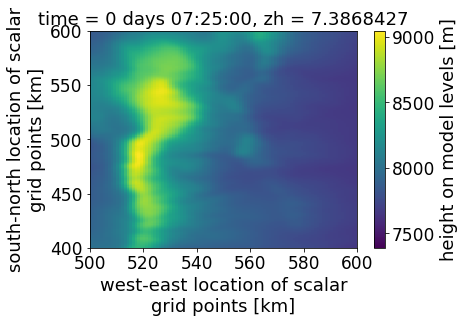

In [10]:
# test plot a variable

data.zhval[0, 62, :, :].plot()
plt.xlim([500, 600])
plt.ylim([400, 600])

## Get basic information like grid spacing, grid dimensions, etc. from the file

In [11]:
ni = (data.nx)
nj = (data.ny)
nk = (data.nz)

timesteps = (data.dims['time'])
xh = data.xh.values
yh = data.yh.values
zf = data.zf.values
zh = data.zhval.values
zs = data.zs.values
dx = data.xh.values[1] - data.xh.values[0]
dy = data.yh.values[1] - data.yh.values[0]

year = data.year
mon = data.month
day = data.day
hour = data.hour
minute = data.minute
second = data.second

panel_plot = False
my_dpi = 200
print('grid spacing (km) in x-direction:'+str(dx))

XH, YH = np.meshgrid(xh, yh)
#XV, ZV = np.meshgrid(xh, zh)
#YVV, ZVV = np.meshgrid(yh, zh)

winds_thin_x = 10
winds_thin_z = 5
print('ni = ', ni)
print('nj = ', nj)

grid spacing (km) in x-direction:1.0000001
ni =  1024
nj =  1024


## Function of extracting time from a CM1 file

This function will come in handy for naming the output png files (according to the time info in the file) and for writing time-related titles over plot.

In [12]:
def extract_CM1_time(data_xarray):
    # This function takes a xarray dataset as input. Only files with one output time per file can be used here.
    # It returns two strings:
    # No. 1: time contained in the CM1 output file for in the format "%Y-%m-%d %H:%M UTC" -- used for plot title
    # No. 2: time contained in the CM1 output file for in the format "%Y-%m-%d_%H-%M" -- used for filenames; cannot contain spaces

    year = data_xarray.year
    mon = data_xarray.month
    day = data_xarray.day
    hour = data_xarray.hour
    minute = data_xarray.minute
    second = data_xarray.second
    aa = data_xarray.time
    # print(aa)
    tiempo = (pd.to_datetime({'year': [year], 'month': [mon], 'day': [day], 'hour': [hour], 'minute': [minute],
                              'second': [second]}, utc=True)) + aa.values
    return tiempo.dt.strftime("%Y-%m-%d %H:%M")[0]+' UTC', tiempo.dt.strftime("%Y-%m-%d_%H-%M-%S")[0]


def extract_CM1_time_mf(data_xarray, time_number):
    # This function takes a xarray dataset as input. Multiple times per file here.
    year = data_xarray.year
    mon = data_xarray.month
    day = data_xarray.day
    hour = data_xarray.hour
    minute = data_xarray.minute
    second = data_xarray.second
    aa = data_xarray.time[time_number]
    # print(aa)
    tiempo = (pd.to_datetime({'year': [year], 'month': [mon], 'day': [day], 'hour': [hour], 'minute': [minute],
                              'second': [second]}, utc=True)) + aa.values
    return tiempo.dt.strftime("%Y-%m-%d %H:%M")[0]+' UTC', tiempo.dt.strftime("%Y-%m-%d_%H-%M-%S")[0]


# Test this function:
data = xr.open_dataset(direc+filename)
print(extract_CM1_time(data))

('2018-11-10 18:55 UTC', '2018-11-10_18-55-00')


## Function for plotting horizontal maps

This is the master function for plotting maps. This function is called whenever a 2D plot is created. Changes made here affect the aesthetics of all horizontal plots. 

In [13]:
def fig_process_horiz(CONTOUR, TERR_CONTOUR, CBAR_EXP, EVERY_OTHER_LABEL, TITLESTRING, TIMESTRING, FILENAMESTRING, PROD, UNITS, IS_PANEL_PLOT, XY_labels):
    F = plt.gcf()  # Gets the current figure

    ax = plt.gca()  # Gets the current axes

    if XY_labels:
        plt.xlabel('x-distance (km)', fontsize=18)
        plt.ylabel('y-distance (km)', fontsize=18)
        #plt.clabel(TERR_CONTOUR,inline=0.75, fontsize=10, fmt = '%3.f')

    if IS_PANEL_PLOT == False:
        plt.title('%s (%s) \n%s' %
                  (TITLESTRING, UNITS, TIMESTRING), fontsize=18)
        ax.set_aspect('equal')
        # bar.ax.tick_params(labelsize=14)
        # plt.close()
    else:
        # print 'panel plot'
        plt.title('%s (%s) \n%s' %
                  (TITLESTRING, UNITS, TIMESTRING), fontsize=18)
    # Code to make the colorbar outside of the main axis, on the bottom, and lined up
    # bar = plt.colorbar(CONTOUR, orientation='horizontal',format='%f', pad = 0.05, aspect = 55 ,extend='both') # Plots colorbar in new axis
    # bar.ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=5.0)) # Make the colorbars numbers nice
    # bar.update_ticks()

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.

    class OOMFormatter(matplotlib.ticker.ScalarFormatter):
        def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
            self.oom = order
            self.fformat = fformat
            matplotlib.ticker.ScalarFormatter.__init__(
                self, useOffset=offset, useMathText=mathText)

        def _set_orderOfMagnitude(self, nothing):
            self.orderOfMagnitude = self.oom

        def _set_format(self, vmin, vmax):
            self.format = self.fformat
            if self._useMathText:
                self.format = '$%s$' % matplotlib.ticker._mathdefault(
                    self.format)

    if IS_PANEL_PLOT == False:
        if abs(CBAR_EXP):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.62)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                               format=OOMFormatter(CBAR_EXP, mathText=False))
            bar.ax.tick_params(labelsize=18)
            #file_id = '%s_%s' % (PROD, FILENAMESTRING)
            #filename = '%s.png' % (file_id)
            # print(filename)
            # plt.savefig(filename, dpi = my_dpi, bbox_inches='tight') # Saves the figure with small margins

        else:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.55)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal")
            bar.ax.tick_params(labelsize=18)
            #file_id = '%s_%s' % (PROD, FILENAMESTRING)
            #filename = '%s.png' % (file_id)
            # print(filename)
            # plt.savefig(filename, dpi = my_dpi, bbox_inches='tight') # Saves the figure with small margins

    else:
        if XY_labels:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.62)
        else:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.5)

        if abs(CBAR_EXP):
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                               format=OOMFormatter(CBAR_EXP, mathText=False))
            bar.ax.tick_params(labelsize=17)
        else:
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal")
            bar.ax.tick_params(labelsize=17)

    if EVERY_OTHER_LABEL:
        for label in bar.ax.xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
    # bar.ax.locator_params(nbins=4)
    # if export_flag == 1:
    # Convert the figure to a gif file
    #os.system('convert -render -flatten %s %s.gif' % (filename, file_id))
    #os.system('rm -f %s' % filename)

## Function for plotting vertical cross-section

This is the master function for plotting vertical cross-sections. This function is called whenever a vertical cross-section plot is created. Changes made here affect the aesthetics of all vertical cross-section plots. 

In [14]:
def fig_process_vert(CONTOUR, XY1, XY2, Y_CROSS, CBAR_EXP, TITLESTRING, TIMESTRING, FILENAMESTRING, PROD, UNITS, VERT_CROSS, HEIGHT, IS_PANEL_PLOT):
    F = plt.gcf()  # Gets the current figure
    ax = plt.gca()  # Gets the current axes

    if IS_PANEL_PLOT == False:
        plt.title('%s (%s) \n %s' % (TITLESTRING, UNITS, TIMESTRING),
                  fontsize=18, stretch='normal')

    if VERT_CROSS == "zonal":
        ax.fill_between(xh[XY1:XY2], 0, zs[0, int(Y_CROSS),
                        XY1:XY2]/1000.0, facecolor='wheat')
        plt.xlabel('x distance (km)', fontsize=18)

    else:
        ax.fill_between(yh[XY1:XY2], 0, zs[0, XY1:XY2,
                        int(Y_CROSS)]/1000.0, facecolor='wheat')
        plt.xlabel('y distance (km)', fontsize=18)

    plt.gca().patch.set_color("white")

    plt.ylabel('Height (km)', fontsize=18)
    plt.ylim([0, HEIGHT])

    class OOMFormatter(matplotlib.ticker.ScalarFormatter):
        def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
            self.oom = order
            self.fformat = fformat
            matplotlib.ticker.ScalarFormatter.__init__(
                self, useOffset=offset, useMathText=mathText)

        def _set_orderOfMagnitude(self, nothing):
            self.orderOfMagnitude = self.oom

        def _set_format(self, vmin, vmax):
            self.format = self.fformat
            if self._useMathText:
                self.format = '$%s$' % matplotlib.ticker._mathdefault(
                    self.format)

    if IS_PANEL_PLOT == False:
        if abs(CBAR_EXP):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.6)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                               format=OOMFormatter(CBAR_EXP, mathText=False))
            bar.ax.tick_params(labelsize=18)
            file_id = '%s_%s' % (PROD, FILENAMESTRING)
            filename = '%s.png' % (file_id)
            print(filename)
            # Saves the figure with small margins
            plt.savefig(filename, dpi=my_dpi, bbox_inches='tight')
        else:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.66)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal")
            bar.ax.tick_params(labelsize=18)
            file_id = '%s_%s' % (PROD, FILENAMESTRING)
            filename = '%s.png' % (file_id)
            print(filename)
            # Saves the figure with small margins
            plt.savefig(filename, dpi=my_dpi, bbox_inches='tight')

    else:
        if abs(CBAR_EXP):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.4)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                               format=OOMFormatter(CBAR_EXP, mathText=False))
            bar.ax.tick_params(labelsize=18)
        else:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.4)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal")
            bar.ax.tick_params(labelsize=18)
    # plt.close() This should remain commented. plt should be closed in the panel plot function
    # if export_flag == 1:
    # Convert the figure to a gif file
    #os.system('convert -render -flatten %s %s.gif' % (filename, file_id))
    #os.system('rm -f %s' % filename)

## Function for creating sounding indices

In [15]:
def create_indices(p, h, tc, td, wspeed, wind_dir, u, v, WRITE_SRH_OBS, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None):

    rhum = mpcalc.relative_humidity_from_dewpoint(tc, td)
    mr = mpcalc.mixing_ratio_from_relative_humidity(
        pressure=p, temperature=tc, relative_humidity=rhum)
    tv = mpcalc.virtual_temperature(temperature=tc, mixing_ratio=mr).to('degC')

    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tv[0], td[0])  # calc LCL
    lfc = mpcalc.lfc(p, tc, td, parcel_temperature_profile=None, which='top')

    # print('h',h)
    #print('min h',min(h.magnitude)*units('m'))
    #print('max h',max(h.magnitude)*units('m'))
    #print('input u in create_indices',u)
    #print('input v in create_indices',v)
    u_0_1, v_0_1 = mpcalc.bulk_shear(
        p, u, v, height=h, depth=1000.0*units('m'))
    u_0_3, v_0_3 = mpcalc.bulk_shear(
        p, u, v, height=h, depth=3000.0*units('m'))
    u_0_6, v_0_6 = mpcalc.bulk_shear(
        p, u, v, height=h, depth=6000.0*units('m'))
    _1km_shear = mpcalc.wind_speed(u_0_1, v_0_1)
    _3km_shear = mpcalc.wind_speed(u_0_3, v_0_3)
    _6km_shear = mpcalc.wind_speed(u_0_6, v_0_6)

    print('Metpy shear')
    print('u,v,speed 0-1 km shear = ', u_0_1, v_0_1, _1km_shear)
    print('u,v,speed 0-3 km shear = ', u_0_3, v_0_3, _3km_shear)
    print('u,v,speed 0-6 km shear = ', u_0_6, v_0_6, _6km_shear)
    print(' ')

    prof = profile.create_profile(profile='default', pres=np.array(p), hght=np.array(h), tmpc=np.array(tc),
                                  dwpc=np.array(td), wspd=np.array(wspeed), wdir=np.array(wind_dir), missing=-9999, strictQC=True)
    print('LFC IS ', lfc)
    msl_hght = prof.hght[prof.sfc]  # Grab the surface height value
    print("SURFACE HEIGHT (m MSL):", msl_hght)
    agl_hght = interp.to_agl(prof, msl_hght)  # Converts to AGL
    print("SURFACE HEIGHT (m AGL):", agl_hght)
    msl_hght = interp.to_msl(prof, agl_hght)  # Converts to MSL
    print("SURFACE HEIGHT (m MSL):", msl_hght)

    sfcpcl = params.parcelx(prof, flag=1)  # Surface Parcel
    fcstpcl = params.parcelx(prof, flag=2)  # Forecast Parcel
    mupcl = params.parcelx(prof, flag=3)  # Most-Unstable Parcel
    mlpcl = params.parcelx(prof, flag=4)  # 100 mb Mean Layer Parcel

    sfc = prof.pres[prof.sfc]
    p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
    p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
    p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
    mean_3km = winds.mean_wind(prof, pbot=sfc, ptop=p3km)
    sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
    sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
    sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
    #print('SharpPy shear')
    #print('sfc_6km_shear ',sfc_6km_shear)
    #print('sfc_3km_shear ',sfc_3km_shear)
    #print('sfc_1km_shear ',sfc_1km_shear)

    srwind = params.bunkers_storm_motion(prof)
    srh3km_r = winds.helicity(prof, 0, 3000., stu=srwind[0], stv=srwind[1])
    srh1km_r = winds.helicity(prof, 0, 1000., stu=srwind[0], stv=srwind[1])
    srh3km_l = winds.helicity(prof, 0, 3000., stu=srwind[2], stv=srwind[3])
    srh1km_l = winds.helicity(prof, 0, 1000., stu=srwind[2], stv=srwind[3])

    #stp_fixed = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km[0], utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])
    ship = params.ship(prof)
    eff_inflow = params.effective_inflow_layer(prof)
    ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
    etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
    effective_srh_r = winds.helicity(
        prof, ebot_hght, etop_hght, stu=srwind[0], stv=srwind[1])
    effective_srh_l = winds.helicity(
        prof, ebot_hght, etop_hght, stu=srwind[2], stv=srwind[3])
    ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
    ebwspd = utils.mag(ebwd[0], ebwd[1])

    if WRITE_SRH_OBS:
        if L_OR_R == 'L':
            srh3km_l_obs = winds.helicity(
                prof, 0, 3000., stu=U_STORM_OBS, stv=V_STORM_OBS)
            srh1km_l_obs = winds.helicity(
                prof, 0, 1000., stu=U_STORM_OBS, stv=V_STORM_OBS)
        elif L_OR_R == 'R':
            srh3km_r_obs = winds.helicity(
                prof, 0, 3000., stu=U_STORM_OBS, stv=V_STORM_OBS)
            srh1km_r_obs = winds.helicity(
                prof, 0, 1000., stu=U_STORM_OBS, stv=V_STORM_OBS)
        else:
            print('L_OR_R can only take two values: <L> or <R>')

    #scp = params.scp(mupcl.bplus, effective_srh[0], ebwspd)
    #stp_cin = params.stp_cin(mlpcl.bplus, effective_srh[0], ebwspd, mlpcl.lclhght, mlpcl.bminus)

    indices = {'LFC': [np.int_(lfc[0].magnitude), 'hPa'],
               'LCL': [np.int_(lcl_pressure.magnitude), 'hPa'],
               'SBCAPE': [np.int_(np.round(sfcpcl.bplus)), 'J/kg'],
               'SBCIN': [np.int_(np.round(sfcpcl.bminus)), 'J/kg'],
               'SBLCL': [(np.round(sfcpcl.lclhght)), 'm AGL'],
               'SBLFC': [(np.round(sfcpcl.lfchght)), 'm AGL'],
               'SBEL': [(np.round(sfcpcl.elhght)), 'm AGL'],
               'SBLI': [np.int_(np.round(sfcpcl.li5)), 'deg C'],
               'MLCAPE': [np.int_(np.round(mlpcl.bplus)), 'J/kg'],
               'MLCIN': [np.int_(np.round(mlpcl.bminus)), 'J/kg'],
               'MLLCL': [(np.round(mlpcl.lclhght)), 'm AGL'],
               'MLLFC': [(np.round(mlpcl.lfchght)), 'm AGL'],
               'MLEL': [(np.round(mlpcl.elhght)), 'm AGL'],
               'MLLI': [np.int_(np.round(mlpcl.li5)), 'deg C'],
               'MUCAPE': [np.int_(np.round(mupcl.bplus)), 'J/kg'],
               'MUCIN': [np.int_(np.round(mupcl.bminus)), 'J/kg'],
               'MULCL': [(np.round(mupcl.lclhght)), 'm AGL'],
               'MULFC': [(np.round(mupcl.lfchght)), 'm AGL'],
               'MUEL': [(np.round(mupcl.elhght)), 'm AGL'],
               'MULI': [(np.round(mupcl.li5)), 'deg C'],
               '0-1 km Shear': [np.int_(np.round(utils.comp2vec(sfc_1km_shear[0], sfc_1km_shear[1])[1])), 'kts'],
               '0-3 km Shear': [np.int_(_3km_shear), 'kts'],
               '0-6 km Shear': [np.int_(_6km_shear), 'kts'],
               '0-1 km SRH (Bunkers LM)': [np.int_(np.round(srh1km_l[0])), '$m^{2}/s^{2}$'],
               '0-3 km SRH (Bunkers LM)': [np.int_(np.round(srh3km_l[0])), '$m^{2}/s^{2}$'],
               '0-1 km SRH (Bunkers RM)': [np.int_(np.round(srh1km_r[0])), '$m^{2}/s^{2}$'],
               '0-3 km SRH (Bunkers RM)': [np.int_(np.round(srh3km_r[0])), '$m^{2}/s^{2}$'],
               'Eff. SRH (Bunkers LM)': [np.int_(np.round(effective_srh_l[0])), '$m^{2}/s^{2}$'],
               'Eff. SRH (Bunkers RM)': [np.int_(np.round(effective_srh_r[0])), '$m^{2}/s^{2}$']}

    if WRITE_SRH_OBS:
        if L_OR_R == 'L':
            indices['0-1 km SRH (Model-Obs LM)'] = [np.int_(
                np.round(srh1km_l_obs[0])), '$m^{2}/s^{2}$']
            indices['0-3 km SRH (Model-Obs LM)'] = [np.int_(
                np.round(srh3km_l_obs[0])), '$m^{2}/s^{2}$']
        elif L_OR_R == 'R':
            indices['0-1 km SRH (Model-Obs RM)'] = [np.int_(
                np.round(srh1km_r_obs[0])), '$m^{2}/s^{2}$']
            indices['0-3 km SRH (Model-Obs RM)'] = [np.int_(
                np.round(srh3km_r_obs[0])), '$m^{2}/s^{2}$']
        else:
            pass

    # if U_STORM_OBS:
    #    indices['Storm relative flow']=

    # 'EBWD': [np.round(ebwspd), 'kts'],\
    # 'PWV': [np.round(params.precip_water(prof), 2), 'inch']}
    # 'K-index': [np.round(params.k_index(prof)), ''],\
    # 'STP(fix)': [np.round(stp_fixed, 1), ''],\
    # 'SHIP': [np.round(ship, 1), ''],\
    # 'SCP': [np.round(scp, 1), ''],\
    # 'STP(cin)': [np.round(stp_cin, 1), '']}
    # List the indices within the indices dictionary on the side of the plot.
    return indices

                                               **Scratchwork**

# Plotting starts below

**Suggested Colormaps:**<br>
**1. precip**: cmap=ncm.cmap("precip3_16lev")<br>
**2. moisture**: cmap=ncm.cmap("WhiteBlue")<br>
**3. sfc div/vert vel**:  ncm.cmap("BlueWhiteOrangeRed")<br>
**4. sfc_temp**: plt.get_cmap('Spectral_r')<br>
**5. reflectivity**: cmap=coltbls.reflect()<br>
**6. CAPE**:  ncm.cmap("WhiteBlueGreenYellowRed")<br>
**7. CIN**:  ncm.cmap("BlueWhiteOrangeRed")<br>
**8. vorticity**:ncm.cmap("BlueWhiteOrangeRed")<br>

<center> **Important Note** </center>

This notebook uses experiment name throughout to locate CM1 output files and name output files. This makes organization of output images easier. 

For example, if you have a CM1 simulation that simulates a supercell at 250-m grid spacing using a sounding named 20Jan202011UTC, and you have the output netcdf files in the directory: /home/user/cm1/supercell_250m_20Jan202011UTC, then your directory is '/home/user/cm1/' and experiment name is 'supercell_250m_20Jan202011UTC'.

The output image files will named as per this format: experiment name + variable being plotted + timestamp + .png

e.g., supercell_250m_20Jan202011UTC_cape_2021-01-20_1245UTC.png

# Plot any 2D quantity

EXPERIMENT:  stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km

[['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000100.nc']]
 
/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000100.nc
dbz


<ipython-input-20-68d2ae5f6b1b>:715: UserWarning: The following kwargs were not used by contour: 'axis'
  C1 = plt.contourf(XH, YH, var2, levels=levels,
<ipython-input-20-68d2ae5f6b1b>:768: UserWarning: The following kwargs were not used by contour: 'axis'
  C6 = plt.contour(XH, YH, XR_DARRAY.variables['winterp'][0, 20:80, BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0), levels=[8],
<ipython-input-20-68d2ae5f6b1b>:791: UserWarning: The following kwargs were not used by contour: 'axis'
  C7 = plt.contour(XH, YH, theta_anomaly, levels=[theta_anomaly_threshold],
<ipython-input-20-68d2ae5f6b1b>:832: UserWarning: The following kwargs were not used by contour: 'axis'
  C4 = plt.contour(XH, YH, zs, levels=levels_zs, colors="k",


 area of the largest cold pool is  520  km^{2}
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_1000_dbz_2018-11-10_19-45-00.png


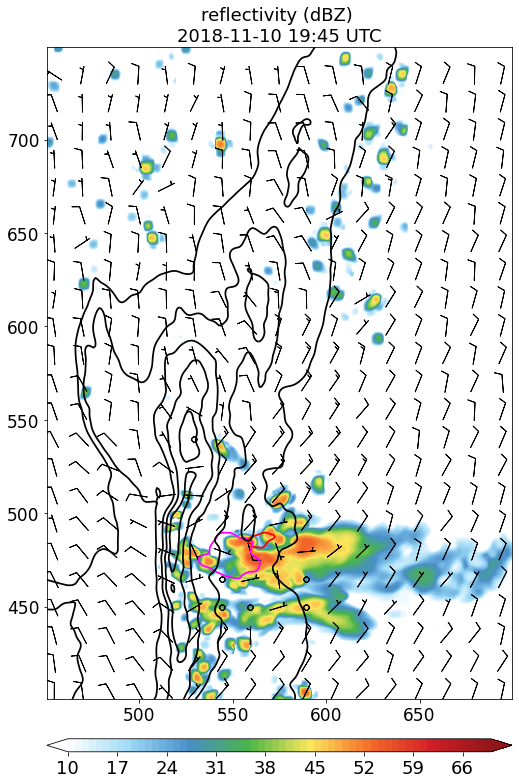

In [20]:
from metpy.plots import ctables


def get_pbl_level(XAR):
    pblh = XAR.variables['hpbl'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
    zhh = XAR.variables['zh'][0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
    zhh.values = zhh.values - pblh.values
    pbl_level = zhh.argmin(dim='nk')
    return pbl_level


def plot_var(VARNAME1, VARNAME2, VARNAME3, VARNAME4,
             SEGM, THRES, AREA,
             XR_DARRAY, VAR1_LEVEL, VAR2_LEVEL, VAR3_LEVEL, XR_DARRAY2,
             LINE_CHARAC, IF_DENSITY_WTD, LEVEL1, LEVEL2,
             UL_XIND, UL_YIND, BR_XIND, BR_YIND, CBAR_EXP, MIN_LEV, MAX_LEV, STEP_LEV, NUM_LEVELS, VAR3_LEVELS, VAR3_COLOR, VAR4_LEVELS,
             TITLE, COLORMAP, AX,
             PLOT_SFC_WINDS, WIND_STYLE, PLOT_REFL, PLOT_UPDRAFT, PLOT_CP, PLOT_ZS, IS_PANEL_PLOT, XY_labels,
             DIR, EXP):

    if VARNAME1:
        if VAR1_LEVEL:
            var1 = XR_DARRAY.variables[VARNAME1][0,
                                                 VAR1_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        else:
            var1 = XR_DARRAY.variables[VARNAME1][0,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND]

    if VARNAME2 == "div_mf_stretching_term":
        print(VARNAME2)
        if IF_DENSITY_WTD == 'vint':
            # prs=XR_DARRAY.variables['prs'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
            # th=XR_DARRAY.variables['th'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
            # qv_metpy=XR_DARRAY.variables['qv'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
            #temp= mcalc.temperature_from_potential_temperature(prs,th)
            #rho= mcalc.density(pressure=prs,temperature=temp,mixing=qv_metpy)
            qv = XR_DARRAY.variables['qv'][0,
                                           (LEVEL1+1):(LEVEL2), BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            # wi=XR_DARRAY.variables['winterp'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            # dzi = XR_DARRAY.zh[0,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-\
            #                    XR_DARRAY.zh[0,LEVEL1:(LEVEL2-1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = (qv.values*(np.gradient(ui.values, dx*1000.0,
                           axis=2)+np.gradient(vi.values, dy*1000.0, axis=1)))*-1000.0
            # var2.values=(qv.values*np.gradient(wi.values,100.,axis=0))*1000.0
            var2.attrs['long_name'] = 'moisture flux divergence: convergence term'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
        else:
            q = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                          BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            u = XR_DARRAY.variables['uinterp'][0,
                                               VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            v = XR_DARRAY.variables['vinterp'][0,
                                               VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            qconv = (np.gradient(u*q, dx*1000.0, axis=1) +
                     np.gradient(v*q, dy*1000.0, axis=0))*(-10**5)
            var2 = xr.DataArray(data=np.array(qconv), dims=['nj', 'ni'], attrs={'long_name': 'moisture convergence',
                                                                                'units': '$10^{-5}  kg/kg/s$'})

    if VARNAME2 == "mass_conv":
        print(VARNAME2)
        if IF_DENSITY_WTD == 'vint':
            ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(ui, fill_value=np.nan)
            var2.values = ((np.gradient(ui.values, dx*1000.0, axis=2) +
                           np.gradient(vi.values, dy*1000.0, axis=1)))*-1.0
            var2.attrs['long_name'] = 'mass convergence'
            var2.attrs['units'] = '$s^{-1}$'
        else:

            u = XR_DARRAY.variables['uinterp'][0,
                                               VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            v = XR_DARRAY.variables['vinterp'][0,
                                               VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            mconv = (np.gradient(u, dx*1000.0, axis=1) +
                     np.gradient(v, dy*1000.0, axis=0))*(-1.0)
            if VAR2_LEVEL == 0:
                var2 = xr.DataArray(data=np.array(mconv), dims=['nj', 'ni'], attrs={'long_name': 'mass convergence at model level 1',
                                                                                    'units': '$s^{-1}$'})
            else:
                var2 = xr.DataArray(data=np.array(mconv), dims=['nj', 'ni'], attrs={'long_name': 'mass convergence',
                                                                                    'units': '$s^{-1}$'})

    elif VARNAME2 == "div_mf":
        print(VARNAME2)
        if (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == '3D'):
            # prs=XR_DARRAY.variables['prs'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
            # th=XR_DARRAY.variables['th'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
            # qv_metpy=XR_DARRAY.variables['qv'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
            #temp= mcalc.temperature_from_potential_temperature(prs,th)
            #rho= mcalc.density(pressure=prs,temperature=temp,mixing=qv_metpy)
            qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                           1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = (np.gradient(vi.values*qv.values, dy*1000.0, axis=1) +
                           np.gradient(ui.values*qv.values, dx*1000.0, axis=2))*-1000.
            var2.attrs['long_name'] = 'moisture flux divergence'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
        else:
            qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            ui = XR_DARRAY.variables['uinterp'][0,
                                                VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            vi = XR_DARRAY.variables['vinterp'][0,
                                                VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = (np.gradient(vi.values*qv.values, dy*1000.0, axis=0) +
                           np.gradient(ui.values*qv.values, dx*1000.0, axis=1))*-1000.
            var2.attrs['long_name'] = 'moisture flux divergence'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "div_mf_pbl":
        print(VARNAME2)
        if (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == '3D'):
            # prs=XR_DARRAY.variables['prs'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
            # th=XR_DARRAY.variables['th'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
            # qv_metpy=XR_DARRAY.variables['qv'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
            #temp= mcalc.temperature_from_potential_temperature(prs,th)
            #rho= mcalc.density(pressure=prs,temperature=temp,mixing=qv_metpy)
            qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                           1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = (np.gradient(vi.values*qv.values, dy*1000.0, axis=1) +
                           np.gradient(ui.values*qv.values, dx*1000.0, axis=2))*-1000.
            var2.attrs['long_name'] = 'moisture flux divergence'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "d(qw)/dz":
        print(VARNAME2)
        if (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == '3D'):
            # prs=XR_DARRAY.variables['prs'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
            # th=XR_DARRAY.variables['th'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
            # qv_metpy=XR_DARRAY.variables['qv'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
            #temp= mcalc.temperature_from_potential_temperature(prs,th)
            #rho= mcalc.density(pressure=prs,temperature=temp,mixing=qv_metpy)
            qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                           1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            wi = XR_DARRAY.variables['winterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = (np.gradient(wi.values*qv.values, 100.0, axis=0)) * \
                1000.
            var2.attrs['long_name'] = 'd(qu)/dz'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
        else:
            qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            wi = XR_DARRAY.variables['winterp'][0,
                                                VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = (np.gradient(wi.values*qv.values, 100.0, axis=0)) * \
                1000.
            var2.attrs['long_name'] = 'd(qu)/dz'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "qd(w)/dz":
        print(VARNAME2)
        if (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == '3D'):
            # prs=XR_DARRAY.variables['prs'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
            # th=XR_DARRAY.variables['th'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
            # qv_metpy=XR_DARRAY.variables['qv'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
            #temp= mcalc.temperature_from_potential_temperature(prs,th)
            #rho= mcalc.density(pressure=prs,temperature=temp,mixing=qv_metpy)
            qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                           1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            wi = XR_DARRAY.variables['winterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = qv.values * \
                (np.gradient(wi.values, 100.0, axis=0))*1000.
            var2.attrs['long_name'] = 'qd(w)/dz'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
        else:
            qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            wi = XR_DARRAY.variables['winterp'][0,
                                                VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = qv.values * \
                (np.gradient(wi.values, 100.0, axis=0))*1000.
            var2.attrs['long_name'] = 'qd(w)/dz'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "wd(q)/dz":
        print(VARNAME2)
        if (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == '3D'):
            # prs=XR_DARRAY.variables['prs'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
            # th=XR_DARRAY.variables['th'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
            # qv_metpy=XR_DARRAY.variables['qv'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
            #temp= mcalc.temperature_from_potential_temperature(prs,th)
            #rho= mcalc.density(pressure=prs,temperature=temp,mixing=qv_metpy)
            qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                           1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            wi = XR_DARRAY.variables['winterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = wi.values * \
                (np.gradient(qv.values, 100.0, axis=0))*1000.
            var2.attrs['long_name'] = 'wd(q)/dz'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
        else:
            qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            wi = XR_DARRAY.variables['winterp'][0,
                                                VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = wi.values * \
                (np.gradient(qv.values, 100.0, axis=0))*1000.
            var2.attrs['long_name'] = 'wd(q)/dz'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == 'bmin':
        prs_levs = XR_DARRAY.variables['prs'][0, 0:50,
                                              BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        prs = XR_DARRAY.variables['prs'][0, 0,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, 0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, 0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('kg/kg')
        hgts = XR_DARRAY.variables['zh'][0, 0,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('m')
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        sphum = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt = mcalc.dewpoint_from_specific_humidity(
            specific_humidity=sphum, temperature=temp, pressure=prs)
        #thetae = mcalc.equivalent_potential_temperature(pressure=prs,temperature=temp,dewpoint=dewpt)
        #max_idx= np.argmax(thetae,axis=0)
        print(prs_levs)
        print(temp)
        print(dewpt)
        # aa=mcalc.parcel_profile(pressure=,temperature=,dewpt=)
        print(aa)
        var2 = aa[0, :, :]
        # p_maxthetae=prs[max_idx]
        # t_maxthetae=temp[max_idx]
        # td_maxthetae=dewpt[max_idx]
        # print(np.shape(td_maxthetae))
        # print(np.shape(max_idx))
        # print(np.shape(thetae))
        # calc moist unstable parcel
        # print(mcalc.most_unstable_parcel(pressure=prs,temperature=temp,dewpoint=dwpt,heights=hgts))#,depth=<Quantity(50, 'hectopascal')>))

    elif VARNAME2 == "pertprs_gradient":
        print(VARNAME2)
        ui = XR_DARRAY.variables['prspert'][0,
                                            VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = xr.full_like(ui, fill_value=np.nan)
        var2.values = np.gradient(ui.values, dx*1000.0, axis=1)  # *-1.0
        var2.attrs['long_name'] = 'perturbation pressure gradient'
        var2.attrs['units'] = '$Pa m^{-1}$'

    elif VARNAME2 == "qadv":
        q = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                      BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][0,
                                           VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][0,
                                           VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        qadv = np.array((u*np.gradient(q, dx*1000.0, axis=1) +
                        v*np.gradient(q, dy*1000.0, axis=0))*(-10**6))
        var2 = xr.DataArray(data=np.array(qadv), dims=['nj', 'ni'], attrs={'long_name': 'moisture advection',
                                                                           'units': '$10^{-6}  kg/kg/s$'})

    elif VARNAME2 == "max_w_hgt":
        w = XR_DARRAY.variables['winterp'][0,
                                           LEVEL1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        # print(w)
        max_idx = np.argmax(w, axis=0)
        ter = XR_DARRAY.variables['zs'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vs = XR_DARRAY.zh[0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vs = vs[max_idx] - ter
        lfc = XR_DARRAY.variables['lfc'][0,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND]  # -ter
        var2 = vs/lfc
        var2.attrs['long_name'] = 'ratio of hgt of $w_{max}/lfc$'
        var2.attrs['units'] = '$m$'

    elif VARNAME2 == "0-3km_shear":
        u_3 = XR_DARRAY.variables['uinterp'][0,
                                             30, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_3 = XR_DARRAY.variables['vinterp'][0,
                                             30, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_0 = XR_DARRAY.variables['vinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_shr = (u_3 - u_0)*1.94384
        v_shr = (v_3 - v_0)*1.94384
        shear = np.sqrt(u_shr**2 + v_shr**2)
        var2 = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-3 km shear',
                                                                            'units': 'knots'})
        print(var2.max().values)

    elif VARNAME2 == "0-6km_shear_model":
        u_55 = XR_DARRAY.variables['uinterp'][0,
                                              55, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_55 = XR_DARRAY.variables['vinterp'][0,
                                              55, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_0 = XR_DARRAY.variables['vinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_shr = (u_55 - u_0)*1.94384
        v_shr = (v_55 - v_0)*1.94384
        shear = np.sqrt(u_shr**2 + v_shr**2)
        var2 = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-6 km shear',
                                                                            'units': 'knots'})

    elif VARNAME2 == "0-6km_shear":
        #u_6 = XR_DARRAY.variables['uinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        #v_6 = XR_DARRAY.variables['vinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        v_0 = XR_DARRAY.variables['vinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        uu = XR_DARRAY.variables['uinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vv = XR_DARRAY.variables['vinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        zz = XR_DARRAY.variables['zh'][0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        #print(zz[0,:,:] + 6000.)
        u_6 = interplevel(uu.values, zz.values, zz[0, :, :].values +
                          6000., missing=9.969209968386869e+36, squeeze=True, meta=True)
        v_6 = interplevel(vv.values, zz.values, zz[0, :, :].values +
                          6000., missing=9.969209968386869e+36, squeeze=True, meta=True)
        #u_0 = XR_DARRAY.variables['u10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        #v_0 = XR_DARRAY.variables['v10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        u_shr = (u_6 - u_0)*1.94384
        v_shr = (v_6 - v_0)*1.94384
        print(np.shape(u_shr))
        shear = np.sqrt(u_shr**2 + v_shr**2)
        print(np.shape(shear))
        var2 = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-6 km shear',
                                                                            'units': 'knots'})
        #print('max value of var2 ',VAR2,' is ',var2.max().values)

    elif VARNAME2 == "0-6km_AMSL_shear":
        #u_6 = XR_DARRAY.variables['uinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        #v_6 = XR_DARRAY.variables['vinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        v_0 = XR_DARRAY.variables['vinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        uu = XR_DARRAY.variables['uinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vv = XR_DARRAY.variables['vinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        zz = XR_DARRAY.variables['zh'][0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        #print(zz[0,:,:] + 6000.)
        u_6 = interplevel(uu.values, zz.values, 6000.,
                          missing=9.969209968386869e+36, squeeze=True, meta=True)
        v_6 = interplevel(vv.values, zz.values, 6000.,
                          missing=9.969209968386869e+36, squeeze=True, meta=True)
        #u_0 = XR_DARRAY.variables['u10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        #v_0 = XR_DARRAY.variables['v10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        u_shr = (u_6 - u_0)*1.94384
        v_shr = (v_6 - v_0)*1.94384
        print(np.shape(u_shr))
        shear = np.sqrt(u_shr**2 + v_shr**2)
        print(np.shape(shear))
        var2 = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-6 km shear',
                                                                            'units': 'knots'})
        #print('max value of var2 ',VAR2,' is ',var2.max().values)

    elif VARNAME2 == "thetae":
        prs = XR_DARRAY.variables['prs'][0, VAR2_LEVEL,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        shum = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt = mcalc.dewpoint_from_specific_humidity(
            pressure=prs, temperature=temp, specific_humidity=shum)
        var2 = mcalc.equivalent_potential_temperature(
            pressure=prs, temperature=temp, dewpoint=dewpt)
        var2 = xr.DataArray(data=np.array(var2), dims=['nj', 'ni'], attrs={'long_name': 'Equivalent potential temperature',
                                                                           'units': 'K'})

    elif VARNAME2 == "sfc_thetae":
        prs = XR_DARRAY.variables['psfc'][0, BR_YIND:UL_YIND,
                                          UL_XIND:BR_XIND].values*munits('Pa')
        t2 = XR_DARRAY.variables['t2'][0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('K')
        q2 = XR_DARRAY.variables['q2'][0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('kg/kg')
        shum = mcalc.specific_humidity_from_mixing_ratio(q2)
        dewpt = mcalc.dewpoint_from_specific_humidity(
            pressure=prs, temperature=t2, specific_humidity=shum)
        var2 = mcalc.equivalent_potential_temperature(
            pressure=prs, temperature=t2, dewpoint=dewpt)
        var2 = xr.DataArray(data=np.array(var2), dims=['nj', 'ni'], attrs={'long_name': 'Surface equivalent potential temperature',
                                                                           'units': 'K'})

    elif VARNAME2 == "density_theta":
        Rv = 461.5
        Rd = 287.04
        th = XR_DARRAY.variables['th'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('Pa')
        qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('K')
        qc = XR_DARRAY.variables['qc'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('kg/kg')
        qr = XR_DARRAY.variables['qr'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('kg/kg')
        ql = qc + qr
        var2 = th*(1.0 + ((Rv/Rd) - 1.0)*qv - ql)
        var2 = xr.DataArray(data=np.array(var2), dims=['nj', 'ni'], attrs={'long_name': 'density potential temperature',
                                                                           'units': 'K'})

    elif VARNAME2 == "temperature":
        prs = XR_DARRAY.variables['prs'][0, VAR2_LEVEL,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        var2 = xr.DataArray(data=np.array(temp), dims=['nj', 'ni'], attrs={'long_name': 'temperature',
                                                                           'units': 'K'})
    elif VARNAME2 == "vintqc":
        prs = XR_DARRAY.variables['prs'][0, 1:,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, 1:,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, 1:, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('kg/kg')
        qc = XR_DARRAY.variables['qc'][0, 1:, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        # R=287.0
        # Cp=1004.0
        # T=XR_DARRAY.variables['th'][0,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*(XR_DARRAY.variables['prs'][0,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/100000.0)**(R/Cp)
        #rho = XR_DARRAY.variables['prs'][0,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
        rho = mcalc.density(pressure=prs, temperature=temp, mixing=qv)
        # print(rho)
        # print(np.max(rho.values))
        vertical_spacings = XR_DARRAY.zh[0, 1:, BR_YIND:UL_YIND,
                                         UL_XIND:BR_XIND]-XR_DARRAY.zh[0, :-1, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vint_qx = qc*rho.magnitude*vertical_spacings
        var2 = vint_qx.sum(dim='nk')
        var2.attrs['long_name'] = 'Vertically integrated ' + \
            qc.attrs['long_name']
        var2.attrs['units'] = '$kg/m^{2}$'

    elif VARNAME2 == "wmax":
        w_temp = XR_DARRAY.variables['winterp'][0,
                                                LEVEL1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = w_temp.max(dim='nk')
        var2.attrs['long_name'] = 'max PBL ' + w_temp.attrs['long_name']
        var2.attrs['units'] = w_temp.attrs['units']

    elif VARNAME2 == "np_hadv":
        print(VARNAME2)
        qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                       1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = xr.full_like(qv, fill_value=np.nan)
        var2.values = (vi.values*np.gradient(qv.values, dy*1000.0, axis=1) +
                       ui.values*np.gradient(qv.values, dx*1000.0, axis=2))*-1000.  # +
        var2.attrs['long_name'] = 'qv budget: horizontal advection of qv'
        var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "du_dx":
        print(VARNAME2)
        ui = XR_DARRAY.variables['uinterp'][0,
                                            VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = xr.full_like(ui, fill_value=np.nan)
        var2.values = (np.gradient(ui.values, dx*1000.0, axis=1))  # *1000.#+
        var2.attrs['long_name'] = 'du/dx'
        var2.attrs['units'] = '$s^{-1}$'

    elif VARNAME2 == "np_xadv":
        print(VARNAME2)
        qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                       1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = xr.full_like(qv, fill_value=np.nan)
        var2.values = (ui.values*np.gradient(qv.values,
                       dx*1000.0, axis=2))*-1000.  # +
        var2.attrs['long_name'] = 'qv budget: x-advection of qv'
        var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "np_yadv":
        print(VARNAME2)
        qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                       1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = xr.full_like(qv, fill_value=np.nan)
        var2.values = (vi.values*np.gradient(qv.values,
                       dy*1000.0, axis=1))*-1000.  # +
        var2.attrs['long_name'] = 'qv budget: y-advection of qv'
        var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "dbz":
        print(VARNAME2)
        var2 = XR_DARRAY.variables['dbz'][0,
                                          VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = var2.where(var2 > -10.0)

    elif VARNAME2 == "rain_rate":
        if XR_DARRAY2:
            rain_temp1 = XR_DARRAY.variables['rain'][0,
                                                     BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            #rain_temp1.attrs['description'] = 'total rain'
            #rain_temp1.attrs['units'] = rain_temp1.units

            rain_temp2 = XR_DARRAY2.variables['rain'][0,
                                                      BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            #rain_temp2.attrs['description'] = 'total rain'
            #rain_temp2.attrs['units'] = rain_temp2.units

            var2 = (rain_temp1 - rain_temp2)*10.0*60.0/5.
            var2.attrs['long_name'] = 'rain rate'
            var2.attrs['units'] = 'mm/hr'
        else:
            print('###################')
            print('please provide the previous file for rain rate calculation')
            print('###################')

    elif VARNAME2 == 'prspert_calc':
        print(VARNAME2)
        prs_final = XR_DARRAY.variables['prs'][0,
                                               VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        XR_DARRAY2 = xr.open_dataset(DIR+EXP+'/cm1out_000001.nc')
        prs_init = XR_DARRAY2.variables['prs'][0,
                                               VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = prs_final - prs_init
        var2.attrs['long_name'] = 'pressure perturbation'
        var2.attrs['units'] = '$Pa$'

    else:
        print(VARNAME2+' variable found in the dataset')
        if IF_DENSITY_WTD == 'vint':
            var2 = XR_DARRAY.variables[VARNAME2][0, LEVEL1 +
                                                 1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        else:
            if VAR2_LEVEL != None:
                var2 = XR_DARRAY.variables[VARNAME2][0,
                                                     VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            else:
                var2 = XR_DARRAY.variables[VARNAME2][0,
                                                     BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                # print(var2.max())
        ############# SEGMENTATION #######################################################################
    # print(var2)
    if SEGM:
        IMAGE = var1.values
        bw = closing(IMAGE > THRES, square(3))  # apply threshold
        # remove artifacts connected to image border
        cleared = clear_border(bw)
        label_image = label(cleared)           # label image regions
        #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
        regions = [rr for rr in regionprops(label_image)]
        areas = [r.area for r in regions]

        if areas:
            max_area = max(np.array(areas))
            max_area_ind = areas.index(max(areas))
            max_area_label_coords_array = regions[max_area_ind].coords

            for region in regions:
                # take regions with large enough areas
                if region.area >= (max_area-1.0):
                    minr, minc, maxr, maxc = region.bbox

            rows = [uu[0] for uu in max_area_label_coords_array]
            cols = [uu[1] for uu in max_area_label_coords_array]
            neu_arr = np.zeros_like(label_image)  # *np.nan
            # neu_arr[max_area_label_coords]=1.0
            neu_arr[rows, cols] = 1.0
            C7 = plt.contour(XH, YH, neu_arr, levels=[
                             1.0], colors='darkblue', linewidths=1.1, linestyles='-', axis=AX)

    ############################### density weighted calculations moisture budget ###############
    if IF_DENSITY_WTD == "rhowtd":
        print("rho-weighted volume-averaged quantity")

        def calc_rho_wt_adv_quant(NAME):
            R = 287.0
            Cp = 1004.0
            T = XR_DARRAY.variables['th'][0, (LEVEL1+1):LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND] *\
                (XR_DARRAY.variables['prs'][0, (LEVEL1+1):LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                 / 100000.0)**(R/Cp)
            rho = XR_DARRAY.variables['prs'][0,
                                             (LEVEL1+1):LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]/(T*R)
            # print(rho)
            # print(np.max(rho.values))
            vertical_spacings = XR_DARRAY.zh[0, LEVEL1+1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND] - \
                XR_DARRAY.zh[0, LEVEL1:LEVEL2-1,
                             BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            d_volumes = vertical_spacings*1000.0*1000.0
            # M calculation
            M_grid = rho*d_volumes
            M = M_grid.sum(dim='nk')
            #####################
            # print(np.shape(NAME))
            # print(np.shape(rho))
            # print(np.shape(d_volumes))
            quantity_3d = NAME*rho*d_volumes
            vint_quantity = quantity_3d.sum(dim='nk')
            vint_quantity_divM = vint_quantity/M
            # print(vint_quantity_divM)
            vint_quantity_divM.attrs['long_name'] = 'rho-wieghted ' + \
                NAME.attrs['long_name']
            vint_quantity_divM.attrs['units'] = NAME.attrs['units']
            return vint_quantity_divM
            ################### AVERAGING OF RHO-WEIGHTED-QUANTITIES #####################################
            #quantity_new = xr.full_like(vint_quantity_divM,fill_value=np.nan).values
            #quantity_new[rows,cols] = vint_quantity_divM.values[rows,cols]
            #quantity_mean_x = np.nanmean(quantity_new,axis=1)
            # return quantity_mean_x
            ##############################################################################################
        var2 = calc_rho_wt_adv_quant(var2)

    if IF_DENSITY_WTD == "vint":
        print("vertically integrated quantity")
        #print("3D quantity")

        def calc_vertically_integrated_quantity(NAME):
            prs = XR_DARRAY.variables['prs'][0, LEVEL1+1:LEVEL2,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
            th = XR_DARRAY.variables['th'][0, LEVEL1+1:LEVEL2,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
            qv = XR_DARRAY.variables['qv'][0, LEVEL1+1:LEVEL2,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
            temp = mcalc.temperature_from_potential_temperature(prs, th)
            rho = mcalc.density(pressure=prs, temperature=temp, mixing=qv)
            # print(rho)
            vertical_spacings = XR_DARRAY.zh[0, (LEVEL1+1):LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND] -\
                XR_DARRAY.zh[0, LEVEL1:(LEVEL2-1),
                             BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            # print(vertical_spacings)
            vint_3d = NAME*rho.magnitude*vertical_spacings
            vint2d = vint_3d.sum(dim='nk')
            vint2d.attrs['long_name'] = 'Vertically integrated ' + \
                NAME.attrs['long_name']
            vint2d.attrs['units'] = 'g$m^{-2}s^{-1}$'
            return vint2d
        ##############################################################################
        var2 = calc_vertically_integrated_quantity(var2)

    if IF_DENSITY_WTD == "vint_pbl":
        print("vertically integrated quantity over pbl")
        #print("3D quantity")

        def calc_vertically_integrated_quantity(NAME):
            prs = XR_DARRAY.variables['prs'][0, LEVEL1+1:LEVEL2,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
            th = XR_DARRAY.variables['th'][0, LEVEL1+1:LEVEL2,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
            qv = XR_DARRAY.variables['qv'][0, LEVEL1+1:LEVEL2,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
            temp = mcalc.temperature_from_potential_temperature(prs, th)
            rho = mcalc.density(pressure=prs, temperature=temp, mixing=qv)
            # print(rho)
            vertical_spacings = XR_DARRAY.zh[0, (LEVEL1+1):LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND] -\
                XR_DARRAY.zh[0, LEVEL1:(LEVEL2-1),
                             BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            # print(vertical_spacings)
            vint_3d = NAME*rho.magnitude*vertical_spacings
            vint2d = vint_3d.sum(dim='nk')
            vint2d.attrs['long_name'] = 'Vertically integrated ' + \
                NAME.attrs['long_name']
            vint2d.attrs['units'] = 'g$m^{-2}s^{-1}$'
            return vint2d
        ##############################################################################
        var2 = calc_vertically_integrated_quantity(var2)

    if IF_DENSITY_WTD == "2D":
        def calc_rho_wt_adv_quant(NAME):
            ################### AVERAGING OF QUANTITIES #####################################
            #print("2D quantity")
            quantity_new = xr.full_like(var2, fill_value=np.nan).values
            quantity_new[rows, cols] = var2.values[rows, cols]

            if LINE_CHARAC == "mean":
                quantity_mean_x = np.nanmean(quantity_new, axis=1)
                # print('mean')
            if LINE_CHARAC == "max":
                quantity_mean_x = np.nanmax(quantity_new, axis=1)
                # print('max')
            if LINE_CHARAC == "min":
                quantity_mean_x = np.nanmax(quantity_new, axis=1)
                # print('min')
            return quantity_mean_x
            ##############################################################################################
        hadv = calc_rho_wt_adv_quant(VARNAME2)
    if IF_DENSITY_WTD == "NO":
        hadv = None

    if MIN_LEV != None:
        levels = np.arange(MIN_LEV, MAX_LEV, STEP_LEV)
        C1 = plt.contourf(XH, YH, var2, levels=levels,
                          cmap=COLORMAP, axis=AX, extend='both')
    else:
        if np.amin(var2) == 0.0 and np.amax(var2) == 0.0:
            C1 = plt.contourf(XH, YH, var2, cmap=COLORMAP,
                              axis=AX, extend='both')
        else:
            C1 = plt.contourf(XH, YH, var2, levels=np.linspace(np.amin(var2).values, np.amax(
                var2).values, NUM_LEVELS), cmap=COLORMAP, axis=AX, extend='both')

    if VARNAME3:
        if VAR3_LEVEL:
            var3 = XR_DARRAY.variables[VARNAME3][0,
                                                 VAR3_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        else:
            var3 = XR_DARRAY.variables[VARNAME3][0,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        C_var3 = plt.contour(XH, YH, var3, levels=VAR3_LEVELS,
                             colors=VAR3_COLOR, linewidths=1.6, axis=AX)
        #AX.clabel(C_var3, C_var3.levels,fmt="%.0f", inline=True, fontsize=9)

    if VARNAME4:
        var4 = XR_DARRAY.variables[VARNAME4][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        C_var4 = plt.contour(XH, YH, var4, levels=VAR4_LEVELS,
                             colors='k', linewidths=1.3, linestyles='--', axis=AX)
        AX.clabel(C_var4, C_var4.levels, inline=True, fontsize=10)

    # print(var2)

    if PLOT_SFC_WINDS:
        winds_thin_x = 15  # 25
        n = 4
        u10 = XR_DARRAY.variables["u10"][0,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND]*1.94384
        v10 = XR_DARRAY.variables["v10"][0,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND]*1.94384

        if (WIND_STYLE == 'barbs') or (WIND_STYLE == 'b'):
            AX.barbs(XH[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x], YH[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x],
                     u10[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x], v10[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x], linewidth=0.9, length=6, pivot='middle', flip_barb=True)
        else:
            print(np.shape(XH))
            print(np.shape(u10))
            AX.streamplot(XH, YH, u10, v10, density=1, linewidth=0.6, color='k', cmap=None,
                          norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=None,
                          zorder=None, start_points=None, integration_direction='both', data=None)

    if PLOT_REFL:
        C5 = plt.contour(XH, YH, XR_DARRAY.variables['dbz'][0, 0, BR_YIND:UL_YIND, UL_XIND:BR_XIND], levels=[35.0], colors='purple',
                         linewidths=2.1, linestyles='-', axis=AX)

    if PLOT_UPDRAFT:
        C6 = plt.contour(XH, YH, XR_DARRAY.variables['winterp'][0, 20:80, BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0), levels=[8],
                         colors='red', linewidths=1.8, linestyles='-', axis=AX)

    if PLOT_CP:
        Rv = 461.5
        Rd = 287.04
        theta_anomaly_threshold = -5.
        th = XR_DARRAY.variables['th'][0, 0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values  # *munits('Pa')
        qv = XR_DARRAY.variables['qv'][0, 0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values  # *munits('K')
        qc = XR_DARRAY.variables['qc'][0, 0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values  # *munits('kg/kg')
        qr = XR_DARRAY.variables['qr'][0, 0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values  # *munits('kg/kg')
        ql = qc + qr
        theta_rho = th*(1.0 + ((Rv/Rd) - 1.0)*qv - ql)
        theta_rho = xr.DataArray(data=np.array(theta_rho), dims=['nj', 'ni'], attrs={'long_name': 'density potential temperature',
                                                                                     'units': 'K'})
        theta_rho_domain = xr.DataArray(data=np.array(theta_rho), dims=['nj', 'ni'], attrs={'long_name': 'density potential temperature',
                                                                                            'units': 'K'}).mean()
        theta_anomaly = theta_rho - theta_rho_domain
        # print(theta_anomaly)
        C7 = plt.contour(XH, YH, theta_anomaly, levels=[theta_anomaly_threshold],
                         colors='magenta', linewidths=1.8, linestyles='-', axis=AX)
        ##### calculate area of the cold pool ######
        IMAGE = theta_anomaly.values
        bw = closing(IMAGE < theta_anomaly_threshold,
                     square(3))  # apply threshold
        # remove artifacts connected to image border
        cleared = clear_border(bw)
        label_image = label(cleared)           # label image regions
        #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
        regions = [rr for rr in regionprops(label_image)]
        areas = [r.area for r in regions]

        if areas:
            max_area = max(np.array(areas))
            print(' area of the largest cold pool is ', max_area, ' km^{2}')
            #max_area_ind= areas.index(max(areas))
            #max_area_label_coords_array = regions[max_area_ind].coords

            # for region in regions:
            #    if region.area >= (max_area-1.0):# take regions with large enough areas
            #        minr, minc, maxr, maxc = region.bbox

            #rows = [uu[0] for uu in max_area_label_coords_array]
            #cols = [uu[1] for uu in max_area_label_coords_array]
            # neu_arr=np.zeros_like(label_image)#*np.nan
            # neu_arr[max_area_label_coords]=1.0
            # neu_arr[rows,cols]=1.0
            #C8 = plt.contour(XH,YH,neu_arr,levels=[1.0],colors='darkblue',linewidths=1.1,linestyles='--', axis=AX)
        else:
            max_area = np.nan
        ####################################################################################################
    else:
        max_area = np.nan
    # plot terrain
    #levels_zs   = np.array([500.,1000.,1500.,2000.,2100.,2200.,2300.])
    #levels_zs   = np.array([500.,1000.,1500.,2000.,2500.,])

    if PLOT_ZS:
        levels_zs = np.arange(500., 2800., 400.)
        zs = XR_DARRAY.variables['zs'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        C4 = plt.contour(XH, YH, zs, levels=levels_zs, colors="k",
                         linewidths=1.75, linestyles='-', axis=AX)
        #AX.clabel(C4, C4.levels, inline=True, fmt="%.0f", fontsize=10)
    else:
        C4 = None

    # AX.scatter(mcalc.smooth_gaussian(upd_xpos,26),mcalc.smooth_gaussian(upd_ypos,26))
    if TITLE:
        title = TITLE
    elif (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == 'rhowtd'):
        title = var2.attrs['long_name']
    else:
        if VAR2_LEVEL:
            title = var2.attrs['long_name'] + \
                " at model level "+str(VAR2_LEVEL+1)
        else:
            title = var2.attrs['long_name']
    prodid = VARNAME2+'_zoom'  # var1.long_name
    units = var2.attrs['units']  # var1.units'

    # AX.hlines(500,xmin=500,xmax=650)
    # 'westA':[525,530,535,520],westB':[505,480,525,460],'eastA':[580,600,590,590],\
    #           'eastB':[575,465,595,445],'NorthA':[550,645,560,635]}{'TOR':[544,505,546,503]
    #AX.add_patch(mpl.patches.Rectangle((535,500),5,30,fill=None, lw=1.5, edgecolor='red', zorder=10))
    #AX.add_patch(mpl.patches.Rectangle((545,510),5,5 ,fill=None, lw=1.5, edgecolor='red', zorder=16))
    #AX.add_patch(mpl.patches.Rectangle((580,590), 10,10 ,fill=None, lw=1.5, edgecolor='k', zorder=10))
    #AX.add_patch(mpl.patches.Rectangle((575,475), 20,20 ,fill=None, lw=1.5, edgecolor='k', zorder=10))

    fig_process_horiz(C1, C4, CBAR_EXP, False, title, extract_CM1_time(XR_DARRAY)[
                      0], extract_CM1_time(XR_DARRAY)[1], prodid, units, IS_PANEL_PLOT, XY_labels)
    # plt.close()
    return var2.attrs['long_name'], var2.attrs['units'], IF_DENSITY_WTD, max_area


# settings for 1-km simulations
SDC_terrain = True
if SDC_terrain:
    ul_xind1 = 450  # 400 #upper left corner x#520
    ul_yind1 = 750  # 815 #upper left corner y720
    br_xind1 = 700  # bottom right corner x700
    br_yind1 = 400  # 350 #bottom right corner y#450

    # ul_xind1=450 #400 #upper left corner x#520
    # ul_yind1=750 #815 #upper left corner y720
    # br_xind1=ni-1 #bottom right corner x700
    # br_yind1=200 #350 #bottom right corner y#450

    #    ul_xind1=100 #400 #upper left corner x#520
    #    ul_yind1=400 #815 #upper left corner y720
    #    br_xind1=400 #bottom right corner x700
    #    br_yind1=100 #350 #bottom right corner y#450
else:
    ul_xind1 = 0  # upper left corner x#520
    ul_yind1 = nj-1  # upper left corner y720
    br_xind1 = ni-1  # bottom right corner x700
    br_yind1 = 0  # bottom right corner y#450

# settings for 500-m simulations
# ul_xind1=int(400*(1/dx))#upper left corner x
# ul_yind1=int(600*(1/dy)) #upper left corner y
# br_xind1=int(500*(1/dx)) #bottom right corner x
# br_yind1=int(300*(1/dy)) #bottom right corner y

# settings for 250-m simulations
# ul_xind1=int(400*(1/dx))#upper left corner x
# ul_yind1=int(600*(1/dy)) #upper left corner y
# br_xind1=int(500*(1/dx)) #bottom right corner x
# br_yind1=int(300*(1/dy)) #bottom right corner y

XH, YH = np.meshgrid(xh[ul_xind1:br_xind1], yh[br_yind1:ul_yind1])
#XV, ZV = np.meshgrid(xh[ul_xind1:br_xind1], z)
#YVV, ZVV = np.meshgrid(yh[br_yind1:ul_yind1], z)

run_this_func = True
direc_list = []
# direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
# direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")

cma1 = plt.get_cmap('bwr')
#cma2 = ctables.registry.get_colortable('NWSReflectivity')
cma2 = coltbls.reflect()
cma3 = plt.get_cmap('tab20c')
cma4 = ncm.cmap("WhiteBlueGreenYellowRed")
cma5 = plt.get_cmap('gray_r')

experiments = ['stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km']  # stampede2
# experiments=['cm1_20.3_stampede_RW_LLJ_reduced_66_percent_1km'] #expanse


for exp in experiments:
    print('EXPERIMENT: ', exp)
    direc_list = []
    # direc_list.append("/home1/04167/tg834661/scratch/"+exp+"/")      #stampede2
    direc_list.append("/home/isingh9/scratch/temp_project/"+exp+"/")  # expanse
    print()

    fi_list = []
    fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_000100.nc")))  # +\
    # sorted(glob.glob(direc_list[0]+"cm1out_0001??.nc")))# +\
    # sorted(glob.glob(direc_list[0]+"cm1out_0001[0-4]?.nc")))

    print(fi_list)

    if run_this_func:
        #range(min([len(x) for x in fi_list]))
        for fil in fi_list[0]:
            print(' ')
            print(fil)
            fig = plt.figure(figsize=(15, 11), frameon=False)  # (16,11)
            da1 = xr.open_dataset(fil)
            ax_1 = plt.gca()

            element = 'dbz'  # 'dbz'
            levl = 0

            if element == 'rain_rate':
                current_file_basename = os.path.basename(fil)
                print('using current file ', current_file_basename)
                prev_fil_no = str(int(current_file_basename.split(
                    '_')[1].split('.')[0].lstrip('0'))-1).zfill(6)
                prev_fil_search_string = 'cm1out_'+prev_fil_no+'.nc'
                prev_fil = sorted(
                    glob.glob(direc_list[0]+prev_fil_search_string))
                print('using previous file ', prev_fil)
                da2 = xr.open_dataset(prev_fil[0])
            else:
                da2 = None

            nn, uu, qq, vv = plot_var(None, element, None, None,
                                      False, 0.6, 100,
                                      da1, 10, levl, None, da2,
                                      'max', "NO", 0, 15,
                                      ul_xind1, ul_yind1, br_xind1, br_yind1,
                                      0, 10, 71, 1, 20, [
                                          5.], 'gold', np.arange(0, .024, .002),
                                      None, cma4, ax_1,
                                      True, 'barbs', False, True, True, True, False, False,
                                      "/home/isingh9/scratch/temp_project/cm1_19.10_paper1_blocking_test/", exp)  # sl for streamlines and 'barbs' for barb
            # PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,PLOT_UPDRAFT,PLOT_CP,IS_PANEL_PLOT,XY_labels):
            ax_1.set_aspect('equal', adjustable='box')
            plt.tight_layout()
            # filename='25Jan_QCHODO_ZOOMED_CI_'+element+'_'+extract_CM1_time(da1)[1]+'.png'
            filename = exp+'_1000_'+element+'_'+extract_CM1_time(da1)[1]+'.png'
            print(filename)
            plt.savefig(filename, dpi=200)
            # cp_area_list.append(vv)
            # plt.close()

In [ ]:
#numpy.save('cold_pool_area_theta_anom_5_RW_LLJ_reduced_25_percent.npy', np.array(cp_area_list))
cp_a_00=np.load('cold_pool_area_theta_anom_5_RW_original.npy')
cp_a_25=np.load('cold_pool_area_theta_anom_5_RW_LLJ_reduced_25_percent.npy')
cp_a_50=np.load('cold_pool_area_theta_anom_5_RW_LLJ_reduced_50_percent.npy')
cp_a_66=np.load('cold_pool_area_theta_anom_5_RW_LLJ_reduced_66_percent.npy')
cp_a_75=np.load('cold_pool_area_theta_anom_5_RW_LLJ_reduced_75_percent.npy')
plt.figure(figsize=(11,8))
plt.plot(np.array(cp_a_00),label='RW')
plt.plot(np.array(cp_a_25),label='RW_LLJ_25%')
plt.plot(np.array(cp_a_50),label='RW_LLJ_50%')
plt.plot(np.array(cp_a_66),label='RW_LLJ_66%')
plt.plot(np.array(cp_a_75),label='RW_LLJ_75%')
plt.legend()
plt.savefig('cold_pool_area_LLJ_strength.png',dpi=300)

In [ ]:
direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_Loftus_forcing/"+exp+"/")
fi_list=[]
fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_000034.nc")))
    
for fi in fi_list[0]:
    data_temp = xr.open_dataset(fi)
    #print(data_temp)
    fig=plt.figure(figsize=(11,8))
    #print(data_temp.dbz) #.plot(levels=np.arange(0,71,1),cmap=cma2)
    data_temp.dbz[0,0,:,:].plot.contourf(levels=np.arange(0,71,1),cmap=cma2)

# Sounding

## Soundings at given point

In [ ]:
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo
#from StringIO import StringIO

from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
import matplotlib.path as mpath
from matplotlib.projections import register_projection


matplotlib.rcParams['axes.facecolor'] = 'white'


def skew_T_CM1_input_sounding(FILENAME, TIMESTRING, BARB_INTERVAL, PLOT_PARCEL_PROFILE, PROF_TV, PRINT_INDICES, OUTPUT_PNG, BUNKERS):

    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(10, 10))
    skew = SkewT(fig, rotation=30)

    if isinstance(DATA, str):
        ################
        time_string = TIMESTRING

        # Getting variables from CM1 DATA for the given point
        Q = np.array(DATA.variables['qv'].values[0, :, PT_Y, PT_X])
        P = np.array(DATA.variables['prs'].values[0, :, PT_Y, PT_X])
        TH = np.array(DATA.variables['th'].values[0, :, PT_Y, PT_X])
        U = np.array(DATA.variables['uinterp'].values[0, :, PT_Y, PT_X])
        V = np.array(DATA.variables['vinterp'].values[0, :, PT_Y, PT_X])
        Z = np.array(DATA.variables['zh'].values[0, :, PT_Y, PT_X])

        qv = (Q*1000.0) * units('g/kg')
        p = (P/100.0) * units('hPa')
        th = TH * units('kelvin')
        u = U * units('m/s').to('knots')
        v = V * units('m/s').to('knots')
        h = Z * units('m')

        e = mpcalc.vapor_pressure(p, qv)
        td = mpcalc.dewpoint(e).to('degC')
        tc = mpcalc.temperature_from_potential_temperature(p, th).to('degC')
        wind_dir = mpcalc.wind_direction(u, v)
        # print(wdirec)
        wspeed = mpcalc.wind_speed(u, v).to('knots')

        below_100hpa = np.where(P > 10000.0)
        p_below_100hPa = p[below_100hpa]
        u_below_100hPa = u[below_100hpa]
        v_below_100hPa = v[below_100hpa]
        wspeed_below_100hpa = wspeed[below_100hpa]
        h_below_100hpa = h[below_100hpa]

        below_200hpa = np.where(P > 20000.0)
        p_below_200hPa = p[below_200hpa]
        u_below_200hPa = u[below_200hpa]
        v_below_200hPa = v[below_200hpa]
        wspeed_below_200hpa = wspeed[below_200hpa]
        h_below_200hpa = h[below_200hpa]
        # print(wspeed)
        ################
        # Plot the DATA using normal plotting functions, in this case using
        # log scaling in Y, as dictated by the typical meteorological plot
        skew.plot(p, tc, 'r', linewidth=1.9)
        skew.plot(p, td, 'g', linewidth=1.9)
        nn = BARB_INTERVAL
        skew.plot_barbs(p_below_100hPa[::nn], u_below_100hPa[::nn],
                        v_below_100hPa[::nn], lw=0.8, length=8, flip_barb=True)
        #skew.plot_barbs(p[::nn], u[::nn], v[::nn],lw=0.8,length=6,flip_barb=True)

        skew.ax.set_ylim(1000, 100)
        skew.ax.set_xlim(-55, 40)

        plt.rcParams['xtick.labelsize'] = 14
        plt.rcParams['ytick.labelsize'] = 14
        plt.title(time_string)

        ###############################################################
        # PLOT PARCEL PROFILE
        if PLOT_PARCEL_PROFILE:
            rhum = mpcalc.relative_humidity_from_dewpoint(tc, td)
            print('sfc RH = '+str(rhum[0]))
            mr = mpcalc.mixing_ratio_from_relative_humidity(
                pressure=p, temperature=tc, relative_humidity=rhum)
            print('sfc mr = '+str(mr[0]))
            tv = mpcalc.virtual_temperature(
                temperature=tc, mixing_ratio=mr).to('degC')
            print('sfc Tv = '+str(tv[0]))

            if PROF_TV:
                lcl_pressure, lcl_temperature = mpcalc.lcl(
                    p[0], tv[0], td[0])  # calc LCL
                # Calculate the parcel profile.
                parcel_prof = mpcalc.parcel_profile(p, tv[0], td[0]).to('degC')
            else:
                lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tc[0], td[0])
                # Calculate the parcel profile.
                parcel_prof = mpcalc.parcel_profile(p, tc[0], td[0]).to('degC')

            print('LCL pressure is: '+str(lcl_pressure))
            print('LCL temp is: '+str(lcl_temperature))
            skew.plot(lcl_pressure, lcl_temperature, 'ko',
                      markerfacecolor='gray', markersize=2.6)  # plot LCL

            # Plot the parcel profile as a black line
            skew.plot(p, parcel_prof, 'gray', linewidth=1)
            # print(parcel_prof)

            # Shade areas of CAPE and CIN
            skew.shade_cin(p, tc, parcel_prof, edgecolors='gray',
                           facecolor='red', linewidth=1.0, alpha=0.1)
            skew.shade_cape(p, tc, parcel_prof, edgecolors='gray',
                            facecolor='blue', linewidth=1.0, alpha=0.1)
        #################################################################

        if PRINT_INDICES:
            indices = create_sounding_indices(
                p, h, tc, td, wspeed, wind_dir, u, v)
            string = ''
            for key in (indices.keys()):
                # print(key)
                string = string + key + ': ' + \
                    str(indices[key][0]) + ' ' + indices[key][1] + '\n'
                plt.text(1.02, 1, string, verticalalignment='top',
                         transform=plt.gca().transAxes)

        # Create an inset axes for a hodograph object that is 30% width and height of the
        # figure and put it in the upper right hand corner.
        ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1, borderpad=1.5)

        # add labels to the x and y axes
        ax_hod.get_xaxis().labelpad = 0.0
        ax_hod.set_xlabel('knots', rotation=0, fontsize=10)
        ax_hod.get_yaxis().labelpad = 0.0
        ax_hod.set_ylabel('knots', rotation=90, fontsize=10)

        # Create a hodograph object
        hodo = Hodograph(ax_hod, component_range=75.)
        hodo.add_grid(increment=10, linestyle='-', linewidth=0.6)
        # Plot a line colored by wind speed
        aa = hodo.plot_colormapped(u_below_200hPa, v_below_200hPa,
                                   h_below_200hpa/1000.0, cmap=plt.get_cmap('hsv'), linestyle='solid')
        if BUNKERS:
            print(h)
            rm, lm, wm = mcalc.bunkers_storm_motion(
                pressure=p, u=u, v=v, height=h)
            hodo.wind_vectors(rm[0], rm[1], color='red')  # ,markersize=52)
            hodo.wind_vectors(lm[0], lm[1], color='blue')  # ,markersize=52)
            # hodo.plot(np.array([25.]),np.array([25.]),color='blue',markersize=572)
            hodo.wind_vectors(wm[0], wm[1])
            print('right moving: ', rm)
            print('left moving: ', lm)
            print('mean wind: ', wm)

        # Create axes for the heights shown in the hodograph
        cbaxes = inset_axes(ax_hod,
                            width="100%",  # width = 100% of parent_bbox width
                            height="3%",   # height : 3%
                            loc='lower left',
                            bbox_to_anchor=(0.0, -0.19, 1, 1),
                            bbox_transform=ax_hod.transAxes,
                            borderpad=0,
                            )
        CB = fig.colorbar(aa, shrink=1.0, extend='both',
                          orientation='horizontal', cax=cbaxes, ticks=[0, 3, 6, 9, 12])
        CB.ax.get_xaxis().labelpad = 1.0
        CB.ax.set_xlabel('km', rotation=0, fontsize=10)

    # Plot a zero degree isotherm
    #skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats(colors='grey', linestyles='-', linewidth=0.50)
    skew.plot_moist_adiabats(colors='red', linestyles='-', linewidth=0.50)
    skew.plot_mixing_lines(colors='green', linestyles='-', linewidth=0.50)

    # Save the skew-T file
    # FILENAME='cm1_snd_'+LOCATION+'_'+extract_CM1_time(DATA)[1]+'.png'
    #plt.savefig(FILENAME,bbox_inches = "tight",dpi=300)
    print(FILENAME)
    # plt.close()


def plot_skewT(DATA, BARB_INTERVAL, PLOT_PARCEL_PROFILE, PROF_TV, PRINT_INDICES, TITLE, FILENAME, BUNKERS,
               WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS):

    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(12, 12))
    skew = SkewT(fig, rotation=30)

    tc = DATA.temperature.values * units.K  # .plot()
    td = DATA.dewpoint.values * units.degC  # .plot()
    u = DATA.u_wnd.values * units('m/s')
    u = u.to('knots')
    v = DATA.v_wnd.values * units('m/s')
    v = v.to('knots')
    h = DATA.height.values * units.m
    p = DATA.pressure.values * units.hPa

    wspeed = mpcalc.wind_speed(u, v)
    wspeed = wspeed.to('knots')
    # print(wspeed)
    wind_dir = mpcalc.wind_direction(u, v)

    below_100hpa = np.where(np.array(p) > 100.0)
    p_below_100hPa = p[below_100hpa]
    u_below_100hPa = u[below_100hpa]
    v_below_100hPa = v[below_100hpa]
    h_below_100hpa = h[below_100hpa]

    below_200hpa = np.where(np.array(p) > 200.0)
    p_below_200hPa = p[below_200hpa]
    u_below_200hPa = u[below_200hpa]
    v_below_200hPa = v[below_200hpa]
    h_below_200hpa = h[below_200hpa]
    # print(wspeed)

    #plt.title('Modified Weisman-Klemp and \n'+os.path.splitext(os.path.basename(EOL_SOUNDING))[0])
    # Plot the DATA using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, tc, 'r', linewidth=1.9)
    skew.plot(p, td, 'g', linewidth=1.9)
    nn = BARB_INTERVAL
    skew.plot_barbs(p_below_100hPa[::nn], u_below_100hPa[::nn],
                    v_below_100hPa[::nn], lw=0.8, length=8, flip_barb=True)
    #skew.plot_barbs(p[::nn], u[::nn], v[::nn],lw=0.8,length=6,flip_barb=True)

    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-55, 40)

    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14

    if TITLE:
        plt.title(TITLE)
    ###############################################################
    # PLOT PARCEL PROFILE
    if PLOT_PARCEL_PROFILE:
        rhum = mpcalc.relative_humidity_from_dewpoint(tc, td)
        print('sfc RH = '+str(rhum[0]))
        mr = mpcalc.mixing_ratio_from_relative_humidity(
            pressure=p, temperature=tc, relative_humidity=rhum)
        print('sfc mr = '+str(mr[0]))
        tv = mpcalc.virtual_temperature(temperature=tc, mixing=mr).to('degC')
        print('sfc Tv = '+str(tv[0]))

        if PROF_TV:
            lcl_pressure, lcl_temperature = mpcalc.lcl(
                p[0], tv[0], td[0])  # calc LCL
            # Calculate the parcel profile.
            parcel_prof = mpcalc.parcel_profile(p, tv[0], td[0]).to('degC')
        else:
            lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tc[0], td[0])
            # Calculate the parcel profile.
            parcel_prof = mpcalc.parcel_profile(p, tc[0], td[0]).to('degC')

        print('LCL pressure is: '+str(lcl_pressure))
        print('LCL temp is: '+str(lcl_temperature))
        skew.plot(lcl_pressure, lcl_temperature, 'ko',
                  markerfacecolor='gray', markersize=2.6)  # plot LCL

        # Plot the parcel profile as a black line
        skew.plot(p, parcel_prof, 'gray', linewidth=1)
        # print(parcel_prof)

        # Shade areas of CAPE and CIN
        skew.shade_cin(p, tc, parcel_prof, edgecolors='gray',
                       facecolor='red', linewidth=1.0, alpha=0.1)
        skew.shade_cape(p, tc, parcel_prof, edgecolors='gray',
                        facecolor='blue', linewidth=1.0, alpha=0.1)
    #################################################################

    if PRINT_INDICES:
        indices = create_indices_inflow(p, h, tc, td, wspeed, wind_dir, u, v,
                                        WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS)
        string = ''
        for key in (indices.keys()):
            # print(key)
            string = string + key + ': ' + \
                str(indices[key][0]) + ' ' + indices[key][1] + '\n'
            plt.text(1.02, 1, string, verticalalignment='top',
                     transform=plt.gca().transAxes)

    # Create an inset axes for a hodograph object that is 30% width and height of the
    # figure and put it in the upper right hand corner.
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1, borderpad=1.5)

    # add labels to the x and y axes
    ax_hod.get_xaxis().labelpad = 0.0
    ax_hod.set_xlabel('knots', rotation=0, fontsize=10)
    ax_hod.get_yaxis().labelpad = 0.0
    ax_hod.set_ylabel('knots', rotation=90, fontsize=10)

    # Create a hodograph object
    hodo = Hodograph(ax_hod, component_range=75.)
    hodo.add_grid(increment=10, linestyle='-', linewidth=0.6)
    # Plot a line colored by wind speed
    aa = hodo.plot_colormapped(u_below_200hPa, v_below_200hPa,
                               h_below_200hpa/1000.0, cmap=plt.get_cmap('hsv'), linestyle='solid')

    ###################### PLOT BUNKERS AND/OR OBSERVED/MODELED STORM MOTION ########################
    if BUNKERS:
        # print(h)
        rm, lm, wm = mcalc.bunkers_storm_motion(
            pressure=p, u=u, v=v, heights=h)
        hodo.wind_vectors(rm[0], rm[1], color='red')  # ,markersize=52)
        hodo.wind_vectors(lm[0], lm[1], color='blue')  # ,markersize=52)
        # hodo.plot(np.array([25.]),np.array([25.]),color='blue',markersize=572)
        hodo.wind_vectors(wm[0], wm[1])
        print('right moving: ', rm)
        print('left moving: ', lm)
        print('mean wind: ', wm)

    if WRITE_SRH_OBS:
        U_STORM_OBS = U_STORM_OBS * units('m/s')
        U_STORM_OBS = U_STORM_OBS.to('knots')

        V_STORM_OBS = V_STORM_OBS * units('m/s')
        V_STORM_OBS = V_STORM_OBS.to('knots')

        hodo.wind_vectors(U_STORM_OBS, V_STORM_OBS, color='green')

        if L_OR_R == 'L':
            print('left moving (model/obs): ', U_STORM_OBS, V_STORM_OBS)
        elif L_OR_R == 'R':
            print('right moving (model/obs): ', U_STORM_OBS, V_STORM_OBS)
        else:
            pass
    #################################################
    # Create axes for the heights shown in the hodograph
    cbaxes = inset_axes(ax_hod,
                        width="100%",  # width = 100% of parent_bbox width
                        height="3%",   # height : 3%
                        loc='lower left',
                        bbox_to_anchor=(0.0, -0.19, 1, 1),
                        bbox_transform=ax_hod.transAxes,
                        borderpad=0,
                        )
    CB = fig.colorbar(aa, shrink=1.0, extend='both',
                      orientation='horizontal', cax=cbaxes, ticks=[0, 3, 6, 9, 12])
    CB.ax.get_xaxis().labelpad = 1.0
    CB.ax.set_xlabel('km', rotation=0, fontsize=10)
    #################################################

    # Plot a zero degree isotherm
    #skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats(colors='grey', linestyles='-', linewidth=0.50)
    skew.plot_moist_adiabats(colors='red', linestyles='-', linewidth=0.50)
    skew.plot_mixing_lines(colors='green', linestyles='-', linewidth=0.50)

    # Save the skew-T file
    # FILENAME='cm1_snd_'+LOCATION+'_'+extract_CM1_time(DATA)[1]+'.png'
    plt.savefig(FILENAME, bbox_inches="tight", dpi=300)
    print(FILENAME)
    # plt.close()

## Inflow soundings from tracking data

### Define the skew-T plotting function

In [ ]:
def create_indices_inflow(p, h, tc, td, wspeed, wind_dir, u, v, WRITE_SRH_OBS, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None):

    rhum = mpcalc.relative_humidity_from_dewpoint(tc, td)
    mr = mpcalc.mixing_ratio_from_relative_humidity(
        pressure=p, temperature=tc, relative_humidity=rhum)
    tv = mpcalc.virtual_temperature(temperature=tc, mixing_ratio=mr).to('degC')

    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tv[0], td[0])  # calc LCL
    lfc = mpcalc.lfc(p, tc, td, parcel_temperature_profile=None, which='top')

    # print('h',h)
    #print('min h',min(h.magnitude)*units('m'))
    #print('max h',max(h.magnitude)*units('m'))
    #print('input u in create_indices',u)
    #print('input v in create_indices',v)
    u_0_1, v_0_1 = mpcalc.bulk_shear(
        p, u, v, height=h, depth=1000.0*units('m'))
    u_0_3, v_0_3 = mpcalc.bulk_shear(
        p, u, v, height=h, depth=3000.0*units('m'))
    u_0_6, v_0_6 = mpcalc.bulk_shear(
        p, u, v, height=h, depth=6000.0*units('m'))
    _1km_shear = mpcalc.wind_speed(u_0_1, v_0_1)
    _3km_shear = mpcalc.wind_speed(u_0_3, v_0_3)
    _6km_shear = mpcalc.wind_speed(u_0_6, v_0_6)

    print('u,v,speed 0-1 km shear = ', u_0_1, v_0_1, _1km_shear)
    print('u,v,speed 0-3 km shear = ', u_0_3, v_0_3, _3km_shear)
    print('u,v,speed 0-6 km shear = ', u_0_6, v_0_6, _6km_shear)

    prof = profile.create_profile(profile='default', pres=np.array(p), hght=np.array(h), tmpc=np.array(tc),
                                  dwpc=np.array(td), wspd=np.array(wspeed), wdir=np.array(wind_dir), missing=-9999, strictQC=True)
    print('LFC IS ', lfc)
    msl_hght = prof.hght[prof.sfc]  # Grab the surface height value
    print("SURFACE HEIGHT (m MSL):", msl_hght)
    agl_hght = interp.to_agl(prof, msl_hght)  # Converts to AGL
    print("SURFACE HEIGHT (m AGL):", agl_hght)
    msl_hght = interp.to_msl(prof, agl_hght)  # Converts to MSL
    print("SURFACE HEIGHT (m MSL):", msl_hght)

    sfcpcl = params.parcelx(prof, flag=1)  # Surface Parcel
    fcstpcl = params.parcelx(prof, flag=2)  # Forecast Parcel
    mupcl = params.parcelx(prof, flag=3)  # Most-Unstable Parcel
    mlpcl = params.parcelx(prof, flag=4)  # 100 mb Mean Layer Parcel

    sfc = prof.pres[prof.sfc]
    p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
    p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
    p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
    mean_3km = winds.mean_wind(prof, pbot=sfc, ptop=p3km)
    sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
    sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
    sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
    srwind = params.bunkers_storm_motion(prof)
    srh3km_r = winds.helicity(prof, 0, 3000., stu=srwind[0], stv=srwind[1])
    srh1km_r = winds.helicity(prof, 0, 1000., stu=srwind[0], stv=srwind[1])
    srh3km_l = winds.helicity(prof, 0, 3000., stu=srwind[2], stv=srwind[3])
    srh1km_l = winds.helicity(prof, 0, 1000., stu=srwind[2], stv=srwind[3])

    #stp_fixed = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km[0], utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])
    ship = params.ship(prof)
    eff_inflow = params.effective_inflow_layer(prof)
    ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
    etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
    effective_srh_r = winds.helicity(
        prof, ebot_hght, etop_hght, stu=srwind[0], stv=srwind[1])
    effective_srh_l = winds.helicity(
        prof, ebot_hght, etop_hght, stu=srwind[2], stv=srwind[3])
    ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
    ebwspd = utils.mag(ebwd[0], ebwd[1])

    if WRITE_SRH_OBS:
        if L_OR_R == 'L':
            srh3km_l_obs = winds.helicity(
                prof, 0, 3000., stu=U_STORM_OBS, stv=V_STORM_OBS)
            srh1km_l_obs = winds.helicity(
                prof, 0, 1000., stu=U_STORM_OBS, stv=V_STORM_OBS)
        elif L_OR_R == 'R':
            srh3km_r_obs = winds.helicity(
                prof, 0, 3000., stu=U_STORM_OBS, stv=V_STORM_OBS)
            srh1km_r_obs = winds.helicity(
                prof, 0, 1000., stu=U_STORM_OBS, stv=V_STORM_OBS)
        else:
            print('L_OR_R can only take two values: <L> or <R>')

    #scp = params.scp(mupcl.bplus, effective_srh[0], ebwspd)
    #stp_cin = params.stp_cin(mlpcl.bplus, effective_srh[0], ebwspd, mlpcl.lclhght, mlpcl.bminus)

    indices = {'LFC': [np.int_(lfc[0].magnitude), 'hPa'],
               'LCL': [np.int_(lcl_pressure.magnitude), 'hPa'],
               'SBCAPE': [np.int_(np.round(sfcpcl.bplus)), 'J/kg'],
               'SBCIN': [np.int_(np.round(sfcpcl.bminus)), 'J/kg'],
               'SBLCL': [(np.round(sfcpcl.lclhght)), 'm AGL'],
               'SBLFC': [(np.round(sfcpcl.lfchght)), 'm AGL'],
               'SBEL': [(np.round(sfcpcl.elhght)), 'm AGL'],
               'SBLI': [np.int_(np.round(sfcpcl.li5)), 'deg C'],
               'MLCAPE': [np.int_(np.round(mlpcl.bplus)), 'J/kg'],
               'MLCIN': [np.int_(np.round(mlpcl.bminus)), 'J/kg'],
               'MLLCL': [(np.round(mlpcl.lclhght)), 'm AGL'],
               'MLLFC': [(np.round(mlpcl.lfchght)), 'm AGL'],
               'MLEL': [(np.round(mlpcl.elhght)), 'm AGL'],
               'MLLI': [np.int_(np.round(mlpcl.li5)), 'deg C'],
               'MUCAPE': [np.int_(np.round(mupcl.bplus)), 'J/kg'],
               'MUCIN': [np.int_(np.round(mupcl.bminus)), 'J/kg'],
               'MULCL': [(np.round(mupcl.lclhght)), 'm AGL'],
               'MULFC': [(np.round(mupcl.lfchght)), 'm AGL'],
               'MUEL': [(np.round(mupcl.elhght)), 'm AGL'],
               'MULI': [(np.round(mupcl.li5)), 'deg C'],
               '0-1 km Shear': [np.int_(np.round(utils.comp2vec(sfc_1km_shear[0], sfc_1km_shear[1])[1])), 'kts'],
               '0-3 km Shear': [np.int_(_3km_shear), 'kts'],
               '0-6 km Shear': [np.int_(_6km_shear), 'kts'],
               '0-1 km SRH (Bunkers LM)': [np.int_(np.round(srh1km_l[0])), '$m^{2}/s^{2}$'],
               '0-3 km SRH (Bunkers LM)': [np.int_(np.round(srh3km_l[0])), '$m^{2}/s^{2}$'],
               '0-1 km SRH (Bunkers RM)': [np.int_(np.round(srh1km_r[0])), '$m^{2}/s^{2}$'],
               '0-3 km SRH (Bunkers RM)': [np.int_(np.round(srh3km_r[0])), '$m^{2}/s^{2}$']}  # \
   # 'Eff. SRH (Bunkers LM)': [np.int_(np.round(effective_srh_l[0])), '$m^{2}/s^{2}$'],\
   # 'Eff. SRH (Bunkers RM)': [np.int_(np.round(effective_srh_r[0])), '$m^{2}/s^{2}$']}

    if WRITE_SRH_OBS:
        if L_OR_R == 'L':
            indices['0-1 km SRH (Model-Obs LM)'] = [np.int_(
                np.round(srh1km_l_obs[0])), '$m^{2}/s^{2}$']
            indices['0-3 km SRH (Model-Obs LM)'] = [np.int_(
                np.round(srh3km_l_obs[0])), '$m^{2}/s^{2}$']
        elif L_OR_R == 'R':
            indices['0-1 km SRH (Model-Obs LM)'] = [np.int_(
                np.round(srh1km_r_obs[0])), '$m^{2}/s^{2}$']
            indices['0-3 km SRH (Model-Obs LM)'] = [np.int_(
                np.round(srh3km_r_obs[0])), '$m^{2}/s^{2}$']
        else:
            pass

    if U_STORM_OBS:
        #    indices['Storm relative flow']=

        # 'EBWD': [np.round(ebwspd), 'kts'],\
        # 'PWV': [np.round(params.precip_water(prof), 2), 'inch']}
        # 'K-index': [np.round(params.k_index(prof)), ''],\
        # 'STP(fix)': [np.round(stp_fixed, 1), ''],\
        # 'SHIP': [np.round(ship, 1), ''],\
        # 'SCP': [np.round(scp, 1), ''],\
        # 'STP(cin)': [np.round(stp_cin, 1), '']}
        # List the indices within the indices dictionary on the side of the plot.
    return indices


def skewT_CM1_inflow(DF, BARB_INTERVAL, PLOT_PARCEL_PROFILE, PROF_TV, PRINT_INDICES, TITLE, FILENAME, BUNKERS,
                     WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS):

    # This function takes dataframe 'DF' as the input. The dataframe contains the sounding averaged over the
    # inflow box and is produced by the tracking code (see below in the notebook). This dataframe contains
    # pressure (hPa), height(m), temperature (deg C), dewpoint (deg C), u_wind (m/s), v_wind (m/s) columns.

    # If you have the actual storm motion, then you can
    # provide that for calculation SRH using observed storm motion values. If you don't the storm motion values for
    # storm, just use None for U_STORM_OBS and V_STORM_OBS arguments. The function will use Bunkers motion instead.

    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(10, 10))
    skew = SkewT(fig, rotation=30)

    p = DF['pressure'].values * units.hPa
    h = DF['height'].values * units.m
    tc = DF['temperature'].values * units.degC
    td = DF['dewpoint'].values * units.degC
    u = DF['u_wnd'].values * units('m/s')
    u = u.to('knots')
    v = DF['v_wnd'].values * units('m/s')
    v = v.to('knots')

    wspeed = mpcalc.wind_speed(u, v)
    wspeed = wspeed.to('knots')
    # print(wspeed)
    wind_dir = mpcalc.wind_direction(u, v)

    below_100hpa = np.where(np.array(p) > 100.0)
    p_below_100hPa = p[below_100hpa]
    u_below_100hPa = u[below_100hpa]
    v_below_100hPa = v[below_100hpa]
    h_below_100hpa = h[below_100hpa]

    below_200hpa = np.where(np.array(p) > 200.0)
    p_below_200hPa = p[below_200hpa]
    u_below_200hPa = u[below_200hpa]
    v_below_200hPa = v[below_200hpa]
    h_below_200hpa = h[below_200hpa]
    # print(wspeed)

    #plt.title('Modified Weisman-Klemp and \n'+os.path.splitext(os.path.basename(EOL_SOUNDING))[0])
    # Plot the DATA using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, tc, 'r', linewidth=1.9)
    skew.plot(p, td, 'g', linewidth=1.9)
    nn = BARB_INTERVAL
    skew.plot_barbs(p_below_100hPa[::nn], u_below_100hPa[::nn],
                    v_below_100hPa[::nn], lw=0.8, length=8, flip_barb=True)
    #skew.plot_barbs(p[::nn], u[::nn], v[::nn],lw=0.8,length=6,flip_barb=True)

    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-55, 40)

    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14

    if TITLE:
        plt.title(TITLE)
    ###############################################################
    # PLOT PARCEL PROFILE
    if PLOT_PARCEL_PROFILE:
        rhum = mpcalc.relative_humidity_from_dewpoint(tc, td)
        print('sfc RH = '+str(rhum[0]))
        mr = mpcalc.mixing_ratio_from_relative_humidity(
            pressure=p, temperature=tc, relative_humidity=rhum)
        print('sfc mr = '+str(mr[0]))
        tv = mpcalc.virtual_temperature(temperature=tc, mixing=mr).to('degC')
        print('sfc Tv = '+str(tv[0]))

        if PROF_TV:
            lcl_pressure, lcl_temperature = mpcalc.lcl(
                p[0], tv[0], td[0])  # calc LCL
            # Calculate the parcel profile.
            parcel_prof = mpcalc.parcel_profile(p, tv[0], td[0]).to('degC')
        else:
            lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tc[0], td[0])
            # Calculate the parcel profile.
            parcel_prof = mpcalc.parcel_profile(p, tc[0], td[0]).to('degC')

        print('LCL pressure is: '+str(lcl_pressure))
        print('LCL temp is: '+str(lcl_temperature))
        skew.plot(lcl_pressure, lcl_temperature, 'ko',
                  markerfacecolor='gray', markersize=2.6)  # plot LCL

        # Plot the parcel profile as a black line
        skew.plot(p, parcel_prof, 'gray', linewidth=1)
        # print(parcel_prof)

        # Shade areas of CAPE and CIN
        skew.shade_cin(p, tc, parcel_prof, edgecolors='gray',
                       facecolor='red', linewidth=1.0, alpha=0.1)
        skew.shade_cape(p, tc, parcel_prof, edgecolors='gray',
                        facecolor='blue', linewidth=1.0, alpha=0.1)
    #################################################################

    if PRINT_INDICES:
        indices = create_indices_inflow(p, h, tc, td, wspeed, wind_dir, u, v,
                                        WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS)
        string = ''
        for key in (indices.keys()):
            # print(key)
            string = string + key + ': ' + \
                str(indices[key][0]) + ' ' + indices[key][1] + '\n'
            plt.text(1.02, 1, string, verticalalignment='top',
                     transform=plt.gca().transAxes)

    # Create an inset axes for a hodograph object that is 30% width and height of the
    # figure and put it in the upper right hand corner.
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1, borderpad=1.5)

    # add labels to the x and y axes
    ax_hod.get_xaxis().labelpad = 0.0
    ax_hod.set_xlabel('knots', rotation=0, fontsize=10)
    ax_hod.get_yaxis().labelpad = 0.0
    ax_hod.set_ylabel('knots', rotation=90, fontsize=10)

    # Create a hodograph object
    hodo = Hodograph(ax_hod, component_range=75.)
    hodo.add_grid(increment=10, linestyle='-', linewidth=0.6)
    # Plot a line colored by wind speed
    aa = hodo.plot_colormapped(u_below_200hPa, v_below_200hPa,
                               h_below_200hpa/1000.0, cmap=plt.get_cmap('hsv'), linestyle='solid')

    ###################### PLOT BUNKERS AND/OR OBSERVED/MODELED STORM MOTION ########################
    if BUNKERS:
        # print(h)
        rm, lm, wm = mcalc.bunkers_storm_motion(
            pressure=p, u=u, v=v, heights=h)
        hodo.wind_vectors(rm[0], rm[1], color='red')  # ,markersize=52)
        hodo.wind_vectors(lm[0], lm[1], color='blue')  # ,markersize=52)
        # hodo.plot(np.array([25.]),np.array([25.]),color='blue',markersize=572)
        hodo.wind_vectors(wm[0], wm[1])
        print('right moving: ', rm)
        print('left moving: ', lm)
        print('mean wind: ', wm)

    if WRITE_SRH_OBS:
        U_STORM_OBS = U_STORM_OBS * units('m/s')
        U_STORM_OBS = U_STORM_OBS.to('knots')

        V_STORM_OBS = V_STORM_OBS * units('m/s')
        V_STORM_OBS = V_STORM_OBS.to('knots')

        hodo.wind_vectors(U_STORM_OBS, V_STORM_OBS, color='green')

        if L_OR_R == 'L':
            print('left moving (model/obs): ', U_STORM_OBS, V_STORM_OBS)
        elif L_OR_R == 'R':
            print('right moving (model/obs): ', U_STORM_OBS, V_STORM_OBS)
        else:
            pass
    #################################################
    # Create axes for the heights shown in the hodograph
    cbaxes = inset_axes(ax_hod,
                        width="100%",  # width = 100% of parent_bbox width
                        height="3%",   # height : 3%
                        loc='lower left',
                        bbox_to_anchor=(0.0, -0.19, 1, 1),
                        bbox_transform=ax_hod.transAxes,
                        borderpad=0,
                        )
    CB = fig.colorbar(aa, shrink=1.0, extend='both',
                      orientation='horizontal', cax=cbaxes, ticks=[0, 3, 6, 9, 12])
    CB.ax.get_xaxis().labelpad = 1.0
    CB.ax.set_xlabel('km', rotation=0, fontsize=10)
    #################################################

    # Plot a zero degree isotherm
    #skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats(colors='grey', linestyles='-', linewidth=0.50)
    skew.plot_moist_adiabats(colors='red', linestyles='-', linewidth=0.50)
    skew.plot_mixing_lines(colors='green', linestyles='-', linewidth=0.50)

    # Save the skew-T file
    # FILENAME='cm1_snd_'+LOCATION+'_'+extract_CM1_time(DATA)[1]+'.png'
    plt.savefig(FILENAME, bbox_inches="tight", dpi=300)
    print(FILENAME)
    # plt.close()


def skewT_cm1_point(INFILENAME, PT_X, PT_Y, BARB_INTERVAL, PLOT_PARCEL_PROFILE, PROF_TV, PRINT_INDICES, EXP, TITLE, FILENAME, BUNKERS,
                    WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS):

    # This function takes cm1 v 20.3 output netCDF files as an input (INFILENAME). You provide the x and y values of the point
    # at which you want the sounding along with other arguments. If you have the actual storm motion, then you can
    # provide that for calculation SRH using observed storm motion values. If you don't the storm motion values for
    # storm, just use None for U_STORM_OBS and V_STORM_OBS arguments. The function will use Bunkers motion instead.

    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(10, 10))
    skew = SkewT(fig, rotation=30)

    da_xr = xr.open_dataset(INFILENAME)

    p = da_xr.prs[0, :, PT_Y, PT_X].values/100. * units.hPa
    h = da_xr.zhval[0, :, PT_Y, PT_X].values * units.m
    th = da_xr.th[0, :, PT_Y, PT_X].values * units.K
    qv = da_xr.qv[0, :, PT_Y, PT_X].values * units('kg/kg')
    tc = mpcalc.temperature_from_potential_temperature(
        pressure=p, potential_temperature=th)
    sphum = mpcalc.specific_humidity_from_mixing_ratio(mixing_ratio=qv)
    td = mpcalc.dewpoint_from_specific_humidity(
        pressure=p, temperature=tc, specific_humidity=sphum)
    u = da_xr.uinterp[0, :, PT_Y, PT_X].values * units('m/s')
    u = u.to('knots')
    v = da_xr.vinterp[0, :, PT_Y, PT_X].values * units('m/s')
    v = v.to('knots')

    wspeed = mpcalc.wind_speed(u, v)
    wspeed = wspeed.to('knots')
    # print(wspeed)
    wind_dir = mpcalc.wind_direction(u, v)

    below_100hpa = np.where(np.array(p) > 100.0)
    p_below_100hPa = p[below_100hpa]
    u_below_100hPa = u[below_100hpa]
    v_below_100hPa = v[below_100hpa]
    h_below_100hpa = h[below_100hpa]

    below_200hpa = np.where(np.array(p) > 200.0)
    p_below_200hPa = p[below_200hpa]
    u_below_200hPa = u[below_200hpa]
    v_below_200hPa = v[below_200hpa]
    h_below_200hpa = h[below_200hpa]
    # print(wspeed)

    #plt.title('Modified Weisman-Klemp and \n'+os.path.splitext(os.path.basename(EOL_SOUNDING))[0])
    # Plot the DATA using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, tc, 'r', linewidth=1.9)
    skew.plot(p, td, 'g', linewidth=1.9)
    nn = BARB_INTERVAL
    skew.plot_barbs(p_below_100hPa[::nn], u_below_100hPa[::nn],
                    v_below_100hPa[::nn], lw=0.8, length=8, flip_barb=True)
    #skew.plot_barbs(p[::nn], u[::nn], v[::nn],lw=0.8,length=6,flip_barb=True)

    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-55, 40)

    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14

    plt.title('Sounding at x='+str(PT_X)+', y=' +
              str(PT_Y)+'\n'+extract_CM1_time(da_xr)[0])
    ###############################################################
    # PLOT PARCEL PROFILE
    if PLOT_PARCEL_PROFILE:
        rhum = mpcalc.relative_humidity_from_dewpoint(tc, td)
        print('sfc RH = '+str(rhum[0]))
        mr = mpcalc.mixing_ratio_from_relative_humidity(
            pressure=p, temperature=tc, relative_humidity=rhum)
        print('sfc mr = '+str(mr[0]))
        tv = mpcalc.virtual_temperature(temperature=tc, mixing=mr).to('degC')
        print('sfc Tv = '+str(tv[0]))

        if PROF_TV:
            lcl_pressure, lcl_temperature = mpcalc.lcl(
                p[0], tv[0], td[0])  # calc LCL
            # Calculate the parcel profile.
            parcel_prof = mpcalc.parcel_profile(p, tv[0], td[0]).to('degC')
        else:
            lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tc[0], td[0])
            # Calculate the parcel profile.
            parcel_prof = mpcalc.parcel_profile(p, tc[0], td[0]).to('degC')

        print('LCL pressure is: '+str(lcl_pressure))
        print('LCL temp is: '+str(lcl_temperature))
        skew.plot(lcl_pressure, lcl_temperature, 'ko',
                  markerfacecolor='gray', markersize=2.6)  # plot LCL

        # Plot the parcel profile as a black line
        skew.plot(p, parcel_prof, 'gray', linewidth=1)
        # print(parcel_prof)

        # Shade areas of CAPE and CIN
        skew.shade_cin(p, tc, parcel_prof, edgecolors='gray',
                       facecolor='red', linewidth=1.0, alpha=0.1)
        skew.shade_cape(p, tc, parcel_prof, edgecolors='gray',
                        facecolor='blue', linewidth=1.0, alpha=0.1)
    #################################################################

    if PRINT_INDICES:
        indices = create_indices_inflow(p, h, tc, td, wspeed, wind_dir, u, v,
                                        WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS)
        string = ''
        for key in (indices.keys()):
            # print(key)
            string = string + key + ': ' + \
                str(indices[key][0]) + ' ' + indices[key][1] + '\n'
            plt.text(1.02, 1, string, verticalalignment='top',
                     transform=plt.gca().transAxes)

    # Create an inset axes for a hodograph object that is 30% width and height of the
    # figure and put it in the upper right hand corner.
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1, borderpad=1.5)

    # add labels to the x and y axes
    ax_hod.get_xaxis().labelpad = 0.0
    ax_hod.set_xlabel('knots', rotation=0, fontsize=10)
    ax_hod.get_yaxis().labelpad = 0.0
    ax_hod.set_ylabel('knots', rotation=90, fontsize=10)

    # Create a hodograph object
    hodo = Hodograph(ax_hod, component_range=75.)
    hodo.add_grid(increment=10, linestyle='-', linewidth=0.6)
    # Plot a line colored by wind speed
    aa = hodo.plot_colormapped(u_below_200hPa, v_below_200hPa,
                               h_below_200hpa/1000.0, cmap=plt.get_cmap('hsv'), linestyle='solid')

    ###################### PLOT BUNKERS AND/OR OBSERVED/MODELED STORM MOTION ########################
    if BUNKERS:
        # print(h)
        rm, lm, wm = mcalc.bunkers_storm_motion(
            pressure=p, u=u, v=v, heights=h)
        hodo.wind_vectors(rm[0], rm[1], color='red')  # ,markersize=52)
        hodo.wind_vectors(lm[0], lm[1], color='blue')  # ,markersize=52)
        # hodo.plot(np.array([25.]),np.array([25.]),color='blue',markersize=572)
        hodo.wind_vectors(wm[0], wm[1])
        print('right moving: ', rm)
        print('left moving: ', lm)
        print('mean wind: ', wm)

    if WRITE_SRH_OBS:
        U_STORM_OBS = U_STORM_OBS * units('m/s')
        U_STORM_OBS = U_STORM_OBS.to('knots')

        V_STORM_OBS = V_STORM_OBS * units('m/s')
        V_STORM_OBS = V_STORM_OBS.to('knots')

        hodo.wind_vectors(U_STORM_OBS, V_STORM_OBS, color='green')

        if L_OR_R == 'L':
            print('left moving (model/obs): ', U_STORM_OBS, V_STORM_OBS)
        elif L_OR_R == 'R':
            print('right moving (model/obs): ', U_STORM_OBS, V_STORM_OBS)
        else:
            pass
    #################################################
    # Create axes for the heights shown in the hodograph
    cbaxes = inset_axes(ax_hod,
                        width="100%",  # width = 100% of parent_bbox width
                        height="3%",   # height : 3%
                        loc='lower left',
                        bbox_to_anchor=(0.0, -0.19, 1, 1),
                        bbox_transform=ax_hod.transAxes,
                        borderpad=0,
                        )
    CB = fig.colorbar(aa, shrink=1.0, extend='both',
                      orientation='horizontal', cax=cbaxes, ticks=[0, 3, 6, 9, 12])
    CB.ax.get_xaxis().labelpad = 1.0
    CB.ax.set_xlabel('km', rotation=0, fontsize=10)
    #################################################

    # Plot a zero degree isotherm
    #skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats(colors='grey', linestyles='-', linewidth=0.50)
    skew.plot_moist_adiabats(colors='red', linestyles='-', linewidth=0.50)
    skew.plot_mixing_lines(colors='green', linestyles='-', linewidth=0.50)

    # Save the skew-T file
    # FILENAME='cm1_snd_'+LOCATION+'_'+extract_CM1_time(DATA)[1]+'.png'
    if EXP:
        FILENAME = EXP+'_sounding_x' + \
            str(PT_X)+'_y'+str(PT_Y)+'_'+extract_CM1_time(da_xr)[1]+'.png'
    else:
        FILENAME = 'cm1_sounding_x' + \
            str(PT_X)+'_y'+str(PT_Y)+'_'+extract_CM1_time(da_xr)[1]+'.png'
    plt.savefig(FILENAME, bbox_inches="tight", dpi=300)
    print(FILENAME)
    # plt.close()

# Updraft tracking and properties

This part of the code tracks an updraft for a given time along with the following features closest to the updraft:

|downdraft|cold pool|mesocyclone|precip|reflectivity|
|:-----:|:-----:|:-----:|:-----:|:-----:|
|DD|CP|UH|RR|dbz|
|2-5 km w   < -10 m/s|theta-rho < -5  K|2-5 km UH  > 50  units|RR  > 40  mm/hr|L(A_dbz>=30 dbz) >= 50 km|

Obviously, these thresholds used to identify different features can be changed.

**Arguments**
You have to provide an initial value of x and y coordinates of the updraft as an input. These x and y are currently with respect to the bottom-left of the zoomed in domain. See note below.

**Function output**
The output, which includes areas and magnitudes of UD, DD, CP, UH, RR; spatial coordinates of the UD at various times; inflow-averaged soundings, is stored in various npy and csv files.


Note: 
Note that the function uses a fixed smaller domain zoomed over the UD to reduce computational expense. You can choose to include the entire domain too.  

[['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000075.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000076.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000077.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000078.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000079.nc']]

time range :  ('2018-11-10 17:40 UTC', '2018-11-10_17-40-00')  to  ('2018-11-10 18:00 UTC', '2018-11-10_18-00-00')
 
 
dbz variable found in the dataset


<ipython-input-19-5d6dad6de82b>:1097: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [13]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 50 Y= 50
distances of all the detected updrafts from the tracking coords are:  [12.679247359739755]
updraft area =  13 $km^{2}$
UD position:  X= 541 Y= 459


<ipython-input-19-5d6dad6de82b>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  37.31689453125
index of wmax is  (67, 59, 42)
height of max velocity:  9598.792


<ipython-input-19-5d6dad6de82b>:291: UserWarning: No contour levels were found within the data range.
  C61 = plt.contour(XH, YH, w_downdraft, levels=[
<ipython-input-19-5d6dad6de82b>:388: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-19-5d6dad6de82b>:468: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[
<ipython-input-19-5d6dad6de82b>:551: UserWarning: No contour levels were found within the data range.
  C7 = plt.contour(XH, YH, theta_anomaly, levels=[


no strong downdraft
distances of all the detected mesocyclones from the updraft centroid are  [19.151533881128163, 1.9730011566174623]
mesocyclone area = 17 km^2
max uh =  293.76312255859375
index of uh max is  (57, 43)
distances of all the detected 30-dbz contour from the updraft centroid are  [46.6177963326372, 26.884526735238946, 35.71064267133819, 9.818009284566031, 38.35840332465325, 13.148764200486672, 38.523208026971766, 30.56550343115585, 18.236105822119903, 25.028625140951732, 11.665941146152111, 22.125304198418966, 42.08708013214491, 45.68377112766026, 75.82179971815494]
30-dbz reflectivity contour area = 277 km^2
reflectivity bounding box x =  (35, 61, 61, 35, 35)
reflectivity bounding box y =  (39, 39, 63, 63, 39)
max dimension of the ref contour is  26  km
max dbz =  53.85407257080078
index of dbz max is  (59, 38)
no cold pool detected for the tracked updraft
using current file  cm1out_000075.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW

<ipython-input-19-5d6dad6de82b>:704: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 17:40 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_1000_ZOOMED_TRACKING_INITIAL_rainrate_dbz_2018-11-10_17:40_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-19-5d6dad6de82b>:1097: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [3, 5]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 41 Y= 59
distances of all the detected updrafts from the tracking coords are:  [5.467073155618912, 2.12602916254693]
updraft area =  5 $km^{2}$
UD position:  X= 542 Y= 460


<ipython-input-19-5d6dad6de82b>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  23.310638427734375
index of wmax is  (59, 61, 44)
height of max velocity:  7178.925


<ipython-input-19-5d6dad6de82b>:291: UserWarning: No contour levels were found within the data range.
  C61 = plt.contour(XH, YH, w_downdraft, levels=[
<ipython-input-19-5d6dad6de82b>:388: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-19-5d6dad6de82b>:468: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[
<ipython-input-19-5d6dad6de82b>:551: UserWarning: No contour levels were found within the data range.
  C7 = plt.contour(XH, YH, theta_anomaly, levels=[


no strong downdraft
distances of all the detected mesocyclones from the updraft centroid are  [22.135943621178654, 6.036031268092289, 1.699673171197593]
mesocyclone area = 3 km^2
max uh =  68.4005126953125
index of uh max is  (58, 42)
distances of all the detected 30-dbz contour from the updraft centroid are  [48.519274520544926, 37.19032132154817, 29.86834537692966, 38.39058132789705, 19.70248813454048, 41.92793089205439, 31.70222783969606, 19.000049746228775, 16.64331697709324, 48.34511350695125, 21.540659228538015, 3.2268677848183693, 27.410013405260187, 17.487208729119764, 11.01135777277262, 33.860005906674026, 20.5464467975032, 42.0116971683118, 40.2289366866535, 33.81156935461917, 74.40633352837513]
30-dbz reflectivity contour area = 109 km^2
reflectivity bounding box x =  (36, 57, 57, 36, 36)
reflectivity bounding box y =  (53, 53, 63, 63, 53)
max dimension of the ref contour is  21  km
max dbz =  53.933815002441406
index of dbz max is  (57, 42)
no cold pool detected for the tra

<ipython-input-19-5d6dad6de82b>:704: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 17:45 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_1000_ZOOMED_TRACKING_INITIAL_rainrate_dbz_2018-11-10_17:45_UTC.png
------------------------------------------------------------------------------------
 
dbz variable found in the dataset


<ipython-input-19-5d6dad6de82b>:1097: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [5, 6]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 42 Y= 60
distances of all the detected updrafts from the tracking coords are:  [8.683317338436966, 1.9507833184532721]
updraft area =  6 $km^{2}$
UD position:  X= 543 Y= 460


<ipython-input-19-5d6dad6de82b>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  19.56344223022461
index of wmax is  (59, 61, 46)
height of max velocity:  7129.2627


<ipython-input-19-5d6dad6de82b>:291: UserWarning: No contour levels were found within the data range.
  C61 = plt.contour(XH, YH, w_downdraft, levels=[
<ipython-input-19-5d6dad6de82b>:388: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-19-5d6dad6de82b>:468: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[
<ipython-input-19-5d6dad6de82b>:588: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


no strong downdraft
distances of all the detected mesocyclones from the updraft centroid are  [8.544302314455889, 2.357022603955161]
mesocyclone area = 3 km^2
max uh =  74.74126434326172
index of uh max is  (58, 43)
distances of all the detected 30-dbz contour from the updraft centroid are  [49.43736698528624, 38.09739839813058, 31.23160615691252, 39.953097501945955, 19.553452804554514, 30.549681406728507, 32.79932801700893, 19.8280672062344, 5.129375692227686, 28.321565815837882, 15.5, 19.71181258929669, 10.606601717798213, 20.273100773153786, 40.24162558535709, 38.81043674065006, 45.48489573083542, 50.400892849234324, 74.24521560892882, 134.98981443057102]
30-dbz reflectivity contour area = 166 km^2
reflectivity bounding box x =  (35, 62, 62, 35, 35)
reflectivity bounding box y =  (51, 51, 62, 62, 51)
max dimension of the ref contour is  27  km
max dbz =  57.54507827758789
index of dbz max is  (58, 43)
 area of the largest cold pool is  1  km^2
distances of all the detected cold pool

<ipython-input-19-5d6dad6de82b>:704: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 17:50 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_1000_ZOOMED_TRACKING_INITIAL_rainrate_dbz_2018-11-10_17:50_UTC.png
------------------------------------------------------------------------------------
 
dbz variable found in the dataset


<ipython-input-19-5d6dad6de82b>:1097: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [3, 1, 1]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 43 Y= 60
distances of all the detected updrafts from the tracking coords are:  [11.205157542647738, 1.0, 3.1622776601683795]
updraft area =  1 $km^{2}$
UD position:  X= 544 Y= 460


<ipython-input-19-5d6dad6de82b>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  15.43300724029541
index of wmax is  (47, 60, 44)
height of max velocity:  5404.094


<ipython-input-19-5d6dad6de82b>:291: UserWarning: No contour levels were found within the data range.
  C61 = plt.contour(XH, YH, w_downdraft, levels=[
<ipython-input-19-5d6dad6de82b>:388: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-19-5d6dad6de82b>:468: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[
<ipython-input-19-5d6dad6de82b>:588: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


no strong downdraft
distances of all the detected mesocyclones from the updraft centroid are  [10.670425866181741, 2.6076809620810613]
mesocyclone area = 5 km^2
max uh =  98.46099853515625
index of uh max is  (57, 44)
distances of all the detected 30-dbz contour from the updraft centroid are  [50.40337290301116, 38.63935817272331, 32.041832225165884, 28.806229197897785, 34.07674411964732, 19.807889842181574, 10.812879697237864, 32.700801969751794, 27.828236521965195, 10.373599676483272, 19.640940421546066, 36.019994447528724, 40.311288741492746, 45.55541524328546, 74.81063501341978]
30-dbz reflectivity contour area = 11 km^2
reflectivity bounding box x =  (35, 39, 39, 35, 35)
reflectivity bounding box y =  (65, 65, 69, 69, 65)
max dimension of the ref contour is  4  km
max dbz =  43.15978240966797
index of dbz max is  (67, 36)
 area of the largest cold pool is  9  km^2
distances of all the detected cold pools from the updraft centroid are  [3.605551275463989]
cold pool area = 9 km^2

m

<ipython-input-19-5d6dad6de82b>:704: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 17:55 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_1000_ZOOMED_TRACKING_INITIAL_rainrate_dbz_2018-11-10_17:55_UTC.png
------------------------------------------------------------------------------------
 
dbz variable found in the dataset


<ipython-input-19-5d6dad6de82b>:1097: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [1, 3]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 44 Y= 60
distances of all the detected updrafts from the tracking coords are:  [13.038404810405298, 3.6817870057290847]
updraft area =  3 $km^{2}$
UD position:  X= 547 Y= 460


<ipython-input-19-5d6dad6de82b>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  25.508445739746094
index of wmax is  (59, 60, 48)
height of max velocity:  7085.666


<ipython-input-19-5d6dad6de82b>:291: UserWarning: No contour levels were found within the data range.
  C61 = plt.contour(XH, YH, w_downdraft, levels=[
<ipython-input-19-5d6dad6de82b>:388: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-19-5d6dad6de82b>:468: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[
<ipython-input-19-5d6dad6de82b>:588: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


no strong downdraft
distances of all the detected mesocyclones from the updraft centroid are  [12.215692387084239, 4.2190046219458, 21.095023109728988]
mesocyclone area = 5 km^2
max uh =  76.5991439819336
index of uh max is  (57, 44)
distances of all the detected 30-dbz contour from the updraft centroid are  [57.28001396647874, 51.337667676365854, 39.654760117796705, 32.64247025268662, 25.095051304988402, 39.18590656887523, 14.239779815108434, 37.010809231898726, 22.28375093101598, 29.01804200188599, 11.058260440365029, 19.788952649604727, 38.01315561749642, 42.021158691518465, 47.39324846431188, 75.91120543840093, 81.3203541556479]
30-dbz reflectivity contour area = 22 km^2
reflectivity bounding box x =  (35, 41, 41, 35, 35)
reflectivity bounding box y =  (64, 64, 69, 69, 64)
max dimension of the ref contour is  6  km
max dbz =  48.07509231567383
index of dbz max is  (66, 38)
 area of the largest cold pool is  10  km^2
distances of all the detected cold pools from the updraft centroid

<ipython-input-19-5d6dad6de82b>:704: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 18:00 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_1000_ZOOMED_TRACKING_INITIAL_rainrate_dbz_2018-11-10_18:00_UTC.png
------------------------------------------------------------------------------------


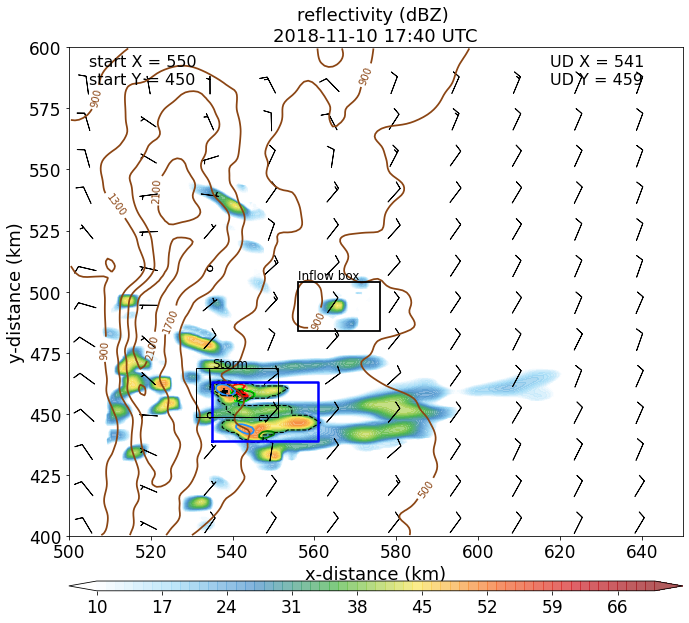

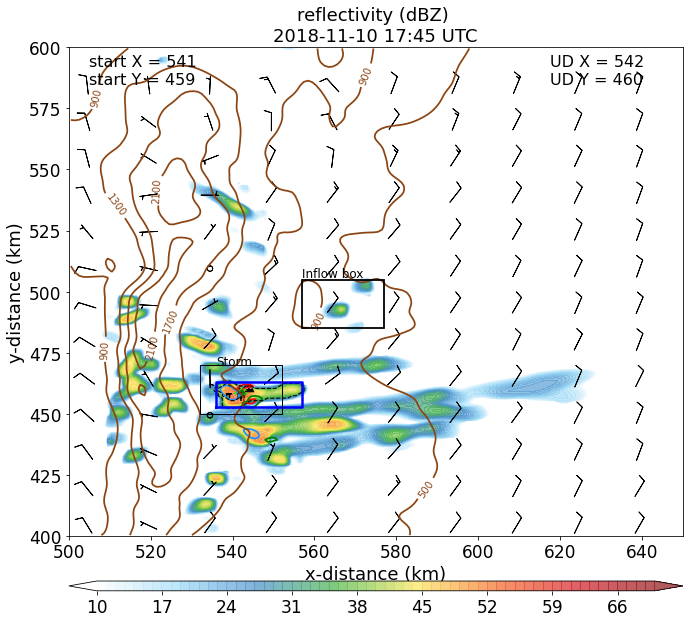

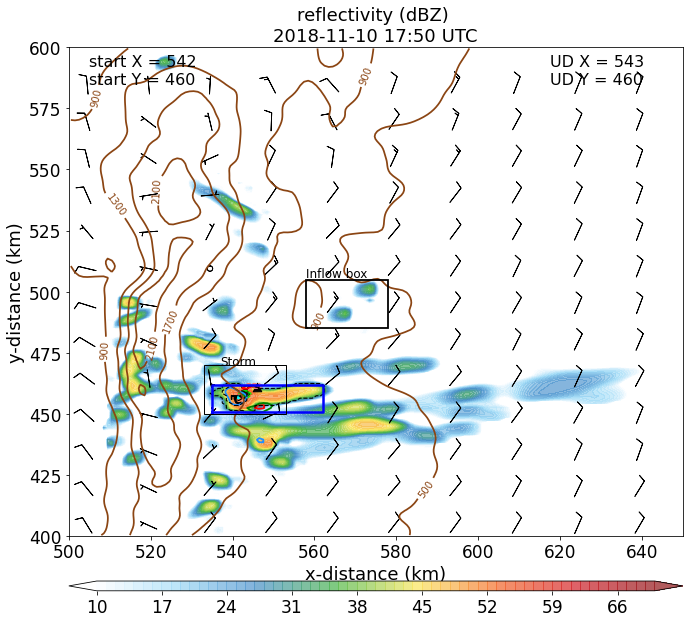

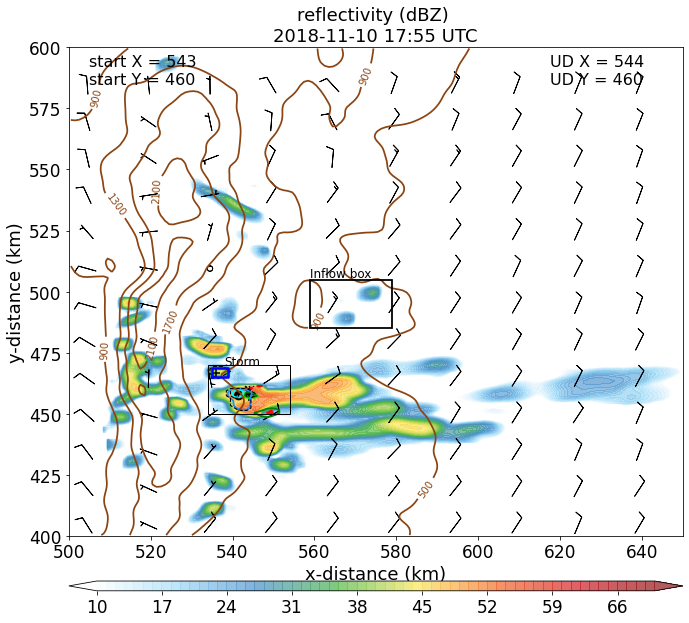

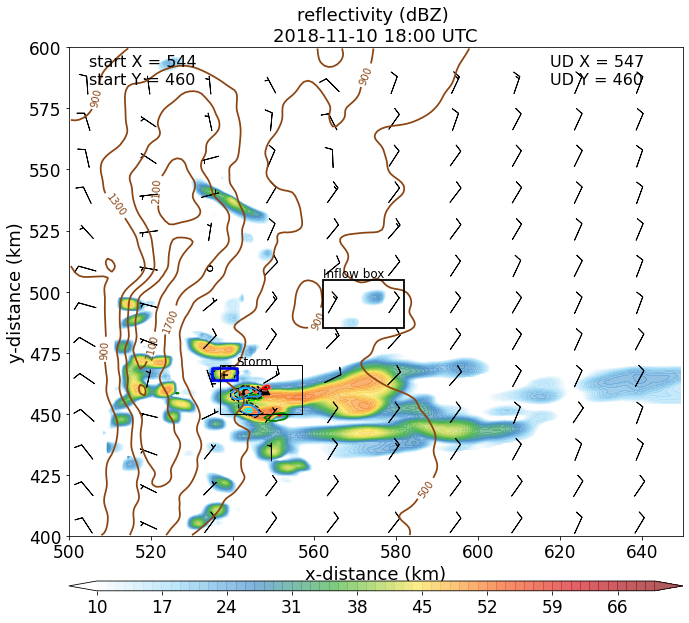

In [19]:
def plot_var(PLOTTING, VARNAME1, VARNAME2, VARNAME3, VARNAME4, SEGM, THRES, AREA, FILE, VAR1_LEVEL, VAR2_LEVEL, VAR3_LEVEL, LINE_CHARAC, IF_DENSITY_WTD, LEVEL1, LEVEL2,
             UL_XIND, UL_YIND, BR_XIND, BR_YIND, CBAR_EXP, MIN_LEV, MAX_LEV, STEP_LEV, NUM_LEVELS, VAR3_LEVELS, VAR3_COLOR, VAR4_LEVELS,
             TITLE, COLORMAP, AX, PLOT_SFC_WINDS, WIND_STYLE, PLOT_REFL, PLOT_UPDRAFT, PLOT_DOWNDRAFT, PLOT_CP, PLOT_MESOCYCLONE, PLOT_RAINRATE, PLOT_REFLECTIVITY_AREA, IS_PANEL_PLOT, XY_labels,
             TRACKING, RUN_NO, START_X, START_Y, BOX_WIDTH, INFLOW, INFLOWBOX_X, INFLOWBOX_Y):

    XR_DARRAY = xr.open_dataset(FILE)
    tiempo = extract_CM1_time(XR_DARRAY)[0]

    if PLOTTING:
        if VARNAME2:
            if VARNAME2 == "thetae":
                prs = XR_DARRAY.variables['prs'][0, VAR2_LEVEL,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
                th = XR_DARRAY.variables['th'][0, VAR2_LEVEL,
                                               BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
                qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                               BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
                temp = mpcalc.temperature_from_potential_temperature(prs, th)
                shum = mpcalc.specific_humidity_from_mixing_ratio(qv)
                dewpt = mpcalc.dewpoint_from_specific_humidity(
                    pressure=prs, temperature=temp, specific_humidity=shum)
                var2 = mpcalc.equivalent_potential_temperature(
                    pressure=prs, temperature=temp, dewpoint=dewpt)
                var2 = xr.DataArray(data=np.array(var2), dims=['nj', 'ni'], attrs={'long_name': 'Equivalent potential temperature',
                                                                                   'units': 'K'})
            elif VARNAME2 == "temperature":
                prs = XR_DARRAY.variables['prs'][0, VAR2_LEVEL,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
                th = XR_DARRAY.variables['th'][0, VAR2_LEVEL,
                                               BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
                qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                               BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
                temp = mpcalc.temperature_from_potential_temperature(prs, th)
                var2 = xr.DataArray(data=np.array(temp), dims=['nj', 'ni'], attrs={'long_name': 'temperature',
                                                                                   'units': 'K'})
            elif VARNAME2 == "w_ud":
                var2 = XR_DARRAY.variables['winterp'][0, 20:80, BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(
                    dim='nk', keep_attrs=True)
                # var2['']
            else:
                print(VARNAME2+' variable found in the dataset')
                if VAR2_LEVEL != None:
                    if VAR2_LEVEL > 113:
                        quantity = XR_DARRAY.variables[VARNAME2][0,
                                                                 :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                        heights = XR_DARRAY.variables['zh'][0,
                                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                        var2 = interplevel(
                            quantity.values, heights.values, VAR2_LEVEL)
                        var2.attrs['long_name'] = 'w'
                        var2.attrs['units'] = 'm/s'
                        # print(var2)
                        #save_string = VARNAME+'_z_'+str(LEVEL)
                        #title_string = var3d.description + ' at '+str(LEVEL)+ ' m (' +var3d.units + ') \n'
                    else:
                        var2 = XR_DARRAY.variables[VARNAME2][0,
                                                             VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                else:
                    var2 = XR_DARRAY.variables[VARNAME2][0,
                                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                    # print(var2.max())

        ############# SEGMENTATION #######################################################################
        # Plot a feature of VAR1
        if SEGM:  
            if VAR1_LEVEL:
                var1 = XR_DARRAY.variables[VARNAME1][0,
                                                     VAR1_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            else:
                var1 = XR_DARRAY.variables[VARNAME1][0,
                                                     BR_YIND:UL_YIND, UL_XIND:BR_XIND]

            IMAGE = var1.values
            bw = closing(IMAGE > THRES, square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)           # label image regions
            #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:
                max_area = max(np.array(areas))
                max_area_ind = areas.index(max(areas))
                max_area_label_coords_array = regions[max_area_ind].coords

                for region in regions:
                    # take regions with large enough areas
                    if region.area >= (max_area-1.0):
                        minr, minc, maxr, maxc = region.bbox

                rows = [uu[0] for uu in max_area_label_coords_array]
                cols = [uu[1] for uu in max_area_label_coords_array]
                neu_arr = np.zeros_like(label_image)  # *np.nan
                # neu_arr[max_area_label_coords]=1.0
                neu_arr[rows, cols] = 1.0
                C_segm = plt.contour(XH, YH, neu_arr, levels=[
                                     1.0], colors='darkblue', linewidths=1.1, linestyles='-', axis=AX)

        # Start plotting var2 here
        if MIN_LEV != None:
            levels = np.arange(MIN_LEV, MAX_LEV, STEP_LEV)
            C1 = plt.contourf(XH, YH, var2, levels=levels,
                              cmap=COLORMAP, extend='both', alpha=0.7)
        else:
            if np.amin(var2) == 0.0 and np.amax(var2) == 0.0:
                C1 = plt.contourf(XH, YH, var2, cmap=COLORMAP, extend='both')
            else:
                C1 = plt.contourf(XH, YH, var2, levels=np.linspace(np.amin(
                    var2).values, np.amax(var2).values, NUM_LEVELS), cmap=COLORMAP, extend='both')
        ##################################
        if VARNAME3:
            if VAR3_LEVEL:
                var3 = XR_DARRAY.variables[VARNAME3][0,
                                                     VAR3_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            else:
                var3 = XR_DARRAY.variables[VARNAME3][0,
                                                     BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            C_var3 = plt.contour(
                XH, YH, var3, levels=VAR3_LEVELS, colors=VAR3_COLOR, linewidths=1.6, axis=AX)
            #AX.clabel(C_var3, C_var3.levels,fmt="%.0f", inline=True, fontsize=9)
        ##################################
        if VARNAME4:
            if VAR4_LEVEL:
                var4 = XR_DARRAY.variables[VARNAME4][0,
                                                     VAR4_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            else:
                var4 = XR_DARRAY.variables[VARNAME4][0,
                                                     BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            C_var4 = plt.contour(XH, YH, var4, levels=VAR4_LEVELS,
                                 colors='k', linewidths=1.3, linestyles='--', axis=AX)
            AX.clabel(C_var4, C_var4.levels, inline=True, fontsize=10)
        ##################################
        if PLOT_SFC_WINDS:
            winds_thin_x = 15
            n = 4
            u10 = XR_DARRAY.variables["u10"][0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND]*1.94384
            v10 = XR_DARRAY.variables["v10"][0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND]*1.94384

            if (WIND_STYLE == 'barbs') or (WIND_STYLE == 'b'):
                AX.barbs(XH[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x], YH[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x],
                         u10[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x], v10[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x], linewidth=0.9, length=6, pivot='middle', flip_barb=True)
            else:
                AX.streamplot(XH, YH, u10, v10, density=1, linewidth=0.9, color='k', cmap=None,
                              norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=None,
                              zorder=None, start_points=None, integration_direction='both', data=None)
        ##################################
        if PLOT_REFL:
            C_refl = plt.contour(XH, YH, XR_DARRAY.variables['dbz'][0, 0, BR_YIND:UL_YIND, UL_XIND:BR_XIND], levels=[35.0], colors='darkblue',
                                 linewidths=2.1, linestyles='--', axis=AX)
        ##################################
        if PLOT_UPDRAFT:
            ud_threshold = 10.0
            w_updraft = XR_DARRAY.variables['winterp'][0, 20:60,
                                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0)
            C6 = plt.contour(XH, YH, w_updraft, levels=[
                             ud_threshold], colors='red', linewidths=1.8, linestyles='-')

            # calculate A_up
            IMAGE = w_updraft
            bw = closing(IMAGE > ud_threshold, square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)                  # label image regions
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:
                print('# # # # # # # # # # # # # # # # # # # # ')
                print('found '+str(len(areas))+' updrafts with areas ', areas)
                print('# # # # # # # # # # # # # # # # # # # # ')

                centroids = [r.centroid for r in regions]

                INITIAL_POSITION = True  # initial starting coordinates

                if INITIAL_POSITION:

                    print('starting position: ', 'X=', START_X, 'Y=', START_Y)
                    AX.text(UL_XIND*1.01, UL_YIND*0.975, 'start X = '+str(UL_XIND +
                            START_X)+'\nstart Y = '+str(BR_YIND+START_Y), fontsize=16)

                    # We are not tracking the largest updraft in the zoomed in domain
                    LARGEST_UD_TRACK = False

                    dist = []  # calculate distances of the centroids of ud from the given point
                    for centt in centroids:
                        centt = np.array((centt))  # convert tuple to np array
                        dist.append(np.linalg.norm(
                            centt - np.array([START_Y, START_X])))

                    ind_closest_ud = np.argmin(np.array(dist))
                    print(
                        'distances of all the detected updrafts from the tracking coords are: ', dist)
                    A_up = areas[ind_closest_ud]
                    print('updraft area = ', A_up, '$km^{2}$')

                    cent_ud = centroids[ind_closest_ud]
                    cent_ud = list(cent_ud)       # convert to list

                    cent_ud[0] = int(cent_ud[0])   # convert to integer
                    cent_ud[1] = int(cent_ud[1])

                    # plot ud centroid
                    AX.scatter(
                        UL_XIND+cent_ud[1], BR_YIND+cent_ud[0], s=73, color='k', marker='x')
                    print('UD position: ', 'X=', UL_XIND +
                          cent_ud[1], 'Y=', BR_YIND+cent_ud[0])
                    AX.text(BR_XIND*0.95, UL_YIND*0.975, 'UD X = '+str(UL_XIND +
                            cent_ud[1])+'\nUD Y = '+str(BR_YIND+cent_ud[0]), fontsize=16)

                    max_area_label_coords_array = regions[ind_closest_ud].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_ud = np.zeros_like(label_image)
                    neu_arr_ud[rows, cols] = 1.0

                    # highlight the chosen updraft to distinguish it from others
                    C60 = plt.contour(XH, YH, neu_arr_ud, levels=[
                                      1.0], colors='lightcoral', linewidths=1.1, linestyles='--')

                    # Rectangle around the ud/storm
                    AX.add_patch(mpl.patches.Rectangle((UL_XIND+cent_ud[1]-10, BR_YIND+cent_ud[0]-10), 20, 20,
                                                       fill=None, lw=1.0, edgecolor='k', zorder=10))

                    AX.text(UL_XIND+cent_ud[1]-6, BR_YIND +
                            cent_ud[0]+10.12, 'Storm', fontsize=12)

                if LARGEST_UD_TRACK:

                    ind_maxarea = argmax(areas)
                    cent_ud = centroids[ind_maxarea]
                    cent_ud = list(cent_maxarea)
                    cent_ud[0] = int(cent_maxarea[0])
                    cent_ud[1] = int(cent_maxarea[1])

                    print('centroid of the largest updraft is located at ',
                          BR_YIND+cent_ud[0], ' ', UL_XIND+cent_ud[1])
                    max_w_area = max(np.array(areas))
                    A_up = max_w_area
                    print('updraft area = ', A_up, 'km^2')
                    max_area_ind = areas.index(max(areas))
                    max_area_label_coords_array = regions[max_area_ind].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_ud = np.zeros_like(label_image)
                    neu_arr_ud_mask = neu_arr_ud
                    neu_arr_ud[rows, cols] = 1.0
                    C60 = plt.contour(XH, YH, neu_arr_ud, levels=[
                                      1.0], colors='lightcoral', linewidths=1.1, linestyles='--')
                    AX.scatter(
                        UL_XIND+cent_ud[1], BR_YIND+cent_ud[0], s=73, color='k', marker='x')

                w_all_levs = XR_DARRAY.variables['winterp'][0,
                                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                # multiply by mask to the updraft in 3D
                temp_w = w_all_levs.values*neu_arr_ud[np.newaxis, :, :]
                wmax = np.amax(temp_w)
                print('max w = ', wmax)
                ind_wmax = np.unravel_index(np.argmax(temp_w), temp_w.shape)
                print('index of wmax is ', ind_wmax)
                AX.scatter(UL_XIND+ind_wmax[2], BR_YIND +
                           ind_wmax[1], s=73, color='k', marker='^')

                # height at which this max velocity is acheived
                z = XR_DARRAY.variables['zhval'][0, :,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                wmax_height = z[ind_wmax[0], ind_wmax[1], ind_wmax[2]].values
                print('height of max velocity: ', wmax_height)

            else:
                A_up = 0.0
                wmax = 0.0
                wmax_height = 0.0
                print('no strong updraft')

        else:
            A_up = np.nan
            wmax = np.nan
            wmax_height = np.nan
            print(' not tracking updraft ')
            
        print(' ')
        ##################################
        ########### DOWNDRAFT  ###########
        ##################################
        if PLOT_DOWNDRAFT:
            down_threshold = -4.0
            w_downdraft = XR_DARRAY.variables['winterp'][0, 20:50,
                                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0)
            C61 = plt.contour(XH, YH, w_downdraft, levels=[
                              down_threshold], colors='blue', linewidths=1.8, linestyles='-')
            # calculate R_dn
            IMAGE = w_downdraft
            bw = closing(IMAGE < down_threshold, square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)           # label image regions
            #C7 = plt.contour(label_image,colors = 'deeppink',linewidths=0.7,linestyles='-', axis=AX)
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:
                CLOSEST_TO_UD = True  # do you wanna choose the downdraft closest to the updraft
                if CLOSEST_TO_UD:
                    centroids = [r.centroid for r in regions]
                    dist = []
                    for centt in centroids:
                        centt = np.array((centt))  # convert tuple to np array
                        dist.append(np.linalg.norm(centt - np.array(cent_ud)))

                    ind_closest_dd = np.argmin(np.array(dist))
                    print(
                        'distances of all the detected downdrafts from the updraft centroid are ', dist)
                    A_dn = areas[ind_closest_dd]
                    print('downdraft area = ', A_dn, '$km^{2}$')

                    max_area_label_coords_array = regions[ind_closest_dd].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_dd = np.zeros_like(label_image)
                    neu_arr_dd_mask = neu_arr_dd
                    neu_arr_dd[rows, cols] = 1.0
                    C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
                                       1.0], colors='k', linewidths=1.1, linestyles='--')

                MIN_W_AREA = False  # do you wanna choose the biggest downdraft
                if MIN_W_AREA:
                    min_w_area = max(np.array(areas))
                    A_dn = min_w_area
                    print('downdraft area = ', A_dn, '$km^{2}$')
                    max_area_ind = areas.index(max(areas))
                    max_area_label_coords_array = regions[max_area_ind].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_dd = np.zeros_like(label_image)
                    neu_arr_dd_mask = neu_arr_dd
                    neu_arr_dd[rows, cols] = 1.0
                    C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
                                       1.0], colors='deepskyblue', linewidths=1.1, linestyles='--')
            else:
                A_dn = 0.0
                print('no strong downdraft')

        else:
            A_dn = np.nan
            print('not tracking downdraft')
        ##################################
        ########### MESOCYCLONE  #########
        ##################################
        if PLOT_MESOCYCLONE:
            uh_threshold = 50.
            uh_zoom = XR_DARRAY.variables['uh'][0,
                                                BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            C62 = plt.contour(XH, YH, uh_zoom, levels=[
                              uh_threshold], colors='green', linewidths=1.8, linestyles='-')
            # Calculate R_meso
            IMAGE = uh_zoom
            bw = closing(IMAGE > uh_threshold, square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)           # label image regions
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:

                CLOSEST_TO_UD = True  # do you wanna choose the downdraft closest to the updraft
                if CLOSEST_TO_UD:
                    centroids = [r.centroid for r in regions]
                    dist = []
                    for centt in centroids:
                        centt = np.array((centt))  # convert tuple to list
                        dist.append(np.linalg.norm(centt - np.array(cent_ud)))

                    if (np.min(np.array(dist)) < 15.0):  # if the mesocyclone is close to the UD
                        ind_closest_uh = np.argmin(np.array(dist))
                        print(
                            'distances of all the detected mesocyclones from the updraft centroid are ', dist)
                        A_meso = areas[ind_closest_uh]
                        print('mesocyclone area = '+str(A_meso)+' km^2')

                        max_area_label_coords_array = regions[ind_closest_uh].coords
                        rows = [uu[0] for uu in max_area_label_coords_array]
                        cols = [uu[1] for uu in max_area_label_coords_array]
                        neu_arr_uh = np.zeros_like(label_image)
                        neu_arr_uh[rows, cols] = 1.0
                        C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
                                           1.0], colors='lime', linewidths=1.1, linestyles='--')

                        temp_uh = uh_zoom.values*neu_arr_uh[:, :]
                        uh_max = np.amax(temp_uh)
                        print('max uh = ', uh_max)
                        ind_uhmax = np.unravel_index(
                            np.argmax(temp_uh), temp_uh.shape)
                        print('index of uh max is ', ind_uhmax)
                        AX.scatter(
                            UL_XIND+ind_uhmax[1], BR_YIND+ind_uhmax[0], s=73, color='k', marker='+')

                    else:                            # if not, it doesn't exist for our purposes
                        A_meso = 0.0
                        uh_max = 0.0
                        print('no strong mesocyclone')

                else:
                    max_uh_area = max(np.array(areas))
                    A_meso = max_uh_area
                    print('mesocyclone area = '+str(A_meso)+' $km^{2}$')
                    max_area_ind = areas.index(max(areas))
                    max_area_label_coords_array = regions[max_area_ind].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_uh = np.zeros_like(label_image)
                    neu_arr_uh[rows, cols] = 1.0
                    C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
                                       1.0], colors='lime', linewidths=1.1, linestyles='--')

                    temp_uh = uh_zoom.values*neu_arr_uh[:, :]
                    uh_max = np.amax(temp_uh)
                    print('max uh = ', uh_max)
                    ind_uhmax = np.unravel_index(
                        np.argmax(temp_uh), temp_uh.shape)
                    print('index of uh max is ', ind_uhmax)
                    AX.scatter(
                        UL_XIND+ind_uhmax[1], BR_YIND+ind_uhmax[0], s=73, color='k', marker='+')

            else:
                A_meso = 0.0
                uh_max = 0.0
                print('no strong mesocyclone')
                
        ###################################
        if PLOT_REFLECTIVITY_AREA:
            dbz_threshold = 35.
            dbz_zoom = XR_DARRAY.variables['dbz'][0, 0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            #C_30dbz = plt.contour(XH, YH, dbz_zoom, levels = [dbz_threshold], colors='k', linewidths=1.8, linestyles='-')
            
            # Calculate A_dbz
            IMAGE = dbz_zoom
            bw = closing(IMAGE > dbz_threshold, square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)           # label image regions
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:

                CLOSEST_TO_UD = True  # do you wanna choose the feature closest to the updraft
                if CLOSEST_TO_UD:
                    centroids = [r.centroid for r in regions]
                    dist = []
                    for centt in centroids:
                        centt = np.array((centt))  # convert tuple to list
                        dist.append(np.linalg.norm(centt - np.array(cent_ud)))

                    if (np.min(np.array(dist)) < 15.0):  # if the 30-dbz refl. contour is close to the UD
                        ind_closest_dbz = np.argmin(np.array(dist))
                        print('distances of all the detected 30-dbz contour from the updraft centroid are ', dist)
                        A_dbz = areas[ind_closest_dbz]
                        print('30-dbz reflectivity contour area = '+str(A_dbz)+' km^2')

                        max_area_label_coords_array = regions[ind_closest_dbz].coords
                        rows = [uu[0] for uu in max_area_label_coords_array]
                        cols = [uu[1] for uu in max_area_label_coords_array]
                        neu_arr_dbz = np.zeros_like(label_image)
                        neu_arr_dbz[rows, cols] = 1.0
                        C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[
                                           1.0], colors='k', linewidths=1.1, linestyles='--')
                        
                        
                        # create a  rectangle around the reflectivity contour
                        region_of_interest = regions[ind_closest_dbz]
                        minr, minc, maxr, maxc = region_of_interest['BoundingBox']
                        bx = (minc, maxc, maxc, minc, minc)
                        by = (minr, minr, maxr, maxr, minr)
                        print('reflectivity bounding box x = ',bx)
                        print('reflectivity bounding box y = ',by)
                        plt.plot(np.array(bx) + UL_XIND, np.array(by) + BR_YIND, '-b', linewidth=2.5) # plot the rectangle
                        
                        # get the max dimension of the rectangle
                        l_refl = max(abs(maxr-minr),abs(maxc-minc))
                        print('max dimension of the ref contour is ',l_refl,' km')

                        temp_dbz = dbz_zoom.values*neu_arr_dbz[:, :]
                        dbz_max = np.amax(temp_dbz)
                        print('max dbz = ', dbz_max)
                        ind_dbzmax = np.unravel_index(np.argmax(temp_dbz), temp_dbz.shape)
                        print('index of dbz max is ', ind_dbzmax)
                        AX.scatter(
                            UL_XIND+ind_dbzmax[1], BR_YIND+ind_dbzmax[0], s=73, color='k', marker='+')

                    else:                            # if not, it doesn't exist for our purposes
                        A_dbz = 0.0
                        dbz_max = 0.0
                        l_refl = 0.0
                        print('no 30-dbz contours')

                else:
                    max_dbz_area = max(np.array(areas))
                    A_dbz = max_dbz_area
                    print('30-dbz reflectivity area = '+str(A_dbz)+' $km^{2}$')
                    max_area_ind = areas.index(max(areas))
                    max_area_label_coords_array = regions[max_area_ind].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_dbz = np.zeros_like(label_image)
                    neu_arr_dbz[rows, cols] = 1.0
                    C62011 = plt.contour(XH, YH, neu_arr_dbz, levels=[
                                       1.0], colors='lime', linewidths=1.1, linestyles='--')

                    temp_dbz = dbz_zoom.values*neu_arr_dbz[:, :]
                    dbz_max = np.amax(temp_dbz)
                    print('max dbz = ', dbz_max)
                    ind_dbzmax = np.unravel_index(
                        np.argmax(temp_dbz), temp_dbz.shape)
                    print('index of dbz max is ', ind_dbzmax)
                    AX.scatter(
                        UL_XIND+ind_dbzmax[1], BR_YIND+ind_dbzmax[0], s=73, color='k', marker='+')

            else:
                A_dbz = 0.0
                dbz_max = 0.0
                l_refl = 0.0
                print('no 30-dbz contours') 
        print(' ')
        ##################################
        ########### COLD POOL  ###########
        ##################################
        if PLOT_CP:
            Rv = 461.5
            Rd = 287.04
            theta_anomaly_threshold = -5.
            th = XR_DARRAY.variables['th'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('Pa')
            qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('K')
            # *munits('kg/kg')
            qc = XR_DARRAY.variables['qc'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
            # *munits('kg/kg')
            qr = XR_DARRAY.variables['qr'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
            ql = qc + qr
            theta_rho = th*(1.0 + ((Rv/Rd) - 1.0)*qv - ql)
            theta_rho = xr.DataArray(data=np.array(theta_rho), dims=['nj', 'ni'], attrs={'long_name': 'density potential temperature',
                                                                                         'units': 'K'})
            theta_rho_domain = xr.DataArray(data=np.array(theta_rho), dims=['nj', 'ni'], attrs={'long_name': 'density potential temperature',
                                                                                                'units': 'K'}).mean()
            theta_anomaly = theta_rho - theta_rho_domain
            # print(theta_anomaly)
            C7 = plt.contour(XH, YH, theta_anomaly, levels=[
                             theta_anomaly_threshold], colors='aqua', linewidths=1.8, linestyles='-')
            ##### calculate area of the cold pool ######
            IMAGE = theta_anomaly.values
            bw = closing(IMAGE < theta_anomaly_threshold,
                         square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)           # label image regions
            #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:
                max_area_cp = max(np.array(areas))
                print(' area of the largest cold pool is ', max_area_cp, ' km^2')

                CLOSEST_TO_UD = True  # do you wanna choose the downdraft closest to the updraft
                if CLOSEST_TO_UD:
                    centroids = [r.centroid for r in regions]
                    dist = []
                    for centt in centroids:
                        centt = np.array((centt))  # convert tuple to list
                        dist.append(np.linalg.norm(centt - np.array(cent_ud)))

                    ind_closest_cp = np.argmin(np.array(dist))
                    print(
                        'distances of all the detected cold pools from the updraft centroid are ', dist)
                    A_cp = areas[ind_closest_cp]
                    print('cold pool area = '+str(A_cp)+' km^2')
                    print()

                    max_area_label_coords_array = regions[ind_closest_cp].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_cp = np.zeros_like(label_image)
                    neu_arr_cp[rows, cols] = 1.0
                    C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[
                                        1.0], colors='k', linewidths=1.1, linestyles='--')

                    # get the min density theta and plot it
                    temp_cp = theta_anomaly.values*neu_arr_cp[:, :]
                    cp_min = np.amin(temp_cp)
                    print('min theta anomaly = ', cp_min)
                    ind_cpmin = np.unravel_index(
                        np.argmin(temp_cp), temp_cp.shape)
                    print('index of cp min is ', ind_cpmin)
                    AX.scatter(
                        UL_XIND+ind_cpmin[1], BR_YIND+ind_cpmin[0], s=73, color='k', marker='$c$')

                    # get the centroid of the cold pool and plot it
                    cent_cp = centroids[ind_closest_cp]
                    cent_cp = list(cent_ud)

                    cent_cp[0] = int(cent_cp[0])  # convert to integer
                    cent_cp[1] = int(cent_cp[1])
                    AX.scatter(
                        UL_XIND+cent_cp[1], BR_YIND+cent_cp[0], s=73, color='k', marker='x')

                    ##############################
                    # buoyancy-based calculations #

                    # get the buoyancy: calculate the area (again) and height of the cold pool
                    buo_all_levs = XR_DARRAY.variables['buoyancy'][0,
                                                                   0:60, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                    #C_bouy           = plt.contour(XH,YH,buo_all_levs[0,:,:],levels=[-0.1],colors='aquamarine',linewidths=1.1,linestyles='--')
                    temp_buoy = buo_all_levs.values * \
                        neu_arr_cp[np.newaxis, :, :]
                    buoy_min = np.amin(temp_buoy)
                    print('min buoyancy = ', buoy_min)

                    ind_buoy_min = np.unravel_index(
                        np.argmin(temp_buoy), temp_buoy.shape)
                    print('index of min  is buoyancy ', ind_buoy_min)
                    # AX.scatter(UL_XIND+ind_buoy_min[2],BR_YIND+ind_buoy_min[1],s=73,color='k',marker='$b$')

                    z_11 = XR_DARRAY.variables['zhval'][0, 0:60,
                                                        BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
                    buoy_min_height = z_11[ind_buoy_min[0],
                                           ind_buoy_min[1], ind_buoy_min[2]]
                    print('height of min buoyancy is ', buoy_min_height)

            else:
                max_area_cp = 0.0
                A_cp = 0.0
                buoy_min_height = 0.0
                buoy_min = 0.0
                cp_min = 0.0
                print('no cold pool detected for the tracked updraft')

        else:
            A_cp = np.nan
            buoy_min_height = 0.0
            buoy_min = 0.0
            cp_min = 0.0
            print('cold pool not tracked')
        print(' ')
    ##################################
    ########### RAIN RATE  ###########
    ##################################
        if PLOT_RAINRATE:

            current_file_basename = os.path.basename(FILE)
            print('using current file ', current_file_basename)
            prev_fil_no = str(int(current_file_basename.split(
                '_')[1].split('.')[0].lstrip('0'))-1).zfill(6)
            prev_fil_search_string = 'cm1out_'+prev_fil_no+'.nc'
            prev_fil = sorted(glob.glob(direc_list[0]+prev_fil_search_string))
            print('using previous file ', prev_fil)
            XR_DARRAY2 = xr.open_dataset(prev_fil[0])

            rr_threshold = 40.0
            rain_temp1 = XR_DARRAY.variables['rain'][0,
                                                     BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            #print('rain : ',rain_temp1)
            rain_temp2 = XR_DARRAY2.variables['rain'][0,
                                                      BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            rr = (rain_temp1 - rain_temp2)*10.*60./5.
            rr.attrs['long_name'] = 'rain rate'
            rr.attrs['units'] = 'mm/hr'
            C_rr = plt.contour(XH, YH, rr, levels=[
                               rr_threshold], colors='dodgerblue', linewidths=1.8, linestyles='-')

            IMAGE = rr.values
            bw = closing(IMAGE > rr_threshold, square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)           # label image regions
            #C7 = plt.contour(label_image,colors = 'deeppink',linewidths=0.7,linestyles='-', axis=AX)
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:
                CLOSEST_TO_UD = True  # do you wanna choose the downdraft closest to the updraft
                if CLOSEST_TO_UD:
                    centroids = [r.centroid for r in regions]
                    dist = []
                    for centt in centroids:
                        centt = np.array((centt))  # convert tuple to np array
                        dist.append(np.linalg.norm(centt - np.array(cent_ud)))

                    # if the mesocyclone is close enough (dist b/w UH centroid and UD centroid < 15 kms)
                    if (np.min(np.array(dist)) < 15.0):
                        ind_closest_rr = np.argmin(np.array(dist))
                        print(
                            'distances of all the detected rainrate contours from the updraft centroid are ', dist)
                        A_rr = areas[ind_closest_rr]
                        print('rainrate contour area = ', A_rr, '$km^{2}$')

                        max_area_label_coords_array = regions[ind_closest_rr].coords
                        rows = [uu[0] for uu in max_area_label_coords_array]
                        cols = [uu[1] for uu in max_area_label_coords_array]
                        neu_arr_rr = np.zeros_like(label_image)
                        neu_arr_rr[rows, cols] = 1.0
                        plt.contour(XH, YH, neu_arr_rr, levels=[
                                    1.0], colors='k', linewidths=1.1, linestyles='--')

                        # calculate max instantaneous rain rate for storing
                        temp_rr = rr.values*neu_arr_rr[:, :]
                        rr_max = np.amax(temp_rr)
                        print('max rr = ', rr_max)
                        ind_rrmax = np.unravel_index(np.argmax(temp_rr), temp_rr.shape)
                        print('index of rr max is ', ind_rrmax)
                        AX.scatter(
                            UL_XIND+ind_rrmax[1], BR_YIND+ind_rrmax[0], s=33, color='k', marker='$rr$')

                    else:
                        A_rr = 0.0
                        rr_max = 0.0
                        print('no large rainrate contours')

            else:
                A_rr = 0.0
                rr_max = 0.0
                print('no large rainrate contours')

        else:
            A_rr = np.nan
            rr_max = 0.0
            print('not tracking rainrate')
        print(' ')
        #############################
        # Plot terrain
        #############################
        levels_zs = np.arange(500, 2700, 400)
        C_terr = plt.contour(XH, YH, zs[0, BR_YIND:UL_YIND, UL_XIND:BR_XIND],
                             levels=levels_zs, colors="saddlebrown", linewidths=1.75, linestyles='-')
        AX.clabel(C_terr, C_terr.levels, inline=True, fmt="%.0f", fontsize=10)
        ##################################
        if TITLE:
            title = TITLE
        elif (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == 'rhowtd'):
            title = var2.attrs['long_name']
        else:
            if VAR2_LEVEL:
                if VAR2_LEVEL > 110:
                    title = var2.attrs['long_name'] + \
                        " at height "+str(VAR2_LEVEL)+' m'
                else:
                    title = var2.attrs['long_name'] + \
                        " at model level "+str(VAR2_LEVEL)
            else:
                title = var2.attrs['long_name']
        prodid = VARNAME2+'_zoom'  # var1.long_name
        units = var2.attrs['units']  # var1.units'

    # AX.hlines(500,xmin=UL_XIND+5,xmax=BR_XIND-5)
    # AX.vlines(505,ymin=BR_YIND+5,ymax=UL_YIND-5)
    #fig_process_horiz(C1, C4,CBAR_EXP,False,title,extract_CM1_time(XR_DARRAY)[0],extract_CM1_time(XR_DARRAY)[1],prodid, units, IS_PANEL_PLOT, XY_labels)
    # plt.close()
    if TRACKING:
        if TRACKING == 'W':
            print('  ')
            print('tracking the wmax point...')
            print('  ')
            ##################################################################################################
            print('RUN_NO', RUN_NO)
            # print(START_X)
            # print(START_Y)

            # First guess location of the updraft
            AX.add_patch(mpl.patches.Rectangle((UL_XIND+START_X, BR_YIND+START_Y), BOX_WIDTH, BOX_WIDTH,
                                               fill=None, lw=1.8, edgecolor='k', ls='--', zorder=10))
            wa = XR_DARRAY.variables['winterp'][0, 20:60,
                                                BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0)
            wa1 = XR_DARRAY.variables['winterp'][0, 20:50,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0)
            uh = XR_DARRAY.variables['uh'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            t2 = XR_DARRAY.variables['t2'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            terr_hgt = XR_DARRAY.variables['zs'][0,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            p = XR_DARRAY.variables['prs'][0, :,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            th = XR_DARRAY.variables['th'][0, :,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            qv = XR_DARRAY.variables['qv'][0, :,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            z = XR_DARRAY.variables['zhval'][0, :,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            ua = XR_DARRAY.variables['uinterp'][0,
                                                :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            va = XR_DARRAY.variables['vinterp'][0,
                                                :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            temp = mpcalc.temperature_from_potential_temperature(
                p.values*munits('Pa'), th.values*munits('K'))
            temp = temp.to('degC')
            # print(temp)
            tc = xr.DataArray(data=np.array(temp), dims=['nk', 'nj', 'ni'], attrs={
                              'long_name': 'temperature', 'units': 'deg C'})
            # print(tc)
            #tc = XR_DARRAY.variables['uh'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            tem = mpcalc.dewpoint_from_specific_humidity(pressure=p.values*munits('Pa'), temperature=temp,
                                                         specific_humidity=qv.values*munits('kg/kg'))
            # print(tem)
            td = xr.DataArray(data=np.array(tem), dims=['nk', 'nj', 'ni'], attrs={
                              'long_name': 'dewpoint temperature', 'units': 'deg C'})
            # print(td)
            #qc = XR_DARRAY.variables['qc'][0,20:80,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            #qi = XR_DARRAY.variables['qi'][0,20:80,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            #z = XR_DARRAY.variables['z'][0,20:80,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            # print(wa)
            w_temp = wa[START_Y:(START_Y+BOX_WIDTH),
                        START_X:(START_X+BOX_WIDTH)].values
            w_down_temp = wa1[START_Y:(
                START_Y+BOX_WIDTH), START_X:(START_X+BOX_WIDTH)].values
            uh_temp = uh[START_Y:(START_Y+BOX_WIDTH),
                         START_X:(START_X+BOX_WIDTH)].values
            #qc_temp    =  qc [:,START_Y:START_Y+BOX_WIDTH,START_X:START_X+BOX_WIDTH].values
            #qi_temp    =  qi [:,START_Y:START_Y+BOX_WIDTH,START_X:START_X+BOX_WIDTH].values
            #te_temp    =  the[:,START_Y:START_Y+BOX_WIDTH,START_X:START_X+BOX_WIDTH].values
            #z_temp     =  z  [:,START_Y:START_Y+BOX_WIDTH,START_X:START_X+BOX_WIDTH].values
            print('shape of wa (zoomed in map) = ', np.shape(wa))
            print('shape of w_temp (tracking box) = ', np.shape(w_temp))
            # Get their max values
            wmax = w_temp.max()
            print('wmax = ', wmax)
            uh_max = uh_temp.max()  # negative UH in SH
            print('uhmax = ', uh_max)
            #qc_max  = qc_temp.max()
            #print('qcmax = ',qc_max)
            #qi_max  = qi_temp.max()
            #print('qimax = ',qi_max)
            #te_max  = te_temp.max()
            #print('temax = ',te_max)

            # get the indices of the max values
            ind_wmax = np.unravel_index(w_temp.argmax(),   w_temp.shape)
            print('indices of max w : ', ind_wmax)
            ind_uhmax = np.unravel_index(
                uh_temp.argmin(), uh_temp.shape)  # negative values in SH
            #print('indices of max uh : ',ind_uhmax)
            #ind_qcmax=np.unravel_index(qc_temp.argmax(), qc_temp.shape)
            ##print('indices of max qc : ',ind_qcmax)
            #ind_qimax=np.unravel_index(qi_temp.argmax(), qi_temp.shape)
            #print('indices of max qi : ',ind_qimax)
            #ind_temax=np.unravel_index(te_temp.argmax(), te_temp.shape)
            #print('indices of max qi : ',ind_qimax)

            # find the heights where those max values are obtained
            #wmax_height = z_temp [ind_wmax[0],ind_wmax[1],ind_wmax[2]]
            #qcmax_height= z_temp[ind_qcmax[0],ind_qcmax[1],ind_qcmax[2]]
            #qimax_height= z_temp[ind_qimax[0],ind_qimax[1],ind_qimax[2]]
            #temax_height= z_temp[ind_temax[0],ind_temax[1],ind_temax[2]]
            ##################################################################################################
            AX.scatter(
                UL_XIND+START_X+ind_wmax[1], BR_YIND+START_Y+ind_wmax[0], s=73, color='k', marker='^')
            AX.scatter(UL_XIND+START_X+ind_uhmax[1], BR_YIND+START_Y +
                       ind_uhmax[0], s=37, color='k', marker='X', facecolor='none')
            ##################################################################################################

        elif TRACKING == 'C':
            print('  ')
            if INITIAL_POSITION:
                str_temp = 'a certain chosen'
            else:
                str_temp = 'the largest'
            print('tracking the centroid of '+str_temp+' updraft...')
            print('  ')

            t2 = XR_DARRAY.variables['t2'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            terr_hgt = XR_DARRAY.variables['zs'][0,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            p = XR_DARRAY.variables['prs'][0, :,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            th = XR_DARRAY.variables['th'][0, :,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            qv = XR_DARRAY.variables['qv'][0, :,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            ua = XR_DARRAY.variables['uinterp'][0,
                                                :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            va = XR_DARRAY.variables['vinterp'][0,
                                                :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            temp = mpcalc.temperature_from_potential_temperature(
                p.values*munits('Pa'), th.values*munits('K'))
            temp = temp.to('degC')
            tc = xr.DataArray(data=np.array(temp), dims=['nk', 'nj', 'ni'], attrs={
                              'long_name': 'temperature', 'units': 'deg C'})
            tem = mpcalc.dewpoint_from_specific_humidity(pressure=p.values*munits('Pa'), temperature=temp,
                                                         specific_humidity=qv.values*munits('kg/kg'))
            td = xr.DataArray(data=np.array(tem), dims=['nk', 'nj', 'ni'], attrs={
                              'long_name': 'dewpoint temperature', 'units': 'deg C'})

        if INFLOW:
            INFLOW_DIST_X = 15
            INFLOW_DIST_Y = 25
            print('calculating inflow properties')

            if INFLOW == 'W':
                print('... with wmax')
                track_pt_x = ind_wmax[1]
                track_pt_y = ind_wmax[0]

                AX.add_patch(mpl.patches.Rectangle((UL_XIND+track_pt_x+INFLOW_DIST_X, BR_YIND+track_pt_y+INFLOW_DIST_Y), INFLOWBOX_X, INFLOWBOX_Y,
                                                   fill=None, lw=1.8, edgecolor='k', zorder=10))

                t2_inflow = t2[(track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(0, 1)).values

                p_inflow = p[:,  (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                             (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                z_inflow = z[:,  (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                             (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                ua_inflow = ua[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                va_inflow = va[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                tc_inflow = tc[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                td_inflow = td[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                terr_inflow = terr_hgt[(track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                                       (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(0, 1)).values

                snd_array = np.column_stack(
                    (p_inflow/100., z_inflow, tc_inflow, td_inflow, ua_inflow, va_inflow))

            elif INFLOW == 'C':
                print('... with the centroid of the updraft')
                track_pt_x = cent_ud[1]
                track_pt_y = cent_ud[0]

                AX.add_patch(mpl.patches.Rectangle((UL_XIND+track_pt_x+INFLOW_DIST_X, BR_YIND+track_pt_y+INFLOW_DIST_Y), INFLOWBOX_X, INFLOWBOX_Y,
                                                   fill=None, lw=1.8, edgecolor='k', zorder=10))

                AX.text((UL_XIND+track_pt_x+INFLOW_DIST_X), (BR_YIND+track_pt_y +
                        INFLOW_DIST_Y+INFLOWBOX_Y)*1.002, 'Inflow box', fontsize=12)

                t2_inflow = t2[(track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(0, 1)).values

                p_inflow = p[:,  (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                             (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                z_inflow = z[:,  (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                             (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                ua_inflow = ua[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                va_inflow = va[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                tc_inflow = tc[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                td_inflow = td[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                terr_inflow = terr_hgt[(track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                                       (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(0, 1)).values

                snd_array = np.column_stack(
                    (p_inflow/100., z_inflow, tc_inflow, td_inflow, ua_inflow, va_inflow))

            else:
                print('Please choose UH or W for the inflow box')
                p_inflow = np.nan
                z_inflow = np.nan
                ua_inflow = np.nan
                va_inflow = np.nan
                tc_inflow = np.nan
                td_inflow = np.nan
                terr_inflow = np.nan

        if TRACKING == 'W':
            upd_xpos = ind_wmax[1]
            upd_ypos = ind_wmax[0]
            abs_upd_xpos = UL_XIND + START_X + upd_xpos
            abs_upd_ypos = BR_YIND + START_Y + upd_ypos
            start_x_out = START_X + upd_xpos - int(BOX_WIDTH/2)
            start_y_out = START_Y + upd_ypos - int(BOX_WIDTH/2)

        elif TRACKING == 'C':
            upd_xpos = cent_ud[1]
            upd_ypos = cent_ud[0]
            abs_upd_xpos = UL_XIND + cent_ud[1]
            abs_upd_ypos = BR_YIND + cent_ud[0]
            start_x_out = cent_ud[1]
            start_y_out = cent_ud[0]
        #print('Lower left corner of the next box (x,y): ',start_x_out,start_y_out)
        inflow_array = np.array([tiempo, wmax, wmax_height, A_up, A_dn, uh_max, A_meso, A_cp, cp_min,
                                A_rr, rr_max, buoy_min, buoy_min_height, A_dbz, dbz_max, l_refl, abs_upd_xpos, abs_upd_ypos, terr_inflow])
        ##################################################################################################
    fig_process_horiz(C1, C_terr, CBAR_EXP, False, title, extract_CM1_time(XR_DARRAY)[
                      0], extract_CM1_time(XR_DARRAY)[1], prodid, units, IS_PANEL_PLOT, XY_labels)
    print('time is :', tiempo)
    return start_x_out, start_y_out, inflow_array, snd_array, terr_inflow, tiempo
    #####################################################################################################


SDC_terrain = True
if SDC_terrain:
    ul_xind1 = 500  # upper left corner x#520
    ul_yind1 = 600  # upper left corner y720
    br_xind1 = 650  # bottom right corner x700
    br_yind1 = 400  # bottom right corner y#450
else:
    ul_xind1 = 0  # upper left corner x#520
    ul_yind1 = nj-1  # upper left corner y720
    br_xind1 = ni-1  # bottom right corner x700
    br_yind1 = 0  # bottom right corner y#450

XH, YH = np.meshgrid(xh[ul_xind1:br_xind1], yh[br_yind1:ul_yind1])

run_this_func = True


cma1 = plt.get_cmap('bwr')
cma2 = coltbls.reflect()
cma3 = plt.get_cmap('tab20c')
cma4 = ncm.cmap("WhiteBlueGreenYellowRed")
cma5 = plt.get_cmap('gray_r')

if run_this_func:
    run_no = 1
    # start_x= 50#50#40  75_LLJ: start_x=50
    # start_y= 50#60#30  75_LLJ: start_x=15
    terr_list = []
    track_list = []
    snd_list = []
    times = []

    experiments = ['stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km']  # expanse

    for exp in experiments:
        direc_list = []
        #direc_list.append("/home1/04167/tg834661/scratch/"+exp+"/") #stampede2
        direc_list.append("/home/isingh9/scratch/temp_project/"+exp+"/")  # expanse
        fi_list = []
        # fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_000109.nc")) +\
        #               sorted(glob.glob(direc_list[0]+"cm1out_00011?.nc")))# +\
        # sorted(glob.glob(direc_list[0]+"cm1out_00012[0-6].nc")))

        if exp == 'stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km':
            # supercell # 2
            fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_00013?.nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_0001[4-6]?.nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_00017[0-1].nc")))

            start_x = 50  # 50#40  75_LLJ: start_x=50
            start_y = 70

        if exp == 'stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km':
            fi_list.append(
                sorted(glob.glob(direc_list[0]+"cm1out_00007[5-9].nc")))# +\
                #sorted(glob.glob(direc_list[0]+"cm1out_00008[0-9].nc")) +\
                #sorted(glob.glob(direc_list[0]+"cm1out_00009[0-9].nc")) +\
                #sorted(glob.glob(direc_list[0]+"cm1out_0001[0-3]?.nc" )))

            start_x = 50  # 50#40  75_LLJ: start_x=50
            start_y = 50

        if exp == 'stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km':
            fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_00007[5-9].nc")) +\
                           sorted(glob.glob(direc_list[0]+"cm1out_0008[0-9]?.nc")) +\
                           sorted(glob.glob(direc_list[0]+"cm1out_0009[0-9]?.nc")) +\
                           sorted(glob.glob(direc_list[0]+"cm1out_001[0-3]?.nc")))

            start_x = 50  # 50#40  75_LLJ: start_x=50
            start_y = 50

        if exp == 'stampede_cm1_20.3_RW_LLJ_66_percent_reduced_1km':
            fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_0001[2-3]?.nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_00014[0-5].nc")))  # +\
            # sorted(glob.glob(direc+"cm1out_0009[0-9]?.nc")) +\
            # sorted(glob.glob(direc+"cm1out_001[0-3]?.nc" )))

            start_x = 75  # 50#40  75_LLJ: start_x=50
            start_y = 120

        print(fi_list)
        
        print('')
        print('time range : ',extract_CM1_time(xr.open_dataset(fi_list[0][0]))[0],' to ',extract_CM1_time(xr.open_dataset(fi_list[0][-1]))[0])
        print(' ')
        ###################### START OF FILE LOOP #########################
        for some in range(min([len(x) for x in fi_list])):
            print(' ')

            fig = plt.figure(figsize=(11, 10), frameon=False)  # (16,11)
            plt.xlim([ul_xind1, br_xind1])
            plt.ylim([br_yind1, ul_yind1])

            ax_1 = subplot(1, len(fi_list), 1)

            # PLOTTING,VARNAME1,VARNAME2,VARNAME3,VARNAME4,
            # SEGM,THRES,AREA,
            # FILE,VAR1_LEVEL,VAR2_LEVEL,VAR3_LEVEL,
            # LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,\
            # UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,VAR3_LEVELS,VAR3_COLOR,VAR4_LEVELS,\
            # TITLE,COLORMAP,AX,
            # PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,PLOT_UPDRAFT,PLOT_DOWNDRAFT,PLOT_CP,PLOT_MESOCYCLONE,PLOT_RAINRATE,IS_PANEL_PLOT,XY_labels,\
            # TRACKING,RUN_NO,START_X,START_Y,BOX_WIDTH,
            # INFLOW,INFLOWBOX_X,INFLOWBOX_Y)

            element = 'dbz'
            # element='buoyancy'
            start_x1, start_y1, tracki, sndi, terri, out_time = plot_var(True, "winterp", element, None, None,
                                                                         False, 0.7, 100,
                                                                         fi_list[0][some], None, 0, None,
                                                                         'max', "NO", 0, 15,
                                                                         ul_xind1, ul_yind1, br_xind1, br_yind1,
                                                                         0, 10, 71, 1, 20, [
                                                                             3], 'green', np.arange(0, .024, .002),
                                                                         None, cma4, ax_1,
                                                                         True, 'barbs', False, True, True, True, True, True, True, True, True,
                                                                         'C', run_no, start_x, start_y, 16,
                                                                         'C', 20, 20)

            start_x = start_x1
            start_y = start_y1
            filename = exp+'_CENTROID_1000_ZOOMED_TRACKING_INITIAL_rainrate_' + \
                element+'_'+out_time.replace(" ", "_")+'.png'
            print(filename)
            plt.savefig(filename, dpi=250)
            # plt.close()

            run_no = run_no+1
            terr_list.append(terri)
            track_list.append(tracki)
            snd_list.append(sndi)
            times.append(out_time)
            print(
                '------------------------------------------------------------------------------------')
        ###################### END OF FILE LOOP ##########################

# if post_processing = True, all the tracking data is stores in npy and csv files along with .png
# files of tracking. If False, only png files are produced.

post_processing = False

if post_processing:

    # string identifier used in the filenames for csv files
    post_data_string = 'CM1_CENTROID_INITIAL_rainrate'

    track_data = np.array(track_list)
    snd_data = np.array(snd_list)

    times_neu = pd.to_datetime(times)
    save_timestring = times_neu[0].strftime(
        format="%Y-%m-%d_%H%M")+'-'+times_neu[-1].strftime(format="%Y-%m-%d_%H%M")
    tracking_npy_name = post_data_string + exp + '_ud_tracking_' + save_timestring
    sounding_npy_name = post_data_string + exp + '_ud_sounding_' + save_timestring
    np.save(tracking_npy_name, track_data)
    np.save(sounding_npy_name, snd_data)

    track_data_stored = np.load(tracking_npy_name+'.npy')
    snd_data_stored = np.load(sounding_npy_name+'.npy')

    # Read the track data
    # inflow_array=np.array([tiempo,wmax,R_up,R_dn,uh_max,R_meso,R_cp,R_rr,abs_upd_xpos,abs_upd_ypos,terr_inflow])
    df1 = pd.DataFrame(track_data_stored[:, 1:], index=track_data_stored[:, 0], columns=['wmax', 'wmax_height', 'A_updraft', 'A_downdraft',
                                                                                         'uh_max', 'A_meso', 'A_cp', 'cp_theta_rho_min','A_rr', 'rr_max', 'buoy_min', 'buoy_min_height',
                                                                                         'A_dbz', 'dbz_max', 'l_refl',
                                                                                         'abs_upd_xpos', 'abs_upd_ypos',
                                                                                         'terr_inflow'])
    df1 = df1.astype('float')
    #df1.index = pd.to_datetime(df1.index)
    times_test = pd.DatetimeIndex(df1.index)
    df1.index = times_test
    # and add u- and v- speeds to it
    smoothed_path_x = mpcalc.smooth_gaussian(
        df1['abs_upd_xpos'].to_numpy(), 10)
    smoothed_path_y = mpcalc.smooth_gaussian(
        df1['abs_upd_ypos'].to_numpy(), 10)
    # 300 seconds/5 minutes (outout time)
    u_storm = np.gradient(np.array(smoothed_path_x)*1000., 300.)
    v_storm = np.gradient(np.array(smoothed_path_y)*1000., 300.)
    df1.insert(loc=len(df1.columns), column='u_storm', value=u_storm)
    df1.insert(loc=len(df1.columns), column='v_storm', value=v_storm)
    print('#####################################')
    print('dataframe for tracking data: ', df1)
    print('#####################################')
    print('   ')

    # Prepare dataframe for the sounding data # Add sounding indices
    ii = 0
    dfs_list = []
    print('processing df_all...')
    for tim in pd.to_datetime(df1.index):
        print(tim)
        df_inflow = pd.DataFrame(snd_data_stored[ii, :, :],
                                 columns=['pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])
        print(df_inflow)
        print('##########')
        # Drop any rows with all NaN values for T, Td, winds
        df_inflow = df_inflow.dropna(subset=('pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'),
                                     how='all').reset_index(drop=True)
        # print(df_inflow)
        p_inflow = df_inflow['pressure'].values * units.hPa
        h_inflow = df_inflow['height'].values * units.m
        tc_inflow = df_inflow['temperature'].values * units.degC
        td_inflow = df_inflow['dewpoint'].values * units.degC
        u_inflow = df_inflow['u_wnd'].values * units('m/s')
        u_inflow = u_inflow.to('knots')
        v_inflow = df_inflow['v_wnd'].values * units('m/s')
        v_inflow = v_inflow.to('knots')
        wspeed_inflow = mpcalc.wind_speed(u_inflow, v_inflow)
        wspeed_inflow = wspeed_inflow.to('knots')
        wind_dir_inflow = mpcalc.wind_direction(u_inflow, v_inflow)
        # print('u_inflow',u_inflow)
        # print(df1.loc[tim])
        inflow_params = create_indices(p_inflow, h_inflow, tc_inflow, td_inflow, wspeed_inflow, wind_dir_inflow, u_inflow, v_inflow,
                                       True, 'L', df1.loc[tim]['u_storm'], df1.loc[tim]['v_storm'])

        inflow_params_df_temp = pd.DataFrame.from_dict(inflow_params)
        units_indices = inflow_params_df_temp.iloc[1].values
        inflow_params_df_temp = inflow_params_df_temp.drop(labels=1)
        inflow_params_df_temp['u_storm'] = df1.loc[tim]['u_storm']
        inflow_params_df_temp['v_storm'] = df1.loc[tim]['v_storm']
        dfs_list.append(inflow_params_df_temp)

        ii = ii + 1

    units_indices = np.append(units_indices, 'm/s')
    units_indices = np.append(units_indices, 'm/s')
    df_all = pd.concat(dfs_list, ignore_index=True)
    df_all.index = df1.index

    print('#####################################')
    print('dataframe for sounding data: ', df_all)
    print('#####################################')
    print('   ')

    # Save the two dataframes
    df1.to_csv('./' + post_data_string + exp+'_supercell2_ud_track_data_' +
               save_timestring+'.csv')  # tracking data
    df_all.to_csv('./' + post_data_string+exp+'_supercell2_ud_inflow_data_' +
                  save_timestring+'.csv')  # sounding data

    # Plot path of the storm using the tracking data
    filename1 = fi_list[0][-1]  # Radiation and winds and cold bubble
    dd = xr.open_dataset(filename1)
    temp1 = dd['dbz'][0, 0, :, :]
    terr = dd['zs'][0, :, :]
    temp1 = temp1.where(temp1 > 10, np.nan)
    fig1 = plt.figure(figsize=(11, 8))
    axx = plt.gca()
    terr.plot.contour(levels=np.arange(0, 2600, 500), colors='saddlebrown')
    temp1.plot.contourf(cmap=cma2, levels=np.arange(5, 75, 5), extend='both')
    plt.plot(smoothed_path_x, smoothed_path_y, color='k')
    plt.xlim([525, 700])
    plt.ylim([400, 700])
    axx.set_aspect('equal')
    storm_track_png = 'storm_track_'+post_data_string + \
        exp+'_supercell2_'+save_timestring+'.png'
    plt.savefig(storm_track_png, dpi=300)

    print('Filenames: ')
    print('tracking data csv: ', post_data_string +
          exp+'_ud_track_data_'+save_timestring+'.csv')
    print('sounding data csv: ', post_data_string +
          exp+'_ud_inflow_data_'+save_timestring+'.csv')
    print('storm track png: ', storm_track_png)

# Storm track overlaid on different quantities

Read the storm track data from the csv files and plot the path over various variables averaged over the storm duration

In [ ]:
FAC = '50'
#exp = 'cm1_20.3_stampede_RW_LLJ_reduced_'+FAC+'_percent_1km'
exp = 'stampede_cm1_20.3_RW_LLJ_'+FAC+'_percent_reduced_1km'  # stampede2
direc = '/home1/04167/tg834661/scratch/'+exp+'/'

fi_list = []
if exp == 'stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km':
    # supercell # 2
    fi_list.append(sorted(glob.glob(direc+"cm1out_00013?.nc")) +
                   sorted(glob.glob(direc+"cm1out_0001[4-6]?.nc")) +
                   sorted(glob.glob(direc+"cm1out_00017[0-1].nc")))

if exp == 'stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km':
    fi_list.append(sorted(glob.glob(direc+"cm1out_00007[5-9].nc")) +
                   sorted(glob.glob(direc+"cm1out_00008[0-9].nc")) +
                   sorted(glob.glob(direc+"cm1out_00009[0-8].nc")))  # +\
    # sorted(glob.glob(direc+"cm1out_001[0-3]?.nc" )))

if exp == 'stampede_cm1_20.3_RW_LLJ_66_percent_reduced_1km':
    fi_list.append(sorted(glob.glob(direc+"cm1out_0001[2-3]?.nc")) +
                   sorted(glob.glob(direc+"cm1out_00014[0-5].nc")))  # +\
    # sorted(glob.glob(direc+"cm1out_0009[0-9]?.nc")) +\
    # sorted(glob.glob(direc+"cm1out_001[0-3]?.nc" )))

if exp == 'stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km':
    fi_list.append(sorted(glob.glob(direc+"cm1out_00007[5-9].nc")))  # +\
    # sorted(glob.glob(direc+"cm1out_0008[0-9]?.nc")) +\
    # sorted(glob.glob(direc+"cm1out_0009[0-9]?.nc")) +\
    # sorted(glob.glob(direc+"cm1out_001[0-3]?.nc" )))

print(fi_list)

time1 = extract_CM1_time(xr.open_dataset(fi_list[0][0]))[0]
time2 = extract_CM1_time(xr.open_dataset(fi_list[0][-1]))[0]

print(' ')
print('the files include times: ', time1, ' to ', time2)
data_mf = xr.open_mfdataset(fi_list[0])

data_mf

In [ ]:
fig = plt.figure(figsize=(11, 11))

#varname = 'cape'

if varname == 'cape':
    #var = data_mf.cape.mean(dim='time').plot(cmap=cma4,levels=np.arange(100,5100,100),extend='both')
if varname = 'qv'
    var = data_mf.qv.mean(dim='time')[0, :, :].plot(
    cmap=cma4, levels=np.arange(0.013, 0.0201, 0.0001), extend='both')  # .plot()

plt.contour(zs[0, :, :], colors='k')

dd50_track = pd.read_csv(
    'CM1_CENTROID_cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km_ud_track_data_2018-11-10_1740-2018-11-10_2300.csv', index_col=0, parse_dates=True)
# dd66_track=pd.read_csv('CM1_CENTROID_INITIAL_rainratestampede_cm1_20.3_RW_LLJ_66_percent_reduced_1km_supercell2_ud_track_data_2018-11-10_2125-2018-11-10_2330.csv',index_col=0,parse_dates=True)
#dd75_sc1_track = pd.read_csv('CM1_CENTROID_INITIAL_rainratecm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km_supercell2_ud_track_data_2018-11-10_2215-2018-11-11_0140.csv',index_col=0,parse_dates=True)

plt.plot(dd50_track.abs_upd_xpos, dd50_track.abs_upd_ypos,
         color='k', linewidth=1.9)
# plt.plot(dd66_track.abs_upd_xpos,dd66_track.abs_upd_ypos,color='k',linewidth=1.9)
# plt.plot(dd75_sc1_track.abs_upd_xpos,dd75_sc1_track.abs_upd_ypos,color='k',linewidth=1.9)

plt.xlim([500, 700])
plt.ylim([400, 700])

if varname == 'qv':
    plt.title('qv (kg/kg) averaged over \n'+time1+'-'+time2)
    plt.xlabel('x-distance (km)')
    plt.ylabel('y-distance (km)')
    plt.savefig(FAC+'%LLJ_qv_storm_track.png', dpi=300)

if varname == 'cape':
    plt.title('cape (J/kg) averaged over \n'+time1+'-'+time2)
    plt.xlabel('x-distance (km)')
    plt.ylabel('y-distance (km)')
    plt.savefig(FAC+'%LLJ_cape_storm_track.png', dpi=300)

# print(var)
# plt.plot(var.xh,var.yh,var.values)

# Soundings from model output 

Plot the sounding at a given point in the model domain using the function 'skewT_cm1_point'

In [ ]:
exp = 'cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km'
file_list = sorted(glob.glob('/home/isingh9/scratch/temp_project/'+exp+'/cm1out_000*.nc'))

for fil in file_list:
    print(fil)
    #filename = '/home/isingh9/scratch/temp_project/cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km/cm1out_000090.nc'
    skewT_cm1_point(fil,650,650,4,False,False,True,exp,' ',None,False,False,'L',None,None)
    #plt.close()

# Read sounding parameters from tracking data

In [ ]:
dddd_50 = pd.read_csv(
    'CM1_CENTROID_RW_LLJ_reduced_50_percent_ud_inflow_data_2018-11-10_1805-2018-11-10_2245.csv', index_col=0, parse_dates=True)
dddd_75 = pd.read_csv(
    'CM1_CENTROID_INITIAL_cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km_supercell2_ud_inflow_data_2018-11-10_2215-2018-11-11_0140.csv', index_col=0, parse_dates=True)
dddd_100 = pd.read_csv(
    'CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_supercell2_ud_inflow_data_2018-11-10_2030-2018-11-10_2205.csv', index_col=0, parse_dates=True)

ii = 0
for col in dddd_75.columns:
    print(col)
    #print(col.replace(" ", "_"))
    fig = plt.figure(figsize=(11, 8))
    dddd_50[col].plot(label='LLJ 50%')
    dddd_75[col].plot(label='LLJ 75%')
    plt.legend()
    plt.title(col)  # +' ('+units_indices[ii]+')')
    filename = 'CM1_CENTROID_comparison_50%_75%_LLJ_inflow_' + \
        (col.replace(' ', '_'))+'.png'
    print(filename)
    plt.savefig(filename, dpi=200)
    plt.close()
    ii = ii + 1

In [ ]:
dd50_thermo = pd.read_csv('CM1_CENTROID_cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km_ud_inflow_data_2018-11-10_1740-2018-11-10_2300.csv',index_col=0,parse_dates=True)

dd50_thermo

In [ ]:
dd50_thermo.columns

In [ ]:
dd50_track = pd.read_csv('CM1_CENTROID_cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km_ud_track_data_2018-11-10_1740-2018-11-10_2300.csv',index_col=0,parse_dates=True)

dd50_track

In [ ]:
dd50_track.max_w_area.values

In [ ]:
dd50_thermo = pd.read_csv(
    'CM1_CENTROID_cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km_ud_inflow_data_2018-11-10_1740-2018-11-10_2300.csv', index_col=0, parse_dates=True)
dd50_track = pd.read_csv(
    'CM1_CENTROID_cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km_ud_track_data_2018-11-10_1740-2018-11-10_2300.csv', index_col=0, parse_dates=True)

dd75_sc1_track = pd.read_csv(
    'CM1_CENTROID_INITIAL_cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km_supercell2_ud_track_data_2018-11-10_2215-2018-11-11_0140.csv', index_col=0, parse_dates=True)
dd75_sc1_thermo = pd.read_csv(
    'CM1_CENTROID_INITIAL_cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km_supercell2_ud_inflow_data_2018-11-10_2215-2018-11-11_0140.csv', index_col=0, parse_dates=True)

dd100_sc1_track = pd.read_csv(
    'CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_supercell2_ud_track_data_2018-11-10_2030-2018-11-10_2155.csv', index_col=0, parse_dates=True)
dd100_sc1_thermo = pd.read_csv(
    'CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_supercell2_ud_inflow_data_2018-11-10_2030-2018-11-10_2155.csv', index_col=0, parse_dates=True)

# dd75_sc1_track

In [ ]:
import matplotlib.dates as mdates

for paramm in dd50_thermo.columns:

    plt.figure(figsize=(11, 8))
    ax1 = plt.gca()
    p1, = ax1.plot(dd50_track.index, dd50_track.max_w_area,
                   'r', label='ud area LLJ 50%')
    p2, = ax1.plot(dd75_sc1_track.index, dd75_sc1_track.max_w_area,
                   'g', label='ud area LLJ 75%')
    p3, = ax1.plot(dd100_sc1_track.index,
                   dd100_sc1_track.max_w_area, 'b', label='ud area LLJ 100%')
    ax1.set_ylabel('updraft area ($km^{2}$)')

    ax2 = ax1.twinx()
    p4, = ax2.plot(dd50_thermo.index,
                   dd50_thermo[paramm], 'r--', label='LLJ 50% '+paramm)
    p5, = ax2.plot(dd75_sc1_thermo.index,
                   dd75_sc1_thermo[paramm], 'g--', label='LLJ 75% '+paramm)
    p6, = ax2.plot(dd100_sc1_thermo.index,
                   dd100_sc1_thermo[paramm], 'b--', label='LLJ 100% '+paramm)
    #dd_thermo['0-3 km SRH (Model-Obs LM)'].plot()
    ax2.set_ylabel(paramm)

    ax1.set_xlabel('time (UTC)')
    myFmt = mdates.DateFormatter('%H:%M')
    ax1.xaxis.set_major_formatter(myFmt)

    ax1.legend(handles=[p1, p4, p2, p5, p3, p6], prop=dict(size=10))

    filename = 'CM1_CENTROID_comparison_50%_75%_100%_LLJ_inflow_' + \
        (paramm.replace(' ', '_'))+'.png'
    print(filename)
    plt.savefig(filename, dpi=200)
    plt.close()

In [ ]:
import matplotlib.dates as mdates

variable = 'max_uh_area'
smooth = True

for paramm in dd50_thermo.columns:

    plt.figure(figsize=(11, 8))
    ax1 = plt.gca()

    if smooth:
        p1, = ax1.plot(dd50_track.index, mpcalc.smooth_gaussian(
            dd50_track[variable], 10), 'r', label='uh_max LLJ 50%')
        p2, = ax1.plot(dd75_sc1_track.index, mpcalc.smooth_gaussian(
            dd75_sc1_track[variable], 10), 'g', label='uh_max LLJ 75%')
        p3, = ax1.plot(dd100_sc1_track.index, mpcalc.smooth_gaussian(
            dd100_sc1_track[variable], 10), 'b', label='uh_max LLJ 100%')
        ax1.set_ylabel(variable)

    else:
        p1, = ax1.plot(dd50_track.index,
                       dd50_track[variable], 'r', label='ud area LLJ 50%')
        p2, = ax1.plot(dd75_sc1_track.index,
                       dd75_sc1_track[variable], 'g', label='ud area LLJ 75%')
        p3, = ax1.plot(dd100_sc1_track.index,
                       dd100_sc1_track[variable], 'b', label='ud area LLJ 100%')
        ax1.set_ylabel(variable)

    ax2 = ax1.twinx()
    p4, = ax2.plot(dd50_thermo.index,
                   dd50_thermo[paramm], 'r--', label='LLJ 50% '+paramm)
    p5, = ax2.plot(dd75_sc1_thermo.index,
                   dd75_sc1_thermo[paramm], 'g--', label='LLJ 75% '+paramm)
    p6, = ax2.plot(dd100_sc1_thermo.index,
                   dd100_sc1_thermo[paramm], 'b--', label='LLJ 100% '+paramm)
    #dd_thermo['0-3 km SRH (Model-Obs LM)'].plot()
    ax2.set_ylabel(paramm)

    ax1.set_xlabel('time (UTC)')
    myFmt = mdates.DateFormatter('%H:%M')
    ax1.xaxis.set_major_formatter(myFmt)

    ax1.legend(handles=[p1, p4, p2, p5, p3, p6], prop=dict(size=10))

    filename = 'CM1_CENTROID_comparison_50%_75%_100%_LLJ_inflow_' + \
        (paramm.replace(' ', '_'))+'.png'
    print(filename)
    # plt.savefig(filename,dpi=200)
    # plt.close()

# Box plots

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# variables=['max_w_area']
experiments = ['50% LLJ', '75% LLJ', '100% LLJ']
sns.set(font_scale=2)

variables = dd50_track.columns

for variable in variables:
    print('VARIABLE: ', variable)
    column_names = [s + '_' + variable for s in experiments]
    df = pd.concat([dd50_track[variable], dd75_sc1_track[variable],
                   dd100_sc1_track[variable]], axis=1)  # track
    # df = pd.concat([dd50_thermo[variable], dd75_sc1_thermo[variable], dd100_sc1_thermo[variable]], axis=1)  #thermo
    # print(df.values)
    df.columns = column_names
    plt.figure(figsize=(11, 8))
    # ['100%_LLJ_max_uh_area'],df['75%_LLJ_max_uh_area'])#, data=tips)
    ax = sns.boxplot(data=df, width=0.2)
    ax.set_xlabel('experiments')
    ax.set_xticklabels(experiments)
    ax.set_ylabel(variable)
    plt.title(variable)
    filename1 = 'comparison_LLJ_strength_exps_'+variable+'.png'
    filename = filename1.replace(" ", "_")
    print('outfile: ', filename)
    plt.savefig(filename, dpi=300)
    plt.close()

# Soundings from tracking data

## Average inflow sounding

In [ ]:
# track_data_stored = np.load(CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_ud_sounding_2018-11-10_2030-2)
snd_data_stored_100 = np.load(
    'CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_ud_sounding_2018-11-10_2030-2018-11-10_2155.npy')
dd100_sc1_track = pd.read_csv(
    'CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_supercell2_ud_track_data_2018-11-10_2030-2018-11-10_2155.csv', index_col=0, parse_dates=True)

snd_data_stored_75 = np.load(
    'CM1_CENTROID_INITIAL_cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km_ud_sounding_2018-11-10_2215-2018-11-11_0140.npy')
dd75_sc1_track = pd.read_csv(
    'CM1_CENTROID_INITIAL_cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km_supercell2_ud_track_data_2018-11-10_2215-2018-11-11_0140.csv', index_col=0, parse_dates=True)

snd_data_stored_50 = np.load(
    'CM1_CENTROID_cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km_ud_sounding_2018-11-10_1740-2018-11-10_2300.npy')
dd50_sc1_track = pd.read_csv(
    'CM1_CENTROID_cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km_ud_track_data_2018-11-10_1740-2018-11-10_2300.csv', index_col=0, parse_dates=True)

snd_averaged_100 = np.mean(snd_data_stored_100, axis=0)
df_snd_100 = pd.DataFrame(snd_averaged_100, columns=[
                          'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])

snd_averaged_75 = np.mean(snd_data_stored_75, axis=0)
df_snd_75 = pd.DataFrame(snd_averaged_75, columns=[
                         'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])

snd_averaged_50 = np.mean(snd_data_stored_50, axis=0)
df_snd_50 = pd.DataFrame(snd_averaged_50, columns=[
                         'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])


skewT_CM1_inflow(df_snd_100, 3, False, False, True, 'average inflow sounding\n100% LLJ',
                 '100LLJ_inflow_avg_sounding.png', False, False, 'L', None, None)
skewT_CM1_inflow(df_snd_75, 3, False, False, True, 'average inflow sounding\n75% LLJ',
                 '75LLJ_inflow_avg_sounding.png', False, False, 'L', None, None)
skewT_CM1_inflow(df_snd_50, 3, False, False, True, 'average inflow sounding\n50% LLJ',
                 '50LLJ_inflow_avg_sounding.png', False, False, 'L', None, None)

## Inflow sounding at max updraft area

In [ ]:
# track_data_stored = np.load(CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_ud_sounding_2018-11-10_2030-2)
snd_data_stored_100 = np.load(
    'CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_ud_sounding_2018-11-10_2030-2018-11-10_2155.npy')
dd100_sc1_track = pd.read_csv(
    'CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_supercell2_ud_track_data_2018-11-10_2030-2018-11-10_2155.csv', index_col=0, parse_dates=True)

snd_data_stored_75 = np.load(
    'CM1_CENTROID_INITIAL_cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km_ud_sounding_2018-11-10_2215-2018-11-11_0140.npy')
dd75_sc1_track = pd.read_csv(
    'CM1_CENTROID_INITIAL_cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km_supercell2_ud_track_data_2018-11-10_2215-2018-11-11_0140.csv', index_col=0, parse_dates=True)

snd_data_stored_50 = np.load(
    'CM1_CENTROID_cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km_ud_sounding_2018-11-10_1740-2018-11-10_2300.npy')
dd50_sc1_track = pd.read_csv(
    'CM1_CENTROID_cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km_ud_track_data_2018-11-10_1740-2018-11-10_2300.csv', index_col=0, parse_dates=True)

snd_averaged_100 = np.mean(snd_data_stored_100, axis=0)
df_snd_100 = pd.DataFrame(snd_averaged_100, columns=[
                          'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])

snd_averaged_75 = np.mean(snd_data_stored_75, axis=0)
df_snd_75 = pd.DataFrame(snd_averaged_75, columns=[
                         'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])

snd_averaged_50 = np.mean(snd_data_stored_50, axis=0)
df_snd_50 = pd.DataFrame(snd_averaged_50, columns=[
                         'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])


skewT_CM1_inflow(df_snd_100, 3, False, False, True, 'average inflow sounding\n100% LLJ',
                 '100LLJ_inflow_avg_sounding.png', False, False, 'L', None, None)
skewT_CM1_inflow(df_snd_75, 3, False, False, True, 'average inflow sounding\n75% LLJ',
                 '75LLJ_inflow_avg_sounding.png', False, False, 'L', None, None)
skewT_CM1_inflow(df_snd_50, 3, False, False, True, 'average inflow sounding\n50% LLJ',
                 '50LLJ_inflow_avg_sounding.png', False, False, 'L', None, None)

# Time series of quantities

In [ ]:
import matplotlib.dates as mdates
variable = ['cape']


def plot_var_timeseries(VARNAME, var_LEVEL, XR_DARRAY, UL_XIND, UL_YIND, BR_XIND, BR_YIND):

    if VARNAME == "pertprs_gradient":
        print(VARNAME)
        ui = XR_DARRAY.variables['prspert'][0,
                                            var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = xr.full_like(ui, fill_value=np.nan)
        var.values = np.gradient(ui.values, dx*1000.0, axis=1)  # *-1.0
        var.attrs['long_name'] = 'perturbation pressure gradient'
        var.attrs['units'] = '$Pa m^{-1}$'

    elif VARNAME == "qadv":
        q = XR_DARRAY.variables['qv'][0, var_LEVEL,
                                      BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][0,
                                           var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][0,
                                           var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        qadv = np.array((u*np.gradient(q, dx*1000.0, axis=1) +
                        v*np.gradient(q, dy*1000.0, axis=0))*(-10**6))
        var = xr.DataArray(data=np.array(qadv), dims=['nj', 'ni'], attrs={'long_name': 'moisture advection',
                                                                          'units': '$10^{-6}  kg/kg/s$'})

    elif VARNAME == "max_w_hgt":
        w = XR_DARRAY.variables['winterp'][0,
                                           LEVEL1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        # print(w)
        max_idx = np.argmax(w, axis=0)
        ter = XR_DARRAY.variables['zs'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vs = XR_DARRAY.zh[0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vs = vs[max_idx] - ter
        lfc = XR_DARRAY.variables['lfc'][0,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND]  # -ter
        var = vs/lfc
        var.attrs['long_name'] = 'ratio of hgt of $w_{max}/lfc$'
        var.attrs['units'] = '$m$'

    elif VARNAME == "0-3km_shear":
        u_3 = XR_DARRAY.variables['uinterp'][0,
                                             30, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_3 = XR_DARRAY.variables['vinterp'][0,
                                             30, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_0 = XR_DARRAY.variables['vinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_shr = (u_3 - u_0)*1.94384
        v_shr = (v_3 - v_0)*1.94384
        shear = np.sqrt(u_shr**2 + v_shr**2)
        var = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-3 km shear',
                                                                           'units': 'knots'})
        print(var.max().values)

    elif VARNAME == "0-6km_shear_model":
        u_55 = XR_DARRAY.variables['uinterp'][0,
                                              55, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_55 = XR_DARRAY.variables['vinterp'][0,
                                              55, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_0 = XR_DARRAY.variables['vinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_shr = (u_55 - u_0)*1.94384
        v_shr = (v_55 - v_0)*1.94384
        shear = np.sqrt(u_shr**2 + v_shr**2)
        var = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-6 km shear',
                                                                           'units': 'knots'})

    elif VARNAME == "0-6km_shear":
        #u_6 = XR_DARRAY.variables['uinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        #v_6 = XR_DARRAY.variables['vinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        v_0 = XR_DARRAY.variables['vinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        uu = XR_DARRAY.variables['uinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vv = XR_DARRAY.variables['vinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        zz = XR_DARRAY.variables['zh'][0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        #print(zz[0,:,:] + 6000.)
        u_6 = interplevel(uu.values, zz.values, zz[0, :, :].values +
                          6000., missing=9.969209968386869e+36, squeeze=True, meta=True)
        v_6 = interplevel(vv.values, zz.values, zz[0, :, :].values +
                          6000., missing=9.969209968386869e+36, squeeze=True, meta=True)
        #u_0 = XR_DARRAY.variables['u10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        #v_0 = XR_DARRAY.variables['v10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        u_shr = (u_6 - u_0)*1.94384
        v_shr = (v_6 - v_0)*1.94384
        print(np.shape(u_shr))
        shear = np.sqrt(u_shr**2 + v_shr**2)
        print(np.shape(shear))
        var = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-6 km shear',
                                                                           'units': 'knots'})
        #print('max value of var ',var,' is ',var.max().values)

    elif VARNAME == "0-6km_AMSL_shear":
        #u_6 = XR_DARRAY.variables['uinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        #v_6 = XR_DARRAY.variables['vinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        v_0 = XR_DARRAY.variables['vinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        uu = XR_DARRAY.variables['uinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vv = XR_DARRAY.variables['vinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        zz = XR_DARRAY.variables['zh'][0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        #print(zz[0,:,:] + 6000.)
        u_6 = interplevel(uu.values, zz.values, 6000.,
                          missing=9.969209968386869e+36, squeeze=True, meta=True)
        v_6 = interplevel(vv.values, zz.values, 6000.,
                          missing=9.969209968386869e+36, squeeze=True, meta=True)
        #u_0 = XR_DARRAY.variables['u10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        #v_0 = XR_DARRAY.variables['v10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        u_shr = (u_6 - u_0)*1.94384
        v_shr = (v_6 - v_0)*1.94384
        print(np.shape(u_shr))
        shear = np.sqrt(u_shr**2 + v_shr**2)
        print(np.shape(shear))
        var = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-6 km shear',
                                                                           'units': 'knots'})
        #print('max value of var ',var,' is ',var.max().values)

    elif VARNAME == "thetae":
        prs = XR_DARRAY.variables['prs'][0, var_LEVEL,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        shum = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt = mcalc.dewpoint_from_specific_humidity(
            pressure=prs, temperature=temp, specific_humidity=shum)
        var = mcalc.equivalent_potential_temperature(
            pressure=prs, temperature=temp, dewpoint=dewpt)
        var = xr.DataArray(data=np.array(var), dims=['nj', 'ni'], attrs={'long_name': 'Equivalent potential temperature',
                                                                         'units': 'K'})

    elif VARNAME == "sfc_thetae":
        prs = XR_DARRAY.variables['psfc'][0, BR_YIND:UL_YIND,
                                          UL_XIND:BR_XIND].values*munits('Pa')
        t2 = XR_DARRAY.variables['t2'][0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('K')
        q2 = XR_DARRAY.variables['q2'][0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('kg/kg')
        shum = mcalc.specific_humidity_from_mixing_ratio(q2)
        dewpt = mcalc.dewpoint_from_specific_humidity(
            pressure=prs, temperature=t2, specific_humidity=shum)
        var = mcalc.equivalent_potential_temperature(
            pressure=prs, temperature=t2, dewpoint=dewpt)
        var = xr.DataArray(data=np.array(var), dims=['nj', 'ni'], attrs={'long_name': 'Surface equivalent potential temperature',
                                                                         'units': 'K'})

    elif VARNAME == "density_theta":
        Rv = 461.5
        Rd = 287.04
        th = XR_DARRAY.variables['th'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('Pa')
        qv = XR_DARRAY.variables['qv'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('K')
        # *munits('kg/kg')
        qc = XR_DARRAY.variables['qc'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        # *munits('kg/kg')
        qr = XR_DARRAY.variables['qr'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        ql = qc + qr
        var = th*(1.0 + ((Rv/Rd) - 1.0)*qv - ql)
        var = xr.DataArray(data=np.array(var), dims=['nj', 'ni'], attrs={'long_name': 'density potential temperature',
                                                                         'units': 'K'})

    elif VARNAME == "temperature":
        prs = XR_DARRAY.variables['prs'][0, var_LEVEL,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        var = xr.DataArray(data=np.array(temp), dims=['nj', 'ni'], attrs={'long_name': 'temperature',
                                                                          'units': 'K'})
    elif VARNAME == "vintqc":
        prs = XR_DARRAY.variables['prs'][0, 1:,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, 1:,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, 1:, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('kg/kg')
        qc = XR_DARRAY.variables['qc'][0, 1:, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        # R=287.0
        # Cp=1004.0
        # T=XR_DARRAY.variables['th'][0,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*(XR_DARRAY.variables['prs'][0,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/100000.0)**(R/Cp)
        #rho = XR_DARRAY.variables['prs'][0,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
        rho = mcalc.density(pressure=prs, temperature=temp, mixing=qv)
        # print(rho)
        # print(np.max(rho.values))
        vertical_spacings = XR_DARRAY.zh[0, 1:, BR_YIND:UL_YIND,
                                         UL_XIND:BR_XIND]-XR_DARRAY.zh[0, :-1, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vint_qx = qc*rho.magnitude*vertical_spacings
        var = vint_qx.sum(dim='nk')
        var.attrs['long_name'] = 'Vertically integrated ' + \
            qc.attrs['long_name']
        var.attrs['units'] = '$kg/m^{2}$'

    elif VARNAME == "wmax":
        w_temp = XR_DARRAY.variables['winterp'][0,
                                                LEVEL1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = w_temp.max(dim='nk')
        var.attrs['long_name'] = 'max PBL ' + w_temp.attrs['long_name']
        var.attrs['units'] = w_temp.attrs['units']

    elif VARNAME == "np_hadv":
        print(VARNAME)
        qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                       1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = xr.full_like(qv, fill_value=np.nan)
        var.values = (vi.values*np.gradient(qv.values, dy*1000.0, axis=1) +
                      ui.values*np.gradient(qv.values, dx*1000.0, axis=2))*-1000.  # +
        var.attrs['long_name'] = 'qv budget: horizontal advection of qv'
        var.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME == "du_dx":
        print(VARNAME)
        ui = XR_DARRAY.variables['uinterp'][0,
                                            var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = xr.full_like(ui, fill_value=np.nan)
        var.values = (np.gradient(ui.values, dx*1000.0, axis=1))  # *1000.#+
        var.attrs['long_name'] = 'du/dx'
        var.attrs['units'] = '$s^{-1}$'

    elif VARNAME == "np_xadv":
        print(VARNAME)
        qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                       1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = xr.full_like(qv, fill_value=np.nan)
        var.values = (ui.values*np.gradient(qv.values,
                      dx*1000.0, axis=2))*-1000.  # +
        var.attrs['long_name'] = 'qv budget: x-advection of qv'
        var.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME == "np_yadv":
        print(VARNAME)
        qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                       1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = xr.full_like(qv, fill_value=np.nan)
        var.values = (vi.values*np.gradient(qv.values,
                      dy*1000.0, axis=1))*-1000.  # +
        var.attrs['long_name'] = 'qv budget: y-advection of qv'
        var.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME == "dbz":
        print(VARNAME)
        var = XR_DARRAY.variables['dbz'][0,
                                         var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = var.where(var > -10.0)

    elif VARNAME == 'prspert_calc':
        print(VARNAME)
        prs_final = XR_DARRAY.variables['prs'][0,
                                               var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        XR_DARRAY2 = xr.open_dataset(DIR+EXP+'/cm1out_000001.nc')
        prs_init = XR_DARRAY2.variables['prs'][0,
                                               var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = prs_final - prs_init
        var.attrs['long_name'] = 'pressure perturbation'
        var.attrs['units'] = '$Pa$'

    else:
        print(VARNAME+' variable found in the dataset')
        if var_LEVEL != None:
            var = XR_DARRAY.variables[VARNAME][0,
                                               var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        else:
            var = XR_DARRAY.variables[VARNAME][0,
                                               BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            # print(var.max())

    # print(var)
    tti = extract_CM1_time(XR_DARRAY)[0]
    print('time is : ', tti)

    varmean = var.mean()
    print('var is : ', varmean.values)

    return varmean.values, tti


run_this_func = True
direc_list = []

ul_xind1 = 600
ul_yind1 = 575
br_xind1 = 650
br_yind1 = 550

var_list = []
times_list = []
variables = ['cape', 'cin']

exps = ['cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km',
        'cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km']

for varr in variables:
    print('\n\n')
    print('VARIABLE: ', varr)
    print('\n')
    direc_list = []
    # direc_list.append("/home/isingh9/scratch/temp_project/cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km/")
    direc_list.append("/home/isingh9/scratch/temp_project/")

    fig = plt.figure(figsize=(15, 11), frameon=False)
    ax1 = plt.gca()

    for exp in exps:
        print('experiment: ', exp)
        fi_list = []
        fi_list.append(
            sorted(glob.glob(direc_list[0]+exp+"/"+"cm1out_00*.nc")))  # +\
        # sorted(glob.glob(direc_list[0]+"cm1out_0001??.nc")))# +\
        # sorted(glob.glob(direc_list[0]+"cm1out_0001[0-4]?.nc")))

        print(fi_list)

        if run_this_func:
            for fil in fi_list[0]:
                print(' ')
                da1 = xr.open_dataset(fil)
                uu, vv = plot_var_timeseries(
                    varr, None, da1, ul_xind1, ul_yind1, br_xind1, br_yind1)
                var_list.append(uu)
                times_list.append(pd.to_datetime(vv))

        plt.plot(times_list, var_list, label=exp)

    ax1.set_xlabel('time (UTC)')
    ax1.set_ylabel(varr)  # xx+'('+yy+')')
    myFmt = mdates.DateFormatter('%H:%M')
    ax1.xaxis.set_major_formatter(myFmt)
    filename = 'timeseries_comparison_'+varr+'.png'
    plt.legend()
    print(filename)
    plt.savefig(filename, dpi=200)
    # plt.close()

In [ ]:
# Trajectory analysis for time of max 

In [ ]:
ii = 0 
for col in df_all.columns:
    print(col.replace(" ", "_"))
    plt.figure(figsize=(11,8))
    df_all[col].plot()
    plt.title(col+' ('+units_indices[ii]+')')
    filename='CM1_comparison_50_75_LLJ_inflow_'+(col.replace(' ','_'))+'.png'
    print(filename)
    plt.savefig(filename,dpi=200)
    plt.close()
    ii = ii + 1

In [ ]:
for col in df_all:
    print()

In [ ]:
for ii in np.arange(0,len(snd_data),1):
    fname = 'inflow_sounding_'+times[ii]+'.txt'
    print(fname)
    np.savetxt(fname,snd_data[ii])

In [ ]:
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

fig= plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

times=pd.to_datetime(times)
pp=ax.scatter(times,w_max_height_list,c=w_max_list,s=49,cmap=plt.get_cmap('gist_ncar'))

ax.set_ylabel('Height (m)')
#ax.set_ylabel('Updraft helicity $(m^{2}s^{-2})$')
ax.set_xlabel('Time (UTC)')
ax.set_title('Time series of $w_{max}$ height (m) and $UH_{max}$ $(m^{2}s^{-2})$')
ax.set_xlim([min(times) - pd.Timedelta('4 minutes'), max(times) + pd.Timedelta('4 minutes')])

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Updraft helicity $(m^{2}s^{-2})$')  # we already handled the x-label with ax1
ax2.plot(times, uh_max_list,color='k')
#ax2.tick_params(axis='y', labelcolor=color)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="3%", pad=1.15)
bar = plt.colorbar(pp, cax=cax)#, orientation="horizontal")
bar.ax.tick_params(labelsize=18)

date_form = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
# Ensure a major tick for each week using (interval=1) 
#ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1))
#plt.colorbar(pp, orientation='horizontal',aspect=40)
ax.grid(b=True, color='gray', linestyle='-')
plt.tight_layout()
fig.savefig('timeseries_w_max_hgt.pdf',bbox_inches="tight")#,dpi=300)

In [ ]:
def get_pbl_level(XAR,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    pblh       = XAR.variables['hpbl'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    zhh        = XAR.variables['zh']  [0,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    zhh        = abs(zhh - pblh)
    pbl_level  = zhh.argmin(dim='nk')
    return pbl_level

aaa=xr.open_dataset(fi_list[0][some])
answer=get_pbl_level(aaa,ul_xind1,ul_yind1,br_xind1,br_yind1)
print(answer)

# Time-averaged maps

In [ ]:
def get_pbl_level(XAR):
    pblh       = XAR.variables['hpbl'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    zhh        = XAR.variables['zh'][0,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    zhh.values = zhh.values - pblh.values
    pbl_level  = zhh.argmin(dim='nk')
    return pbl_level

def plot_var(VARNAME1,VAR1_LEVEL,VARNAME2,VAR2_LEVEL,VARNAME3,VAR3_LEVEL,VARNAME4,VAR4_LEVEL,\
             SEGM,THRES,AREA,\
             XR_DARRAY,TIME1,TIME2,\
             IF_DENSITY_WTD,VINT_SCALAR,VINT_UNITS,LEVEL1,LEVEL2,\
             CONV_LINE_VARIATION,LINE_CHARAC,
             UL_XIND,UL_YIND,BR_XIND,BR_YIND,\
             CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,LEVELS_VAR3,COLOR_VAR3,LEVELS_VAR4,COLOR_VAR4,\
             TITLE,COLORMAP,AX,\
             PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):
    ############################## VAR1 START ##################################################################################
    if VAR1_LEVEL:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,VAR1_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    else:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    var1=var1.mean(dim='time',keep_attrs=True)
    
    ############# SEGMENTATION ###############
    if SEGM:
        IMAGE=var1.values
        bw = closing(IMAGE > THRES, square(3)) # apply threshold
        cleared = clear_border(bw)             # remove artifacts connected to image border
        label_image = label(cleared)           # label image regions
        #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
        regions = [rr for rr in regionprops(label_image)]
        areas = [r.area for r in regions]
        
        if areas:
            max_area=max(np.array(areas))
            max_area_ind= areas.index(max(areas))
            max_area_label_coords_array = regions[max_area_ind].coords

            for region in regions:
                if region.area >= (max_area-1.0):# take regions with large enough areas
                    minr, minc, maxr, maxc = region.bbox

            rows = [uu[0] for uu in max_area_label_coords_array]
            cols = [uu[1] for uu in max_area_label_coords_array]
            neu_arr=np.zeros_like(label_image)#*np.nan
            #neu_arr[max_area_label_coords]=1.0
            neu_arr[rows,cols]=1.0
            C7 = plt.contour(XH,YH,neu_arr,levels=[1.0],colors='blue',linewidths=1.4,linestyles='-', axis=AX)
    ############################## VAR1 END ####################################################################################

    ############################## VAR2 START ##################################################################################
    ############ SPECIAL VARIABLES START #############            
    if VARNAME2=="mass_conv":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'): 
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(ui,fill_value=np.nan)
            var2.values=((np.gradient(ui.values,dx*1000.0,axis=3)+np.gradient(vi.values,dy*1000.0,axis=2)))*-1.0
            var2.attrs['long_name'] = 'mass convergence'
            var2.attrs['units'] = '$s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            mconv = (np.gradient(u,dx*1000.0,axis=2) + np.gradient(v,dy*1000.0,axis=1))*(-1.0)
            var2   = xr.DataArray(data=np.array(mconv),dims=['time','nj','ni'],attrs={'long_name':'mass convergence',\
                                                                       'units':'$s^{-1}$'})
            var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="div_mf":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'): 
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(np.gradient(vi.values*qv.values,dy*1000.0,axis=2)+\
                         np.gradient(ui.values*qv.values,dx*1000.0,axis=3))*-1.
            var2.attrs['long_name'] = 'moisture flux divergence'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(np.gradient(vi.values*qv.values,dy*1000.0,axis=1)+\
                         np.gradient(ui.values*qv.values,dx*1000.0,axis=2))*-1.
            var2.attrs['long_name'] = 'moisture flux divergence'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
    
    elif VARNAME2=="div_mf_stretching_term":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'): 
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=qv.values*(np.gradient(vi.values,dy*1000.0,axis=2)+\
                                   np.gradient(ui.values,dx*1000.0,axis=3))*-1.
            var2.attrs['long_name'] = 'MFC: convergence term'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=qv.values*(np.gradient(vi.values,dy*1000.0,axis=1)+\
                                   np.gradient(ui.values,dx*1000.0,axis=2))*-1.
            var2.attrs['long_name'] = 'moisture flux divergence'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
    
    elif VARNAME2=="d(qw)/dz":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'): 
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            wi=XR_DARRAY.variables['winterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(np.gradient(wi.values*qv.values,100.0,axis=1))*1.
            var2.attrs['long_name'] = 'd(qu)/dz'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,(VAR2_LEVEL-1):(VAR2_LEVEL+1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            wi=XR_DARRAY.variables['winterp'][TIME1:TIME2,(VAR2_LEVEL-1):(VAR2_LEVEL+1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(np.gradient(wi.values*qv.values,100.0,axis=1))*1.
            var2.attrs['long_name'] = 'd(qu)/dz'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True).mean(dim='nk',keep_attrs=True)
        
    elif VARNAME2=="qd(w)/dz":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'): 
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            wi=XR_DARRAY.variables['winterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=qv.values*(np.gradient(wi.values,100.0,axis=1))*1000.
            var2.attrs['long_name'] = 'qd(w)/dz'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,(VAR2_LEVEL-1):(VAR2_LEVEL+1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            wi=XR_DARRAY.variables['winterp'][TIME1:TIME2,(VAR2_LEVEL-1):(VAR2_LEVEL+1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=qv.values*(np.gradient(wi.values,100.0,axis=1))*1.
            var2.attrs['long_name'] = 'qd(w)/dz'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True).mean(dim='nk',keep_attrs=True)
                                   
    elif VARNAME2=="wd(q)/dz":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'): 
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            wi=XR_DARRAY.variables['winterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=wi.values*(np.gradient(qv.values,100.0,axis=0))*1.
            var2.attrs['long_name'] = 'wd(q)/dz'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,(VAR2_LEVEL-1):(VAR2_LEVEL+1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            wi=XR_DARRAY.variables['winterp'][TIME1:TIME2,(VAR2_LEVEL-1):(VAR2_LEVEL+1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=wi.values*(np.gradient(qv.values,100.0,axis=0))*1.
            var2.attrs['long_name'] = 'wd(q)/dz'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True).mean(dim='nk',keep_attrs=True)
    
    elif VARNAME2=='bmin':
        prs_levs    = XR_DARRAY.variables['prs'][TIME1:TIME2,0:50,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        hgts   = XR_DARRAY.variables['zh'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('m')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        sphum  = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt  = mcalc.dewpoint_from_specific_humidity(specific_humidity=sphum,temperature=temp,pressure=prs)
        #thetae = mcalc.equivalent_potential_temperature(pressure=prs,temperature=temp,dewpoint=dewpt)
        #max_idx= np.argmax(thetae,axis=0)
        print(prs_levs)
        print(temp)
        print(dewpt)
        #aa=mcalc.parcel_profile(pressure=,temperature=,dewpt=)
        print(aa)
        var2=aa[0,:,:]
        var2 = var2.mean(dim='time',keep_attrs=True)

    elif VARNAME2=="max_w_hgt": 
        w = XR_DARRAY.variables['winterp'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        #print(w)
        max_idx= np.argmax(w,axis=0)
        ter = XR_DARRAY.variables['zs'][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vs = XR_DARRAY.zh[TIME1:TIME2,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vs = vs[max_idx] - ter
        lfc = XR_DARRAY.variables['lfc'][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND] #-ter
        var2=vs/lfc
        var2.attrs['long_name'] = 'ratio of hgt of $w_{max}/lfc$' 
        var2.attrs['units'] = '$m$'
        var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="0-3kmshear": 
        u_3 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,30,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        v_3 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,30,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        u_0 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        v_0 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        u_shr  = (u_3 - u_0)*1.94384
        v_shr  = (v_3 - v_0)*1.94384
        shear   = np.sqrt(u_shr**2 + v_shr**2)
        var2   = xr.DataArray(data=np.array(shear),dims=['nj','ni'],attrs={'long_name':'0-3 km shear' ,\
                                                                       'units':'knots'})
        
    elif VARNAME2=="0-6kmshear": 
        u_6 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        v_6 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        u_0 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        v_0 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        u_shr  = (u_6 - u_0)*1.94384
        v_shr  = (v_6 - v_0)*1.94384
        shear   = np.sqrt(u_shr**2 + v_shr**2)
        var2   = xr.DataArray(data=np.array(shear),dims=['nj','ni'],attrs={'long_name':'0-6 km shear' ,\
                                                                       'units':'knots'}) 
        
    elif VARNAME2=="mconv":
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            mconv = (np.gradient(u,dx*1000.0,axis=2) + np.gradient(v,dy*1000.0,axis=1))*(-10**4)
            var2   = xr.DataArray(data=np.array(mconv),dims=['time','nj','ni'],attrs={'long_name':'mass convergence',\
                                                                       'units':'$10^{-4}  s^{-1}$'})
            var2=var2.mean(dim='time',keep_attrs=True)
        else:
            q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            mconv = (np.gradient(u,dx*1000.0,axis=2) + np.gradient(v,dy*1000.0,axis=1))*(-10**4)
            var2   = xr.DataArray(data=np.array(mconv),dims=['time','nj','ni'],attrs={'long_name':'mass convergence',\
                                                                       'units':'$10^{-4}  s^{-1}$'})
            var2=var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="wmax":
        w_temp = XR_DARRAY.variables['winterp'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        var2   = w_temp.max(dim='nk')
        var2.attrs['long_name'] = 'max PBL ' + w_temp.attrs['long_name']
        var2.attrs['units'] = w_temp.attrs['units']
        var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="np_hadv":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=((vi.values*np.gradient(qv.values,dy*1000.0,axis=2))+(ui.values*np.gradient(qv.values,dx*1000.0,axis=3)))*-1.#+ 
            var2.attrs['long_name'] = 'qv budget: horizontal advection of qv'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1)+ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1.#+ 
            var2.attrs['long_name'] = 'qv budget: horizontal advection of qv'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="np_xadv":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.#+ 
            var2.attrs['long_name'] = 'qv budget: x-advection of qv'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.#+ 
            var2.attrs['long_name'] = 'qv budget: x-advection of qv'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="np_yadv":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1))*-1000.#+ 
            var2.attrs['long_name'] = 'qv budget: y-advection of qv'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1))*-1000.#+ 
            var2.attrs['long_name'] = 'qv budget: y-advection of qv'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
            
    elif VARNAME2=="qvb_total":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            qvb_hturb=XR_DARRAY.variables['qvb_hturb'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vturb=XR_DARRAY.variables['qvb_vturb'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hidiff=XR_DARRAY.variables['qvb_hidiff'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vidiff=XR_DARRAY.variables['qvb_vidiff'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hediff=XR_DARRAY.variables['qvb_hediff'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hadv=XR_DARRAY.variables['qvb_hadv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vadv=XR_DARRAY.variables['qvb_vadv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_mp=XR_DARRAY.variables['qvb_mp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_pbl=XR_DARRAY.variables['qvb_pbl'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            
            var2 = qvb_hturb+qvb_vturb+qvb_hidiff+qvb_vidiff+qvb_hediff+qvb_hadv+qvb_vadv+qvb_pbl+qvb_mp
            var2.attrs['long_name'] = 'qv budget: total'
            var2 = var2.mean(dim='time',keep_attrs=True)

        else:
            qvb_hturb=XR_DARRAY.variables['qvb_hturb'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vturb=XR_DARRAY.variables['qvb_vturb'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hidiff=XR_DARRAY.variables['qvb_hidiff'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vidiff=XR_DARRAY.variables['qvb_vidiff'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hediff=XR_DARRAY.variables['qvb_hediff'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hadv=XR_DARRAY.variables['qvb_hadv'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vadv=XR_DARRAY.variables['qvb_vadv'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_pbl=XR_DARRAY.variables['qvb_pbl'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_mp=XR_DARRAY.variables['qvb_mp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            
            var2 = qvb_hturb+qvb_vturb+qvb_hidiff+qvb_vidiff+qvb_hediff+qvb_hadv+qvb_vadv+qvb_pbl+qvb_mp
            var2.attrs['long_name'] = 'qv budget: total'
            var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="qvb_small_terms":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            qvb_hturb=XR_DARRAY.variables['qvb_hturb'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vturb=XR_DARRAY.variables['qvb_vturb'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hidiff=XR_DARRAY.variables['qvb_hidiff'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vidiff=XR_DARRAY.variables['qvb_vidiff'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hediff=XR_DARRAY.variables['qvb_hediff'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            
            var2 = qvb_hturb+qvb_vturb+qvb_hidiff+qvb_vidiff+qvb_hediff
            var2.attrs['long_name'] = 'qv budget: other terms'
            var2 = var2.mean(dim='time',keep_attrs=True)

        else:
            qvb_hturb=XR_DARRAY.variables['qvb_hturb'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vturb=XR_DARRAY.variables['qvb_vturb'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hidiff=XR_DARRAY.variables['qvb_hidiff'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vidiff=XR_DARRAY.variables['qvb_vidiff'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hediff=XR_DARRAY.variables['qvb_hediff'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            
            var2 = qvb_hturb+qvb_vturb+qvb_hidiff+qvb_vidiff+qvb_hediff
            var2.attrs['long_name'] = 'qv budget: other terms'
            var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="thetae":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        shum   = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt  = mcalc.dewpoint_from_specific_humidity(pressure=prs,temperature=temp,specific_humidity=shum)
        var2   = mcalc.equivalent_potential_temperature(pressure=prs,temperature=temp,dewpoint=dewpt)
        var2   = xr.DataArray(data=np.array(var2),dims=['time','nj','ni'],attrs={'long_name':'Equivalent Potential temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="temperature":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        var2   = xr.DataArray(data=np.array(temp),dims=['time','nj','ni'],attrs={'long_name':'temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="vintqc":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        qc     = XR_DARRAY.variables['qc'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        rho   = mcalc.density(pressure=prs,temperature=temp,mixing=qv)
        vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[0,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx=qc*rho.magnitude*vertical_spacings
        var2=vint_qx.sum(dim='nk')
        var2.attrs['long_name'] = 'Vertically integrated ' + qc.attrs['long_name']
        var2.attrs['units'] = '$kg/m^{2}$'
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
    ############ SPECIAL VARIABLES END ############# 
    else:
        print('REGULAR VARIABLE')
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        else:
            if VAR2_LEVEL!=None:
                var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
            else:
                var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
               ############################### density weighted calculations moisture budget ############### 

    if IF_DENSITY_WTD=="rhowtd":
        print("rho-weighted volume-averaged quantity")
        def calc_rho_wt_adv_quant(NAME):
            R=287.0
            Cp=1004.0
            T=XR_DARRAY.variables['th'][TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*\
                (XR_DARRAY.variables['prs'][TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]\
                 /100000.0)**(R/Cp)
            rho = XR_DARRAY.variables['prs'][TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
            rho = rho.mean(dim='time',keep_attrs=True)

            vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND] - \
                                XR_DARRAY.zh[TIME1:TIME2,LEVEL1:LEVEL2-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vertical_spacings = vertical_spacings.mean(dim='time',keep_attrs=True)
            d_volumes=vertical_spacings*dx*1000.0*dy*1000.0
            M_grid=rho*d_volumes
            M = M_grid.sum(dim='nk',keep_attrs=True)
            quantity_3d=NAME*(rho)*d_volumes
            vint_quantity=quantity_3d.sum(dim='nk',keep_attrs=True)
            vint_quantity_divM = vint_quantity/M
            vint_quantity_divM.attrs['long_name'] = 'rho-weighted vol. avgd.' + NAME.attrs['long_name']
            vint_quantity_divM.attrs['units'] = NAME.attrs['units']
            return vint_quantity_divM
        
        var2=calc_rho_wt_adv_quant(var2)
        
    if IF_DENSITY_WTD=="vint":
        print("vertically integrated quantity")
        #print("3D quantity")
        def calc_vertically_integrated_quantity(NAME,V_SCALAR,V_UNITS):
            R=287.0
            Cp=1004.0
            T=XR_DARRAY.variables['th'][TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*\
                (XR_DARRAY.variables['prs'][TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]\
                 /100000.0)**(R/Cp)
            rho = XR_DARRAY.variables['prs'][TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
            rho = rho.mean(dim='time',keep_attrs=True)
            #print(rho)
            vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-\
                                XR_DARRAY.zh[TIME1:TIME2,LEVEL1:(LEVEL2-1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vertical_spacings= vertical_spacings.mean(dim='time',keep_attrs=True)
            vint_3d=NAME*rho*vertical_spacings
            vint2d=vint_3d.sum(dim='nk')
            vint2d.values=vint2d.values*V_SCALAR
            vint2d.attrs['long_name'] = 'Vertically integrated ' + NAME.attrs['long_name']
            vint2d.attrs['units'] = V_UNITS
            return vint2d
        ##############################################################################
        var2=calc_vertically_integrated_quantity(var2,VINT_SCALAR,VINT_UNITS)
    
    conv_line_var=None
    
    if CONV_LINE_VARIATION==True:
        def calc_rho_wt_adv_quant(NAME):
            ################### AVERAGING OF QUANTITIES #####################################
            #print("2D quantity")
            quantity_new = xr.full_like(NAME,fill_value=np.nan).values
            quantity_new[rows,cols] = var2.values[rows,cols]
            print(np.shape(quantity_new))
            if LINE_CHARAC=="mean":
                quantity_mean_x = np.nanmean(quantity_new,axis=1)
                #print('mean')
            elif LINE_CHARAC=="max":
                quantity_mean_x = np.nanmax(quantity_new,axis=1)
                #print('max')
            elif LINE_CHARAC=="min":
                quantity_mean_x = np.nanmax(quantity_new,axis=1)
            else:
                quantity_mean_x=None
                #print('min')
            print(np,shape(quantity_mean_x))
            return quantity_mean_x
            ##############################################################################################
        conv_line_var=calc_rho_wt_adv_quant(var2)

    if (VARNAME3!=None):
        print(VARNAME3)
        
        if (VAR3_LEVEL!=None):
            var3 = XR_DARRAY.variables[VARNAME3][TIME1:TIME2,VAR3_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        else:    
            var3 = XR_DARRAY.variables[VARNAME3][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)

        C8 = plt.contour(XH,YH,var3,levels = LEVELS_VAR3 ,colors=COLOR_VAR3,axis=AX,extend='both',linewidths=1.6)
        AX.clabel(C8, C8.levels, inline=True, fmt="%.0f", fontsize=12)

    if (VARNAME4!=None):
        if (VAR4_LEVEL!=None):
            var4 = XR_DARRAY.variables[VARNAME4][TIME2,VAR4_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        else:    
            var4 = XR_DARRAY.variables[VARNAME4][TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]

        C9 = plt.contour(XH,YH,var4,levels = LEVELS_VAR4 ,colors=COLOR_VAR4,axis=AX,extend='both',linewidths=1.6)

    print(var2) 

    if MIN_LEV!=None:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,var2,levels = levels,cmap=COLORMAP,axis=AX,extend='both')
    else:
        if np.amin(var1)==0.0 and np.amax(var1)==0.0:
            C1 = plt.contourf(XH,YH,var2,cmap=COLORMAP,axis=AX,extend='both')
        else:
            C1 = plt.contourf(XH,YH,var2,levels = np.linspace(np.amin(var2).values,np.amax(var2).values,NUM_LEVELS),cmap=COLORMAP,axis=AX,extend='both')
    
    if PLOT_SFC_WINDS:
        
        u10 = XR_DARRAY.variables["u10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u10 = u10.mean(dim='time',keep_attrs=True)
        u10.values=u10.values*1.94384
        u10.attrs['units']='knots'
        
        v10 = XR_DARRAY.variables["v10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v10 = v10.mean(dim='time',keep_attrs=True)
        v10.values=v10.values*1.94384
        v10.attrs['units']='knots'
        
        winds_thin_x=30
        n=4
        if WIND_STYLE=='barbs': 
            AX.barbs(XH[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], YH[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                    u10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],v10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], length=6, pivot='middle',flip_barb=True)
        
        elif WIND_STYLE=='0-3kmshear':
            u_3 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,30,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            v_3 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,30,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            u_0 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            v_0 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            shr_u=u_3.values-u_0.values
            shr_v=v_3.values-v_0.values
            AX.barbs(XH[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], YH[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                    shr_u[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],shr_v[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], length=5.8, pivot='middle',flip_barb=True)
                
        elif WIND_STYLE=='0-6kmshear':
            u_6 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            v_6 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            u_0 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            v_0 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            shr_u=u_6.values-u_0.values
            shr_v=v_6.values-v_0.values
            AX.barbs(XH[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], YH[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                    shr_u[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],shr_v[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], length=5.8, pivot='middle',flip_barb=True)
        else:
            AX.streamplot(XH, YH, u10, v10, density=1, linewidth=0.8, color='k', cmap=None,\
                      norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=None,\
                      zorder=None, start_points=None, integration_direction='both',data=None)
    
    if PLOT_REFL:
        C5 = plt.contour(XH,YH,XR_DARRAY.variables['dbz'][TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = [35.0],colors = 'limegreen',\
                         linewidths=1.8,linestyles='--', axis=AX)
    
    # plot terrain
    levels_zs   = np.arange(500.,2700.,400.)
    C4 = plt.contour(XH,YH,zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = levels_zs,colors = "k",linewidths=0.75,linestyles='-', axis=AX)
    #AX.clabel(C4, C4.levels, inline=True, fmt="%.0f", fontsize=9)
    
    AX.hlines(490,xmin=501,xmax=625)
    #AX.add_patch(mpl.patches.Rectangle((535,500),5,30,fill=None, lw=1.5, edgecolor='k', zorder=10))
    
    #AX.add_patch(mpl.patches.Rectangle((515,490), 20,20,
    #                                fill=None, lw=1.5, edgecolor='red', zorder=10))

    #AX.add_patch(mpl.patches.Rectangle((575,470), 20,20,
    #                                fill=None, lw=1.5, edgecolor='red', zorder=10))

    if TITLE:
        title=TITLE
    elif (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
        title = var2.attrs['long_name']
    else:
        if VAR2_LEVEL:
            title = var2.attrs['long_name']+" at model level "+str(VAR2_LEVEL+1)
        else:
            title = var2.attrs['long_name']
    prodid = VARNAME2+'_zoom' #var1.long_name
    units  = var2.attrs['units'] #var1.units'

    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + '-' + \
            extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    
    fig_process_horiz(C1, C4,CBAR_EXP,False,title,timestr,'timavgd',prodid, units, IS_PANEL_PLOT, XY_labels)
    #plt.close()
    var2_line = True
    return var2.attrs['long_name'],var2.attrs['units'],conv_line_var,IF_DENSITY_WTD


run_this_func=True
direc_list=[]



#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")

fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00000[7-9].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_000010.nc"))
#fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-9].nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))

# settings for 1-km simulations
# settings for 1-km simulations THETA-E COMPARISON PLOT
ul_xind1=400 #upper left corner x#520
ul_yind1=815 #upper left corner y720
br_xind1=668 #bottom right corner x700
br_yind1=350 #bottom right corner y#450


XH, YH = np.meshgrid(xh[0][ul_xind1:br_xind1], yh[0][br_yind1:ul_yind1])
XV, ZV = np.meshgrid(xh[ul_xind1:br_xind1], z)
YVV, ZVV = np.meshgrid(yh[br_yind1:ul_yind1], z)


if run_this_func:

    cma1=plt.get_cmap('bwr')
    cma2=coltbls.reflect()
    cma3=plt.get_cmap('tab20c')
    cma4=ncm.cmap("WhiteBlueGreenYellowRed")
    cma5=plt.get_cmap('gray_r')

    make_line_plot = False 
    #list_vars=['qvb_hadv','qvb_vadv','qvb_mp','qvb_pbl','qvb_small_terms','qvb_total']
    #for element in list_vars:

    print(fi_list)
    da1 = xr.open_mfdataset(fi_list)
    if make_line_plot:
        fig = plt.figure(figsize=(15,11),frameon=False)
        ax_1 = subplot(1,2,1)
    else:
        fig = plt.figure(figsize=(8,11),frameon=False)
        ax_1 = subplot(1,1,1)
    #ax_1.set_aspect('equal')
    element='winterp'
    
    nn,uu,qq,vv=plot_var("winterp",10, element,4,  
                         None,None,
                         None,None,
                         False,0.5,100,
                         da1,0,len(fi_list)-1,
                         "NO",1.,'$kgm^{-2}$',0,15,
                         False,'mean', 
                         ul_xind1,ul_yind1,br_xind1,br_yind1,
                         0,-2,2.1,.1,20,    
                         [5.],'orange',            
                         [5.],'green',            
                         None,cma1,ax_1,           
                         True,'barbs',True,True,True) 
    ##VARNAME1,VAR1_LEVEL,VARNAME2,VAR2_LEVEL,
    #VARNAME3,VAR3_LEVEL,
    #VARNAME4,VAR4_LEVEL
    #XR_DARRAY,TIME1,TIME2   
    #SEGM,THRES,AREA
    #IF_DENSITY_WTD,VINT_SCALAR,VINT_UNITS,LEVEL1,LEVEL2
    #CONV_LINE_VARIATION,LINE_CHARAC
    #UL_XIND,UL_YIND,BR_XIND,BR_YIND,
    #CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,
    #LEVELS_VAR3,COLOR_VAR3,
    #LEVELS_VAR4,COLOR_VAR
    #TITLE,COLORMAP,AX
    #PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels
    if make_line_plot:
        ax_2 = fig.add_subplot(122)
        #ax_21 = ax_2.twinx()
        #np.arange(br_yind1,ul_yind1)
        ax_2.plot(np.arange(br_yind1,ul_yind1),qq,linewidth=2.5,color='k',label=element)#,label='Hor adv')
        #ax_2.plot(np.arange(br_yind1,ul_yind1),vadv,linewidth=2.5,label='Vert adv')
        #ax_2.plot(np.arange(br_yind1,ul_yind1),pbl,linewidth=2.5,label='PBL term')
        #ax_2.plot(np.arange(br_yind1,ul_yind1),tot,linewidth=2.5,label='Total',color='k')
        #ax_21.plot(np.arange(br_yind1,ul_yind1),qv,linewidth=2.5,label='qv',color='k',linestyle='--')

        ax_2.set_title('y-variation of \n'+ nn,fontsize=14)
        ax_2.set_xlabel('y-distance (km)',fontsize=14)
        ax_2.set_ylabel(nn+ ' ('+uu+")",fontsize=14)
        #ax_21.set_ylabel('density weighted q $(kg/kg)$',fontsize=16)
        #ax_2.set_ylim(0,4)
        #ax_21.set_ylim(0,5.0*10**-2)
        ax_2.set_xlim(440,570)
        ax_2.axhline(linewidth=2, color='r',linestyle='--')
        #ax_2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax_2.tick_params(axis = 'both', which = 'major', labelsize = 14)
        ax_2.tick_params(axis = 'both', which = 'minor', labelsize = 14)
        ax_2.legend(fontsize=16)
        ax_2.set_facecolor('white')
        #matplotlib.rcParams.update({'font.size': 14})
        plt.tight_layout()

    filename='timavg_1000_RW_'+element+'_1530-1700.png'
    print(filename)
    plt.savefig(filename,dpi=350)
    #plt.close()

In [ ]:
xh[0][300:400]

# Vertical profile of area- and time-averaged quantities

In [ ]:
def vert_prof_tim_area_avg(XR_DARRAY_PBL,XR_DARRAY,TIME1,TIME2,LEVEL1,LEVEL2,VAR_LIST,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    
    print('var = ',VAR_LIST)
    hgts=XR_DARRAY.zh[0,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True)
    hpbl= XR_DARRAY_PBL.hpbl[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True) + \
          XR_DARRAY_PBL.zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True)
    #print(hgts)
    profile_storage_array=np.zeros((LEVEL2-LEVEL1,len(VAR_LIST)))
    #profile_storage_array = np.nan
    #print(np.shape(profile_storage_array))
    for ii in range(len(VAR_LIST)-1):
        profile_storage_array[:,ii]=XR_DARRAY.variables[VAR_LIST[ii]][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].\
                                                                mean(dim=('time','nj','nip1'),keep_attrs=True)
    print(ii)
    profile_storage_array[:,ii+1]=  profile_storage_array[:,0:ii].sum(axis=1)
    return hgts,profile_storage_array,hpbl

use_this_func=True
direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC_U_BUDGET/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW/")

#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
    
fi_list=[]
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-1].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00007[0-1].nc"))

fi_pbl=[]
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_000049.nc"))
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_00005[0-1].nc"))
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_00006[0-7].nc"))

if use_this_func:
    print(fi_list)
    print(fi_pbl)
    variable_list=['ub_hadv','ub_vadv','ub_pbl','ub_pgrad','ub_cor','total']
    #variable_list=['qvb_hadv','qvb_vadv','qvb_pbl','qvb_mp','total']
    #variable_list=['vb_hadv','vb_vadv','vb_pbl','vb_pgrad','vb_cor','total']
    names=['HOR ADV','VERT ADV','PBL','PRESS GRAD','COR','TOTAL']
    #names=['HOR ADV','VERT ADV','PBL','MICROPHYSICS','TOTAL']


    area_names={'west_of_line':[535,530,540,500]}#'eastB':[575,495,595,475]}#'westA':[525,530,535,520],}#,#,westB':[505,480,525,460],'eastA':[580,600,590,590],\
    #           'eastB':[575,495,595,475],'NorthA':[550,645,560,635]}{'TOR':[544,505,546,503]}
    #area_names={'midA':[550,610,560,600]}
    data_pbl = xr.open_mfdataset(fi_pbl)
    data = xr.open_mfdataset(fi_list)
    for key,value in area_names.items():
        fig = plt.figure(figsize=(10,11),frameon=False)
        ax_1 = fig.add_subplot(111)
        plt.grid()
        #func1,func2,func3=vert_prof_tim_area_avg(data,0,-1,0,60,variable_list,545,525,547,520) # top of the ridge
        func1,func2,func3=vert_prof_tim_area_avg(data_pbl,data,0,-1,0,60,variable_list,value[0],value[1],value[2],value[3])
        plt.axhline(func3,ls='--',c='k',lw=2.0)
        plt.axvline(0,c='k',lw=1.0)
        timestr='Time avgd. '+extract_CM1_time_mf(data,0)[0] + ' - ' + \
            extract_CM1_time_mf(data,-1)[0]
        plt.title('Vertical profile of u-budget terms\n'+timestr)
        
        ax_1.set_ylim([500,3500])
        #ax_1.set_xlim([-10,10]) # u
        ax_1.set_xlim([-.003,0.003])   # q
        ax_1.set_xlabel('Magnitude ($ms^{-2}$)')
        #ax_1.set_xlabel('Magnitude ($gkg^{-1}s^{-1}$)')
        ax_1.set_ylabel('Height AMSL (m)')
        #print(func1)
        #print(func2)
        lines=ax_1.plot(func2,func1,linewidth=2.0)
        plt.legend(lines,names,loc='upper right')
        fname='u-budget_vert_profile_'+key+'_timavgd_final_RW.png'
        #fname='u-wind_vert_profile_'+key+'_timavgd_final.png'
        print(fname)
        print(value)
        plt.savefig(fname,dpi=300)
        #plt.close()

In [ ]:
def vert_prof_tim_area_avg(XR_DARRAY_PBL,XR_DARRAY,TIME1,TIME2,LEVEL1,LEVEL2,VAR_LIST,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    
    print('var = ',VAR_LIST)
    hgts=XR_DARRAY.zh[0,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True)
    hpbl= XR_DARRAY_PBL.hpbl[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True) + \
          XR_DARRAY_PBL.zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True)
    #print(hgts)
    profile_storage_array=np.zeros((LEVEL2-LEVEL1,len(VAR_LIST)))
    #profile_storage_array = np.nan
    #print(np.shape(profile_storage_array))
    for ii in range(len(VAR_LIST)-1):
        profile_storage_array[:,ii]=XR_DARRAY.variables[VAR_LIST[ii]][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].\
                                                                mean(dim=('time','nj','nip1'),keep_attrs=True)
    print(ii)
    profile_storage_array[:,ii+1]=  profile_storage_array[:,0:ii].sum(axis=1)
    return hgts,profile_storage_array,hpbl

use_this_func=True
direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC_U_BUDGET/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW/")

#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
    
fi_list=[]
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-1].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00007[0-1].nc"))

fi_pbl=[]
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_000049.nc"))
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_00005[0-1].nc"))
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_00006[0-7].nc"))

if use_this_func:
    print(fi_list)
    print(fi_pbl)
    variable_list=['qvb_hadv','qvb_vadv','qvb_pbl','qvb_mp','total']
    #variable_list=['qvb_hadv','qvb_vadv','qvb_pbl','qvb_mp','total']
    #variable_list=['vb_hadv','vb_vadv','vb_pbl','vb_pgrad','vb_cor','total']
    names=['HOR ADV','VERT ADV','PBL','MP','TOTAL']
    #names=['HOR ADV','VERT ADV','PBL','MICROPHYSICS','TOTAL']


    area_names={'west_of_line':[535,530,540,500]}#'eastB':[575,495,595,475]}#'westA':[525,530,535,520],}#,#,westB':[505,480,525,460],'eastA':[580,600,590,590],\
    #           'eastB':[575,495,595,475],'NorthA':[550,645,560,635]}{'TOR':[544,505,546,503]}
    #area_names={'midA':[550,610,560,600]}
    data_pbl = xr.open_mfdataset(fi_pbl)
    data = xr.open_mfdataset(fi_list)
    for key,value in area_names.items():
        fig = plt.figure(figsize=(10,11),frameon=False)
        ax_1 = fig.add_subplot(111)
        plt.grid()
        #func1,func2,func3=vert_prof_tim_area_avg(data,0,-1,0,60,variable_list,545,525,547,520) # top of the ridge
        func1,func2,func3=vert_prof_tim_area_avg(data_pbl,data,0,-1,0,60,variable_list,value[0],value[1],value[2],value[3])
        plt.axhline(func3,ls='--',c='k',lw=2.0)
        plt.axvline(0,c='k',lw=1.0)
        timestr='Time avgd. '+extract_CM1_time_mf(data,0)[0] + ' - ' + \
            extract_CM1_time_mf(data,-1)[0]
        plt.title('Vertical profile of qv-budget terms\n'+timestr)
        
        ax_1.set_ylim([500,3500])
        #ax_1.set_xlim([-10,10]) # u
        ax_1.set_xlim([-.003,0.003])   # q
        ax_1.set_xlabel('Magnitude ($ms^{-2}$)')
        #ax_1.set_xlabel('Magnitude ($gkg^{-1}s^{-1}$)')
        ax_1.set_ylabel('Height AMSL (m)')
        #print(func1)
        #print(func2)
        lines=ax_1.plot(func2,func1,linewidth=2.0)
        plt.legend(lines,names,loc='upper right')
        fname='qv-budget_vert_profile_'+key+'_timavgd_final_RW.png'
        #fname='u-wind_vert_profile_'+key+'_timavgd_final.png'
        print(fname)
        print(value)
        plt.savefig(fname,dpi=300)
        #plt.close()

In [ ]:
def vert_prof(XR_DARRAY_pbl,XR_DARRAY,LEVEL1,LEVEL2,VAR_LIST,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    
    print('var = ',VAR_LIST)
    hgts=XR_DARRAY.zh[0,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True)
    hpbl= XR_DARRAY_pbl.hpbl[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True) + \
          XR_DARRAY_pbl.zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True)
    #print(hgts)
    profile_storage_array=np.zeros((LEVEL2-LEVEL1,len(VAR_LIST)))
    #profile_storage_array = np.nan
    #print(np.shape(profile_storage_array))
    for ii in range(len(VAR_LIST)-1):
        profile_storage_array[:,ii]=XR_DARRAY.variables[VAR_LIST[ii]][0,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].\
                                                                mean(dim=('nj','nip1'),keep_attrs=True)

    profile_storage_array[:,ii+1]=  profile_storage_array[:,0:ii].sum(axis=1)
    return hgts,profile_storage_array,hpbl

use_this_func=True
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC_U_BUDGET/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")
    
fi_list=[]
#fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00000[2-9].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
fi_pbl=[]
#fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00000[2-9].nc"))
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_000049.nc"))


if use_this_func:
    print(fi_list)
    print(fi_pbl)
    for ii in range(len(fi_list)):
        variable_list=['ub_hadv','ub_vadv','ub_pbl','ub_pgrad','ub_cor','total']
        names=['HOR ADV','VERT ADV','PBL','PRESS GRAD','COR','TOTAL']
        area_names={'westA':[515,510,525,500]}#,'westB':[515,460,525,450],'eastA':[575,610,585,600],\
                    #'eastB':[575,460,585,450],'eastC':[575,410,585,400]}
        data_pbl=xr.open_dataset(fi_pbl[ii])
        data = xr.open_dataset(fi_list[ii])
        for key,value in area_names.items():
            fig = plt.figure(figsize=(10,11),frameon=False)
            ax_1 = fig.add_subplot(111)
            plt.grid()
            func1,func2,func3=vert_prof(data_pbl,data,0,60,variable_list,value[0],value[1],value[2],value[3])
            plt.axhline(func3,ls='--',c='k',lw=2.0)
            plt.axvline(0,c='k',lw=1.0)
            plt.title('Vertical profile of u-budget terms\n'+extract_CM1_time(data)[0])
            ax_1.set_ylim([0,7000])
            ax_1.set_xlim([-.0025,0.0025])
            ax_1.set_xlabel('Magnitude ($ms^{-2}$)')
            ax_1.set_ylabel('Height (m)')
            #print(func1)
            #print(func2)
            lines=ax_1.plot(func2,func1,linewidth=2)#,linestyles = ['-','--','-.',':','-','-'])
            plt.legend(lines,names,loc='upper right')
            filename='u-budget_vert_profile_'+key+'_'+extract_CM1_time(data)[1]+'.png'
            print(filename)
            print(value)
            plt.savefig(filename,dpi=300)
            #plt.close()

# Vertical contourf of a quantity

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross(XR_DARRAY,TIME1,TIME2,VAR,VAR2,VAR3,y1,y2,x1,x2,PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):
 
    XV1, ZV1 = np.meshgrid(xh[x1:x2], z)
  
    var = XR_DARRAY.variables[VAR][TIME1:TIME2,:,y1:y2,x1:x2].mean(dim=('time','nj'),keep_attrs=True)

    levels_var  = np.arange(-0.04,0.05,0.01)
    #levels_var  = np.arange(.0,15.5,0.5)
    levels_th = np.arange(290.0, 690.0, 5.0)
    #,levels=levels_var
    C1 = plt.contourf(XV1,XR_DARRAY.zh[0,:,y1:y2,x1:x2].mean(dim='nj')/1000.0, var, \
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both') #Spectral for qv

    C5 = plot(xh[x1:x2],zs[0,y1,:y2,x1:x2]/1000.0, color = "black") # Plot topography
 
    title = 'Vertical cross-section of '+ var.attrs['long_name']
    prodid = VAR+'_th_vcross_zonal_qc_RWC'
    units =  var.attrs['units'] #'$ x 10^{-5} $'+ 
    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + ' - ' + \
                          extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    fig_process_vert(C1,x1,x2,yy,0,title,timestr,'timavg_490',prodid, units,"zonal",HEIGHT,PANEL_PLOT)
    #fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

    
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")

print('comparing files b/w runs:')
print('1: ',direc_list[0])
#print('2: ',direc_list[1])

fi_list=[]
#fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_000069.nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00007?.nc"))
#fi_list.append(sorted(glob.glob(direc_list[1]+"cm1out_00006[1-3].nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

use_this_func=True

if use_this_func:
    print(fi_list)
    #filename="cm1out_000015.nc"
    #data = xr.open_mfdataset("./"+"cm1out_000048.nc")
    data = xr.open_mfdataset(fi_list)
    #print(data)
    fig = plt.figure(figsize=(15,11),frameon=False)
    ax_1 = fig.add_subplot(111)
    plot_var_vertcross(data,0,len(fi_list)-1,'ub_vadv',None,None,490,495,501,690,True,False,7.0,ax_1)
    #plt.close()

# Vertical Cross-sections

## Time-averaged zonal vertical cross-sections

In [ ]:
time = 0 
from wrf import destagger
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross(XR_DARRAY,XR_DARRAY2,TIME1,TIME2,VAR1,LEVELS_VAR1,DESTAGGER,STAGGER_DIM,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,\
                       yy,x1,x2,PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):
 
    xh=XR_DARRAY.xh.isel(time=0).values
    z=XR_DARRAY.z.isel(time=0).values

    
    XV1, ZV1 = np.meshgrid(xh[x1:x2], z)
    print(np.shape(XV1))
    
    if VAR1=="np_hadv":
        print(VAR1)
        qv=XR_DARRAY.variables['qv']
        ui=XR_DARRAY.variables['uinterp']
        vi=XR_DARRAY.variables['vinterp']
        var1 = xr.full_like(qv,fill_value=np.nan)
        var1.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1)+ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.*3600.#+ 
        var1=var1.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'qv budget: horizontal advection of qv'
        var1.attrs['units'] = '$g/kg^{-1}hr^{-1}$'

    elif VAR1=="np_xadv":
        print(VAR1)
        qv=XR_DARRAY.variables['qv']
        ui=XR_DARRAY.variables['uinterp']
        var1 = xr.full_like(qv,fill_value=np.nan)
        var1.values=(ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.*3600.#+ 
        var1=var.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'qv budget: x-advection of qv'
        var1.attrs['units'] = '$g/kg^{-1}hr^{-1}$'

    elif VAR1=="np_yadv":
        print(VAR1)
        qv=XR_DARRAY.variables['qv']
        vi=XR_DARRAY.variables['vinterp']
        var1 = xr.full_like(qv,fill_value=np.nan)
        var1.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1))*-1000.*3600.#+ 
        var1=var1.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'qv budget: y-advection of qv'
        var1.attrs['units'] = '$g/kg^{-1}hr^{-1}$'
        
    elif VAR1=='temp_xadv':
        print(VAR1)
        theta=XR_DARRAY.variables['th']
        print(theta)
        ui=XR_DARRAY.variables['uinterp']
        var1 = xr.full_like(theta,fill_value=np.nan)
        var1.values=(ui.values*np.gradient(theta.values,dx*1000.0,axis=3))*-1 
        var1=var1.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'x-advection of th'
        var1.attrs['units'] = '$Ks^{-1}$'
        print(var1)
    
    elif VAR1=='wb_total':
            var1 = XR_DARRAY.variables['wb_buoy'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_pgrad'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_hadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_vadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,0,meta=False)
            print(np.shape(var1))
            
    elif VAR1=='ptb_total':
            var1 = XR_DARRAY.variables['ptb_rad'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_div'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_hadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_vadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_mp'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_pbl'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,0,meta=False)
            print(np.shape(var1))
            
    elif VAR1=='wb_pgrad_buoy':
            var1 = XR_DARRAY.variables['wb_buoy'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_pgrad'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,0,meta=False)
            print(np.shape(var1))
    
    else:
        if DESTAGGER:
            var1 = XR_DARRAY.variables[VAR1][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,STAGGER_DIM,meta=False)
            print(np.shape(var1))
        else:
            print(VAR1)
            var1 = XR_DARRAY.variables[VAR1][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True)
            print(var1)

    
    if (isinstance(LEVELS_VAR1, numpy.ndarray)):
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1, levels=LEVELS_VAR1,\
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both') #Spectral for qv
    else:
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1,\
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both')

    if VAR2:
        var2 = XR_DARRAY2.variables[VAR2]
        
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=0.95,linestyles="--")
        else:
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), \
                      axis=AX,colors='k', linewidths=0.95,linestyles="--")
        plt.clabel(C3,inline=1, fontsize=12, fmt = '%3.3f')
    
    if VAR3:
        var3 = XR_DARRAY2.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)):
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), colors='none',\
                      axis=AX,levels = LEVELS_VAR3,linestyles=":") #, linewidths=0.85,linestyles="--")
        else:
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), colors='none',\
                      axis=AX,linestyles=":")
        
    levels_th = np.arange(290.0, 690.0, 3.0)
    C4 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, XR_DARRAY2.th[TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values,\
                     colors='k',levels = levels_th,axis=AX, linewidth=0.75)
    plt.clabel(C4,inline=1, fontsize=15, fmt = '%3.0f')
    
    if PLOT_WINDS:
        XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
        u1 = XR_DARRAY2.variables["uinterp"][TIME1:TIME2,::winds_thin_z,yy,x1:x2:winds_thin_x].mean(dim='time',keep_attrs=True)*1.94384
        w1 = XR_DARRAY2.variables["winterp"][TIME1:TIME2,::winds_thin_z,yy,x1:x2:winds_thin_x].mean(dim='time',keep_attrs=True)*1.94384
        QV1 = AX.barbs(XVwind, zh[0,::winds_thin_z,yy,x1:x2:winds_thin_x]/1000.0,u1,w1,length=7.2, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True)

    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography
 
    title = 'Vertical cross-section of '+ VAR1  #+ var.attrs['long_name']
    prodid = VAR1+'_th_vcross_zonal_RW_no_U'
    units =  var1.attrs['units'] #'$ x 10^{-5} $'+ 
    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + ' - ' + \
                          extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    fig_process_vert(C1,x1,x2,yy,0,title,timestr,'timavg_'+str(yy),prodid, units,"zonal",HEIGHT,PANEL_PLOT)
    #fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

    
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC_U_BUDGET/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW/")

direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW_no_U/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW/")

print('comparing files b/w runs:')
print('1: ',direc_list[0])
#print('2: ',direc_list[1])

fi_list=[]
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00001[3-9].nc"))
fi_list=fi_list + sorted(glob.glob(direc_list[0]+"cm1out_00002[0-2].nc"))
#fi_list=fi_list + sorted(glob.glob(direc_list[0]+"cm1out_00003[0-1].nc"))  #19-31 for APBL_removed
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00004[0-3].nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
#fi_list.append(sorted(glob.glob(direc_list[1]+"cm1out_00006[1-3].nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

#fi_list=
#fi_list2=[]
#fi_list2=sorted(glob.glob(direc_list[1]+"cm1out_000049.nc"))
#fi_list2=fi_list2+sorted(glob.glob(direc_list[1]+"cm1out_00005[0-9].nc"))
#fi_list2=fi_list2+sorted(glob.glob(direc_list[1]+"cm1out_00006[0-7].nc"))
#fi_list2=fi_list2+sorted(glob.glob(direc_list[1]+"cm1out_00004[0-9].nc"))
#fi_list2=fi_list2+sorted(glob.glob(direc_list[1]+"cm1out_00005[0-5].nc"))


use_this_func=True

if use_this_func:
    print(fi_list)
    #print(fi_list2)

    #data = xr.open_mfdataset(fi_list)
    data2 = xr.open_mfdataset(fi_list)
    data = data2

    #var_list=['wb_buoy','wb_pgrad','wb_hadv','wb_vadv','wb_total']
    
    #for ii in var_list:
    #print(ii)
    fig = plt.figure(figsize=(15,11),frameon=False)
    ax_1 = fig.add_subplot(111)

    plot_var_vertcross(data,data2,0,len(fi_list)-1,\
                       'winterp',arange(-4.,4.1,.1),False,0,\
                       'qv',np.arange(0.0,0.023,0.002),\
                    None,np.array([.0002]),\
                       490,501,625,\
                       True,False,7.0,ax_1)
    #490 ORIGINAL
    #plt.close()

In [ ]:
time = 0 
from wrf import destagger
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross(XR_DARRAY,TIME1,TIME2,VAR1,LEVELS_VAR1,DESTAGGER,STAGGER_DIM,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,\
                       yy,x1,x2,PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):
 
    xh=XR_DARRAY.xh.isel(time=0).values
    z=XR_DARRAY.z.isel(time=0).values

    
    XV1, ZV1 = np.meshgrid(xh[x1:x2], z)
    print(np.shape(XV1))
    
    if VAR1=="np_hadv":
        print(VAR1)
        qv=XR_DARRAY.variables['qv']
        ui=XR_DARRAY.variables['uinterp']
        vi=XR_DARRAY.variables['vinterp']
        var1 = xr.full_like(qv,fill_value=np.nan)
        var1.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1)+ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.*3600.#+ 
        var1=var1.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'qv budget: horizontal advection of qv'
        var1.attrs['units'] = '$g/kg^{-1}hr^{-1}$'

    elif VAR1=="np_xadv":
        print(VAR1)
        qv=XR_DARRAY.variables['qv']
        ui=XR_DARRAY.variables['uinterp']
        var1 = xr.full_like(qv,fill_value=np.nan)
        var1.values=(ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.*3600.#+ 
        var1=var.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'qv budget: x-advection of qv'
        var1.attrs['units'] = '$g/kg^{-1}hr^{-1}$'

    elif VAR1=="np_yadv":
        print(VAR1)
        qv=XR_DARRAY.variables['qv']
        vi=XR_DARRAY.variables['vinterp']
        var1 = xr.full_like(qv,fill_value=np.nan)
        var1.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1))*-1000.*3600.#+ 
        var1=var1.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'qv budget: y-advection of qv'
        var1.attrs['units'] = '$g/kg^{-1}hr^{-1}$'
        
    elif VAR1=='temp_xadv':
        print(VAR1)
        theta=XR_DARRAY.variables['th']
        print(theta)
        ui=XR_DARRAY.variables['uinterp']
        var1 = xr.full_like(theta,fill_value=np.nan)
        var1.values=(ui.values*np.gradient(theta.values,dx*1000.0,axis=3))*-1 
        var1=var1.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'x-advection of th'
        var1.attrs['units'] = '$Ks^{-1}$'
        print(var1)
    
    elif VAR1=='wb_total':
            var1 = XR_DARRAY.variables['wb_buoy'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_pgrad'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_hadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_vadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,0,meta=False)
            print(np.shape(var1))
            
    elif VAR1=='ptb_total':
            var1 = XR_DARRAY.variables['ptb_rad'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_div'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_hadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_vadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_mp'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_pbl'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,0,meta=False)
            print(np.shape(var1))
            
    elif VAR1=='wb_pgrad_buoy':
            var1 = XR_DARRAY.variables['wb_buoy'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_pgrad'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,0,meta=False)
            print(np.shape(var1))
    
    else:
        if DESTAGGER:
            var1 = XR_DARRAY.variables[VAR1][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,STAGGER_DIM,meta=False)
            print(np.shape(var1))
        else:
            print(VAR1)
            var1 = XR_DARRAY.variables[VAR1][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True)
            print(var1)

    
    if (isinstance(LEVELS_VAR1, numpy.ndarray)):
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1, levels=LEVELS_VAR1,\
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both') #Spectral for qv
    else:
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1,\
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both')

    if VAR2:
        var2 = XR_DARRAY.variables[VAR2]
        
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=0.95,linestyles="--")
        else:
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), \
                      axis=AX,colors='k', linewidths=0.95,linestyles="--")
        plt.clabel(C3,inline=1, fontsize=12, fmt = '%3.3f')
    
    if VAR3:
        var3 = XR_DARRAY.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)):
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), colors='none',\
                      axis=AX,levels = LEVELS_VAR3,linestyles=":") #, linewidths=0.85,linestyles="--")
        else:
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), colors='none',\
                      axis=AX,linestyles=":")
        
    levels_th = np.arange(290.0, 690.0, 3.0)
    C4 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, XR_DARRAY.th[TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values,\
                     colors='k',levels = levels_th,axis=AX, linewidth=0.75)
    plt.clabel(C4,inline=1, fontsize=15, fmt = '%3.0f')
    
    if PLOT_WINDS:
        XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
        u1 = XR_DARRAY.variables["uinterp"][TIME1:TIME2,::winds_thin_z,yy,x1:x2:winds_thin_x].mean(dim='time',keep_attrs=True)*1.94384
        w1 = XR_DARRAY.variables["winterp"][TIME1:TIME2,::winds_thin_z,yy,x1:x2:winds_thin_x].mean(dim='time',keep_attrs=True)*1.94384
        QV1 = AX.barbs(XVwind, zh[0,::winds_thin_z,yy,x1:x2:winds_thin_x]/1000.0,u1,w1,length=7.2, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True)

    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography
 
    title = 'Vertical cross-section of '+ VAR1  #+ var.attrs['long_name']
    prodid = VAR1+'_th_vcross_zonal_RWC'
    units =  var1.attrs['units'] #'$ x 10^{-5} $'+ 
    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + ' - ' + \
                          extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    fig_process_vert(C1,x1,x2,yy,0,title,timestr,'timavg_'+str(yy),prodid, units,"zonal",HEIGHT,PANEL_PLOT)
    #fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

    
direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW/")

fi_list=[]
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_000050.nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))


use_this_func=True

if use_this_func:
    print(fi_list)
    data = xr.open_mfdataset(fi_list)
    #var_list=['wb_buoy','wb_pgrad','wb_hadv','wb_vadv','wb_total']    
    #for ii in var_list:
    #print(ii)
    fig = plt.figure(figsize=(15,11),frameon=False)
    ax_1 = fig.add_subplot(111)

    #def plot_var_vertcross(XR_DARRAY,TIME1,TIME2,VAR1,LEVELS_VAR1,DESTAGGER,STAGGER_DIM,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,\
    #                   yy,x1,x2,PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):
    plot_var_vertcross(data,0,len(fi_list)-1,\
                       'qvb_hadv',None,False,0,\
                        'qv',np.arange(0.0,0.023,0.002),\
                        'qc',np.array([.0002]),\
                       490,501,625,\
                       True,False,7.0,ax_1)
    #490 ORIGINAL
    #plt.close()

In [ ]:
time = 0 
from wrf import destagger
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross(XR_DARRAY,TIME1,TIME2,VAR1,LEVELS_VAR1,DESTAGGER,STAGGER_DIM,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,\
                       yy,x1,x2,PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):
 
    xh=XR_DARRAY.xh.isel(time=0).values
    z=XR_DARRAY.z.isel(time=0).values

    
    XV1, ZV1 = np.meshgrid(xh[x1:x2], z)
    print(np.shape(XV1))
    
    print(VAR1)
    var1 = XR_DARRAY.variables[VAR1][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True)
    print(var1)

    
    if (isinstance(LEVELS_VAR1, numpy.ndarray)):
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1, levels=LEVELS_VAR1,\
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both') #Spectral for qv
    else:
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1,\
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both')

    if VAR2:
        var2 = XR_DARRAY.variables[VAR2]
        
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=0.95,linestyles="--")
        else:
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), \
                      axis=AX,colors='k', linewidths=0.95,linestyles="--")
        plt.clabel(C3,inline=1, fontsize=12, fmt = '%3.3f')
    
    if VAR3:
        var3 = XR_DARRAY.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)):
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), colors='none',\
                      axis=AX,levels = LEVELS_VAR3,linestyles=":") #, linewidths=0.85,linestyles="--")
        else:
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), colors='none',\
                      axis=AX,linestyles=":")
        
    levels_th = np.arange(290.0, 690.0, 3.0)
    C4 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, XR_DARRAY.th[TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values,\
                     colors='k',levels = levels_th,axis=AX, linewidth=0.75)
    plt.clabel(C4,inline=1, fontsize=15, fmt = '%3.0f')
    
    if PLOT_WINDS:
        XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
        u1 = XR_DARRAY.variables["uinterp"][TIME1:TIME2,::winds_thin_z,yy,x1:x2:winds_thin_x].mean(dim='time',keep_attrs=True)*1.94384
        w1 = XR_DARRAY.variables["winterp"][TIME1:TIME2,::winds_thin_z,yy,x1:x2:winds_thin_x].mean(dim='time',keep_attrs=True)*1.94384
        QV1 = AX.barbs(XVwind, zh[0,::winds_thin_z,yy,x1:x2:winds_thin_x]/1000.0,u1,w1,length=7.2, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True)

    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography
 
    title = 'Vertical cross-section of '+ VAR1  #+ var.attrs['long_name']
    prodid = VAR1+'_th_vcross_zonal_RWC'
    units =  var1.attrs['units'] #'$ x 10^{-5} $'+ 
    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + ' - ' + \
                          extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    fig_process_vert(C1,x1,x2,yy,0,title,timestr,'timavg_'+str(yy),prodid, units,"zonal",HEIGHT,PANEL_PLOT)
    #fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

    
direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW/")


fi_list=[]
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-9].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))



use_this_func=True

if use_this_func:
    print(fi_list)
    data = xr.open_mfdataset(fi_list)
    fig = plt.figure(figsize=(15,11),frameon=False)
    ax_1 = fig.add_subplot(111)

    plot_var_vertcross(data,0,len(fi_list)-1,\
                       'winterp',np.arange(-4,4.1,0.1),False,0,\
                        'qv',np.arange(0.0,0.023,0.003),\
                        'qc',np.array([.0002]),\
                       512,501,625,\
                       True,False,7.0,ax_1)
    #XR_DARRAY,TIME1,TIME2,
    #VAR1,LEVELS_VAR1,DESTAGGER,STAGGER_DIM,
    #VAR2,LEVELS_VAR2,
    #VAR3,LEVELS_VAR3,\
    #yy,x1,x2,
    #PLOT_WINDS,PANEL_PLOT,HEIGHT,AX
    #plt.close()

## Single-time Zonal Vertical Cross-sections

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross(DATA,VAR1,LEVELS_VAR1,CMAP_VAR1,
                       VAR2,LEVELS_VAR2,
                       VAR3,LEVELS_VAR3,
                       yy,x1,x2,
                       PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):    #rcParams["contour.negative_linestyle"] = 'dashed'
    
    zh = DATA.variables['zhval']
    XV1, ZV1 = np.meshgrid(xh[x1:x2], DATA.zh)
    z = DATA.zf
    
    if VAR1=='temp_xadv':
        print(VAR1)
        theta=DATA.variables['th']
        print(theta)
        ui=DATA.variables['uinterp']
        var1 = xr.full_like(theta,fill_value=np.nan)
        var1.values=(ui.values*np.gradient(theta.values,dx*1000.0,axis=3))*-1 
        var1.attrs['long_name'] = 'x-advection of th'
        var1.attrs['units'] = '$Ks^{-1}$'
    
    else:
        var1 = DATA.variables[VAR1]

    
    if (isinstance(LEVELS_VAR1, numpy.ndarray)):
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1[0,:,yy,x1:x2],levels=LEVELS_VAR1, \
                      axis=AX,cmap=CMAP_VAR1,extend='both') #Spectral for qv
    else:
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1[0,:,yy,x1:x2], \
                      axis=AX,cmap=CMAP_VAR1,extend='both')
    
    if VAR2:
        var2 = DATA.variables[VAR2]
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[0,:,yy,x1:x2], \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=1.85,linestyles=":")
        else:
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[0,:,yy,x1:x2], \
                      axis=AX,colors='k', linewidths=1.85,linestyles=":")
        #plt.clabel(C3,inline=1, fontsize=10, fmt = '%3.2f')
        
    levels_th = np.arange(290.0, 690.0, 2.0)   
    C4 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, DATA.th.values[0,:,yy,x1:x2],colors='k',levels = levels_th,axis=AX, linewidth=0.6)
    plt.clabel(C4,inline=1, fontsize=14, fmt = '%3.0f')        
    
    if VAR3:
        var3 = DATA.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)): 
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[0,:,yy,x1:x2]*1000.,\
                      axis=AX,levels =LEVELS_VAR3,colors='green',linewidths=2.0,linestyles="--") #, linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
        else:
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[0,:,yy,x1:x2]*1000.,\
                      axis=AX,colors='green',linewidths=2.0,linestyles="--") 
        
        plt.clabel(C2,inline=1, fontsize=15, fmt = '%3.0f')
    
    if PLOT_WINDS:
        winds_thin_x=4
        winds_thin_z=4
        XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
        u1 = DATA.variables["uinterp"][0,::winds_thin_z,yy,x1:x2:winds_thin_x]*1.94384
        w1 = DATA.variables["winterp"][0,::winds_thin_z,yy,x1:x2:winds_thin_x]*1.94384
        QV1 = AX.barbs(XVwind, zh[0,::winds_thin_z,yy,x1:x2:winds_thin_x]/1000.0,u1,w1,length=7.2, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True)
        
    dummy = DATA.variables['rain']
    dummy.values = dummy.values * 0.0
    zs = dummy
    #if DATA.variables['zs']:
    #    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography
 
    title = 'Vertical cross-section of '+ var1.attrs['long_name']
    prodid = '1000_RAD_OFF_LOFTUS_FORCING_'+VAR1+'_th_vcross_zonal_qc_winterp'
    units =  var1.attrs['units'] #'$ x 10^{-5} $'+ 
    fig_process_vert(C1,x1,x2,yy,0,title,extract_CM1_time(DATA)[0],extract_CM1_time(DATA)[1],prodid, units,"zonal",HEIGHT,PANEL_PLOT)
    #fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

###

run_this_func=True
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/home/isingh9/scratch/temp_project/cm1_run_20.3_Loftus/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
print((direc_list[0]))
#print('comparing files b/w runs:')
#print('1: ',direc_list[0])
#print('2: ',direc_list[1])

fi_list=[]
#fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_00006[5-9].nc")))
fi_list.append(sorted(glob.glob('/home/isingh9/scratch/temp_project/cm1_run_20.3_Loftus/cm1out_000013.nc')))
#fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_0000[2-9]?.nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

print(fi_list)

if run_this_func:
    
    for some in range(min([len(x) for x in fi_list])):
        print(' ')
        #print(fi_list[0][some],fi_list[1][some])
        
        fig = plt.figure(figsize=(15,11),frameon=False) #(16,11)
        #fig = plt.figure(figsize=(8,11),frameon=False)  #2 subplots
        #fig = plt.figure(figsize=(8,11),frameon=False)  #3 subplots
        
        cma1=plt.get_cmap('bwr')
        cma2=coltbls.reflect()
        cma3=plt.get_cmap('tab20c')
        cma4=ncm.cmap("WhiteBlueGreenYellowRed")
        cma5=plt.get_cmap('gray_r')
        
        da1 = xr.open_dataset(fi_list[0][some])
        print(da1)
        ax_1 = subplot(len(fi_list),1,1)
        #plot_var_vertcross(da1,'qv',np.arange(0,0.022,0.001),cma4,\
        #                       'qc',np.array([0.0002]),\
        #                       'winterp',np.arange(-5.,6.,2.),\
        #                   490,530,590,\
        #                   True,False,7.0,ax_1)

        plot_var_vertcross(da1,'winterp',np.arange(-14,15,1),cma1,\
                               None,np.array([0.0002]),\
                               'qv',np.arange(0.0,28.,3.),\
                           280,10,510,\
                           True,False,11.0,ax_1)
        #450,480,600,\
        if len(fi_list)>1:
        
            da2 = xr.open_dataset(fi_list[1][some])
            ax_2 = subplot(len(fi_list),1,2)
            plot_var_vertcross(da2,'qv',np.arange(0.0,0.022,0.001),cma4,'qc','winterp',497,501,690,True,True,7.0,ax_2)

            
            if len(fi_list)>2:
                da3 = xr.open_dataset(fi_list[2][some])
                ax_3 = subplot(len(fi_list),1,3)
                plot_var_vertcross(da3,'qv',np.arange(0.0,0.022,0.001),cma4,'qc','winterp',475,501,690,True,True,11.0,ax_3)
                
        plt.tight_layout()
        #plt.close()

        #filename='RW_1000_zonal_vertcross_ub_pgrad_y513_'+extract_CM1_time(da1)[1]+'.png'
        #print(filename)
        #plt.savefig(filename,dpi=300)
        #plt.close()    

## Track the cold pool and create a vertical cross-section

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross_across_cold_pool(DATA,VAR1,LEVELS_VAR1,CMAP_VAR1,
                       VAR2,LEVELS_VAR2,
                       VAR3,LEVELS_VAR3,
                       yy,x1,x2,
                       PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):    #rcParams["contour.negative_linestyle"] = 'dashed'
    
    Rv     = 461.5
    Rd     = 287.04
    theta_anomaly_threshold = -5.
    th     = DATA.variables['th'][0,0,:,:].values#*munits('Pa')
    qv     = DATA.variables['qv'][0,0,:,:].values#*munits('K')
    qc     = DATA.variables['qc'][0,0,:,:].values#*munits('kg/kg')
    qr     = DATA.variables['qr'][0,0,:,:].values#*munits('kg/kg')
    ql     = qc + qr
    theta_rho   = th*(1.0 + ((Rv/Rd) - 1.0)*qv - ql)
    theta_rho   = xr.DataArray(data=np.array(theta_rho),dims=['nj','ni'],attrs={'long_name':'density potential temperature',\
                                                                   'units':'K'})
    theta_rho_domain   = xr.DataArray(data=np.array(theta_rho),dims=['nj','ni'],attrs={'long_name':'density potential temperature',\
                                                                   'units':'K'}).mean()
    theta_anomaly= theta_rho - theta_rho_domain
    print(theta_anomaly)

    ##### calculate area of the cold pool ######
    IMAGE=theta_anomaly.values
    bw = closing(IMAGE < theta_anomaly_threshold, square(3)) # apply threshold
    cleared = clear_border(bw)             # remove artifacts connected to image border
    label_image = label(cleared)           # label image regions
    #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
    regions = [rr for rr in regionprops(label_image)]
    areas = [r.area for r in regions]

    if areas:
        print('# # # # # # # # # # # # # # # # # # # # ')
        print('found '+str(len(areas))+' cold pools with areas ',areas)
        print('# # # # # # # # # # # # # # # # # # # # ')

        ind_maxarea = argmax(areas)
        centroids = [r.centroid for r in regions]
        cent_maxarea= centroids[ind_maxarea]
        cent_maxarea=list(cent_maxarea)
        cent_maxarea[0]=int(cent_maxarea[0])
        cent_maxarea[1]=int(cent_maxarea[1])

        print('centroid of the largest cold pool is located at ',cent_maxarea)
        max_cp_area=max(np.array(areas))
        R_cp = max_cp_area
        print('updraft area = ',R_cp,'km^2')
        
        yy = cent_maxarea[0]
        
        r = regions[ind_maxarea]
        minr, minc, maxr, maxc = r.bbox
        print('min r',minr)
        print('min c',minc)
        print('max r',maxr)
        print('max c',maxc)
        
        x1=minc -20 #500
        x2=maxc +20#600
        
        #max_area_ind= areas.index(max(areas))
        #max_area_label_coords_array = regions[max_area_ind].coords
        #rows = [uu[0] for uu in max_area_label_coords_array]
        #cols = [uu[1] for uu in max_area_label_coords_array]
        #neu_arr_ud=np.zeros_like(label_image)
        #neu_arr_ud_mask=neu_arr_ud
        #neu_arr_ud[rows,cols]=1.0
    else:
        max_area_cp=0.0
        #break

    XV1, ZV1 = np.meshgrid(xh[x1:x2], z)
    
    if VAR1=='temp_xadv':
        print(VAR1)
        theta=DATA.variables['th']
        print(theta)
        ui=DATA.variables['uinterp']
        var1 = xr.full_like(theta,fill_value=np.nan)
        var1.values=(ui.values*np.gradient(theta.values,dx*1000.0,axis=3))*-1 
        var1.attrs['long_name'] = 'x-advection of th'
        var1.attrs['units'] = '$Ks^{-1}$'
    
    else:
        var1 = DATA.variables[VAR1]

    
    if (isinstance(LEVELS_VAR1, numpy.ndarray)):
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1[0,:,yy,x1:x2],levels=LEVELS_VAR1, \
                      axis=AX,cmap=CMAP_VAR1,extend='both') #Spectral for qv
    else:
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1[0,:,yy,x1:x2], \
                      axis=AX,cmap=CMAP_VAR1,extend='both')
    
    if VAR2:
        var2 = DATA.variables[VAR2]
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[0,:,yy,x1:x2], \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=1.85,linestyles=":")
        else:
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[0,:,yy,x1:x2], \
                      axis=AX,colors='k', linewidths=1.85,linestyles=":")
        #plt.clabel(C3,inline=1, fontsize=10, fmt = '%3.2f')
        
    levels_th = np.arange(290.0, 690.0, 2.0)   
    C4 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, DATA.th.values[0,:,yy,x1:x2],colors='k',levels = levels_th,axis=AX, linewidth=0.6)
    plt.clabel(C4,inline=1, fontsize=14, fmt = '%3.0f')        
    
    if VAR3:
        var3 = DATA.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)): 
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[0,:,yy,x1:x2]*1000.,\
                      axis=AX,levels =LEVELS_VAR3,colors='green',linewidths=2.0,linestyles="--") #, linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
        else:
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[0,:,yy,x1:x2]*1000.,\
                      axis=AX,colors='green',linewidths=2.0,linestyles="--") 
        
        plt.clabel(C2,inline=1, fontsize=15, fmt = '%3.0f')
    
    if PLOT_WINDS:
        winds_thin_x=4
        winds_thin_z=4
        XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
        u1 = DATA.variables["uinterp"][0,::winds_thin_z,yy,x1:x2:winds_thin_x]*1.94384
        w1 = DATA.variables["winterp"][0,::winds_thin_z,yy,x1:x2:winds_thin_x]*1.94384
        QV1 = AX.barbs(XVwind, zh[0,::winds_thin_z,yy,x1:x2:winds_thin_x]/1000.0,u1,w1,length=7.2, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True)

    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography
 
    title = 'Vertical cross-section of '+ var1.attrs['long_name']
    prodid = 'RW_LLJ_50_percent_'+VAR1+'_th_vcross_zonal_qc_winterp'
    units =  var1.attrs['units'] #'$ x 10^{-5} $'+ 
    fig_process_vert(C1,x1,x2,yy,0,title,extract_CM1_time(DATA)[0],extract_CM1_time(DATA)[1],prodid, units,"zonal",HEIGHT,PANEL_PLOT)
    #fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

###

run_this_func=True

fi_list=[]
#fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_00006[5-9].nc")))
fi_list.append(sorted(glob.glob('/glade/u/home/isingh9/scratch/cm119.8_run_RW_LLJ_reduced_50_percent/cm1out_000114.nc')))
#fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_0000[2-9]?.nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

print(fi_list)

if run_this_func:
    
    for some in range(min([len(x) for x in fi_list])):
        print(' ')
        #print(fi_list[0][some],fi_list[1][some])
        
        fig = plt.figure(figsize=(15,11),frameon=False) #(16,11)
        #fig = plt.figure(figsize=(8,11),frameon=False)  #2 subplots
        #fig = plt.figure(figsize=(8,11),frameon=False)  #3 subplots
        
        cma1=plt.get_cmap('bwr')
        cma2=coltbls.reflect()
        cma3=plt.get_cmap('tab20c')
        cma4=ncm.cmap("WhiteBlueGreenYellowRed")
        cma5=plt.get_cmap('gray_r')
        
        da1 = xr.open_dataset(fi_list[0][some])
        ax_1 = subplot(len(fi_list),1,1)
        #plot_var_vertcross(da1,'qv',np.arange(0,0.022,0.001),cma4,\
        #                       'qc',np.array([0.0002]),\
        #                       'winterp',np.arange(-5.,6.,2.),\
        #                   490,530,590,\
        #                   True,False,7.0,ax_1)

        plot_var_vertcross_across_cold_pool(da1,'winterp',np.arange(-14,15,1),cma1,\
                               None,np.array([0.0002]),\
                               'qv',np.arange(0.0,28.,3.),\
                           115,60,120,\
                           True,False,11.0,ax_1)
        #450,480,600,\
        if len(fi_list)>1:
        
            da2 = xr.open_dataset(fi_list[1][some])
            ax_2 = subplot(len(fi_list),1,2)
            plot_var_vertcross(da2,'qv',np.arange(0.0,0.022,0.001),cma4,'qc','winterp',497,501,690,True,True,7.0,ax_2)

            
            if len(fi_list)>2:
                da3 = xr.open_dataset(fi_list[2][some])
                ax_3 = subplot(len(fi_list),1,3)
                plot_var_vertcross(da3,'qv',np.arange(0.0,0.022,0.001),cma4,'qc','winterp',475,501,690,True,True,11.0,ax_3)
                
        plt.tight_layout()
        #plt.close()

        #filename='RW_1000_zonal_vertcross_ub_pgrad_y513_'+extract_CM1_time(da1)[1]+'.png'
        #print(filename)
        #plt.savefig(filename,dpi=300)
        #plt.close()    

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops#, regionprops_table
from skimage.transform import rotate


image = np.zeros((600, 600))

rr, cc = ellipse(300, 350, 100, 220)
image[rr, cc] = 1

image = rotate(image, angle=15, order=0)

rr, cc = ellipse(100, 100, 60, 50)
image[rr, cc] = 1

label_img = label(image)
regions = regionprops(label_img)


fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    
    print('min r', minr)
    print('min c', minc)
    print('max r', maxr)
    print('max c', maxc)
    
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 600, 600, 0))
plt.show()

## Time-averaged Meridional Vertical Cross-sections

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross_meridional(DATA,TIME1,TIME2,VAR1,LEVELS_VAR1,CMAP_VAR1,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,VAR3_SCALAR,xx,y1,y2,PLOT_WINDS,HEIGHT,AX):
 
    YV1, ZV1 = np.meshgrid(yh[y1:y2], z)
    levels_th   = np.arange(290.0, 590.0, 5.0)
    levels_w    = np.arange(-5.0, 4.0, 1.0)
    
##############
    if VAR1=='pert_winds':
        prspert=DATA.variables['prspert'][TIME1:TIME2,:,:,:].mean(dim='time',keep_attrs=True)
        rho=DATA.variables['rho'][TIME1:TIME2,:,:,:].mean(dim='time',keep_attrs=True)
        pert_winds_v=-1.0*np.gradient(prspert,1000.,axis=1)*1.94384/rho
        pert_winds_w=-1.0*np.gradient(prspert,100.,axis=0) *1.94384/rho
        #var1=np.sqrt(pert_winds_v**2 + (pert_winds_w)**2)
        var1=pert_winds_v
        var1.attrs['long_name']='pert winds'
        var1.attrs['units']='knots'
        C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[:,y1:y2,int(xx)],\
                         cmap=CMAP_VAR1,axis=AX)
    else: 
        var1=DATA.variables[VAR1]
        #var1.attrs['units']='knots'
        if (isinstance(LEVELS_VAR1, numpy.ndarray)):
            C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*1.94384,\
                         levels = LEVELS_VAR1,cmap=CMAP_VAR1,axis=AX)
        else:
            C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*1.94384,\
                         cmap=CMAP_VAR1,axis=AX)
    
    if VAR2:
        var2=DATA.variables[VAR2]
        #levels_var2  =  #0.0002 #np.arange(0.0,0.0020,0.0005)
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C4 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var2[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True), \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=1.85,linestyles="--")
        else:
            C4 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var2[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True), \
                      axis=AX,colors='k', linewidths=1.85,linestyles="--")
        AX.clabel(C4,inline=1, fontsize=14, fmt = '%3.0f')
        #print(var2.max())
    
    if VAR3:
        var3=DATA.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)):
            C5 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var3[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*VAR3_SCALAR, \
                      axis=AX,levels = LEVELS_VAR3,colors='k', linewidths=0.85,linestyles=":")
        else:
            C5 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var3[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*VAR3_SCALAR, \
                      axis=AX,colors='k', linewidths=0.85,linestyles=":")
        AX.clabel(C5,inline=1, fontsize=14, fmt = '%3.0f')
        #print(var2.max())
    

    
    C2 = AX.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, DATA.variables['th'][TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True),colors='k',\
                      levels = levels_th,axis=AX, linewidths=1.0)
    AX.clabel(C2,inline=1, fontsize=14, fmt = '%3.0f')
    
    if PLOT_WINDS:
        YVwind, ZVwind = np.meshgrid(yh[y1:y2:winds_thin_x], z[::winds_thin_z])
        v1 = DATA.variables["vinterp"][TIME1:TIME2,::winds_thin_z,y1:y2:winds_thin_x,xx].mean(dim='time',keep_attrs=True)*1.94384
        #v1 = pert_winds_v[::winds_thin_z,y1:y2:winds_thin_x,xx]
        #v1.values=v1.values*1.94384
        w1 = DATA.variables["winterp"][TIME1:TIME2,::winds_thin_z,y1:y2:winds_thin_x,xx].mean(dim='time',keep_attrs=True)*1.94384
        #w1 = pert_winds_w[::winds_thin_z,y1:y2:winds_thin_x,xx]
        #w1.values=w1.values*1.94384
        QV1 = AX.barbs(YVwind, zh[0,::winds_thin_z,y1:y2:winds_thin_x,xx]/1000.0,v1,w1,length=7, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True) 
    
    C3 = plot(yh[y1:y2],zs[0,y1:y2,int(xx)]/1000.0, color = "black",linewidth=1.0) # Plot topography
 
    title = 'Vertical cross-section of '+ var1.long_name #'meridional velocity and pressure perturbation'
    prodid = 'vcross_meri_'+VAR1
    units =   var1.attrs['units']
    timestr='Time avgd. '+extract_CM1_time_mf(DATA,TIME1)[0] + ' - ' + \
                          extract_CM1_time_mf(DATA,TIME2)[0]
    fil_string='timeavgd_x'+str(xx)
    fig_process_vert(C1,y1,y2,xx,0,title,timestr,fil_string,prodid, units,"meridional",HEIGHT, False)
    
use_this_func=True

direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC_U_BUDGET/")

if use_this_func:
    #direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/IOP4_Seco_snd_winds/"
    fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
    fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-1].nc"))
    #fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
    print(fi_list)
    #filename="cm1out_000015.nc"
    #data = xr.open_mfdataset("./"+"cm1out_000048.nc")

    data = xr.open_mfdataset(fi_list)
    fig = plt.figure(figsize=(15,11),frameon=False)
    ax_1 = fig.add_subplot(111)
    cma1=plt.get_cmap('bwr')
    cma2=coltbls.reflect()
    cma3=plt.get_cmap('tab20c')
    cma4=ncm.cmap("WhiteBlueGreenYellowRed")
    cma5=plt.get_cmap('gray_r')
    plot_var_vertcross_meridional(data,0,-1,\
                                  'wb_pgrad',None,cma1,\
                                  None,np.arange(220,320,20),\
                                  None,np.arange(-2,2.5,0.5),1.,\
                                  555,500,700,\
                                  True,6.0,ax_1)
    #plt.close()np.array([180.,210.,240.,270.,300.,330.,360.]);

## Single-time Meridional Vertical Cross-sections

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross_meridional(DATA,VAR1,LEVELS_VAR1,CMAP_VAR1,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,VAR3_SCALAR,xx,y1,y2,PLOT_WINDS,HEIGHT,AX):
 
    YV1, ZV1 = np.meshgrid(yh[y1:y2], z)
    levels_th   = np.arange(290.0, 590.0, 5.0)
    levels_w    = np.arange(-5.0, 4.0, 1.0)
    
##############
    if VAR1=='pert_winds':
        prspert=DATA.variables['prspert'][0,:,:,:].mean(dim='time',keep_attrs=True)
        rho=DATA.variables['rho'][0,:,:,:].mean(dim='time',keep_attrs=True)
        pert_winds_v=-1.0*np.gradient(prspert,1000.,axis=1)*1.94384/rho
        pert_winds_w=-1.0*np.gradient(prspert,100.,axis=0) *1.94384/rho
        #var1=np.sqrt(pert_winds_v**2 + (pert_winds_w)**2)
        var1=pert_winds_v
        var1.attrs['long_name']='pert winds'
        var1.attrs['units']='knots'
        C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[:,y1:y2,int(xx)],\
                         cmap=CMAP_VAR1,axis=AX)
    else: 
        var1=DATA.variables[VAR1]
        if (isinstance(LEVELS_VAR1, numpy.ndarray)):
            C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[0,:,y1:y2,int(xx)],\
                         levels = LEVELS_VAR1,cmap=CMAP_VAR1,axis=AX)
        else:
            C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[0,:,y1:y2,int(xx)],\
                         cmap=CMAP_VAR1,axis=AX)
    
    if VAR2:
        var2=DATA.variables[VAR2]
        #levels_var2  =  #0.0002 #np.arange(0.0,0.0020,0.0005)
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C4 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var2[0,:,y1:y2,int(xx)], \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=1.85,linestyles="--")
        else:
            C4 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var2[0,:,y1:y2,int(xx)], \
                      axis=AX,colors='k', linewidths=1.85,linestyles="--")
        AX.clabel(C4,inline=1, fontsize=10, fmt = '%3.2f')
        #print(var2.max())
    
    if VAR3:
        var3=DATA.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)):
            C5 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var3[0,:,y1:y2,int(xx)]*VAR3_SCALAR, \
                      axis=AX,levels = LEVELS_VAR3,colors='k', linewidths=0.85,linestyles=":")
        else:
            C5 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var3[0,:,y1:y2,int(xx)]*VAR3_SCALAR, \
                      axis=AX,colors='k', linewidths=0.85,linestyles=":")
        AX.clabel(C5,inline=1, fontsize=10, fmt = '%3.0f')
        #print(var2.max())
    

    
    C2 = AX.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, DATA.variables['th'][0,:,y1:y2,int(xx)],colors='k',\
                      levels = levels_th,axis=AX, linewidths=0.75)
    AX.clabel(C2,inline=1, fontsize=10, fmt = '%3.0f')
    
    if PLOT_WINDS:
        YVwind, ZVwind = np.meshgrid(yh[y1:y2:winds_thin_x], z[::winds_thin_z])
        v1 = DATA.variables["vinterp"][0,::winds_thin_z,y1:y2:winds_thin_x,xx]*1.94384
        #v1 = pert_winds_v[::winds_thin_z,y1:y2:winds_thin_x,xx]
        #v1.values=v1.values*1.94384
        w1 = DATA.variables["winterp"][0,::winds_thin_z,y1:y2:winds_thin_x,xx]*1.94384
        #w1 = pert_winds_w[::winds_thin_z,y1:y2:winds_thin_x,xx]
        #w1.values=w1.values*1.94384
        QV1 = AX.barbs(YVwind, zh[0,::winds_thin_z,y1:y2:winds_thin_x,xx]/1000.0,v1,w1,length=7, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True) 
    
    C3 = plot(yh[y1:y2],zs[0,y1:y2,int(xx)]/1000.0, color = "black",linewidth=1.0) # Plot topography
 
    title = 'Vertical cross-section of '+ var1.attrs['long_name']
    prodid = 'vcross_meri_'+VAR1
    units =   var1.attrs['units']
    timestr= extract_CM1_time(DATA)[0]
    fil_string='_x'+str(xx)+extract_CM1_time(DATA)[1]
    fig_process_vert(C1,y1,y2,xx,0,title,timestr,fil_string,prodid, units,"meridional",HEIGHT, False)
    
use_this_func=True

direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW_LLJ_reduced_50_percent/")

if use_this_func:
    #direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/IOP4_Seco_snd_winds/"
    fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000079.nc"))
    #fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-1].nc"))
    #fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
    print(fi_list)
    #filename="cm1out_000015.nc"
    #data = xr.open_mfdataset("./"+"cm1out_000048.nc")

    data = xr.open_dataset(fi_list[0])
    fig = plt.figure(figsize=(16,11),frameon=False)
    ax_1 = fig.add_subplot(111)
    cma1=plt.get_cmap('bwr')
    cma2=coltbls.reflect()
    cma3=plt.get_cmap('tab20c')
    cma4=ncm.cmap("WhiteBlueGreenYellowRed")
    cma5=plt.get_cmap('gray_r')
    plot_var_vertcross_meridional(data,\
                                  'winterp',np.arange(-6,6.1,.1),cma1,\
                                  None,np.array([-1.5,-0.5,.5,1.5]),\
                                  None,None,1000.,\
                                  575,300,500,\
                                  True,8.0,ax_1)
    #plt.close()np.array([180.,210.,240.,270.,300.,330.,360.]);

## Vertical Cross-section - Random Angle

In [ ]:
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair)

direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW_LLJ_reduced_50_percent/")
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000058.nc"))
print(fi_list)
data = xr.open_dataset(fi_list[0])#'/glade/u/home/isingh9/scratch/cm119.8_run_RWC/cm1out_000058.nc')

# Define the cross section start and end points
cross_start = CoordPair(x=540, y=400)
cross_end = CoordPair(x=580, y=500)

# Get the variables
VAR='uinterp'
var1 = data.uinterp[0,:,:,:]
ht = data.zh[0,:,:,:]
#print(var1)
#print(ht)

# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section in the metadata by setting latlon
# to True.
zz_cross = vertcross(var1,vert=ht,levels=None,\
                    wrfin=None,timeidx=None,stagger=None,\
                    projection=None,ll_point=None,pivot_point=None,\
                    angle=None,start_point=cross_start,end_point=cross_end,\
                    latlon=False, meta=True)

In [ ]:
z_cross_filled = np.ma.copy(to_np(zz_cross))

for i in range(z_cross_filled.shape[-1]):
    column_vals = z_cross_filled[:,i]
    # Let's find the lowest index that isn't filled. The nonzero function
    # finds all unmasked values greater than 0. Since 0 is a valid value
    # for dBZ, let's change that threshold to be -200 dBZ instead.
    first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
    z_cross_filled[0:first_idx, i] = z_cross_filled[first_idx, i]
    
z_cross = zz_cross.copy()
z_cross_values=z_cross_filled.data

ter_line = interpline(zs, wrfin=None, start_point=cross_start,
                      end_point=cross_end)

fig = pyplot.figure(figsize=(15,11))
ax_cross = pyplot.axes()
xs = np.arange(0, z_cross.shape[-1], 1)
ys = to_np(z_cross.coords["vertical"])
contours = ax_cross.contourf(xs,ys,to_np(z_cross),cmap=cma1,extend="both",levels=np.arange(-7,7.1,0.1))
# Add the color bar
cb = fig.colorbar(contours, ax=ax_cross)
cb.ax.tick_params(labelsize=8)

# Fill in the mountain area
ax_cross.fill_between(xs, 0, ter_line.values[0,:],facecolor='wheat')
ax_cross.plot(xs,ter_line.values[0,:], color = "black",linewidth=1.0) # Plot topography
#ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line),facecolor="saddlebrown")

# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(z_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.xy_str() for pair in to_np(coord_pairs)]

# Set the desired number of x ticks below
num_ticks = 5
thin = int((len(x_ticks) / num_ticks) + .5)
ax_cross.set_xticks(x_ticks[::thin])
ax_cross.set_xticklabels(x_labels[::thin], rotation=45, fontsize=8)
ax_cross.set_ylim([0,7000])
# Set the x-axis and  y-axis labels
ax_cross.set_xlabel("x, y", fontsize=12)
ax_cross.set_ylabel("Height (m)", fontsize=12)

In [ ]:
z_cross_filed.plot()

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross_meridional(DATA,TIME1,TIME2,VAR1,LEVELS_VAR1,CMAP_VAR1,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,VAR3_SCALAR,xx,y1,y2,PLOT_WINDS,HEIGHT,AX):
 
    YV1, ZV1 = np.meshgrid(yh[y1:y2], z)
    levels_th   = np.arange(290.0, 590.0, 5.0)
    levels_w    = np.arange(-5.0, 4.0, 1.0)
    
##############
    if VAR1=='pert_winds':
        prspert=DATA.variables['prspert'][TIME1:TIME2,:,:,:].mean(dim='time',keep_attrs=True)
        rho=DATA.variables['rho'][TIME1:TIME2,:,:,:].mean(dim='time',keep_attrs=True)
        pert_winds_v=-1.0*np.gradient(prspert,1000.,axis=1)*1.94384/rho
        pert_winds_w=-1.0*np.gradient(prspert,100.,axis=0) *1.94384/rho
        #var1=np.sqrt(pert_winds_v**2 + (pert_winds_w)**2)
        var1=pert_winds_v
        var1.attrs['long_name']='pert winds'
        var1.attrs['units']='knots'
        C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[:,y1:y2,int(xx)],\
                         cmap=CMAP_VAR1,axis=AX)
    else: 
        var1=DATA.variables[VAR1]
        var1.attrs['units']='knots'
        if (isinstance(LEVELS_VAR1, numpy.ndarray)):
            C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*1.94384,\
                         levels = LEVELS_VAR1,cmap=CMAP_VAR1,axis=AX)
        else:
            C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*1.94384,\
                         cmap=CMAP_VAR1,axis=AX)
    
    if VAR2:
        var2=DATA.variables[VAR2]
        #levels_var2  =  #0.0002 #np.arange(0.0,0.0020,0.0005)
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C4 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var2[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True), \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=1.85,linestyles="--")
        else:
            C4 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var2[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True), \
                      axis=AX,colors='k', linewidths=1.85,linestyles="--")
        AX.clabel(C4,inline=1, fontsize=10, fmt = '%3.2f')
        #print(var2.max())
    
    if VAR3:
        var3=DATA.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)):
            C5 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var3[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*VAR3_SCALAR, \
                      axis=AX,levels = LEVELS_VAR3,colors='k', linewidths=0.85,linestyles=":")
        else:
            C5 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var3[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*VAR3_SCALAR, \
                      axis=AX,colors='k', linewidths=0.85,linestyles=":")
        AX.clabel(C5,inline=1, fontsize=10, fmt = '%3.0f')
        #print(var2.max())
    

    
    C2 = AX.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, DATA.variables['th'][TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True),colors='k',\
                      levels = levels_th,axis=AX, linewidths=0.75)
    AX.clabel(C2,inline=1, fontsize=10, fmt = '%3.1f')
    
    if PLOT_WINDS:
        YVwind, ZVwind = np.meshgrid(yh[y1:y2:winds_thin_x], z[::winds_thin_z])
        v1 = DATA.variables["vinterp"][TIME1:TIME2,::winds_thin_z,y1:y2:winds_thin_x,xx].mean(dim='time',keep_attrs=True)*1.94384
        #v1 = pert_winds_v[::winds_thin_z,y1:y2:winds_thin_x,xx]
        #v1.values=v1.values*1.94384
        w1 = DATA.variables["winterp"][TIME1:TIME2,::winds_thin_z,y1:y2:winds_thin_x,xx].mean(dim='time',keep_attrs=True)*1.94384
        #w1 = pert_winds_w[::winds_thin_z,y1:y2:winds_thin_x,xx]
        #w1.values=w1.values*1.94384
        QV1 = AX.barbs(YVwind, zh[0,::winds_thin_z,y1:y2:winds_thin_x,xx]/1000.0,v1,w1,length=7, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True) 
    
    C3 = plot(yh[y1:y2],zs[0,y1:y2,int(xx)]/1000.0, color = "black",linewidth=1.0) # Plot topography
 
    title = 'Vertical cross-section of '+ var1.attrs['long_name']
    prodid = 'vcross_meri_'+VAR1
    units =   var1.attrs['units']
    timestr='Time avgd. '+extract_CM1_time_mf(DATA,TIME1)[0] + ' - ' + \
                          extract_CM1_time_mf(DATA,TIME2)[0]
    fil_string='timeavgd_x'+str(xx)
    fig_process_vert(C1,y1,y2,xx,0,title,timestr,fil_string,prodid, units,"meridional",HEIGHT, False)
    
use_this_func=True

direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")

if use_this_func:
    #direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/IOP4_Seco_snd_winds/"
    fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00006[8-9].nc"))
    #fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-1].nc"))
    #fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
    print(fi_list)
    #filename="cm1out_000015.nc"
    #data = xr.open_mfdataset("./"+"cm1out_000048.nc")

    data = xr.open_mfdataset(fi_list)
    fig = plt.figure(figsize=(15,11),frameon=False)
    ax_1 = fig.add_subplot(111)
    cma1=plt.get_cmap('bwr')
    cma2=coltbls.reflect()
    cma3=plt.get_cmap('tab20c')
    cma4=ncm.cmap("WhiteBlueGreenYellowRed")
    cma5=plt.get_cmap('gray_r')
    plot_var_vertcross_meridional(data,0,-1,\
                                  'vinterp',np.arange(-28,29,1),cma1,\
                                  'winterp',np.array([-1.5,2.,.5]),\
                                  'qv',None,1000.,\
                                  555,450,690,\
                                  True,6.0,ax_1)
    #plt.close()np.array([180.,210.,240.,270.,300.,330.,360.]);

**Budget Calculations**

**Sum of all qv budget quantities**

In [ ]:
def plot_var(VARNAME1,VARNAME2,VARNAME3,VARNAME4,VARNAME5,VARNAME6,VARNAME7,VARNAME8,VARNAME9,VARNAME10,SEGM,THRES,AREA,XR_DARRAY,TIME1,TIME2,W_LEVEL,LEVEL,LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):
     
    ############################## VAR1 START ##################################################################################
    if W_LEVEL:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,W_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    else:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    var1=var1.mean(dim='time',keep_attrs=True)
    
    ############# SEGMENTATION ###############
    if SEGM:
        IMAGE=var1.values
        bw = closing(IMAGE > THRES, square(3)) # apply threshold
        cleared = clear_border(bw)             # remove artifacts connected to image border
        label_image = label(cleared)           # label image regions
        #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
        regions = [rr for rr in regionprops(label_image)]
        areas = [r.area for r in regions]
        
        if areas:
            max_area=max(np.array(areas))
            max_area_ind= areas.index(max(areas))
            max_area_label_coords_array = regions[max_area_ind].coords

            for region in regions:
                if region.area >= (max_area-1.0):# take regions with large enough areas
                    minr, minc, maxr, maxc = region.bbox

            rows = [uu[0] for uu in max_area_label_coords_array]
            cols = [uu[1] for uu in max_area_label_coords_array]
            neu_arr=np.zeros_like(label_image)#*np.nan
            #neu_arr[max_area_label_coords]=1.0
            neu_arr[rows,cols]=1.0
            C7 = plt.contour(XH,YH,neu_arr,levels=[1.0],colors='darkblue',linewidths=1.1,linestyles='-', axis=AX)
    ############################## VAR1 END ####################################################################################

    ############################## VAR2 START ##################################################################################
    ############ SPECIAL VARIABLES START #############
    if VARNAME2=="qconv":
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        qconv = (np.gradient(u*q,dx*1000.0,axis=2) + np.gradient(v*q,dy*1000.0,axis=1))*(-10**5)
        var2   = xr.DataArray(data=np.array(qconv),dims=['time','nj','ni'],attrs={'long_name':'moisture convergence',\
                                                                       'units':'$10^{-5}  kg/kg/s$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None

    elif VARNAME2=="qadv": 
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        qadv  = np.array((u*np.gradient(q,dx*1000.0,axis=2) + v*np.gradient(q,dy*1000.0,axis=1))*(-10**6))
        var2   = xr.DataArray(data=np.array(qadv),dims=['time','nj','ni'],attrs={'long_name':'moisture advection',\
                                                                       'units':'$10^{-6}  kg/kg/s$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="mconv":
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        mconv = (np.gradient(u,dx*1000.0,axis=2) + np.gradient(v,dy*1000.0,axis=1))*(-10**4)
        var2   = xr.DataArray(data=np.array(mconv),dims=['time','nj','ni'],attrs={'long_name':'mass convergence',\
                                                                       'units':'$10^{-4}  s^{-1}$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="thetae":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        shum   = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt  = mcalc.dewpoint_from_specific_humidity(pressure=prs,temperature=temp,specific_humidity=shum)
        var2   = mcalc.equivalent_potential_temperature(pressure=prs,temperature=temp,dewpoint=dewpt)
        var2   = xr.DataArray(data=np.array(var2),dims=['time','nj','ni'],attrs={'long_name':'Equivalent Potential temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="temperature":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        var2   = xr.DataArray(data=np.array(temp),dims=['time','nj','ni'],attrs={'long_name':'temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="vintqc":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        qc     = XR_DARRAY.variables['qc'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        rho   = mcalc.density(pressure=prs,temperature=temp,mixing=qv)
        vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[0,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx=qc*rho.magnitude*vertical_spacings
        var2=vint_qx.sum(dim='nk')
        var2.attrs['long_name'] = 'Vertically integrated ' + qc.attrs['long_name']
        var2.attrs['units'] = '$kg/m^{2}$'
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="vintqv":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        rho   = mcalc.density(pressure=prs,temperature=temp,mixing=qv)
        vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[0,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx=qv*rho.magnitude*vertical_spacings
        var2=vint_qx.sum(dim='nk')
        var2.attrs['long_name'] = 'Vertically integrated ' + qv.attrs['long_name']
        var2.attrs['units'] = '$kg/m^{2}$'
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="np_hadv":
        print(VARNAME2)
        qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        var2 = xr.full_like(qv,fill_value=np.nan)
        var2.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1)+ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.*3600.#+ 
        var2=var2.mean(dim='time',keep_attrs=True)
        var2.attrs['long_name'] = 'qv budget: horizontal advection of qv'
        var2.attrs['units'] = '$g/kg^{-1}hr^{-1}$'
        
    elif VARNAME2=="np_xadv":
        print(VARNAME2)
        qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        var2 = xr.full_like(qv,fill_value=np.nan)
        var2.values=(ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.*3600.#+ 
        var2=var2.mean(dim='time',keep_attrs=True)
        var2.attrs['long_name'] = 'qv budget: x-advection of qv'
        var2.attrs['units'] = '$g/kg^{-1}hr^{-1}$'
        
    elif VARNAME2=="np_yadv":
        print(VARNAME2)
        qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        var2 = xr.full_like(qv,fill_value=np.nan)
        var2.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1))*-1000.*3600.#+ 
        var2=var2.mean(dim='time',keep_attrs=True)
        var2.attrs['long_name'] = 'qv budget: y-advection of qv'
        var2.attrs['units'] = '$g/kg^{-1}hr^{-1}$'
    ############ SPECIAL VARIABLES END #############   
    else:
        print('VARIABLE present in the dataset')
        var2_line=None
        if LEVEL!=None:
            var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
            var2.values = var2*1000.*3600.
        else:
            var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        
        print("##################")
    ############################### density weighted calculations moisture budget ############### 
    if IF_DENSITY_WTD=="3D":
        print("3D quantity")
        def calc_rho_wt_adv_quant(q):
            R=287.0
            Cp=1004.0
            #q = XR_DARRAY.variables[NAME][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            T=XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*\
                (XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]\
                 /100000.0)**(R/Cp)
            rho = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
            rho.attrs['long_name']='density'
            #print(rho.values)
            vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,LEVEL1+1:LEVEL2+1,BR_YIND:UL_YIND,UL_XIND:BR_XIND] - \
            XR_DARRAY.zh[0,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            d_volumes=vertical_spacings*1000.0*1000.0
            ######################## M calculation
            M_grid=rho*d_volumes
            M = M_grid.sum(dim='nk',keep_attrs=True).mean(dim='time',keep_attrs=True)
            #M = M.rename('mass')
            #M.attrs['long_name']='mass'
            ##################### 
            quantity_3d=q*rho*d_volumes
            vint_quantity=quantity_3d.sum(dim='nk',keep_attrs=True).mean(dim='time',keep_attrs=True)
            vint_quantity_divM = vint_quantity/M
            vint_quantity_divM = vint_quantity_divM.rename('vint_quantity')
            vint_quantity_divM.attrs['long_name']='vol avgd. density-weighted '+q.attrs['long_name']
            vint_quantity_divM.attrs['units']=q.attrs['units']
            #print(vint_quantity_divM)
            ################### AVERAGING OF RHO-WEIGHTED-QUANTITIES #####################################
            #quantity_new = xr.full_like(vint_quantity_divM,fill_value=np.nan).values
            #quantity_new[rows,cols] = vint_quantity_divM.values[rows,cols]
            #quantity_mean_x = np.nanmean(quantity_new,axis=1)
            quantity_mean_x = None
            return d_volumes,rho,M,vint_quantity_divM,quantity_mean_x
            ##############################################################################################
        out_d_volumes,out_rho,out_M,var2,useless=calc_rho_wt_adv_quant(var2) #"qvb_hadv"
        #out_d_volumes,out_rho,out_M,var3,useless=calc_rho_wt_adv_quant(VARNAME3) #"qvb_vadv"
        #var4=calc_rho_wt_adv_quant(VARNAME4)[0]  #"qvb_pbl"
        #var5=calc_rho_wt_adv_quant(VARNAME5)[0]  #"qvb_mp"
        #var6=calc_rho_wt_adv_quant(VARNAME6)[0]  #"qvb_hediff"
        #var7=calc_rho_wt_adv_quant(VARNAME7)[0]  #"qvb_hidiff"
        #var8=calc_rho_wt_adv_quant(VARNAME8)[0]  #"qvb_hturb"
        #var9=calc_rho_wt_adv_quant(VARNAME9)[0]  #"qvb_vidiff"
        #var10=calc_rho_wt_adv_quant(VARNAME10)[0]#"qvb_vturb"
        #var2=(var2+var3)*1000.*3600. #+var4+var5+var6+var7+var8+var9+var10
        #print('model hadv+vadv')
        #print(var2)
        var2_line=None #calc_rho_wt_adv_quant(VARNAME2)[1]

    elif IF_DENSITY_WTD=="2D":
        def calc_rho_wt_adv_quant(NAME):
            ################### AVERAGING OF QUANTITIES #####################################
            print("2D quantity")
            quantity_new = xr.full_like(var2,fill_value=np.nan).values
            quantity_new[rows,cols] = var2.values[rows,cols]

            if LINE_CHARAC=="mean":
                quantity_mean_x = np.nanmean(quantity_new,axis=1)
                #print('mean')
            if LINE_CHARAC=="max":
                quantity_mean_x = np.nanmax(quantity_new,axis=1)
                #print('max')
            if LINE_CHARAC=="min":
                quantity_mean_x = np.nanmax(quantity_new,axis=1)
                #print('min')
            return quantity_mean_x
            ##############################################################################################
        var2_line=calc_rho_wt_adv_quant(VARNAME2)
    else:
        print('invalid density weighted option: no density wieghting will be done')

    print(var2) 
    var2_line=None #calc_rho_wt_adv_quant(VARNAME2)[1]
    
    if MIN_LEV!=None:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,var2,levels = levels,cmap=COLORMAP,axis=AX,extend='both')
    else:
        if np.amin(var1)==0.0 and np.amax(var1)==0.0:
            C1 = plt.contourf(XH,YH,var2,cmap=COLORMAP,axis=AX,extend='both')
        else:
            C1 = plt.contourf(XH,YH,var2,levels = np.linspace(np.amin(var2).values,np.amax(var2).values,NUM_LEVELS),cmap=COLORMAP,axis=AX,extend='both')
    
    if PLOT_SFC_WINDS:
        
        u10 = XR_DARRAY.variables["u10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u10 = u10.mean(dim='time',keep_attrs=True)
        v10 = XR_DARRAY.variables["v10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v10 = v10.mean(dim='time',keep_attrs=True)

        if WIND_STYLE=='barbs': 
            AX.barbs(XH[::winds_thin_x,::winds_thin_x], YH[::winds_thin_x,::winds_thin_x],\
                 u10[::winds_thin_x,::winds_thin_x],v10[::winds_thin_x,::winds_thin_x], length=5, pivot='middle',flip_barb=True)
        else:
            AX.streamplot(XH, YH, u10, v10, density=1, linewidth=1.0, color='k', cmap=None,\
                      norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=None,\
                      zorder=None, start_points=None, integration_direction='both',data=None)
    
    if PLOT_REFL:
        C5 = plt.contour(XH,YH,XR_DARRAY.variables['dbz'][TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = [35.0],colors = 'darkblue',\
                         linewidths=1.1,linestyles='--', axis=AX)
    
    # plot terrain
    levels_zs   = np.array([500.,1000.,1500.,2000.,2100.,2200.,2300.])
    C4 = plt.contour(XH,YH,zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = levels_zs,colors = "k",linewidths=0.75,linestyles='-', axis=AX)
    AX.clabel(C4, C4.levels, inline=True, fmt="%.0f", fontsize=9)
    

    
    if TITLE:
        title=TITLE
        title=TITLE
    else:
        if (LEVEL!=None) and (IF_DENSITY_WTD!='3D'):
            title = var2.attrs['long_name']+" at level "+str(LEVEL)
        else:
            title = var2.attrs['long_name']
    
    prodid = VARNAME2+'_zoom' #var1.long_name
    units  = var2.attrs['units'] #var1.units'
    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + ' - ' + \
            extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    
    fig_process_horiz(C1, C4,CBAR_EXP,title,timestr,'timavgd',prodid, units, IS_PANEL_PLOT, XY_labels)
    #plt.close()
    
    return var2.attrs['long_name'],var2.attrs['units'],var2_line,IF_DENSITY_WTD


run_this_func=True
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")

print('comparing files b/w runs:')
print('1: ',direc_list[0])
#print('2: ',direc_list[1])

#fi_list=[]
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00004?.nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-9].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
#fi_list.append(sorted(glob.glob(direc_list[1]+"cm1out_00006[1-3].nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

if run_this_func:
    
    fig = plt.figure(figsize=(19,12),frameon=False)
    print(fi_list)
    da1 = xr.open_mfdataset(fi_list)
    
    ax_1 = subplot(1,3,1)
    #ax_1.set_aspect('equal')
    #plot_var(VARNAME1,VARNAME2,SEGM,THRES,AREA,XR_DARRAY,TIME1,TIME2,W_LEVEL,LEVEL,LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):

    nn,uu,qq,vv=plot_var("winterp","np_xadv","qvb_vadv","qvb_pbl","qvb_mp","qvb_hediff","qvb_hidiff","qvb_hturb","qvb_vidiff","qvb_vturb",\
                         True,0.5,100,da1,0,len(fi_list)-1,10,5,'max',"3D",0,18,ul_xind1,ul_yind1,br_xind1,br_yind1,\
        0,-10,10.5,.5,20,None,plt.get_cmap('bwr'),ax_1,False,'sl',True,True,True)
    #ncm.cmap("WhiteBlueGreenYellowRed")

    ax_2 = subplot(1,3,2)
    nn,uu,qq,vv=plot_var("winterp","np_yadv","qvb_vadv","qvb_pbl","qvb_mp","qvb_hediff","qvb_hidiff","qvb_hturb","qvb_vidiff","qvb_vturb",\
                     True,0.5,100,da1,0,len(fi_list)-1,10,5,'max',"3D",0,18,ul_xind1,ul_yind1,br_xind1,br_yind1,\
                        0,-10,10.5,.5,20,None,plt.get_cmap('bwr'),ax_1,False,'sl',True,True,True)
    
    ax_3 = subplot(1,3,3)
    nn,uu,qq,vv=plot_var("winterp","np_hadv","qvb_vadv","qvb_pbl","qvb_mp","qvb_hediff","qvb_hidiff","qvb_hturb","qvb_vidiff","qvb_vturb",\
                     True,0.5,100,da1,0,len(fi_list)-1,10,5,'max',"3D",0,18,ul_xind1,ul_yind1,br_xind1,br_yind1,\
                        0,-10,10.5,.5,20,None,plt.get_cmap('bwr'),ax_1,False,'sl',True,True,True)
    
    filename='timavg_RW_rhowtd_np_xyhadv_1530-1700.png'
    
    #ax_4 = subplot(1,4,4)
    #nn,uu,qq,vv=plot_var("winterp","qvb_hadv","qvb_vadv","qvb_pbl","qvb_mp","qvb_hediff","qvb_hidiff","qvb_hturb","qvb_vidiff","qvb_vturb",\
    #                 True,0.5,100,da1,0,len(fi_list)-1,10,5,'max',"3D",0,22,ul_xind1,ul_yind1,br_xind1,br_yind1,\
    #                    0,-10,10.5,.5,20,None,plt.get_cmap('bwr'),ax_1,False,'sl',True,True,True)
    #filename='timavg_RW_rhowtd_np_xyhadv_1530-1630.png'
    print(filename)
    plt.savefig(filename,dpi=300)
    #plt.close()

**qvb_XXXX**

In [ ]:
def plot_var(VARNAME1,VARNAME2,SEGM,THRES,AREA,XR_DARRAY,TIME1,TIME2,W_LEVEL,LEVEL,LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):
     
    ############################## VAR1 START ##################################################################################
    if W_LEVEL:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,W_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    else:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    var1=var1.mean(dim='time',keep_attrs=True)
    
    ############# SEGMENTATION ###############
    if SEGM:
        IMAGE=var1.values
        bw = closing(IMAGE > THRES, square(3)) # apply threshold
        cleared = clear_border(bw)             # remove artifacts connected to image border
        label_image = label(cleared)           # label image regions
        #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
        regions = [rr for rr in regionprops(label_image)]
        areas = [r.area for r in regions]
        
        if areas:
            max_area=max(np.array(areas))
            max_area_ind= areas.index(max(areas))
            max_area_label_coords_array = regions[max_area_ind].coords

            for region in regions:
                if region.area >= (max_area-1.0):# take regions with large enough areas
                    minr, minc, maxr, maxc = region.bbox

            rows = [uu[0] for uu in max_area_label_coords_array]
            cols = [uu[1] for uu in max_area_label_coords_array]
            neu_arr=np.zeros_like(label_image)#*np.nan
            #neu_arr[max_area_label_coords]=1.0
            neu_arr[rows,cols]=1.0
            C7 = plt.contour(XH,YH,neu_arr,levels=[1.0],colors='darkblue',linewidths=1.1,linestyles='-', axis=AX)
    ############################## VAR1 END ####################################################################################

    ############################## VAR2 START ##################################################################################
    ############ SPECIAL VARIABLES START #############
    if VARNAME2=="qconv":
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        qconv = (np.gradient(u*q,dx*1000.0,axis=2) + np.gradient(v*q,dy*1000.0,axis=1))*(-10**5)
        var2   = xr.DataArray(data=np.array(qconv),dims=['time','nj','ni'],attrs={'long_name':'moisture convergence',\
                                                                       'units':'$10^{-5}  kg/kg/s$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None

    elif VARNAME2=="qadv": 
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        qadv  = np.array((u*np.gradient(q,dx*1000.0,axis=2) + v*np.gradient(q,dy*1000.0,axis=1))*(-10**6))
        var2   = xr.DataArray(data=np.array(qadv),dims=['time','nj','ni'],attrs={'long_name':'moisture advection',\
                                                                       'units':'$10^{-6}  kg/kg/s$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="mconv":
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        mconv = (np.gradient(u,dx*1000.0,axis=2) + np.gradient(v,dy*1000.0,axis=1))*(-10**4)
        var2   = xr.DataArray(data=np.array(mconv),dims=['time','nj','ni'],attrs={'long_name':'mass convergence',\
                                                                       'units':'$10^{-4}  s^{-1}$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="thetae":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        shum   = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt  = mcalc.dewpoint_from_specific_humidity(pressure=prs,temperature=temp,specific_humidity=shum)
        var2   = mcalc.equivalent_potential_temperature(pressure=prs,temperature=temp,dewpoint=dewpt)
        var2   = xr.DataArray(data=np.array(var2),dims=['time','nj','ni'],attrs={'long_name':'Equivalent Potential temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="temperature":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        var2   = xr.DataArray(data=np.array(temp),dims=['time','nj','ni'],attrs={'long_name':'temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="vintqc":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        qc     = XR_DARRAY.variables['qc'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        rho   = mcalc.density(pressure=prs,temperature=temp,mixing=qv)
        vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[0,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx=qc*rho.magnitude*vertical_spacings
        var2=vint_qx.sum(dim='nk')
        var2.attrs['long_name'] = 'Vertically integrated ' + qc.attrs['long_name']
        var2.attrs['units'] = '$kg/m^{2}$'
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
    ############ SPECIAL VARIABLES END #############   
    else:
        print("##################")
        ############################### density weighted calculations moisture budget ############### 
        if IF_DENSITY_WTD=="3D":
            print("3D quantity")
            def calc_rho_wt_adv_quant(NAME):
                R=287.0
                Cp=1004.0
                q = XR_DARRAY.variables[NAME][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
                T=XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*\
                    (XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]\
                     /100000.0)**(R/Cp)
                rho = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
                rho.attrs['long_name']='density'
                #print(rho.values)
                vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,LEVEL1+1:LEVEL2+1,BR_YIND:UL_YIND,UL_XIND:BR_XIND] - \
                                    XR_DARRAY.zh[TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
                d_volumes=vertical_spacings*1000.0*1000.0
                ######################## M calculation
                M_grid=rho*d_volumes
                M = M_grid.sum(dim='nk',keep_attrs=True).mean(dim='time',keep_attrs=True)
                M.attrs['long_name']='mass'
                ##################### 
                quantity_3d=q*rho*d_volumes
                vint_quantity=quantity_3d.sum(dim='nk',keep_attrs=True).mean(dim='time',keep_attrs=True)
                vint_quantity_divM = vint_quantity/M
                vint_quantity_divM = vint_quantity_divM.rename('vint_quantity')
                vint_quantity_divM.attrs['long_name']='density weighted '+q.attrs['long_name']
                vint_quantity_divM.attrs['units']=q.attrs['units']
                print(vint_quantity_divM)
                ################### AVERAGING OF RHO-WEIGHTED-QUANTITIES #####################################
                quantity_new = xr.full_like(vint_quantity_divM,fill_value=np.nan).values
                quantity_new[rows,cols] = vint_quantity_divM.values[rows,cols]
                quantity_mean_x = np.nanmean(quantity_new,axis=1)
                return vint_quantity_divM,quantity_mean_x
                ##############################################################################################
            var2 = calc_rho_wt_adv_quant(VARNAME2)[0]
            var2.values=var2.values*1000.*3600
            var2.attrs['units']='$gkg^{-1}hr^{-1}$'
            var2_line=calc_rho_wt_adv_quant(VARNAME2)[1]

        elif IF_DENSITY_WTD=="2D":
            def calc_rho_wt_adv_quant(NAME):
                ################### AVERAGING OF QUANTITIES #####################################
                print("2D quantity")
                quantity_new = xr.full_like(var2,fill_value=np.nan).values
                quantity_new[rows,cols] = var2.values[rows,cols]

                if LINE_CHARAC=="mean":
                    quantity_mean_x = np.nanmean(quantity_new,axis=1)
                    #print('mean')
                if LINE_CHARAC=="max":
                    quantity_mean_x = np.nanmax(quantity_new,axis=1)
                    #print('max')
                if LINE_CHARAC=="min":
                    quantity_mean_x = np.nanmax(quantity_new,axis=1)
                    #print('min')
                return quantity_mean_x
                ##############################################################################################
            var2_line=calc_rho_wt_adv_quant(VARNAME2)
        else:
            print('REGULAR VARIABLE')
            var2_line=None
            
            if LEVEL!=None:
                var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
            else:
                var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        
    print(var2) 

    if MIN_LEV!=None:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,var2,levels = levels,cmap=COLORMAP,axis=AX,extend='both')
    else:
        if np.amin(var1)==0.0 and np.amax(var1)==0.0:
            C1 = plt.contourf(XH,YH,var2,cmap=COLORMAP,axis=AX,extend='both')
        else:
            C1 = plt.contourf(XH,YH,var2,levels = np.linspace(np.amin(var2).values,np.amax(var2).values,NUM_LEVELS),cmap=COLORMAP,axis=AX,extend='both')
    
    if PLOT_SFC_WINDS:
        
        u10 = XR_DARRAY.variables["u10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u10 = u10.mean(dim='time',keep_attrs=True)
        v10 = XR_DARRAY.variables["v10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v10 = v10.mean(dim='time',keep_attrs=True)

        if WIND_STYLE=='barbs': 
            AX.barbs(XH[::winds_thin_x,::winds_thin_x], YH[::winds_thin_x,::winds_thin_x],\
                 u10[::winds_thin_x,::winds_thin_x],v10[::winds_thin_x,::winds_thin_x], length=5, pivot='middle',flip_barb=True)
        else:
            AX.streamplot(XH, YH, u10, v10, density=1, linewidth=1.0, color='k', cmap=None,\
                      norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=None,\
                      zorder=None, start_points=None, integration_direction='both',data=None)
    
    if PLOT_REFL:
        C5 = plt.contour(XH,YH,XR_DARRAY.variables['dbz'][TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = [35.0],colors = 'darkblue',\
                         linewidths=1.1,linestyles='--', axis=AX)
    
    # plot terrain
    levels_zs   = np.array([500.,1000.,1500.,2000.,2100.,2200.,2300.])
    C4 = plt.contour(XH,YH,zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = levels_zs,colors = "k",linewidths=0.75,linestyles='-', axis=AX)
    AX.clabel(C4, C4.levels, inline=True, fmt="%.0f", fontsize=9)
    

    
    if TITLE:
        title=TITLE
        title=TITLE
    else:
        if LEVEL & (IF_DENSITY_WTD!="3D"):
            title = var2.attrs['long_name']+" at level "+str(LEVEL)
        else:
            title = var2.attrs['long_name']
    prodid = VARNAME2+'_zoom' #var1.long_name
    units  = var2.attrs['units'] #var1.units'
    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + ' - ' + \
            extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    
    fig_process_horiz(C1, C4,CBAR_EXP,title,timestr,'timavgd',prodid, units, IS_PANEL_PLOT, XY_labels)
    #plt.close()
    
    return var2.attrs['long_name'],var2.attrs['units'],var2_line,IF_DENSITY_WTD


run_this_func=True
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")

print('comparing files b/w runs:')
print('1: ',direc_list[0])
#print('2: ',direc_list[1])

#fi_list=[]
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00005[5-9].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
#fi_list.append(sorted(glob.glob(direc_list[1]+"cm1out_00006[1-3].nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

if run_this_func:
    
    fig = plt.figure(figsize=(7,12),frameon=False)
    print(fi_list)
    da1 = xr.open_mfdataset(fi_list)
    ax_1 = subplot(1,1,1)
    #ax_1.set_aspect('equal')
    #plot_var(VARNAME1,VARNAME2,SEGM,THRES,AREA,XR_DARRAY,TIME1,TIME2,W_LEVEL,LEVEL,LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):

    nn,uu,qq,vv=plot_var("winterp","qvb_hadv",True,0.6,100,da1,0,len(fi_list)-1,10,20,'max',"3D",0,22,ul_xind1,ul_yind1,br_xind1,br_yind1,\
        0,-8.,8.5,.5,20,None,plt.get_cmap('bwr'),ax_1,False,'sl',True,True,True)
    #ncm.cmap("WhiteBlueGreenYellowRed")

    #if len(fi_list)>1:
    #    da2 = xr.open_mfdataset(fi_list[1])
    #    ax_2 = subplot(1,len(fi_list),2)
    #    nn,uu,qq,vv=plot_var("winterp","qvb_hadv",False,0.7,100,da2,0,len(fi_list)-1,10,1,'max',"NO",3,4,ul_xind1,ul_yind1,br_xind1,br_yind1,\
    #        0,0.000,100,1,20,None,plt.get_cmap('bwr'),ax_2,False,'sl',True,True,True)

    filename='timavg_RW_q.png'
    print(filename)
    plt.savefig(filename,dpi=300)
    #plt.close()

**qv (time2) - qv(time1)**

In [ ]:
def plot_var(VARNAME1,VARNAME2,SEGM,THRES,AREA,XR_DARRAY,TIME1,TIME2,W_LEVEL,LEVEL,LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):
     
    ############################## VAR1 START ##################################################################################
    if W_LEVEL:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,W_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    else:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    var1=var1.mean(dim='time',keep_attrs=True)
    
    ############# SEGMENTATION ###############
    if SEGM:
        IMAGE=var1.values
        bw = closing(IMAGE > THRES, square(3)) # apply threshold
        cleared = clear_border(bw)             # remove artifacts connected to image border
        label_image = label(cleared)           # label image regions
        #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
        regions = [rr for rr in regionprops(label_image)]
        areas = [r.area for r in regions]
        
        if areas:
            max_area=max(np.array(areas))
            max_area_ind= areas.index(max(areas))
            max_area_label_coords_array = regions[max_area_ind].coords

            for region in regions:
                if region.area >= (max_area-1.0):# take regions with large enough areas
                    minr, minc, maxr, maxc = region.bbox

            rows = [uu[0] for uu in max_area_label_coords_array]
            cols = [uu[1] for uu in max_area_label_coords_array]
            neu_arr=np.zeros_like(label_image)#*np.nan
            #neu_arr[max_area_label_coords]=1.0
            neu_arr[rows,cols]=1.0
            C7 = plt.contour(XH,YH,neu_arr,levels=[1.0],colors='darkblue',linewidths=1.1,linestyles='-', axis=AX)
    ############################## VAR1 END ####################################################################################

    ############################## VAR2 START ##################################################################################
    ############ SPECIAL VARIABLES START #############
    if VARNAME2=="qconv":
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        qconv = (np.gradient(u*q,dx*1000.0,axis=2) + np.gradient(v*q,dy*1000.0,axis=1))*(-10**5)
        var2   = xr.DataArray(data=np.array(qconv),dims=['time','nj','ni'],attrs={'long_name':'moisture convergence',\
                                                                       'units':'$10^{-5}  kg/kg/s$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None

    elif VARNAME2=="qadv": 
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        qadv  = np.array((u*np.gradient(q,dx*1000.0,axis=2) + v*np.gradient(q,dy*1000.0,axis=1))*(-10**6))
        var2   = xr.DataArray(data=np.array(qadv),dims=['time','nj','ni'],attrs={'long_name':'moisture advection',\
                                                                       'units':'$10^{-6}  kg/kg/s$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="mconv":
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        mconv = (np.gradient(u,dx*1000.0,axis=2) + np.gradient(v,dy*1000.0,axis=1))*(-10**4)
        var2   = xr.DataArray(data=np.array(mconv),dims=['time','nj','ni'],attrs={'long_name':'mass convergence',\
                                                                       'units':'$10^{-4}  s^{-1}$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="thetae":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        shum   = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt  = mcalc.dewpoint_from_specific_humidity(pressure=prs,temperature=temp,specific_humidity=shum)
        var2   = mcalc.equivalent_potential_temperature(pressure=prs,temperature=temp,dewpoint=dewpt)
        var2   = xr.DataArray(data=np.array(var2),dims=['time','nj','ni'],attrs={'long_name':'Equivalent Potential temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="temperature":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        var2   = xr.DataArray(data=np.array(temp),dims=['time','nj','ni'],attrs={'long_name':'temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="vintqc":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        qc     = XR_DARRAY.variables['qc'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        rho   = mcalc.density(pressure=prs,temperature=temp,mixing=qv)
        vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[0,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx=qc*rho.magnitude*vertical_spacings
        var2=vint_qx.sum(dim='nk')
        var2.attrs['long_name'] = 'Vertically integrated ' + qc.attrs['long_name']
        var2.attrs['units'] = '$kg/m^{2}$'
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="vintqv_diff":
        dummy_var=XR_DARRAY.variables['zs'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        prs1    = XR_DARRAY.variables['prs'][TIME1,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th1     = XR_DARRAY.variables['th'][TIME1,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv1     = XR_DARRAY.variables['qv'][TIME1,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp1   = mcalc.temperature_from_potential_temperature(prs1,th1)
        rho1   = mcalc.density(pressure=prs1,temperature=temp1,mixing=qv1)
        vertical_spacings1 = XR_DARRAY.zh[TIME1,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[TIME1,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx1=qv1*rho1.magnitude*vertical_spacings1
        print(vint_qx1)
        
        prs2    = XR_DARRAY.variables['prs'][TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th2     = XR_DARRAY.variables['th'][TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv2     = XR_DARRAY.variables['qv'][TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp2   = mcalc.temperature_from_potential_temperature(prs2,th2)
        rho2   = mcalc.density(pressure=prs2,temperature=temp2,mixing=qv2)
        vertical_spacings2 = XR_DARRAY.zh[TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[TIME2,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx2=qv2*rho2.magnitude*vertical_spacings2
        print(vint_qx2)
        
        var2 = xr.full_like(dummy_var,fill_value=np.nan)
        print(var2)
        var2.values=(np.sum(vint_qx2.values,axis=0)-np.sum(vint_qx1.values,axis=0))
        #var2.attrs['long_name'] = 'Vertically integrated ' + qv1.attrs['long_name']
        #var2.attrs['units'] = '$kg/m^{2}$'
        #var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
    ############ SPECIAL VARIABLES END #############   
    else:
        print("##################")
        ############################### density weighted calculations moisture budget ############### 
        if IF_DENSITY_WTD=="3D":
            print("3D quantity")
            def calc_rho_wt_adv_quant(NAME,TT):
                R=287.0
                Cp=1004.0
                q = XR_DARRAY.variables[NAME][TT,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
                T=XR_DARRAY.variables['th'][TT,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*\
                    (XR_DARRAY.variables['prs'][TT,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]\
                     /100000.0)**(R/Cp)
                rho = XR_DARRAY.variables['prs'][TT,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
                rho.attrs['long_name']='density'
                #print(rho.values)
                vertical_spacings = XR_DARRAY.zh[TT,LEVEL1+1:LEVEL2+1,BR_YIND:UL_YIND,UL_XIND:BR_XIND] - \
                                    XR_DARRAY.zh[TT,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
                d_volumes=vertical_spacings*1000.0*1000.0
                ######################## M calculation
                M_grid=rho*d_volumes
                M = M_grid.sum(dim='nk',keep_attrs=True)
                M.attrs['long_name']='mass'
                ##################### 
                quantity_3d=q*rho*d_volumes
                vint_quantity=quantity_3d.sum(dim='nk',keep_attrs=True)
                vint_quantity_divM = vint_quantity/M
                vint_quantity_divM = vint_quantity_divM.rename('vint_quantity')
                vint_quantity_divM.attrs['long_name']='density weighted '+q.attrs['long_name']
                vint_quantity_divM.attrs['units']=q.attrs['units']
                print(vint_quantity_divM)
                ################### AVERAGING OF RHO-WEIGHTED-QUANTITIES #####################################
                quantity_new = xr.full_like(vint_quantity_divM,fill_value=np.nan).values
                quantity_new[rows,cols] = vint_quantity_divM.values[rows,cols]
                quantity_mean_x = np.nanmean(quantity_new,axis=1)
                return vint_quantity_divM,quantity_mean_x
                ##############################################################################################
            var2 = (calc_rho_wt_adv_quant(VARNAME2,TIME2)[0]) - (calc_rho_wt_adv_quant(VARNAME2,TIME1)[0])
            var2.values=var2.values*1000.
            var2.attrs['long_name']='$\Delta q$'
            var2.attrs['units']='$gkg^{-1}$'
            var2_line=calc_rho_wt_adv_quant(VARNAME2,TIME1)[1]

        elif IF_DENSITY_WTD=="2D":
            def calc_rho_wt_adv_quant(NAME):
                ################### AVERAGING OF QUANTITIES #####################################
                print("2D quantity")
                quantity_new = xr.full_like(var2,fill_value=np.nan).values
                quantity_new[rows,cols] = var2.values[rows,cols]

                if LINE_CHARAC=="mean":
                    quantity_mean_x = np.nanmean(quantity_new,axis=1)
                    #print('mean')
                if LINE_CHARAC=="max":
                    quantity_mean_x = np.nanmax(quantity_new,axis=1)
                    #print('max')
                if LINE_CHARAC=="min":
                    quantity_mean_x = np.nanmax(quantity_new,axis=1)
                    #print('min')
                return quantity_mean_x
                ##############################################################################################
            var2_line=calc_rho_wt_adv_quant(VARNAME2)
        else:
            print('REGULAR VARIABLE')
            var2_line=None
            
            if LEVEL!=None:
                var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
            else:
                var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        
    print(var2) 

    if MIN_LEV!=None:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,var2,levels = levels,cmap=COLORMAP,axis=AX,extend='both')
    else:
        if np.amin(var1)==0.0 and np.amax(var1)==0.0:
            C1 = plt.contourf(XH,YH,var2,cmap=COLORMAP,axis=AX,extend='both')
        else:
            C1 = plt.contourf(XH,YH,var2,levels = np.linspace(np.amin(var2).values,np.amax(var2).values,NUM_LEVELS),cmap=COLORMAP,axis=AX,extend='both')
    
    if PLOT_SFC_WINDS:
        
        u10 = XR_DARRAY.variables["u10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u10 = u10.mean(dim='time',keep_attrs=True)
        v10 = XR_DARRAY.variables["v10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v10 = v10.mean(dim='time',keep_attrs=True)

        if WIND_STYLE=='barbs': 
            AX.barbs(XH[::winds_thin_x,::winds_thin_x], YH[::winds_thin_x,::winds_thin_x],\
                 u10[::winds_thin_x,::winds_thin_x],v10[::winds_thin_x,::winds_thin_x], length=5, pivot='middle',flip_barb=True)
        else:
            AX.streamplot(XH, YH, u10, v10, density=1, linewidth=1.0, color='k', cmap=None,\
                      norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=None,\
                      zorder=None, start_points=None, integration_direction='both',data=None)
    
    if PLOT_REFL:
        C5 = plt.contour(XH,YH,XR_DARRAY.variables['dbz'][TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = [35.0],colors = 'darkblue',\
                         linewidths=1.1,linestyles='--', axis=AX)
    
    
    
    #C_cin_diff = plt.contour(XH,YH,(XR_DARRAY.variables['cin'][TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-\
    #                               XR_DARRAY.variables['cin'][TIME1,BR_YIND:UL_YIND,UL_XIND:BR_XIND])*100./\
    #                               (XR_DARRAY.variables['cin'][TIME1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]),\
    #                               levels = np.array([50.,100.,150.,200.,300.]),colors = 'green',\
    #                                linewidths=1.1,linestyles=':', axis=AX)
    #AX.clabel(C_cin_diff, C_cin_diff.levels, inline=True, fmt="%.0f", fontsize=9)
    
    # plot terrain
    levels_zs   = np.array([500.,1000.,1500.,2000.,2100.,2200.,2300.])
    C4 = plt.contour(XH,YH,zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = levels_zs,colors = "k",linewidths=0.75,linestyles='-', axis=AX)
    AX.clabel(C4, C4.levels, inline=True, fmt="%.0f", fontsize=9)
    

    
    if TITLE:
        title=TITLE
        title=TITLE
    else:
        if LEVEL & (IF_DENSITY_WTD!="3D"):
            title = var2.attrs['long_name']+" at level "+str(LEVEL)
        else:
            title = var2.attrs['long_name']
    prodid = VARNAME2+'_zoom' #var1.long_name
    units  = var2.attrs['units'] #var1.units'
    timestr='Difference '+extract_CM1_time_mf(XR_DARRAY,TIME2)[0] + ' - ' + \
            extract_CM1_time_mf(XR_DARRAY,TIME1)[0]
    
    fig_process_horiz(C1, C4,CBAR_EXP,title,timestr,'timavgd',prodid, units, IS_PANEL_PLOT, XY_labels)
    #plt.close()
    
    return var2.attrs['long_name'],var2.attrs['units'],var2_line,IF_DENSITY_WTD


run_this_func=True
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")

print('comparing files b/w runs:')
print('1: ',direc_list[0])
#print('2: ',direc_list[1])

#fi_list=[]
fi_list1=sorted(glob.glob(direc_list[0]+"cm1out_000025.nc"))
#fi_list2=sorted(glob.glob(direc_list[0]+"cm1out_00005[0-9].nc"))
fi_list3=sorted(glob.glob(direc_list[0]+"cm1out_000061.nc"))
fi_list=fi_list1+fi_list3
#fi_list.append(sorted(glob.glob(direc_list[1]+"cm1out_00006[1-3].nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

if run_this_func:
    
    fig = plt.figure(figsize=(7,12),frameon=False)
    print(fi_list)
    da1 = xr.open_mfdataset(fi_list)
    ax_1 = subplot(1,1,1)
    #ax_1.set_aspect('equal')
    #plot_var(VARNAME1,VARNAME2,SEGM,THRES,AREA,XR_DARRAY,TIME1,TIME2,W_LEVEL,LEVEL,LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):

    nn,uu,qq,vv=plot_var("winterp","vintqv_diff",True,0.6,100,da1,0,len(fi_list)-1,10,20,'max',"NO",0,22,ul_xind1,ul_yind1,br_xind1,br_yind1,\
        0,-12,12.1,.1,20,None,plt.get_cmap('bwr'),ax_1,False,'sl',True,True,True)
    #ncm.cmap("WhiteBlueGreenYellowRed")

    #if len(fi_list)>1:
    #    da2 = xr.open_mfdataset(fi_list[1])
    #    ax_2 = subplot(1,len(fi_list),2)
    #    nn,uu,qq,vv=plot_var("winterp","qvb_hadv",False,0.7,100,da2,0,len(fi_list)-1,10,1,'max',"NO",3,4,ul_xind1,ul_yind1,br_xind1,br_yind1,\
    #        0,0.000,100,1,20,None,plt.get_cmap('bwr'),ax_2,False,'sl',True,True,True)

    filename='timavg_RW_vintqv_diff.png'
    print(filename)
    plt.savefig(filename,dpi=300)
    #plt.close()

# Time series of quantities

**CAPE, CIN, LCL, and LFC**

In [ ]:
def calc_mean_var(XR_ARRAY,VARNAME,LEVEL,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    if LEVEL:
        return XR_ARRAY.variables[VARNAME][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean()
    else:
        return XR_ARRAY.variables[VARNAME][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean()
    
def calc_mean_var_domain(XR_ARRAY,VARNAME,LEVEL):
    if LEVEL:
        return XR_ARRAY.variables[VARNAME][0,LEVEL,:,:].mean()
    else:
        return XR_ARRAY.variables[VARNAME][0,:,:].mean()

run_this_func=False


rc('mathtext', default='regular')
matplotlib.rcParams.update({'font.size': 16})

direc1 = "/glade/u/home/isingh9/scratch/cm119.8_run_3/"  # Radiation only, no winds
direc2 = "/glade/u/home/isingh9/scratch/cm119.8_run_RW/" # Radiation and winds
direc3 = "/glade/u/home/isingh9/scratch/cm119.8_run_RWC/" #Radiation and winds and cold bubble 

# Region#1 Sierras main ridge
ul_xind1=530 #upper left corner x
ul_yind1=640 #upper left corner y
br_xind1=575 #bottom right corner x
br_yind1=390 #bottom right corner y


if run_this_func:
    fi_list1 = sorted(glob.glob(direc1+"cm1out_00*.nc"))
    fi_list1.remove(direc1+'cm1out_000010.nc')
    #fi_list1.remove(direc1+'cm1out_000001.nc')
    #fi_list1.remove(direc1+'cm1out_000002.nc')
    
    fi_list2 = sorted(glob.glob(direc2+"cm1out_00*.nc"))
    fi_list2.remove(direc2+'cm1out_000010.nc')
    #fi_list2.remove(direc2+'cm1out_000001.nc')
    #fi_list2.remove(direc2+'cm1out_000002.nc')
    
    fi_list3 = sorted(glob.glob(direc3+"cm1out_00*.nc"))
    fi_list3.remove(direc3+'cm1out_000010.nc')  # this file is removed because of 
    #fi_list3.remove(direc3+'cm1out_000001.nc')
    #fi_list3.remove(direc3+'cm1out_000002.nc')
    print('no of files in direc1= '+str(len(fi_list1)))
    print('no of files in direc2= '+str(len(fi_list2)))
    print('no of files in direc3= '+str(len(fi_list3)))
    #print("files in first directory:")
    #print(fi_list1)
    #print("files in second directory:")
    #print(fi_list2)
    #print("files in third directory:")
    #print(fi_list3)
    
    times_list=[]
    
    cape_list1=[]
    cin_list1=[]
    lcl_list1=[]
    lfc_list1=[]
    
    cape_list2=[]
    cin_list2=[]
    lcl_list2=[]
    lfc_list2=[]
    
    cape_list3=[]
    cin_list3=[]
    lcl_list3=[]
    lfc_list3=[]
    
    var1='cape'
    var2='cin'
    var3='lcl'
    var4='lfc'
    
    DOM=False
    linw=2.5
    myFmt = DateFormatter("%H:%M")
    tick_interval=120
    
    for ii in range(len(fi_list1)):
        print('file: '+fi_list3[ii])
        
        
        #print(fi)
        if not DOM:
            #print('specific area avg.')
            xrdata1=xr.open_dataset(fi_list1[ii])
            times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata1)[1],'%Y-%m-%d_%H-%M-%S'))
            cape_list1.append(calc_mean_var(xrdata1,var1,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            cin_list1.append(calc_mean_var(xrdata1,var2,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            lcl_list1.append(calc_mean_var(xrdata1,var3,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            lfc_list1.append(calc_mean_var(xrdata1,var4,None,ul_xind1,ul_yind1,br_xind1,br_yind1))


            xrdata2=xr.open_dataset(fi_list2[ii])
            cape_list2.append(calc_mean_var(xrdata2,var1,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            cin_list2.append(calc_mean_var(xrdata2,var2,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            lcl_list2.append(calc_mean_var(xrdata2,var3,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            lfc_list2.append(calc_mean_var(xrdata2,var4,None,ul_xind1,ul_yind1,br_xind1,br_yind1))        

            xrdata3=xr.open_dataset(fi_list3[ii])
            cape_list3.append(calc_mean_var(xrdata3,var1,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            cin_list3.append(calc_mean_var(xrdata3,var2,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            lcl_list3.append(calc_mean_var(xrdata3,var3,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            lfc_list3.append(calc_mean_var(xrdata3,var4,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
        
        if DOM:
            #DOMAIN AVG.
            #print('dom avg.')
            xrdata1=xr.open_dataset(fi_list1[ii])
            times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata1)[1],'%Y-%m-%d_%H-%M-%S'))
            cape_list1.append(calc_mean_var_domain(xrdata1,var1,None))
            cin_list1.append(calc_mean_var_domain(xrdata1,var2,None))
            lcl_list1.append(calc_mean_var_domain(xrdata1,var3,None))
            lfc_list1.append(calc_mean_var_domain(xrdata1,var4,None))
            
            xrdata2=xr.open_dataset(fi_list2[ii])
            cape_list2.append(calc_mean_var_domain(xrdata2,var1,None))
            cin_list2.append(calc_mean_var_domain(xrdata2,var2,None))
            lcl_list2.append(calc_mean_var_domain(xrdata2,var3,None))
            lfc_list2.append(calc_mean_var_domain(xrdata2,var4,None))
            
            xrdata3=xr.open_dataset(fi_list3[ii])
            cape_list3.append(calc_mean_var_domain(xrdata3,var1,None))
            cin_list3.append(calc_mean_var_domain(xrdata3,var2,None))
            lcl_list3.append(calc_mean_var_domain(xrdata3,var3,None))
            lfc_list3.append(calc_mean_var_domain(xrdata3,var4,None))
        


    times_only = times_list #[element.strftime("%H:%M") for element in times_list]

    #PLOTTING
    fig = plt.figure(figsize=(15,11),frameon=False)

    ax_1 = fig.add_subplot(221)
    plt.plot(times_only,cape_list1,label='R',linestyle='-',lw=2)
    plt.plot(times_only,cape_list2,label='RW',linestyle='--',lw=2)
    plt.plot(times_only,cape_list3,label='RWC',linestyle=':',lw=2)
    axhline(linewidth=1, color='r',ls='--')
    axvline((datetime.datetime(2018, 11, 10, 16, 0)), color='r', linestyle='--',lw=linw)
    ax_1.xaxis.set_major_formatter(myFmt)
    ax_1.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_1.set_title('CAPE ('+xrdata1.variables[var1].attrs['units']+')')
    ax_1.legend(prop={'size': 16})

    ax_2 = fig.add_subplot(222)
    plt.plot(times_only,cin_list1,label='R',lw=2,linestyle='-')
    plt.plot(times_only,cin_list2,label='RW',lw=2,linestyle='--')
    plt.plot(times_only,cin_list3,label='RWC',lw=2,linestyle=':')
    axhline(linewidth=1, color='r',ls='--')
    axvline((datetime.datetime(2018, 11, 10, 16, 0)), color='r', linestyle='--',lw=linw)
    ax_2.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_2.xaxis.set_major_formatter(myFmt)
    ax_2.set_title('CIN ('+xrdata1.variables[var2].attrs['units']+')')
    ax_2.legend(prop={'size': 16})
    
    ax_3 = fig.add_subplot(223)
    plt.plot(times_only,lcl_list1,label='R',lw=2,linestyle='-')
    plt.plot(times_only,lcl_list2,label='RW',lw=2,linestyle='--')
    plt.plot(times_only,lcl_list3,label='RWC',lw=2,linestyle=':')
    axhline(linewidth=1, color='r',ls='--')
    axvline((datetime.datetime(2018, 11, 10, 16, 0)), color='r', linestyle='--',lw=linw)
    ax_3.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_3.set_title('LCL ('+xrdata1.variables[var3].attrs['units']+')')
    ax_3.xaxis.set_major_formatter(myFmt)
    ax_3.set_xlabel('Time (UTC)')
    #ax_3.set_ylim([0,3500])
    ax_3.legend(prop={'size': 16})

    ax_4 = fig.add_subplot(224)
    plt.plot(times_only,lfc_list1,label='R',lw=2,linestyle='-')
    plt.plot(times_only,lfc_list2,label='RW',lw=2,linestyle='--')
    plt.plot(times_only,lfc_list3,label='RWC',lw=2,linestyle=':')
    axhline(linewidth=1, color='r',ls='--')
    axvline((datetime.datetime(2018, 11, 10, 16, 0)), color='r', linestyle='--',lw=linw)
    ax_4.set_title('LFC ('+xrdata1.variables[var4].attrs['units']+')')
    ax_4.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_4.xaxis.set_major_formatter(myFmt)
    ax_4.set_xlabel('Time (UTC)')
    #ax_4.set_ylim([0,3500])
    ax_4.legend(prop={'size': 16})
    
    plt.tight_layout()
    savefig('thermo_time_series_region1_SDC.png', dpi = 400, bbox_inches='tight')

In [ ]:
print(cape_list2)

**Plot time series of a variable**

In [ ]:
direc1 = "/glade/u/home/isingh9/scratch/cm119.8_run_3/"  # Radiation only, no winds
direc2 = "/glade/u/home/isingh9/scratch/cm119.8_run_RW/" # Radiation and winds
direc3 = "/glade/u/home/isingh9/scratch/cm119.8_run_RWC/" #Radiation and winds and cold bubble 

# Region#1 Sierras main ridge
ul_xind1=530 #upper left corner x
ul_yind1=640 #upper left corner y
br_xind1=575 #bottom right corner x
br_yind1=390 #bottom right corner y

fi_list1 = sorted(glob.glob(direc1+"cm1out_000*.nc"))
fi_list1.remove(direc1+'cm1out_000010.nc')
fi_list2 = sorted(glob.glob(direc2+"cm1out_000*.nc"))
fi_list2.remove(direc2+'cm1out_000010.nc')
fi_list3 = sorted(glob.glob(direc3+"cm1out_000*.nc"))
fi_list3.remove(direc3+'cm1out_000010.nc')  # this file is removed because of 
print('no of files in direc1= '+str(len(fi_list1)))
print('no of files in direc2= '+str(len(fi_list2)))
print('no of files in direc3= '+str(len(fi_list3)))

    
times_list=[]

DOM=False

myFmt = DateFormatter("%H:%M")
tick_interval=120

#############
var='rain'
level=None
#############

#print(fi_list)
times_list=[]
precip_list1=[]
precip_list2=[]
precip_list3=[]

for ii in np.arange(len(fi_list1)):
    print(fi_list1[ii])
    
    xrdata1=xr.open_dataset(fi_list1[ii])
    xrdata2=xr.open_dataset(fi_list2[ii])
    xrdata3=xr.open_dataset(fi_list3[ii])
    
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata1)[1],'%Y-%m-%d_%H-%M-%S'))
    #mf_list.append(calc_mean_massflux(xrdata,ul_xind1,ul_yind1,br_xind1,br_yind1,5))
    precip_list1.append(calc_mean_var(xrdata1,var,level,ul_xind1,ul_yind1,br_xind1,br_yind1))
    precip_list2.append(calc_mean_var(xrdata2,var,level,ul_xind1,ul_yind1,br_xind1,br_yind1))
    precip_list3.append(calc_mean_var(xrdata3,var,level,ul_xind1,ul_yind1,br_xind1,br_yind1))

fig = plt.figure(figsize=(20,15),frameon=False)

ax_1 = fig.add_subplot(111)
#ax_2 = ax_1.twinx()
ax_1.plot(times_list,precip_list1,label='R',linestyle='-',lw=3)
ax_1.plot(times_list,precip_list2,label='RW',linestyle='--',lw=3)
ax_1.plot(times_list,precip_list3,label='RWC',linestyle=':',lw=3)

#ax_2.plot(times_list,qv_list1,label='R',linestyle='-',lw=2)
#ax_2.plot(times_list,qv_list2,label='RW',linestyle='--',lw=2)
#ax_2.plot(times_list,qv_list3,label='RWC',linestyle=':',lw=2)


axhline(linewidth=1, color='r',ls='--')
axvline((datetime.datetime(2018, 11, 10, 16, 0)), color='r', linestyle='--',lw=0.75)
ax_1.xaxis.set_major_formatter(myFmt)
ax_1.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
plt.setp(ax_1.get_xticklabels(), fontsize=28)
plt.setp(ax_1.get_yticklabels(), fontsize=28)
#ax_1.set_title(xrdata1.variables[var].attrs['long_name']+' ('+xrdata1.variables[var].attrs['units']+')')
#ax_1.set_xlim([-8,4])
ax_1.legend(prop={'size': 28})
savefig(var+'_t_series.png', dpi = 300, bbox_inches='tight')

# Budget Analysis

**Potential temperature**

In [ ]:
def calc_th_budget(XR_ARRAY,LEVEL,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    result= [XR_ARRAY.variables['ptb_diss'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean()]
    result.append(XR_ARRAY.variables['ptb_div'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_hadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_vadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_hediff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_hidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_vidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_hturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_vturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_pbl'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_mp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_rad'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    #result.append(XR_ARRAY.variables['ptb_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    return result

direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
fi_list = sorted(glob.glob(direc+"cm1out_0000*.nc"))
print(fi_list)
times_list=[]
th_budget_list=[]

for fi in fi_list:
    xrdata=xr.open_dataset(fi)
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))
    th_budget_list.append(calc_th_budget(xrdata,5,ul_xind1,ul_yind1,br_xind1,br_yind1))
    #precip_list.append(calc_mean_var(xrdata,'rain',None,ul_xind1,ul_yind1,br_xind1,br_yind1))

times_only = [element.time() for element in times_list]
th_budget_list=np.array(th_budget_list)
th_total=np.sum(th_budget_list,axis=1)
#print(np.shape(th_total))
plot_multiple_plot=False
    
if plot_multiple_plot: 
    fig = plt.figure(figsize=(20,15),frameon=False)

    ax_1 = fig.add_subplot(431)
    plt.plot(times_only,th_budget_list[:,0],label='ptb_diss')
    axhline(linewidth=1, color='r',ls='--')
    ax_1.legend()

    ax_2 = fig.add_subplot(432)
    plt.plot(times_only,th_budget_list[:,1],label='ptb_div')
    axhline(linewidth=1, color='r',ls='--')
    ax_2.legend()

    ax_3 = fig.add_subplot(433)
    plt.plot(times_only,th_budget_list[:,2],label='ptb_hadv')
    axhline(linewidth=1, color='r',ls='--')
    ax_3.legend()

    ax_4 = fig.add_subplot(434)
    plt.plot(times_only,th_budget_list[:,3],label='ptb_vadv')
    axhline(linewidth=1, color='r',ls='--')
    ax_4.legend()

    ax_5 = fig.add_subplot(435)
    plt.plot(times_only,th_budget_list[:,4],label='ptb_hediff')
    axhline(linewidth=1, color='r',ls='--')
    ax_5.legend()

    ax_6 = fig.add_subplot(436)
    plt.plot(times_only,th_budget_list[:,5],label='ptb_hidiff')
    axhline(linewidth=1, color='r',ls='--')
    ax_6.legend()

    ax_7 = fig.add_subplot(437)
    plt.plot(times_only,th_budget_list[:,6],label='ptb_vidiff')
    axhline(linewidth=1, color='r',ls='--')
    ax_7.legend()

    ax_8 = fig.add_subplot(438)
    plt.plot(times_only,th_budget_list[:,7],label='ptb_hturb')
    axhline(linewidth=1, color='r',ls='--')
    ax_8.legend()

    ax_9 = fig.add_subplot(439)
    plt.plot(times_only,th_budget_list[:,8],label='ptb_vturb')
    axhline(linewidth=1, color='r',ls='--')
    ax_9.legend()

    ax_10 = fig.add_subplot(4,3,10)
    plt.plot(times_only,th_budget_list[:,9],label='ptb_pbl')
    axhline(linewidth=1, color='r',ls='--')
    ax_10.legend()

    ax_11 = fig.add_subplot(4,3,11)
    plt.plot(times_only,th_budget_list[:,10],label='ptb_mp')
    axhline(linewidth=1, color='r',ls='--')
    ax_11.legend() 

    ax_12 = fig.add_subplot(4,3,12)
    plt.plot(times_only,th_budget_list[:,11],label='ptb_rad')
    axhline(linewidth=1, color='r',ls='--')
    ax_12.legend()
    savefig('pot_tem_budget_IO4_region1', dpi = 200, bbox_inches='tight')
    
else:
    fig = plt.figure(figsize=(12,12))
    axhline(linewidth=1, color='r',ls='--')
    plt.xlim([times_only[0],times_only[-1]])
    plt.plot(times_only,th_budget_list[:,0],color='blue',linestyle='--',label='dissipative heating')
    plt.plot(times_only,th_budget_list[:,1],color='blue',linestyle=':',label='moist divergence term')
    plt.plot(times_only,th_budget_list[:,2],color='green',linestyle='--',label='horiz advection')
    plt.plot(times_only,th_budget_list[:,3],color='green',linestyle=':',label='vert advection')
    #plt.plot(times_only,th_budget_list[:,4],'r--',label='horiz explicit diffusion')
    #plt.plot(times_only,th_budget_list[:,5],color='yellow',linestyle='--',label='horiz implicit diffusion')
    #plt.plot(times_only,th_budget_list[:,6],color='grey',linestyle='--',label='vert implicit diffusion')
    #plt.plot(times_only,th_budget_list[:,7],color='azure',linestyle='--',label='horiz parameterized turbulence')
    #plt.plot(times_only,th_budget_list[:,8],color='aqua',linestyle='--',label='vert parameterized turbulence')
    plt.plot(times_only,th_budget_list[:,9],color='red',linestyle='--',label='PBL')
    plt.plot(times_only,th_budget_list[:,10],color='red',linestyle=':',label='microphysics')
    plt.plot(times_only,th_budget_list[:,11],color='fuchsia',linestyle='--',label='radiation')
    plt.plot(times_only,th_total,'k-',label='TOTAL')
    plt.ylabel('Theta tendency (K/s)')
    plt.xlabel('Time (UTC)')
    #plt.yscale('log')
    plt.legend(prop={'size': 13})
    savefig('pot_tem_budget_IO4_region1', dpi = 200, bbox_inches='tight')

**Water vapor**

In [ ]:
def calc_qv_budget(XR_ARRAY,LEVEL,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    result= [XR_ARRAY.variables['qvb_hadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean()]
    result.append(XR_ARRAY.variables['qvb_vadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_hediff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_hidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_vidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_mp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_pbl'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_hturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_vturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    return result

############################################################
                   #
############################################################

direc1 = "/glade/u/home/isingh9/scratch/cm119.8_run_3/"  # Radiation only, no winds
direc2 = "/glade/u/home/isingh9/scratch/cm119.8_run_RW/" # Radiation and winds
direc3 = "/glade/u/home/isingh9/scratch/cm119.8_run_RWC/" #Radiation and winds and cold bubble 

fi_list1 = sorted(glob.glob(direc1+"cm1out_00*.nc"))
fi_list1.remove(direc1+'cm1out_000010.nc')
fi_list2 = sorted(glob.glob(direc2+"cm1out_00*.nc"))
fi_list2.remove(direc2+'cm1out_000010.nc')
fi_list3 = sorted(glob.glob(direc3+"cm1out_00*.nc"))
fi_list3.remove(direc3+'cm1out_000010.nc')  # this file is removed because of 
print('no of files in direc1= '+str(len(fi_list1)))
print('no of files in direc2= '+str(len(fi_list2)))
print('no of files in direc3= '+str(len(fi_list3)))

    
times_list=[]


var1='qvb_hadv'
var2='qvb_vadv'
var3='qvb_mp'
var4='qvb_pbl'
    
DOM=False

linw=2.5
myFmt = DateFormatter("%H:%M")
tick_interval=120
nivel=10
yscale=10

times_list=[]
qv_budget_list1=[]
qv_budget_list2=[]
qv_budget_list3=[]

for ii in range(len(fi_list1)):
    print('file: '+fi_list3[ii])
    
    xrdata1=xr.open_dataset(fi_list1[ii])
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata1)[1],'%Y-%m-%d_%H-%M-%S'))
    qv_budget_list1.append(calc_qv_budget(xrdata1,nivel,ul_xind1,ul_yind1,br_xind1,br_yind1))
    
    xrdata2=xr.open_dataset(fi_list2[ii])
    qv_budget_list2.append(calc_qv_budget(xrdata2,nivel,ul_xind1,ul_yind1,br_xind1,br_yind1))
    
    xrdata3=xr.open_dataset(fi_list3[ii])
    qv_budget_list3.append(calc_qv_budget(xrdata3,nivel,ul_xind1,ul_yind1,br_xind1,br_yind1))
    #print("processing file "+ fi)
    #precip_list.append(calc_mean_var(xrdata,'rain',None,ul_xind1,ul_yind1,br_xind1,br_yind1))

qv_budget_list1=np.array(qv_budget_list1)
qv_budget_list2=np.array(qv_budget_list2)
qv_budget_list3=np.array(qv_budget_list3)

print(np.shape(qv_budget_list1))

times_only = times_list
qv_total1=np.sum(qv_budget_list1,axis=1)
qv_total2=np.sum(qv_budget_list2,axis=1)
qv_total3=np.sum(qv_budget_list3,axis=1)
#print(np.shape(th_total))
plot_multiple_plot=True
    
if plot_multiple_plot: 

    fig = plt.figure(figsize=(15,11),frameon=False)


    ax_1 = fig.add_subplot(221)
    plt.plot(times_only,qv_budget_list1[:,0],label='R',linestyle='-',lw=linw)
    plt.plot(times_only,qv_budget_list2[:,0],label='RW',linestyle='--',lw=linw)
    plt.plot(times_only,qv_budget_list3[:,0],label='RWC',linestyle=':',lw=linw)
    axhline(linewidth=1, color='r',ls='--')
    axvline((datetime.datetime(2018, 11, 10, 16, 0)), color='r', linestyle='--',lw=0.75)
    ax_1.xaxis.set_major_formatter(myFmt)
    ax_1.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_1.set_title('Horizontal advection '+'('+xrdata1.variables[var1].attrs['units']+')')
    ax_1.set_ylim([-1*yscale*10**-7,yscale*10**-7])
    ax_1.legend(prop={'size': 16})
    ax_1.legend()

    ax_2 = fig.add_subplot(222)
    plt.plot(times_only,qv_budget_list1[:,1],label='R',linestyle='-',lw=linw)
    plt.plot(times_only,qv_budget_list2[:,1],label='RW',linestyle='--',lw=linw)
    plt.plot(times_only,qv_budget_list3[:,1],label='RWC',linestyle=':',lw=linw)
    axhline(linewidth=1, color='r',ls='--')
    ax_2.xaxis.set_major_formatter(myFmt)
    ax_2.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_2.set_title('Vertical advection '+'('+xrdata1.variables[var1].attrs['units']+')')
    ax_2.set_ylim([-1*yscale*10**-7,yscale*10**-7])
    ax_2.legend(prop={'size': 16})

    #ax_3 = fig.add_subplot(433)
    #plt.plot(times_only,qv_budget_list[:,2],label='qvb_hediff')
    #axhline(linewidth=1, color='r',ls='--')
    #ax_3.legend()

    #ax_4 = fig.add_subplot(434)
    #plt.plot(times_only,qv_budget_list[:,3],label='qvb_hidiff')
    #axhline(linewidth=1, color='r',ls='--')
    #ax_4.legend()

    #ax_5 = fig.add_subplot(435)
    #plt.plot(times_only,qv_budget_list[:,4],label='qvb_vidiff')
    #axhline(linewidth=1, color='r',ls='--')
    #ax_5.legend()

    ax_6 = fig.add_subplot(223)
    plt.plot(times_only,qv_budget_list1[:,5],label='R',linestyle='-',lw=linw)
    plt.plot(times_only,qv_budget_list2[:,5],label='RW',linestyle='--',lw=linw)
    plt.plot(times_only,qv_budget_list3[:,5],label='RWC',linestyle=':',lw=linw)
    axhline(linewidth=1, color='r',ls='--')
    ax_6.set_ylim([-1*yscale*10**-7,yscale*10**-7])
    ax_6.xaxis.set_major_formatter(myFmt)
    ax_6.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_6.set_title('Microphysics '+'('+xrdata1.variables[var1].attrs['units']+')')
    ax_6.legend(prop={'size': 16})

    ax_7 = fig.add_subplot(224)
    plt.plot(times_only,qv_budget_list1[:,6],label='R',linestyle='-',lw=linw)
    plt.plot(times_only,qv_budget_list2[:,6],label='RW',linestyle='--',lw=linw)
    plt.plot(times_only,qv_budget_list3[:,6],label='RWC',linestyle=':',lw=linw)
    axhline(linewidth=1, color='r',ls='--')
    ax_7.xaxis.set_major_formatter(myFmt)
    ax_7.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_7.set_title('PBL '+'('+xrdata1.variables[var1].attrs['units']+')')
    ax_7.set_ylim([-1*yscale*10**-7,yscale*10**-7])
    ax_7.legend(prop={'size': 16})

    #ax_8 = fig.add_subplot(438)
    #plt.plot(times_only,qv_budget_list[:,7],label='qvb_hturb')
    #axhline(linewidth=1, color='r',ls='--')
    #ax_8.legend()

    #ax_9 = fig.add_subplot(439)
    #plt.plot(times_only,qv_budget_list[:,8],label='qvb_vturb')
    #axhline(linewidth=1, color='r',ls='--')
    #ax_9.legend()
    plt.tight_layout()
    savefig('qv_budget_IO4_region1_md', dpi = 200, bbox_inches='tight')

else:
   
    fig = plt.figure(figsize=(11,8))
    axhline(linewidth=1, color='r',ls='--')
    plt.xlim([times_only[0],times_only[-1]])
    plt.plot(times_only,qv_budget_list[:,0],color='blue',linestyle='--',label='horiz advection')
    plt.plot(times_only,qv_budget_list[:,1],color='blue',linestyle=':',label='vert advection')
    plt.plot(times_only,qv_budget_list[:,2],color='green',linestyle='--',label='horiz explicit diffusion')
    plt.plot(times_only,qv_budget_list[:,3],color='brown',linestyle=':',label='horiz implicit diffusion')
    plt.plot(times_only,qv_budget_list[:,4],color='green',linestyle=':',label='vert explicit diffusion')
    plt.plot(times_only,qv_budget_list[:,5],color='red',linestyle='--',label='microphysics')
    plt.plot(times_only,qv_budget_list[:,6],color='grey',linestyle='--',label='PBL')
    #plt.plot(times_only,th_budget_list[:,7],color='azure',linestyle='--',label='horiz parameterized turbulence')
    #plt.plot(times_only,th_budget_list[:,8],color='aqua',linestyle='--',label='vert parameterized turbulence')
    plt.plot(times_only,qv_total,'k-',label='TOTAL')
    plt.ylabel('qv tendency (kg/kg/s)')
    plt.xlabel('Time (UTC)')
    #plt.yscale('log')
    plt.legend(prop={'size': 13})
    plt.savefig('qv_budget_IO4_region1_level'+str(nivel)+'.png', dpi = 400, bbox_inches='tight')

**Horizontal advection: u and v separate advection of qv**

In [ ]:
#advection test
direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
filename="cm1out_000023.nc"
data = xr.open_dataset(direc+filename)
qv= data.variables['qv'][0,5,:,:].values #*units['kg/kg']
qvb_hadv= data.variables['qvb_hadv'][0,5,:,:].values #*units['kg/kg/s']
u= data.variables['uinterp'][0,5,:,:].values #*units['m/s']
v= data.variables['vinterp'][0,5,:,:].values #*units['m/s']
v= data.variables['winterp'][0,5,:,:].values #*units['m/s']
#grid_spacings=(ds.xf[0,1].values-ds.xf[0,0].values)*1000.0
hadvection= metcalc.advection(qv, [v,u], [1000.0,1000.0],dim_order='yx')
uadvection= metcalc.advection(qv, [v*0,u], [1000.0,1000.0],dim_order='yx')
vadvection= metcalc.advection(qv, [v,u*.0], [1000.0,1000.0],dim_order='yx')
#qgradient= metcalc.gradient(qv, coordinates=[yh,xh],axes=[0])


fig = plt.figure(figsize=(15,15))
ax_1=plt.subplot(2,2,1)
ax_1.set_title("hor advection TOTAL lev 10")
pcolormesh(hadvection,cmap=plt.get_cmap('seismic'),vmin=-0.00003,vmax=0.00003)
colorbar()

ax_2=plt.subplot(2,2,2)
ax_2.set_title("x-advection lev 10")
pcolormesh(uadvection,cmap=plt.get_cmap('seismic'),vmin=-0.00003,vmax=0.00003)
colorbar()

ax_3=plt.subplot(2,2,3)
ax_3.set_title("y-advection lev 10")
pcolormesh(vadvection,cmap=plt.get_cmap('seismic'),vmin=-0.00003,vmax=0.00003)
colorbar()

ax_4=plt.subplot(2,2,4)
ax_4.set_title("model outpu hor adv at lev 10")
pcolormesh(qvb_hadv,cmap=plt.get_cmap('seismic'),vmin=-0.00003,vmax=0.00003) #,vmin=-0.00003,vmax=0.00003)
colorbar()

plt.savefig('explicitly_calc_hor_advectionqv_lev5.png',dpi=200)

In [ ]:
qv=     data.variables['qv'][0,0:20,:,:].values #*units['kg/kg/s']
u= data.variables['uinterp'][0,0:20,:,:].values #*units['m/s']
v= data.variables['vinterp'][0,0:20,:,:].values #*units['m/s']
w= data.variables['winterp'][0,0:20,:,:].values #*units['m/s']
advection  = metcalc.advection(qv, [w,v*0.0,u*0.0], [100.0,1000.0,1000.0],dim_order='yx')
#grid_spacings=(ds.xf[0,1].values-ds.xf[0,0].values)*1000.0

In [ ]:
#plt.savefig('w_lev10.png',dpi=400)

fi_list1 = sorted(glob.glob(direc1+"cm1out_0000[0-6]?.nc")) #[7-9]?.nc"))
print(fi_list1)
#fi_list1.remove(direc1+'cm1out_000010.nc')
#fi_list1.remove(direc1+'cm1out_000001.nc')
#fi_list1.remove(direc1+'cm1out_000002.nc')

fi_list2 = sorted(glob.glob(direc2+"cm1out_0000[0-6]?.nc"))
#fi_list2.remove(direc2+'cm1out_000010.nc')
#fi_list2.remove(direc2+'cm1out_000001.nc')
#fi_list2.remove(direc2+'cm1out_000002.nc')

fi_list3 = sorted(glob.glob(direc3+"cm1out_0000[0-6]?.nc"))
#fi_list3.remove(direc3+'cm1out_000010.nc')  # this file is removed because of 
#fi_list3.remove(direc3+'cm1out_000001.nc')
#fi_list3.remove(direc3+'cm1out_000002.nc')
print('no of files in direc1= '+str(len(fi_list1)))
print('no of files in direc2= '+str(len(fi_list2)))
print('no of files in direc3= '+str(len(fi_list3)))

for ii in range(len(fi_list1)):
    print('file is :'+fi_list1[ii])

    fig = plt.figure(figsize=(20,8),frameon=False)
    
    levels_zs=np.arange(500,2500,500)

    data1=xr.open_dataset(fi_list1[ii])
    w1= data1.variables['winterp'][0,5,:,:].values #*units['m/s']
    ax_1 = fig.add_subplot(131)
    ax_1.contour(data1.zs[0,100:900,200:800],levels = levels_zs,colors = "k",linewidths=0.75)
    ax_1.pcolormesh(w1[100:900,200:800],cmap=plt.get_cmap('seismic'),vmin=-3.0,vmax=3.0)
    ax_1.set_title('R',fontsize='28')
    #colorbar()

    data2=xr.open_dataset(fi_list2[ii])
    w2= data2.variables['winterp'][0,5,:,:].values #*units['m/s']
    ax_2 = fig.add_subplot(132)
    ax_2.contour(data2.zs[0,100:900,200:800],levels = levels_zs,colors = "k",linewidths=0.75)
    ax_2.pcolormesh(w2[100:900,200:800],cmap=plt.get_cmap('seismic'),vmin=-3.0,vmax=3.0)
    ax_2.set_title('RW',fontsize='28')
    #colorbar()

    data3=xr.open_dataset(fi_list3[ii])
    w3= data3.variables['winterp'][0,5,:,:].values #*units['m/s']
    ax_3 = fig.add_subplot(133)
    ax_3.contour(data3.zs[0,100:900,200:800],levels = levels_zs,colors = "k",linewidths=0.75)
    ax_3.set_title('RWC',fontsize='28')
    aa = ax_3.pcolormesh(w3[100:900,200:800],cmap=plt.get_cmap('seismic'),vmin=-3.0,vmax=3.0)
    cax = fig.add_axes([0.1,-0.0005, 0.81, 0.03])
    fig.colorbar(aa, cax=cax, orientation='horizontal') #,fontsize=18)
    filename='w_5_'+extract_CM1_time(data1)[1]+'.png'
    print(filename)
    savefig(filename, dpi = 400, bbox_inches='tight')
    plt.close()

In [ ]:
#plt.savefig('w_lev10.png',dpi=400)

fi_list1 = sorted(glob.glob(direc1+"cm1out_000120.nc"))
print(fi_list1)
#fi_list1.remove(direc1+'cm1out_000010.nc')
#fi_list1.remove(direc1+'cm1out_000001.nc')
#fi_list1.remove(direc1+'cm1out_000002.nc')

fi_list2 = sorted(glob.glob(direc2+"cm1out_000120.nc"))
#fi_list2.remove(direc2+'cm1out_000010.nc')
#fi_list2.remove(direc2+'cm1out_000001.nc')
#fi_list2.remove(direc2+'cm1out_000002.nc')

fi_list3 = sorted(glob.glob(direc3+"cm1out_000120.nc"))
#fi_list3.remove(direc3+'cm1out_000010.nc')  # this file is removed because of 
#fi_list3.remove(direc3+'cm1out_000001.nc')
#fi_list3.remove(direc3+'cm1out_000002.nc')
print('no of files in direc1= '+str(len(fi_list1)))
print('no of files in direc2= '+str(len(fi_list2)))
print('no of files in direc3= '+str(len(fi_list3)))

for ii in range(len(fi_list1)):
    print('file is :'+fi_list1[ii])

    fig = plt.figure(figsize=(20,8),frameon=False)
    
    levels_zs=np.arange(500,2500,500)

    data1=xr.open_dataset(fi_list1[ii])
    w1= data1.variables['rain'][0,:,:].values #*units['m/s']
    ax_1 = fig.add_subplot(131)
    ax_1.contour(data1.zs[0,100:900,200:800],levels = levels_zs,colors = "k",linewidths=0.75)
    ax_1.pcolormesh(w1[100:900,200:800],cmap=ncm.cmap("WhiteBlueGreenYellowRed"),vmin=0.5,vmax=4.5)
    ax_1.set_title('R',fontsize='28')
    #colorbar()

    data2=xr.open_dataset(fi_list2[ii])
    w2= data2.variables['rain'][0,:,:].values #*units['m/s']
    ax_2 = fig.add_subplot(132)
    ax_2.contour(data2.zs[0,100:900,200:800],levels = levels_zs,colors = "k",linewidths=0.75)
    ax_2.pcolormesh(w2[100:900,200:800],cmap=ncm.cmap("WhiteBlueGreenYellowRed"),vmin=0.5,vmax=4.5)
    ax_2.set_title('RW',fontsize='28')
    #colorbar()

    data3=xr.open_dataset(fi_list3[ii])
    w3= data3.variables['rain'][0,:,:].values #*units['m/s']
    ax_3 = fig.add_subplot(133)
    ax_3.contour(data3.zs[0,100:900,200:800],levels = levels_zs,colors = "k",linewidths=0.75)
    ax_3.set_title('RWC',fontsize='28')
    aa = ax_3.pcolormesh(w3[100:900,200:800],cmap=ncm.cmap("WhiteBlueGreenYellowRed"),vmin=0.5,vmax=4.5)
    cax = fig.add_axes([0.1,-0.0005, 0.81, 0.03])
    fig.colorbar(aa, cax=cax, orientation='horizontal') #,fontsize=18)
    savefig('rain_panel_'+extract_CM1_time(data1)[1], dpi = 400, bbox_inches='tight')
    #plt.close()

**Vertical cross-section of qv budget terms**

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross(DATA,VAR,PLOT_WINDS,Y_CROSS,COLMAP,HEIGHT,AX,IS_PANEL):
 
    var = DATA.variables[VAR]
    levels_var  = np.arange(-0.00004,0.00004,0.000001)
    levels_th = np.arange(290.0, 690.0, 5.0)

    C1 = plt.contourf(XV,zh[0,:,int(Y_CROSS),:]/1000.0, var[time,:,int(Y_CROSS),:],levels = levels_var, \
                      cmap=plt.get_cmap(COLMAP),axis=AX)
    
    C2 = plt.contour(XV,zh[0,:,int(Y_CROSS),:]/1000.0, DATA.th.values[time,:,int(Y_CROSS),:],colors='k',levels = levels_th,axis=AX, linewidths=0.75)
    plt.clabel(C2,inline=1, fontsize=10, fmt = '%3.1f')
    
    if PLOT_WINDS:
        u = DATA.variables["uinterp"][0,:,:,:]
        w = DATA.variables["winterp"][0,:,:,:]
        #Q = AX.quiver(XV[::winds_thin_z,::winds_thin_x], zh[0,::winds_thin_z,len(yh)/2,::winds_thin_x]/1000.0, \
        #         u[::winds_thin_z,len(yh)/2,::winds_thin_x],w[::winds_thin_z,len(yh)/2,::winds_thin_x], \
        #         units='width',scale=50.0, width=0.005,pivot='mid',scale_units='inches')
        AX.barbs(XV[::winds_thin_z,::winds_thin_x], zh[0,::winds_thin_z,int(Y_CROSS),::winds_thin_x]/1000.0, \
                  u[::winds_thin_z,int(Y_CROSS),::winds_thin_x],w[::winds_thin_z,int(Y_CROSS),::winds_thin_x]*10.0, length=5, pivot='middle'\
                   ,linewidth=0.50,flip_barb=True)

    C3 = plot(xh,zs[0,int(Y_CROSS),:]/1000.0, color = "black",linewidth=1.0) # Plot topography
 
    title = ''#+'Vertical cross-section of '+ var.attrs['long_name']
    prodid = 'vcross_zonal_'+VAR
    units =   ''#var.attrs['units']
    fig_process_vert(C1,Y_CROSS,-5,title,extract_CM1_time(DATA)[0],extract_CM1_time(DATA)[1],prodid, units,"zonal",HEIGHT,IS_PANEL)

use_this_func=True
if use_this_func:
        
        var='qvb_vadv'
    
        direc1 = "/glade/u/home/isingh9/scratch/cm119.8_run_3/"  # Radiation only, no winds
        direc2 = "/glade/u/home/isingh9/scratch/cm119.8_run_RW/" # Radiation and winds
        direc3 = "/glade/u/home/isingh9/scratch/cm119.8_run_RWC/" #Radiation and winds and cold bubble 

        fi1 = sorted(glob.glob(direc1+"cm1out_000097.nc"))
        fi2 = sorted(glob.glob(direc2+"cm1out_000097.nc"))
        fi3 = sorted(glob.glob(direc3+"cm1out_000097.nc"))
        print(fi1)

        fig = plt.figure(figsize=(20,10),frameon=False)
        

        gs1 = gridspec.GridSpec(1,2)
        gs1.update(wspace=0.1,hspace=0.2)

        da1 = xr.open_dataset(fi1[0])
        ax_1 = plt.subplot(gs1[0])
        ax_1.text(0.05, 0.95, "(a)", transform=ax_1.transAxes,fontsize=17, fontweight='normal', va='top')
        ax_1.set_title(var+ ' R'+'\n'+extract_CM1_time(da1)[1])
        plot_var_vertcross(da1,var,True,1080/2,'seismic',7,ax_1,True)
        
        da2 = xr.open_dataset(fi2[0])
        ax_2 = plt.subplot(gs1[1])
        ax_2.set_title(var +' RW'+'\n'+extract_CM1_time(da2)[1])
        ax_2.text(0.05, 0.95, "(b)", transform=ax_2.transAxes,fontsize=17, fontweight='normal', va='top')
        plot_var_vertcross(da2,var,True,1080/2,'seismic',7,ax_2,True)
        
        #da3 = xr.open_dataset(fi3[0])
        #ax_3 = plt.subplot(gs1[2])
        #ax_3.set_title('RWC')
        #ax_3.text(0.05, 0.95, "(c)", transform=ax_2.transAxes,fontsize=17, fontweight='normal', va='top')
        #plot_var_vertcross(da3,var,True,1080/2,'seismic',7,ax_3,True)
        filename= 'vert_cross_'+var+'_'+extract_CM1_time(da1)[1]+'.png'
        print(filename)
        plt.savefig(filename,dpi=300)

**Vertical cross-section of time averaged qv budget quantities**

In [ ]:
def plot_vertcross_qvb_timavg_panel(XR_DARRAY,TERM,LEVEL,Y_CROSS,TIME1,TIME2,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,HEIGHT,TITLE,COLORMAP,AX,PLOT_WINDS,IS_PANEL_PLOT,XY_labels):
    
    levels_zs   = np.arange(500.0,2600.0,500.0)
    levels_var  = np.arange(-0.00008,0.00008,0.000001)
    levels_th = np.arange(290.0, 690.0, 5.0)
    
    
    result= XR_DARRAY.variables[TERM][TIME1:TIME2,:,int(Y_CROSS),:].mean(dim='time',keep_attrs=True)
    theta = XR_DARRAY.variables['th'][TIME1:TIME2,:,int(Y_CROSS),:].mean(dim='time',keep_attrs=True)
    C1 = plt.contourf(XV,zh[0,:,int(Y_CROSS),:]/1000.0,result,levels = levels_var, \
                      cmap=plt.get_cmap(COLORMAP),axis=AX)
    
    C2 = plt.contour(XV,zh[0,:,int(Y_CROSS),:]/1000.0,theta,colors='k',levels = levels_th,axis=AX, linewidths=0.75)
    plt.clabel(C2,inline=1, fontsize=10, fmt = '%3.1f')
    
    timestr='Avg. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + '-' + \
            extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    print(timestr)
    
    if PLOT_WINDS:
        u = DATA.variables["uinterp"][0,:,:,:]
        w = DATA.variables["winterp"][0,:,:,:]
        #Q = AX.quiver(XV[::winds_thin_z,::winds_thin_x], zh[0,::winds_thin_z,len(yh)/2,::winds_thin_x]/1000.0, \
        #         u[::winds_thin_z,len(yh)/2,::winds_thin_x],w[::winds_thin_z,len(yh)/2,::winds_thin_x], \
        #         units='width',scale=50.0, width=0.005,pivot='mid',scale_units='inches')
        AX.barbs(XV[::winds_thin_z,::winds_thin_x], zh[0,::winds_thin_z,int(Y_CROSS),::winds_thin_x]/1000.0, \
                  u[::winds_thin_z,int(Y_CROSS),::winds_thin_x],w[::winds_thin_z,int(Y_CROSS),::winds_thin_x]*10.0, length=5, pivot='middle'\
                   ,linewidth=0.50,flip_barb=True)

    C3 = plot(xh,zs[0,int(Y_CROSS),:]/1000.0, color = "black",linewidth=1.0) # Plot topography
 
    title = 'Vertical cross-section of '+TERM+'\n'+timestr#+ result.attrs['long_name']
    prodid = 'vcross_zonal_'+TERM
    units =   '00'#result.attrs['units']
    fig_process_vert(C1,Y_CROSS,-5,title,extract_CM1_time_mf(XR_DARRAY,TIME1)[0],extract_CM1_time_mf(XR_DARRAY,0)[1],prodid, units,"zonal",HEIGHT,False) 


run_this_func=True
                     
direc1 = "/glade/u/home/isingh9/scratch/cm119.8_run_3/"  # Radiation only, no winds
direc2 = "/glade/u/home/isingh9/scratch/cm119.8_run_RW/" # Radiation and winds
direc3 = "/glade/u/home/isingh9/scratch/cm119.8_run_RWC/" #Radiation and winds and cold bubble 
                     
direc = direc1
if run_this_func:
    fi_list = sorted(glob.glob(direc+"cm1out_0000[0-4]?.nc"))
    print(fi_list)
    da = xr.open_mfdataset(fi_list)
    fig = plt.figure(figsize=(20,15),frameon=False)
    ax_1 = fig.add_subplot(111)
    plot_vertcross_qvb_timavg_panel(da,'qvb_hadv',5,1080/2,0,47,-0.00004,0.000041,0.000001,20,\
                                7,None,'seismic',ax_1,False,False,True)
    #(XR_DARRAY,TERM,LEVEL,Y_CROSS,TIME1,TIME2,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,\
    #HEIGHT,TITLE,COLORMAP,AX,IS_PANEL_PLOT,\
    #XY_labels):
    plt.savefig('qvb_hadv_R.png',dpi=400)


    da = xr.open_dataset(fi)
    fig = plt.figure(figsize=(15,15),frameon=False)

    gs1 = gridspec.GridSpec(1,2)
    gs1.update(wspace=0.1,hspace=0.2)

    ax_1 = plt.subplot(gs1[0])
    ax_1.text(0.05, 0.95, "(a)", transform=ax_1.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_vertcross_qvb_timavg_panel(da,'qvb_hadv',5,1080/2,0,47,-0.00004,0.000041,0.000001,20,\
                                    7,None,'seismic',ax_1,False,False,True)

    ax_2 = plt.subplot(gs1[1])
    ax_2.text(0.05, 0.95, "(b)", transform=ax_2.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_vertcross_qvb_timavg_panel(da,'qvb_hadv',5,1080/2,0,47,-0.00004,0.000041,0.000001,20,\
                                    7,None,'seismic',\ax_1,False,False,True)

    ax_3 = plt.subplot(gs1[1])
    ax_3.text(0.05, 0.95, "(b)", transform=ax_2.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_vertcross_qvb_timavg_panel(da,'qvb_hadv',5,1080/2,0,47,-0.00004,0.000041,0.000001,20,\
                                    7,None,'seismic',\ax_1,False,False,True)
        #plt.savefig('qvb_hadv_RW.png',dpi=400)
        #plt.savefig('qvb_hadv_RWC.png',dpi=400)
        #plot_sfc_div(data,-40.0,40.0,1.0,20,'sfc. divergence',ncm.cmap("BlueWhiteOrangeRed"),ax_1,True)

**Helper routine for caluating average over PBL height**

**UNDER CONSTRUCTION**

In [ ]:
def do_pbl_avg1(XR_ARRAY):
    pblh_msl= XR_ARRAY.variables['hpbl'][0,:,:].values + XR_ARRAY.variables['zs'][0,:,:].values
    zh= XR_ARRAY.variables['zh'][0,0:30,:,:].values
    return metcalc.find_bounding_indices(zh, pblh_msl,axis=0, from_below=True)

aaa=do_pbl_avg1(data)


from metpy.units import units

def do_pbl_avg2(XR_ARRAY,TERM):
    pblh= XR_ARRAY.variables['hpbl'][0,:,:].values*units['m']
    zs = XR_ARRAY.variables['zs'][0,:,:].values*units['m']
    zh= XR_ARRAY.variables[TERM][0,0:20,:,:].values*units['m']
    qv= XR_ARRAY.variables['qv'][0,0:20,:,:].values*units['kg/kg']
    return metcalc.get_layer_heights(zh, pblh,qv,bottom=zs)
  
aaa=do_pbl_avg2(data,'qv')

Parameters:	
heights (array-like) – Atmospheric heights
depth (pint.Quantity) – The thickness of the layer
*args (array-like) – Atmospheric variable(s) measured at the given pressures
bottom (pint.Quantity, optional) – The bottom of the layer
interpolate (bool, optional) – Interpolate the top and bottom points if they are not in the given data. Defaults to True.
with_agl (bool, optional) – Returns the heights as above ground level by subtracting the minimum height in the provided heights. Defaults to False.

**Horizontal x-y plots of qv budget terms**

In [ ]:
def plot_xy_qvb(XR_DARRAY,TERM,LEVEL,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,CBAR_EXP,TITLE,COLORMAP,AX,IS_PANEL_PLOT,XY_labels):
    
    levels_zs   = np.arange(500.0,2600.0,500.0)
        
    if LEVEL:
        result= XR_DARRAY.variables[TERM][0,LEVEL,:,:]
    else:
        result= XR_DARRAY.variables[TERM][0,:,:]
    
    # plot the 2-d variable
    if MAX_LEV:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,result,levels = levels,cmap=COLORMAP,axis=AX)
    else:
        C1 = plt.contourf(XH,YH,result,levels = np.linspace(np.amin(result),np.amax(result),NUM_LEVELS),cmap=COLORMAP,axis=AX)
    
    # plot terrain
    C4 = plt.contour(XH,YH,XR_DARRAY.zs[0,:,:],levels = levels_zs,colors = "k",linewidths=0.75,axis=AX)

    
    if TITLE:
        title=TITLE
    else:
        title = result.attrs['long_name']
    prodid = TERM+'_lev_'+str(LEVEL)
    units =  result.attrs['units']
    
    fig_process_horiz(C1, C4,CBAR_EXP,title,extract_CM1_time(XR_DARRAY)[0],extract_CM1_time(XR_DARRAY)[1],prodid, units,IS_PANEL_PLOT,XY_labels)
    #plt.close()
    
    
run_this_func=True
direc = direc1
if run_this_func:
    fi_list = sorted(glob.glob(direc+"cm1out_000032.nc"))
    #print(fi_list)
    for fi in fi_list:
        da = xr.open_dataset(fi)
        fig = plt.figure(figsize=(20,15),frameon=False)
        ax_1 = fig.add_subplot(111)
        plot_xy_qvb(da,'rain',None,0.0,10.000001,20,-5,None,plt.get_cmap('seismic'),ax_1,False,True)
        #plt.close()
#plot_sfc_div(data,-40.0,40.0,1.0,20,'sfc. divergence',ncm.cmap("BlueWhiteOrangeRed"),ax_1,True)

In [ ]:
def plot_xy_qvb(XR_DARRAY,TERM,LEVEL,PBL_AVG,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,CBAR_EXP,TITLE,COLORMAP,AX,IS_PANEL_PLOT,XY_labels):
    
    levels_zs   = np.arange(500.0,2600.0,500.0)
    
    if PBL_AVG:
        results = do_pbl_avg(XR_DARRAY,TERM)
        
    else:
        result= XR_DARRAY.variables[TERM][0,LEVEL,:,:]
    
    # plot the 2-d variable
    if MAX_LEV:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,result,levels = levels,cmap=COLORMAP,axis=AX)
    else:
        C1 = plt.contourf(XH,YH,result,levels = np.linspace(np.amin(result),np.amax(result),NUM_LEVELS),cmap=COLORMAP,axis=AX)
    
    # plot terrain
    C4 = plt.contour(XH,YH,XR_DARRAY.zs[0,:,:],levels = levels_zs,colors = "k",linewidths=0.75,axis=AX)

    
    if TITLE:
        title=TITLE
    else:
        title = result.attrs['long_name']
    prodid = TERM+'_lev_'+str(LEVEL)
    units =  result.attrs['units']
    
    fig_process_horiz(C1, C4,CBAR_EXP,title,extract_CM1_time(XR_DARRAY)[0],extract_CM1_time(XR_DARRAY)[1],prodid, units,IS_PANEL_PLOT,XY_labels)
    #plt.close()
    
    
run_this_func=True
direc = direc1
if run_this_func:
    fi_list = sorted(glob.glob(direc+"cm1out_000032.nc"))
    #print(fi_list)
    for fi in fi_list:
        da = xr.open_dataset(fi)
        fig = plt.figure(figsize=(20,15),frameon=False)
        ax_1 = fig.add_subplot(111)
        plot_xy_qvb(da,'qvb_hadv',10,False,-0.00003,0.000031,0.000001,20,-5,None,plt.get_cmap('seismic'),ax_1,False,True)
        #plt.close()
#plot_sfc_div(data,-40.0,40.0,1.0,20,'sfc. divergence',ncm.cmap("BlueWhiteOrangeRed"),ax_1,True)

**Panel plots of x-y qv budget terms - ONE PLOT PER TIME**

In [ ]:
panel_plot = True
counter = 0
winds_thin_x=50
def plot_qvb_panel(fi):
    
    print("file opened: "+fi)
    da = xr.open_dataset(fi)
    fig = plt.figure(figsize=(11.5,14),frameon=False)
    
    gs1 = gridspec.GridSpec(2,2)
    gs1.update(wspace=0.1,hspace=0.19)
    
    ax_1 = plt.subplot(gs1[0])
    ax_1.text(0.05, 0.95, "(a)", transform=ax_1.transAxes,fontsize=16, fontweight='normal', va='top')
    plot_xy_qvb(da,'qvb_hadv',10,-3.0*1e-5,3.0*1e-5,1.0*1e-6,20,-5,None,plt.get_cmap('seismic'),ax_1,True,False)
    ax_1.set_aspect('equal')

    ax_2 = plt.subplot(gs1[1])
    ax_2.text(0.05, 0.95, "(b)", transform=ax_2.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_xy_qvb(da,'qvb_vadv',10,-0.00003,0.000031,0.000001,20,-5,None,plt.get_cmap('seismic'),ax_2,True,False)
    ax_2.set_aspect('equal')
    
    ax_3 = plt.subplot(gs1[2])
    ax_3.text(0.05, 0.95, "(c)", transform=ax_3.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_xy_qvb(da,'qvb_mp',10,-0.00003,0.000031,0.000001,20,-5,None,plt.get_cmap('seismic'),ax_3,True,False)
    ax_3.set_aspect('equal')
    
    ax_4 = plt.subplot(gs1[3])
    ax_4.text(0.05, 0.95, "(d)", transform=ax_4.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_xy_qvb(da,'qvb_pbl',10,-0.00003,0.000031,0.000001,20,-5,None,plt.get_cmap('seismic'),ax_4,True,False)
    ax_4.set_aspect('equal')
    #ax_3 = plt.subplot(gs1[2])
    #ax_3.text(0.05, 0.95, "(c)", transform=ax_3.transAxes,fontsize=17, fontweight='normal', va='top')
    #plot_sfc_div(da,-40.0,40.0,1.0,20,'sfc. divergence',ncm.cmap("BlueWhiteOrangeRed"),ax_3,True)
    #plot_3d_var("dbz",10,da,10.0,70.0,5.0,None,ncm.cmap("WhiteBlueGreenYellowRed"),ax_1)
    
    #ax_4 = plt.subplot(gs1[3])
    #ax_4.text(0.05, 0.95, "(d)", transform=ax_4.transAxes,fontsize=17, fontweight='normal', va='top')
    #plot_2d_var("rain",da,None,None,None,20,None,ncm.cmap("precip3_16lev"),ax_4,True)
                
    plt.tight_layout()
    filename = "panel_qvb_"+extract_CM1_time(da)[1]+".png"
    print(filename)
    plt.savefig(filename, dpi = 200, bbox_inches='tight') # Saves the figure with small margins
    #plt.show()
    plt.close()
    
#plot_panel()
direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
fi_list = sorted(glob.glob(direc+"cm1out_0000??.nc"))
#print(fi_list)
for fi in fi_list:
    plot_qvb_panel(fi)

**x-y plots of qv budget terms - TIME AVERAGED**

In [ ]:
def plot_xy_qvb_timavg(XR_DARRAY,TERM,LEVEL,TIME1,TIME2,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,IS_PANEL_PLOT,XY_labels):
    
    levels_zs   = np.arange(500.0,2600.0,500.0)
    
    result= XR_DARRAY.variables[TERM][TIME1:TIME2,LEVEL,:,:].mean(dim='time',keep_attrs=True)
    timestr='Avg. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + '-' + \
            extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    print(timestr)
    # plot the 2-d variable
    if MAX_LEV:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,result,levels = levels,cmap=COLORMAP,axis=AX)
    else:
        C1 = plt.contourf(XH,YH,result,levels = np.linspace(np.amin(result),np.amax(result),NUM_LEVELS),cmap=COLORMAP,axis=AX)
    
    # plot terrain
    C4 = plt.contour(XH,YH,XR_DARRAY.zs[0,:,:],levels = levels_zs,colors = "k",linewidths=0.75,axis=AX)

    
    if TITLE:
        title=TITLE
    else:
        title = result.attrs['long_name']
    prodid = TERM+'_lev_'+str(LEVEL)
    units =  result.attrs['units']
    
    fig_process_horiz(C1, C4,-5,title,timestr,'timavgd',prodid, units,IS_PANEL_PLOT,XY_labels)
    #plt.close()

    
run_this_func=True
direc = direc1
if run_this_func:
    fi_list = sorted(glob.glob(direc+"cm1out_0000[0-8]?.nc"))
    print(fi_list)
    da = xr.open_mfdataset(fi_list)
    fig = plt.figure(figsize=(20,15),frameon=False)
    ax_1 = fig.add_subplot(111)
    plot_xy_qvb_timavg(da,'qvb_hadv',5,2,30,-0.00003,0.000031,0.000001,20,None,plt.get_cmap('seismic'),ax_1,False,True)
    plt.savefig('qvb_hadv_R.png',dpi=400)
    #plt.savefig('qvb_hadv_RW.png',dpi=400)
    #plt.savefig('qvb_hadv_RWC.png',dpi=400)
    #plot_sfc_div(data,-40.0,40.0,1.0,20,'sfc. divergence',ncm.cmap("BlueWhiteOrangeRed"),ax_1,True)

**Panel plots of x-y qv budget terms - TIME AVERAGED**

In [ ]:
panel_plot = True
counter = 0
winds_thin_x=50
def plot_qvb_panel_timavg(da,NIVEL,TIM1,TIM2):

    fig = plt.figure(figsize=(12,15),frameon=False)
    print("doing avg from :")
    timestring=extract_CM1_time_mf(da,TIM1)[1]+'-'+extract_CM1_time_mf(da,TIM2)[1]
    print(timestring)
    gs1 = gridspec.GridSpec(2,2)
    gs1.update(wspace=0.1,hspace=0.19)
    
    ax_1 = plt.subplot(gs1[0])
    ax_1.text(0.05, 0.95, "(a)", transform=ax_1.transAxes,fontsize=16, fontweight='normal', va='top')
    plot_xy_qvb_timavg(da,'qvb_hadv',NIVEL,TIM1,TIM2,-0.00003,0.000031,0.000001,20,None,plt.get_cmap('seismic'),ax_1,True,False)
    ax_1.set_aspect('equal')

    ax_2 = plt.subplot(gs1[1])
    ax_2.text(0.05, 0.95, "(b)", transform=ax_2.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_xy_qvb_timavg(da,'qvb_vadv',NIVEL,TIM1,TIM2,-0.00003,0.000031,0.000001,20,None,plt.get_cmap('seismic'),ax_1,True,False)
    ax_2.set_aspect('equal')
    
    ax_3 = plt.subplot(gs1[2])
    ax_3.text(0.05, 0.95, "(c)", transform=ax_3.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_xy_qvb_timavg(da,'qvb_mp',NIVEL,TIM1,TIM2,-0.00003,0.000031,0.000001,20,None,plt.get_cmap('seismic'),ax_1,True,False)
    ax_3.set_aspect('equal')
    
    ax_4 = plt.subplot(gs1[3])
    ax_4.text(0.05, 0.95, "(d)", transform=ax_4.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_xy_qvb_timavg(da,'qvb_pbl',NIVEL,TIM1,TIM2,-0.00003,0.000031,0.000001,20,None,plt.get_cmap('seismic'),ax_1,True,False)
    ax_4.set_aspect('equal')
  
    plt.tight_layout()
    filename = "panel_qvb_timavg_lev"+str(NIVEL)+'_'+timestring+".png"
    print(filename)
    plt.savefig(filename, dpi = 200, bbox_inches='tight') # Saves the figure with small margins
    #plt.show()
    #plt.close()
    
#plot_panel()
direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
fi_list = sorted(glob.glob(direc+"cm1out_000*.nc"))
#print(fi_list)
#da = xr.open_mfdataset(fi_list)
#print(da)
plot_qvb_panel_timavg(da,20,36,47)

**u budget**

In [ ]:
def calc_u_budget(XR_ARRAY,LEVEL,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    result= [XR_ARRAY.variables['ub_hadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean()]
    result.append(XR_ARRAY.variables['ub_vadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_hediff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_hidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_vidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_pbl'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_pgrad'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_cor'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    #result.append(XR_ARRAY.variables['ub_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_hturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_vturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    #result.append(XR_ARRAY.variables['ptb_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    return result

direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/WK_qc_hodo_SDC_inc_Andes/"
fi_list = sorted(glob.glob(direc+"cm1out_0000*.nc"))
#print(fi_list)
times_list=[]
u_budget_list=[]

for fi in fi_list:
    xrdata=xr.open_dataset(fi)
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))
    u_budget_list.append(calc_u_budget(xrdata,5,ul_xind1,ul_yind1,br_xind1,br_yind1))
    #precip_list.append(calc_mean_var(xrdata,'rain',None,ul_xind1,ul_yind1,br_xind1,br_yind1))
    
u_budget_list=np.array(u_budget_list)

fig = plt.figure(figsize=(20,15),frameon=False)

ax_1 = fig.add_subplot(431)
plt.plot(times_list,u_budget_list[:,0],label='ub_hadv')
axhline(linewidth=1, color='r',ls='--')
ax_1.legend()

ax_2 = fig.add_subplot(432)
plt.plot(times_list,u_budget_list[:,1],label='ub_vadv')
axhline(linewidth=1, color='r',ls='--')
ax_2.legend()

ax_3 = fig.add_subplot(433)
plt.plot(times_list,u_budget_list[:,2],label='ub_hediff')
axhline(linewidth=1, color='r',ls='--')
ax_3.legend()

ax_4 = fig.add_subplot(434)
plt.plot(times_list,u_budget_list[:,3],label='ub_hidiff')
axhline(linewidth=1, color='r',ls='--')
ax_4.legend()

ax_5 = fig.add_subplot(435)
plt.plot(times_list,u_budget_list[:,4],label='ub_vidiff')
axhline(linewidth=1, color='r',ls='--')
ax_5.legend()

ax_6 = fig.add_subplot(436)
plt.plot(times_list,u_budget_list[:,5],label='ub_pbl')
axhline(linewidth=1, color='r',ls='--')
ax_6.legend()

ax_7 = fig.add_subplot(437)
plt.plot(times_list,u_budget_list[:,6],label='ub_pgrad')
axhline(linewidth=1, color='r',ls='--')
ax_7.legend()

ax_8 = fig.add_subplot(438)
plt.plot(times_list,u_budget_list[:,7],label='ub_cor')
axhline(linewidth=1, color='r',ls='--')
ax_8.legend()

ax_9 = fig.add_subplot(439)
plt.plot(times_list,u_budget_list[:,8],label='ub_hturb')
plt.plot(times_list,u_budget_list[:,9],label='ub_vturb')
axhline(linewidth=1, color='r',ls='--')
ax_9.legend()

#ax_10 = fig.add_subplot(4,3,10)
#plt.plot(times_list,u_budget_list[:,9],label='ub_vturb')
#axhline(linewidth=1, color='r',ls='--')
#ax_10.legend()

**v budget**

In [ ]:
def calc_v_budget(XR_ARRAY,LEVEL,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    result= [XR_ARRAY.variables['vb_hadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean()]
    result.append(XR_ARRAY.variables['vb_vadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_hediff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_hidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_vidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_pbl'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_pgrad'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_cor'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_hturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_vturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    #result.append(XR_ARRAY.variables['ptb_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    return result

direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/WK_qc_hodo_SDC_inc_Andes/"
fi_list = sorted(glob.glob(direc+"cm1out_0000*.nc"))
#print(fi_list)
times_list=[]
v_budget_list=[]
   
for fi in fi_list:
    xrdata=xr.open_dataset(fi)
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))
    v_budget_list.append(calc_v_budget(xrdata,5,ul_xind1,ul_yind1,br_xind1,br_yind1))
    #precip_list.append(calc_mean_var(xrdata,'rain',None,ul_xind1,ul_yind1,br_xind1,br_yind1))
    
v_budget_list=np.array(v_budget_list)

fig = plt.figure(figsize=(20,15),frameon=False)

ax_1 = fig.add_subplot(431)
plt.plot(times_list,v_budget_list[:,0],label='ub_hadv')
axhline(linewidth=1, color='r',ls='--')
ax_1.legend()

ax_2 = fig.add_subplot(432)
plt.plot(times_list,v_budget_list[:,1],label='ub_vadv')
axhline(linewidth=1, color='r',ls='--')
ax_2.legend()

ax_3 = fig.add_subplot(433)
plt.plot(times_list,v_budget_list[:,2],label='ub_hediff')
axhline(linewidth=1, color='r',ls='--')
ax_3.legend()

ax_4 = fig.add_subplot(434)
plt.plot(times_list,v_budget_list[:,3],label='ub_hidiff')
axhline(linewidth=1, color='r',ls='--')
ax_4.legend()

ax_5 = fig.add_subplot(435)
plt.plot(times_list,v_budget_list[:,4],label='ub_vidiff')
axhline(linewidth=1, color='r',ls='--')
ax_5.legend()

ax_6 = fig.add_subplot(436)
plt.plot(times_list,v_budget_list[:,5],label='ub_pbl')
axhline(linewidth=1, color='r',ls='--')
ax_6.legend()

ax_7 = fig.add_subplot(437)
plt.plot(times_list,v_budget_list[:,6],label='ub_pgrad')
axhline(linewidth=1, color='r',ls='--')
ax_7.legend()

ax_8 = fig.add_subplot(438)
plt.plot(times_list,v_budget_list[:,7],label='ub_cor')
axhline(linewidth=1, color='r',ls='--')
ax_8.legend()

ax_9 = fig.add_subplot(439)
plt.plot(times_list,v_budget_list[:,8],label='ub_hturb')
plot.plot(times_list,v_budget_list[:,9],label='ub_vturb')
axhline(linewidth=1, color='r',ls='--')
ax_9.legend()

#ax_10 = fig.add_subplot(4,3,10)
#plt.plot(times_list,v_budget_list[:,9],label='ub_vturb')
#axhline(linewidth=1, color='r',ls='--')
#ax_10.legend()

**w budget**

In [ ]:
def calc_w_budget(XR_ARRAY,LEVEL,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    result= [XR_ARRAY.variables['wb_hadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean()]
    result.append(XR_ARRAY.variables['wb_vadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_hediff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_hidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_vidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_pgrad'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_buoy'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    #result.append(XR_ARRAY.variables['wb_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_hturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_vturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    #result.append(XR_ARRAY.variables['ptb_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    return result

direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/WK_qc_hodo_SDC_inc_Andes/"
fi_list = sorted(glob.glob(direc+"cm1out_0000*.nc"))
#print(fi_list)
times_list=[]
w_budget_list=[]

for fi in fi_list:
    xrdata=xr.open_dataset(fi)
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))
    w_budget_list.append(calc_w_budget(xrdata,5,ul_xind1,ul_yind1,br_xind1,br_yind1))
    #precip_list.append(calc_mean_var(xrdata,'rain',None,ul_xind1,ul_yind1,br_xind1,br_yind1))
    
w_budget_list=np.array(w_budget_list)

fig = plt.figure(figsize=(20,15),frameon=False)

ax_1 = fig.add_subplot(331)
plt.plot(times_list,w_budget_list[:,0],label='wb_hadv')
axhline(linewidth=1, color='r',ls='--')
ax_1.legend()

ax_2 = fig.add_subplot(332)
plt.plot(times_list,w_budget_list[:,1],label='wb_vadv')
axhline(linewidth=1, color='r',ls='--')
ax_2.legend()

ax_3 = fig.add_subplot(333)
plt.plot(times_list,w_budget_list[:,2],label='wb_hediff')
axhline(linewidth=1, color='r',ls='--')
ax_3.legend()

ax_4 = fig.add_subplot(334)
plt.plot(times_list,w_budget_list[:,3],label='wb_hidiff')
axhline(linewidth=1, color='r',ls='--')
ax_4.legend()

ax_5 = fig.add_subplot(335)
plt.plot(times_list,w_budget_list[:,4],label='wb_vidiff')
axhline(linewidth=1, color='r',ls='--')
ax_5.legend()

ax_6 = fig.add_subplot(336)
plt.plot(times_list,w_budget_list[:,5],label='wb_pgrad')
axhline(linewidth=1, color='r',ls='--')
ax_6.legend()

ax_7 = fig.add_subplot(337)
plt.plot(times_list,w_budget_list[:,6],label='wb_buoy')
axhline(linewidth=1, color='r',ls='--')
ax_7.legend()

ax_8 = fig.add_subplot(338)
plt.plot(times_list,w_budget_list[:,7],label='wb_hturb')
axhline(linewidth=1, color='r',ls='--')
ax_8.legend()

ax_9 = fig.add_subplot(339)
plt.plot(times_list,w_budget_list[:,8],label='wb_vturb')
axhline(linewidth=1, color='r',ls='--')
ax_9.legend()

# Flux analysis

**Mass flux hovmöller**

In [ ]:
def calc_mean_prof(XR_ARRAY,VAR,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    q = xrdata.variables[VAR][0,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    return q.mean(dim=('nj','ni'))

In [ ]:
#uinterp(time, nk, nj, ni)
def calc_mean_massflux_prof(XR_ARRAY,SPECIES,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    rho   = xrdata.variables['rho'][0,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    w     = xrdata.variables['winterp'][0,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    if SPECIES:
        q = xrdata.variables[SPECIES][0,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        mf= rho*w*q
    else:
        mf= rho*w
    return mf.mean(dim=('nj','ni'))

direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
fi_list = sorted(glob.glob(direc+"cm1out_0000??.nc"))


aa=np.zeros((nk,len(fi_list)))
bb=np.zeros((nk,len(fi_list)))
cc=np.zeros((nk,len(fi_list)))
dd=np.zeros((nk,len(fi_list)))

times_list=[]

print(np.shape(aa))
for ii in range(len(fi_list)):
    xrdata=xr.open_dataset(fi_list[ii])
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))
    aa[:,ii]=calc_mean_massflux_prof(xrdata,None,ul_xind1,ul_yind1,br_xind1,br_yind1)
    bb[:,ii]=calc_mean_massflux_prof(xrdata,'qv',ul_xind1,ul_yind1,br_xind1,br_yind1)
    cc[:,ii]=calc_mean_massflux_prof(xrdata,'qc',ul_xind1,ul_yind1,br_xind1,br_yind1)
    dd[:,ii]=calc_mean_massflux_prof(xrdata,'qi',ul_xind1,ul_yind1,br_xind1,br_yind1)

In [ ]:
fig = plt.figure(figsize=(16,12),frameon=False)

only_times=[element.time() for element in times_list]

ax_1 = fig.add_subplot(221)
pcolormesh(aa)
plt.title('Mass flux',fontsize=16)
plt.xlabel('time')
plt.xticks(np.arange(aa.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_2 = fig.add_subplot(222)
pcolormesh(bb)
plt.title('Water vapor flux',fontsize=16)
plt.xlabel('time')
plt.xticks(np.arange(aa.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_3 = fig.add_subplot(223)
pcolormesh(cc)
plt.title('qc flux',fontsize=16)
plt.xticks(np.arange(aa.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_4 = fig.add_subplot(224)
pcolormesh(dd)
plt.title('qi flux',fontsize=16)
plt.xticks(np.arange(aa.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

plt.tight_layout()
savefig('mass_flux_hovm_IO4_region1', dpi = 200, bbox_inches='tight')

**qv flux hovmöller**

In [ ]:
#uinterp(time, nk, nj, ni)
direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
fi_list = sorted(glob.glob(direc+"cm1out_0000*.nc"))
print(fi_list)

qvb_hadv=np.zeros((nk,len(fi_list)))
qvb_vadv=np.zeros((nk,len(fi_list)))
qvb_hediff=np.zeros((nk,len(fi_list)))
qvb_hidiff=np.zeros((nk,len(fi_list)))
qvb_vidiff=np.zeros((nk,len(fi_list)))
qvb_pbl=np.zeros((nk,len(fi_list)))
qvb_mp=np.zeros((nk,len(fi_list)))
#hturb=np.zeros((nk,len(fi_list)))
#vturb=np.zeros((nk,len(fi_list)))

times_list=[]

for ii in range(len(fi_list)):
    xrdata=xr.open_dataset(fi_list[ii])
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))
    qvb_hadv[:,ii]  =calc_mean_prof(xrdata,'qvb_hadv',ul_xind1,ul_yind1,br_xind1,br_yind1)
    qvb_vadv[:,ii]  =calc_mean_prof(xrdata,'qvb_vadv',ul_xind1,ul_yind1,br_xind1,br_yind1)
    qvb_hediff[:,ii]=calc_mean_prof(xrdata,'qvb_hediff',ul_xind1,ul_yind1,br_xind1,br_yind1)
    qvb_hidiff[:,ii]=calc_mean_prof(xrdata,'qvb_hidiff',ul_xind1,ul_yind1,br_xind1,br_yind1)
    qvb_vidiff[:,ii]=calc_mean_prof(xrdata,'qvb_vidiff',ul_xind1,ul_yind1,br_xind1,br_yind1)
    qvb_pbl[:,ii]   =calc_mean_prof(xrdata,'qvb_pbl',ul_xind1,ul_yind1,br_xind1,br_yind1)
    qvb_mp[:,ii]    =calc_mean_prof(xrdata,'qvb_mp',ul_xind1,ul_yind1,br_xind1,br_yind1)
    #hturb[:,ii] =calc_mean_prof(xrdata,'qvb_hturb',ul_xind1,ul_yind1,br_xind1,br_yind1)
    #vturb[:,ii] =calc_mean_prof(xrdata,'qvb_vturb',ul_xind1,ul_yind1,br_xind1,br_yind1)
    
    
#print(np.shape(hadv))
fig = plt.figure(figsize=(16,12),frameon=False)

only_times=[element.time() for element in times_list]

ax_1 = fig.add_subplot(231)
pcolormesh(qvb_hadv)
plt.title('horiz advection',fontsize=16)
plt.xticks(np.arange(hadv.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_2 = fig.add_subplot(232)
pcolormesh(qvb_vadv)
plt.title('vert advection',fontsize=16)
plt.xticks(np.arange(vadv.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_3 = fig.add_subplot(233)
pcolormesh(qvb_pbl)
plt.title('PBL',fontsize=16)
plt.xticks(np.arange(pbl.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_4 = fig.add_subplot(234)
pcolormesh(qvb_mp)
plt.title('microphysics',fontsize=16)
plt.xticks(np.arange(mp.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_5 = fig.add_subplot(235)
pcolormesh(qvb_hediff)
plt.title('horiz explicit diff',fontsize=16)
plt.xticks(np.arange(mp.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.xlabel('time')
plt.colorbar()

ax_5 = fig.add_subplot(236)
pcolormesh(qvb_hidiff)
plt.title('horiz implicit diff',fontsize=16)
plt.xticks(np.arange(mp.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.xlabel('time')
plt.colorbar()

plt.tight_layout()
savefig('qvtend_hovm_IO4_Seco_region1', dpi = 200, bbox_inches='tight')

In [ ]:
times_list=[]

for ii in range(len(fi_list)):
    xrdata=xr.open_dataset(fi_list[ii])
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))

fig = plt.figure(figsize=(16,12),frameon=False)

only_times=[element.time() for element in times_list]

ax_1 = fig.add_subplot(231)
pcolormesh(qvb_hadv,vmin=-6.0*10**-7,vmax=6.0*10**-7,cmap='seismic')
plt.title('horiz advection',fontsize=16)
plt.xlabel('time')
plt.xticks(np.arange(qvb_hadv.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_2 = fig.add_subplot(232)
pcolormesh(qvb_vadv,vmin=-6.0*10**-7,vmax=6.0*10**-7,cmap='seismic')
plt.title('vert advection',fontsize=16)
plt.xlabel('time')
plt.xticks(np.arange(qvb_vadv.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_3 = fig.add_subplot(233)
pcolormesh(qvb_pbl,vmin=-6.0*10**-7,vmax=6.0*10**-7,cmap='seismic')
plt.title('PBL',fontsize=16)
plt.xticks(np.arange(qvb_pbl.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_4 = fig.add_subplot(234)
pcolormesh(qvb_mp,vmin=-6.0*10**-8,vmax=6.0*10**-8,cmap='seismic')
plt.title('microphysics',fontsize=16)
plt.xticks(np.arange(qvb_mp.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_5 = fig.add_subplot(235)
pcolormesh(qvb_hediff,vmin=-6.0*10**-8,vmax=6.0*10**-8,cmap='seismic')
plt.title('horiz explicit diff',fontsize=16)
plt.xticks(np.arange(qvb_hediff.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_5 = fig.add_subplot(236)
pcolormesh(qvb_hidiff,vmin=-6.0*10**-8,vmax=6.0*10**-8,cmap='seismic')
plt.title('horiz implicit diff',fontsize=16)
plt.xticks(np.arange(qvb_hidiff.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

plt.tight_layout()
savefig('qvtend_hovm_IO4_region1', dpi = 200, bbox_inches='tight')

**3-d Mass flux hovmöller**

In [ ]:
#uinterp(time, nk, nj, ni)
def calc_mean_massflux_prof(XR_ARRAY,SPECIES,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    rho   = xrdata.variables['rho'][0,:,br_yind1:ul_yind1,ul_xind1:br_xind1]
    w     = xrdata.variables['winterp'][0,:,br_yind1:ul_yind1,ul_xind1:br_xind1]
    if SPECIES:
        q = xrdata.variables[SPECIES][0,:,br_yind1:ul_yind1,ul_xind1:br_xind1]
        mf= rho*w*q
    else:
        mf= rho*w
    return mf.mean(dim=('ni'))

direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/WK_qc_hodo_SDC_inc_Andes/"
fi_list = sorted(glob.glob(direc+"cm1out_0000??.nc"))

aa=np.zeros((nk,230,len(fi_list)))
#bb=np.zeros((110,len(fi_list)))
#cc=np.zeros((110,len(fi_list)))
dd=np.zeros((110,230,len(fi_list)))

print(np.shape(aa))
for ii in range(len(fi_list)):
    xrdata=xr.open_dataset(fi_list[ii])
    aa[:,:,ii]=calc_mean_massflux_prof(xrdata,None,ul_xind1,ul_yind1,br_xind1,br_yind1)
    #bb[:,ii]=calc_mean_massflux_prof(xrdata,'qv',ul_xind1,ul_yind1,br_xind1,br_yind1)
    #cc[:,ii]=calc_mean_massflux_prof(xrdata,'qs',ul_xind1,ul_yind1,br_xind1,br_yind1)
    dd[:,:,ii]=calc_mean_massflux_prof(xrdata,'qi',ul_xind1,ul_yind1,br_xind1,br_yind1)

In [ ]:
aa_reshaped=np.reshape(aa,(36,230,110))
dd_reshaped=np.reshape(dd,(36,230,110))

def plot_3d_cubic(image,iso=.0001):
    '''
        plot the 3D cubic
    :param image:   image saved as npy file path
    :return:
    '''
    from skimage import measure, morphology
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    
    verts, faces, normals, values = measure.marching_cubes_lewiner(image, iso)

    # Display resulting triangular mesh using Matplotlib. This can also be done
    # with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    mesh.set_facecolor(face_color)
    ax.set_xlim(0, image.shape[0])
    ax.set_ylim(0, image.shape[1])
    ax.set_zlim(0, image.shape[2])
    plt.show()
    
plot_3d_cubic(dd_reshaped)

# Skew-T plots

**Loop for plotting soundings at multiple points from all CM1 files in the directory**

In [ ]:
# plt terrain with the point of sounding on it

# Region#1 Sierras main ridge
ul_xind1=400 #upper left corner x
ul_yind1=580 #upper left corner y
br_xind1=475 #bottom right corner x
br_yind1=350 #bottom right corner y

# Region#2 Ascending 
ul_xind2=450
ul_yind2=820
br_xind2=600
br_yind2=620

# Region#3 Something 
ul_xind3=290
ul_yind3=450
br_xind3=370
br_yind3=330

X, Y = np.meshgrid(xh, yh)
fig = plt.figure(figsize=(8,8))
ax_1 = fig.add_subplot(111)
levels_t2 = np.arange(0.0,2400.0,10.0)
C1 = plt.contourf(X,Y,zs[0,:,:],levels_t2,cmap="terrain")
#ax_1.add_patch(mpl.patches.Rectangle((ul_xind1,br_yind1), br_xind1 - ul_xind1, ul_yind1 - br_yind1,
#                                    fill=None, lw=1.5, edgecolor='red', zorder=10))
#ax_1.add_patch(mpl.patches.Rectangle((ul_xind2,br_yind2), br_xind2 - ul_xind2, ul_yind2 - br_yind2,
#                                    fill=None, lw=1.5, edgecolor='red', zorder=10))
#ax_1.add_patch(mpl.patches.Rectangle((ul_xind3,br_yind3), br_xind3 - ul_xind3, ul_yind3 - br_yind3,
#                                    fill=None, lw=1.5, edgecolor='red', zorder=10))
ax_1.plot(500,470,'r.')
ax_1.plot(520,750,'r.')
#ax_1.plot(500,470,'r.')
#plt.plot([320.0,200.0,450.0],[320.0,320.0,320.0],'ro')
plt.xlabel('x distance (km)')
plt.ylabel('y distance (km)')
plt.colorbar()

In [ ]:
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

**Plotting Skew-T using Sharpy routine**

In [ ]:
matplotlib.rcParams['axes.facecolor'] = [1.,1.,1.]

def skew_T_CM1_metpy(DATA,pt_x,pt_y,PLOT_PARCEL_PROFILE,PRINT_INDICES): 
    
    ni   = DATA.dims['ni']
    nj   = DATA.dims['nj']
    loc="("+str(pt_x)+","+str(pt_y)+")"+" domain size: "+str(ni)+"x"+str(nj)
    h=DATA.zh.values[0,:,pt_x,pt_y] * units.m
    th=DATA.th.values[0,:,pt_x,pt_y]* units.kelvin
    p=DATA.prs.values[0,:,pt_x,pt_y]/100.0 * units.hPa #pressure in mb
    t=mpcalc.temperature_from_potential_temperature(p,th)
    tc=t.to('degC')
    qv=DATA.qv.values[0,:,pt_x,pt_y]*units.kg/units.kg
    shum=mpcalc.specific_humidity_from_mixing_ratio(qv)
    td=mpcalc.dewpoint_from_specific_humidity(shum, tc, p)
    u=DATA.uinterp.values[0,:,pt_x,pt_y]*units.m/units.sec
    v=DATA.vinterp.values[0,:,pt_x,pt_y]*units.m/units.sec
    wspeed = mpcalc.wind_speed(u, v)
    wind_dir= mpcalc.wind_direction(u, v)
    time,fname=extract_CM1_time(DATA)

    print("##################")
    print('mixed layer CAPE CIN for original sounding')
    print(mpcalc.mixed_layer_cape_cin(pressure=p,temperature=tc, dewpoint=td))
    print(mpcalc.surface_based_cape_cin(pressure=p,temperature=tc, dewpoint=td))
    print("##################")
    
    
    
    below_100hpa = np.where(np.array(p) > 100.0)
    p_below_100hPa = p[below_100hpa]
    u_below_100hPa = u[below_100hpa]
    v_below_100hPa = v[below_100hpa]
    wspeed_below_100hpa=wspeed[below_100hpa]
    h_below_100hpa  = h[below_100hpa]
    
    below_200hpa = np.where(np.array(p) > 200.0)
    p_below_200hPa = p[below_200hpa]
    u_below_200hPa = u[below_200hpa]
    v_below_200hPa = v[below_200hpa]
    wspeed_below_200hpa=wspeed[below_200hpa]
    h_below_200hpa=h[below_200hpa]
    #print(wspeed)
    
    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    #plt.title('Valid: '+extract_CM1_time(DATA)[0], fontsize=12, loc='left')
    # Plot the DATA using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, tc, 'r',linewidth=1.9)
    skew.plot(p, td, 'g',linewidth=1.9)
   
    nn=6
    skew.plot_barbs(p_below_100hPa[::nn], u_below_100hPa[::nn], v_below_100hPa[::nn],lw=0.8,length=6,flip_barb=True)
    #skew.plot_barbs(p[::nn], u[::nn], v[::nn],lw=0.8,length=6,flip_barb=True)

    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    
    
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    
    ###############################################################
    ### PLOT PARCEL PROFILE
    if PLOT_PARCEL_PROFILE:
        rhum = mpcalc.relative_humidity_from_dewpoint(tc,td)
        print('sfc RH = '+str(rhum))
        mr   = mpcalc.mixing_ratio_from_relative_humidity(pressure=p,temperature=tc,relative_humidity=rhum)
        print('sfc mr = '+str(mr))
        tv   = mpcalc.virtual_temperature(temperature=tc,mixing=mr).to('degC')
        print('sfc Tv = '+str(tv))

        lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tv[0], td[0]) # calc LCL
        print('LCL pressure is: '+str(lcl_pressure))
        print('LCL temp is: '+str(lcl_temperature))
        skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='gray',markersize=2.6) # plot LCL

        parcel_prof = mpcalc.parcel_profile(p,tv[0],td[0]).to('degC') # Calculate the parcel profile.
        skew.plot(p, parcel_prof, 'gray', linewidth=1)     # Plot the parcel profile as a black line
        #print(parcel_prof)

        # Shade areas of CAPE and CIN
        skew.shade_cin(p, tc, parcel_prof,edgecolors='gray',facecolors='red',linewidth=1.0,alpha=0.1)
        skew.shade_cape(p, tc, parcel_prof,edgecolors='gray',facecolors='blue',linewidth=1.0,alpha=0.1)
    #################################################################
    
    # Plot a zero degree isotherm
    #skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats(colors='grey',linestyles='-',linewidth=0.50)
    skew.plot_moist_adiabats(colors='red',linestyles='-',linewidth=0.50)
    skew.plot_mixing_lines(colors='green',linestyles='-',linewidth=0.50)
    
    if PRINT_INDICES:
        prof = profile.create_profile(profile='default', pres=np.array(p), hght=np.array(h), tmpc=np.array(tc), \
                                    dwpc=np.array(td), wspd=np.array(wspeed), wdir=np.array(wind_dir), missing=-9999, strictQC=True)
        
        

        msl_hght = prof.hght[prof.sfc] # Grab the surface height value
        print("SURFACE HEIGHT (m MSL):",msl_hght)
        agl_hght = interp.to_agl(prof, msl_hght) # Converts to AGL
        print("SURFACE HEIGHT (m AGL):", agl_hght)
        msl_hght = interp.to_msl(prof, agl_hght) # Converts to MSL
        print("SURFACE HEIGHT (m MSL):",msl_hght)


        sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
        fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
        mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
        mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
        
        
        sfc = prof.pres[prof.sfc]
        p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
        p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
        p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
        mean_3km = winds.mean_wind(prof, pbot=sfc, ptop=p3km)
        sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
        sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
        sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
        srwind = params.bunkers_storm_motion(prof)
        srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])
        srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])

        stp_fixed = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km[0], utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])
        ship = params.ship(prof)
        eff_inflow = params.effective_inflow_layer(prof)
        ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
        etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
        effective_srh = winds.helicity(prof, ebot_hght, etop_hght, stu = srwind[0], stv = srwind[1])
        ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
        ebwspd = utils.mag( ebwd[0], ebwd[1] )
        scp = params.scp(mupcl.bplus, effective_srh[0], ebwspd)
        stp_cin = params.stp_cin(mlpcl.bplus, effective_srh[0], ebwspd, mlpcl.lclhght, mlpcl.bminus)
        
        indices = {'SBCAPE': [np.int_(np.round(sfcpcl.bplus)), 'J/kg'],\
       'SBCIN': [np.int_(np.round(sfcpcl.bminus)), 'J/kg'],\
       'SBLCL': [(np.round(sfcpcl.lclhght)), 'm AGL'],\
       'SBLFC': [(np.round(sfcpcl.lfchght)), 'm AGL'],\
       'SBEL': [(np.round(sfcpcl.elhght)), 'm AGL'],\
       'SBLI': [np.int_(np.round(sfcpcl.li5)), 'deg C'],\
       'MLCAPE': [np.int_(np.round(mlpcl.bplus)), 'J/kg'],\
       'MLCIN': [np.int_(np.round(mlpcl.bminus)), 'J/kg'],\
       'MLLCL': [(np.round(mlpcl.lclhght)), 'm AGL'],\
       'MLLFC': [(np.round(mlpcl.lfchght)), 'm AGL'],\
       'MLEL': [(np.round(mlpcl.elhght)), 'm AGL'],\
       'MLLI': [np.int_(np.round(mlpcl.li5)), 'deg C'],\
       'MUCAPE': [np.int_(np.round(mupcl.bplus)), 'J/kg'],\
       'MUCIN': [np.int_(np.round(mupcl.bminus)), 'J/kg'],\
       'MULCL': [(np.round(mupcl.lclhght)), 'm AGL'],\
       'MULFC': [(np.round(mupcl.lfchght)), 'm AGL'],\
       'MUEL': [(np.round(mupcl.elhght)), 'm AGL'],\
       'MULI': [(np.round(mupcl.li5)), 'deg C'],\
       '0-1 km SRH': [np.int_(np.round(srh1km[0])),'$m^{2}/s^{2}$'],\
       '0-1 km Shear': [np.int_(np.round(utils.comp2vec(sfc_1km_shear[0], sfc_1km_shear[1])[1])), 'kts'],\
       '0-3 km SRH': [np.int_(np.round(srh3km[0])), '$m^{2}/s^{2}$'],\
       'Eff. SRH': [np.int_(np.round(effective_srh[0])), '$m^{2}/s^{2}$'],\
        #'EBWD': [np.round(ebwspd), 'kts'],\
       'PWV': [np.round(params.precip_water(prof), 2), 'inch']}
        #'K-index': [np.round(params.k_index(prof)), ''],\
        #'STP(fix)': [np.round(stp_fixed, 1), ''],\
        #'SHIP': [np.round(ship, 1), ''],\
        #'SCP': [np.round(scp, 1), ''],\
        #'STP(cin)': [np.round(stp_cin, 1), '']}
        # List the indices within the indices dictionary on the side of the plot.
        string = ''
        for key in (indices.keys()):
            #print(key)
            string = string + key + ': ' + str(indices[key][0]) + ' ' + indices[key][1] + '\n'
            plt.text(1.01, 1, string, verticalalignment='top', transform=plt.gca().transAxes)

    
    # Create an inset axes for a hodograph object that is 30% width and height of the
    # figure and put it in the upper right hand corner.
    ax_hod = inset_axes(skew.ax, '30%', '30%', loc=1,borderpad=2.8)
    
    # add labels to the x and y axes
    ax_hod.get_xaxis().labelpad = -0.1; ax_hod.set_xlabel('knots', rotation=0)
    ax_hod.get_yaxis().labelpad = -.1; ax_hod.set_ylabel('knots', rotation=90)
    
    # Create a hodograph object
    h = Hodograph(ax_hod, component_range=75.)
    h.add_grid(increment=10,linestyle='-',linewidth=0.6)
    # Plot a line colored by wind speed
    aa = h.plot_colormapped(u_below_200hPa, v_below_200hPa, h_below_200hpa/1000.0, bounds=None, cmap=plt.get_cmap('hsv'),linestyle='solid')
    
    # Create axes for the heights shown in the hodograph
    cbaxes = inset_axes(ax_hod,
                   width="100%",  # width = 100% of parent_bbox width
                   height="3%",  # height : 3%
                   loc='lower left',
                   bbox_to_anchor=(0.0,-0.37,1, 1),
                   bbox_transform=ax_hod.transAxes,
                   borderpad=0,
                   )
    CB = fig.colorbar(aa, shrink=1.0, extend='both',orientation='horizontal',cax=cbaxes,ticks=[0,3,6,9,12])
    CB.ax.get_xaxis().labelpad = 1.0
    CB.ax.set_xlabel('km', rotation=0)
    
    #Save the skew-T file
    FILENAME='cm1_snd_'+str(pt_x)+'_'+str(pt_y)+extract_CM1_time(DATA)[1]+'.png'
    plt.savefig(FILENAME,bbox_inches = "tight",dpi=300)
    print(FILENAME)
    
    # Show the plot
    #plt.close()
    #return u 
direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000054.nc"))
print(fi_list)
data_array=xr.open_dataset(fi_list[0])
#print(data_array)
skew_T_CM1_metpy(data_array,555,510,False,True)

In [ ]:
points=[[500,470]]#,[520,750]] #,[450,320]]
directory = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
fi_list = sorted(glob.glob(directory+"cm1out_000003.nc"))
#print(fi_list)
for fi in fi_list:
    print("****** file is "+fi)
    data = xr.open_dataset(fi)
    for ii in points:
        plot_cm1_SharPy(data,ii[0],ii[1])
    #print(ii[0])